# Audio Preprocessing Notebook


## 0. Utility 함수 정의
- `crop_first`, `random_crop`, `random_mask`, `random_multiply`
- ICBHI용 Annotation 처리 함수
- Bandpass filter 및 slicing 함수
- Mel Spectrogram 생성 함수
- Padding/Resampling을 다루는 함수들
- 시각화를 위한 일부 함수

In [3]:
import os
import torch
import torchaudio
from torchaudio import transforms as T
from scipy.signal import butter, lfilter
import pandas as pd
import librosa
import numpy as np
import random
import math
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn as nn
import time

In [4]:


##############################################
### 1) 간단한 오디오 변형 (crop, mask 등) ###
##############################################
def crop_first(data, crop_size=128):
    return data[0: crop_size, :]

def random_crop(data, crop_size=128):
    start = int(random.random() * (data.shape[0] - crop_size))
    return data[start: (start + crop_size), :]

def random_mask(data, rate_start=0.1, rate_seq=0.2):
    new_data = data.copy()
    mean = new_data.mean()
    prev_zero = False
    for i in range(new_data.shape[0]):
        if random.random() < rate_start or (prev_zero and random.random() < rate_seq):
            prev_zero = True
            new_data[i, :] = mean
        else:
            prev_zero = False
    return new_data

def random_multiply(data):
    new_data = data.copy()
    return new_data * (0.9 + random.random() / 5.)


######################################
### 2) ICBHI용 Annotation 처리 함수 ###
######################################
def _extract_lungsound_annotation(file_name, data_folder):
    tokens = file_name.strip().split('_')
    recording_info = pd.DataFrame(data=[tokens], columns=[
        'Patient Number', 'Recording index', 'Chest location', 'Acquisition mode', 'Recording equipment'])
    recording_annotations = pd.read_csv(os.path.join(
        data_folder, file_name + '.txt'), names=['Start', 'End', 'Crackles', 'Wheezes'], delimiter='\t')

    return recording_info, recording_annotations

def get_annotations(class_split='cycle', data_folder="data/icbhi/ICBHI_final_database/"):
    if class_split == 'cycle':
        filenames = [f.strip().split('.')[0]
                     for f in os.listdir(data_folder) if '.wav' in f]
        annotation_dict = {}
        for f in filenames:
            info, ann = _extract_lungsound_annotation(f, data_folder)
            annotation_dict[f] = ann

    elif class_split == 'diagnosis':
        filenames = [f.strip().split('.')[0]
                     for f in os.listdir(data_folder) if '.txt' in f]
        tmp = pd.read_csv(
            data_folder + 'ICBHI_Challenge_diagnosis.txt', names=['Disease'], delimiter='\t')

        annotation_dict = {}
        for f in filenames:
            info, ann = _extract_lungsound_annotation(f, data_folder)
            ann.drop(['Crackles', 'Wheezes'], axis=1, inplace=True)

            disease = tmp.loc[int(f.strip().split('_')[0]), 'Disease']
            ann['Disease'] = disease

            annotation_dict[f] = ann

    return annotation_dict


######################################
### 3) Bandpass filter 및 slice 함수 ###
######################################
def _butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def _butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = _butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

def _slice_data_librosa(start, end, data, sample_rate):
    max_ind = len(data)
    start_ind = min(int(start * sample_rate), max_ind)
    end_ind = min(int(end * sample_rate), max_ind)
    return data[start_ind: end_ind]


########################################################
### 4) Mel Spectrogram & 전체 신호/세그먼트 추출 함수 ###
########################################################
def pre_process_audio_mel_t(audio, sample_rate=16000, n_mels=64, f_min=50, f_max=2000, nfft=1024, hop=512):
    """
    librosa의 melspectrogram을 구한 뒤 dB scale로 변환하고, [Time x Mel-bin] 형태로 리턴.
    """
    S = librosa.feature.melspectrogram(
        y=audio, sr=sample_rate, n_mels=n_mels, fmin=f_min, fmax=f_max, n_fft=nfft, hop_length=hop)
    # convert scale to dB
    S = librosa.power_to_db(S, ref=np.max)
    if S.max() != S.min():
        mel_db = (S - S.min()) / (S.max() - S.min())
    else:
        mel_db = S
        print("warning in producing spectrogram! (constant array)")
    return mel_db.T

def get_entire_signal_librosa(data_folder, filename, input_sec=8, sample_rate=16000,
                              butterworth_filter=None, spectrogram=False, pad=False,
                              from_cycle=False, yt=None, types='repeat'):
    """
    - 파일명을 받아 librosa 로딩(단일 채널).
    - 필요시 butterworth filtering.
    - librosa.effects.trim()으로 앞뒤 무음 제거.
    - audio 길이가 input_sec보다 짧으면 pad할지 여부 결정.
    - spectrogram=True 이면 최종적으로 mel spectrogram으로 변환 리턴.
    """
    if not from_cycle:
        data, rate = librosa.load(os.path.join(data_folder, filename+'.wav'), sr=sample_rate)
        if butterworth_filter:
            data = _butter_bandpass_filter(lowcut=200, highcut=1800, fs=sample_rate, order=butterworth_filter)

        FRAME_LEN = int(sample_rate / 10)
        HOP = int(FRAME_LEN / 2)
        TRIM = True
        if TRIM:
            yt, _ = librosa.effects.trim(data, frame_length=FRAME_LEN, hop_length=HOP)
        else:
            yt = data
    
    duration = librosa.get_duration(y=yt, sr=sample_rate)
    if duration < input_sec:
        if not pad:
            print("Warning: audio too short, skipped", filename)
            return None
        else:
            # pad
            yt = split_pad_sample([yt, 0,0], input_sec, sample_rate, types)[0][0]
    
    if spectrogram:
        return pre_process_audio_mel_t(yt.squeeze(), f_max=8000)
    return yt

#####################################
### 5) Respiratory Cycle 추출 함수 ###
#####################################
def get_individual_segments_librosa(data_folder, filename, input_sec=8, sample_rate=16000,
                                    hop_sec=2, butterworth_filter=None, spectrogram=False):
    sample_data = []
    data, rate = librosa.load(os.path.join(data_folder, filename+'.wav'), sr=sample_rate)
    start = 0
    end = input_sec
    if butterworth_filter:
        data = _butter_bandpass_filter(lowcut=200, highcut=1800, fs=sample_rate, order=butterworth_filter)
    # Trim leading/trailing
    FRAME_LEN = int(sample_rate / 10)
    HOP = int(FRAME_LEN / 2)
    yt, _ = librosa.effects.trim(data, frame_length=FRAME_LEN, hop_length=HOP)
    duration = librosa.get_duration(y=yt, sr=rate)
    if duration < 2:
        print("Warning: audio too short, skipped", filename)
        return []

    while end <= duration:
        audio_chunk = _slice_data_librosa(start, end, yt, rate)
        sample_data.append(audio_chunk)
        start += hop_sec
        end += hop_sec

    if start + 2 < duration:
        audio_chunk = _slice_data_librosa(start, end, yt, rate)
        audio_chunk = split_pad_sample([audio_chunk, 0, 0], 8, rate)[0][0]
        sample_data.append(audio_chunk)

    if spectrogram:
        audio_image = []
        for audio in sample_data:
            image = pre_process_audio_mel_t(audio.squeeze())
            audio_image.append(image)
        return audio_image

    return sample_data

def get_individual_cycles_librosa(class_split, recording_annotations, data_folder, filename,
                                  sample_rate, n_cls, butterworth_filter=None):
    sample_data = []
    data, rate = librosa.load(os.path.join(data_folder, filename+'.wav'), sr=sample_rate)
    if butterworth_filter:
        data = _butter_bandpass_filter(lowcut=200, highcut=1800, fs=sample_rate, order=butterworth_filter)

    for idx in recording_annotations.index:
        row = recording_annotations.loc[idx]
        start = row['Start']
        end = row['End']
        audio_chunk = _slice_data_librosa(start, end, data, rate)

        if class_split == 'cycle':
            crackles = row['Crackles']
            wheezes = row['Wheezes']
            label = _get_lungsound_label(crackles, wheezes, n_cls)
            sample_data.append((audio_chunk, label))
        elif class_split == 'diagnosis':
            disease = row['Disease']
            label = _get_diagnosis_label(disease, n_cls)
            sample_data.append((audio_chunk, label))

    return sample_data

def _get_lungsound_label(crackle, wheeze, n_cls):
    if n_cls == 4:
        if crackle == 0 and wheeze == 0:
            return 0
        elif crackle == 1 and wheeze == 0:
            return 1
        elif crackle == 0 and wheeze == 1:
            return 2
        elif crackle == 1 and wheeze == 1:
            return 3
    elif n_cls == 2:
        if crackle == 0 and wheeze == 0:
            return 0
        else:
            return 1

def _get_diagnosis_label(disease, n_cls):
    if n_cls == 3:
        if disease in ['COPD', 'Bronchiectasis', 'Asthma']:
            return 1
        elif disease in ['URTI', 'LRTI', 'Pneumonia', 'Bronchiolitis']:
            return 2
        else:
            return 0
    elif n_cls == 2:
        if disease == 'Healthy':
            return 0
        else:
            return 1

########################################
### 6) Audio padding / slicing 함수들 ###
########################################
def _zero_padding(source, output_length):
    copy = np.zeros(output_length, dtype=np.float32)
    src_length = len(source)
    frac = src_length / output_length
    if frac < 0.5:
        cursor = 0
        while (cursor + src_length) < output_length:
            copy[cursor:(cursor + src_length)] = source[:]
            cursor += src_length
    else:
        copy[:src_length] = source[:]
    return copy

def _equally_slice_pad_sample(sample, desired_length, sample_rate):
    output_length = int(desired_length * sample_rate)
    soundclip = sample[0].copy()
    n_samples = len(soundclip)
    total_length = n_samples / sample_rate
    n_slices = int(math.ceil(total_length / desired_length))
    samples_per_slice = n_samples // n_slices
    output = []
    src_start = 0
    for i in range(n_slices):
        src_end = min(src_start + samples_per_slice, n_samples)
        length = src_end - src_start
        copy = _zero_padding(soundclip[src_start:src_end], output_length)
        output.append((copy, sample[1], sample[2]))
        src_start += length
    return output

def _duplicate_padding(sample, source, output_length, sample_rate, types):
    copy = np.zeros(output_length, dtype=np.float32)
    src_length = len(source)
    left = output_length - src_length
    if types == 'repeat':
        aug = sample
        # 예: 다른 augmentation 로직이 필요하면 추가
    
    while len(aug) < left:
        aug = np.concatenate([aug, aug])

    random.seed(7456)
    prob = random.random()
    if prob < 0.5:
        copy[left:] = source
        copy[:left] = aug[len(aug)-left:]
    else:
        copy[:src_length] = source[:]
        copy[src_length:] = aug[:left]
    return copy

def split_pad_sample(sample, desired_length, sample_rate, types='repeat'):
    output_length = int(desired_length * sample_rate)
    soundclip = sample[0].copy()
    n_samples = len(soundclip)
    output = []
    if n_samples > output_length:
        frames = librosa.util.frame(
            soundclip, frame_length=output_length, hop_length=output_length//2, axis=0)
        for i in range(frames.shape[0]):
            output.append((frames[i], sample[1], sample[2]))
        last_id = frames.shape[0] * (output_length//2)
        last_sample = soundclip[last_id:]
        padded = _duplicate_padding(soundclip, last_sample, output_length, sample_rate, types)
        output.append((padded, sample[1], sample[2]))
    else:
        padded = _duplicate_padding(soundclip, soundclip, output_length, sample_rate, types)
        output.append((padded, sample[1], sample[2]))
    return output

####################################################
### 7) 시각화 (Mel-spectrogram, TSNE 등) 보조 함수 ###
####################################################
def plot_melspectrogram(audio, title="", sample_rate=16000, n_mels=64, f_min=50, f_max=2000, nfft=1024, hop=512, save=False):
    S = librosa.feature.melspectrogram(
        y=audio, sr=sample_rate, n_mels=n_mels, fmin=f_min, fmax=f_max, n_fft=nfft, hop_length=hop)
    S_dB = librosa.power_to_db(S, ref=np.max)
    fig, ax = plt.subplots(figsize=(10, 4))
    img = librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', sr=sample_rate,
                                   fmin=f_min, fmax=f_max, ax=ax)
    fig.colorbar(img, ax=ax, format='%+2.0f dB')
    ax.set(title='Mel-frequency spectrogram ' + title)
    if save:
        if title == "":
            title = str(time.time())
        plt.savefig("fig/spectrogram/" + title + ".png")
    plt.show()
    plt.close(fig)

def plot_tsne(x_plot, y_plot, order=None, color="hls", title=""):
    from sklearn.manifold import TSNE
    tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300, random_state=42)
    tsne_results = tsne.fit_transform(x_plot)
    plt.figure(figsize=(16, 10))
    if color == "paired":
        cm = sns.color_palette("Paired", 10)
    else:
        cm = sns.color_palette()
    sns.scatterplot(
        x=tsne_results[:, 0], y=tsne_results[:, 1],
        hue=y_plot,
        hue_order=order,
        palette=cm,
        legend="full",
        alpha=0.7
    )
    if title == "":
        title = str(time.time())
    plt.savefig("fig/tsne/" + title + ".png", bbox_inches='tight')
    print("t-sne plot saved to", "fig/tsne/" + title + ".png")
    plt.show()

def plot_tsne_individual(x_plot, y_plot, order=None, title="", n_instance=1401):
    from sklearn.manifold import TSNE
    sns.set_theme()
    palette = sns.color_palette("hls", 10)
    tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
    tsne_results = tsne.fit_transform(x_plot)
    plt.figure(figsize=(4, 4))
    sns.scatterplot(
        x=tsne_results[:, 0], y=tsne_results[:, 1],
        hue=y_plot,
        hue_order=order,
        palette=palette,
        legend=False,
        alpha=0.85,
        s=50
    )
    if title == "":
        title = str(time.time())
    plt.xticks([])
    plt.yticks([])
    plt.xlabel("T-SNE dim 1", fontsize=14)
    plt.ylabel("T-SNE dim 2", fontsize=14)
    plt.savefig("fig/tsne_individual/" + title + ".png", bbox_inches='tight')
    print("saved to", "fig/tsne_individual/" + title + ".png")
    plt.show()


### Utility 함수 간단 테스트

원본 wave 길이: 320000
Mel shape: (626, 64)


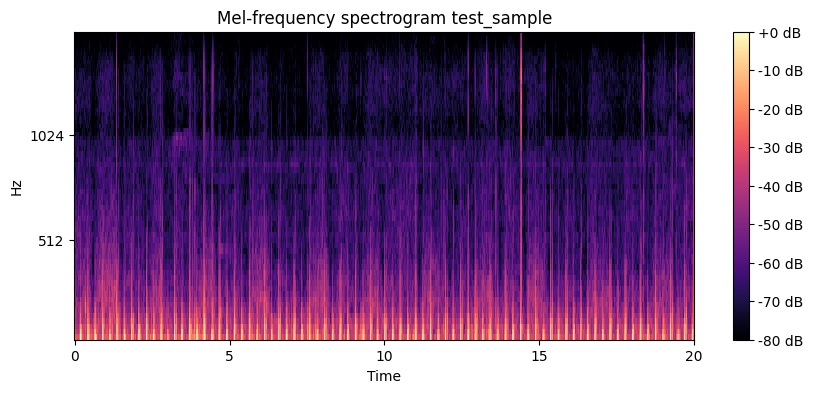

In [5]:
test_data_folder = 'data/icbhi/ICBHI_final_database/'
test_filename = '101_1b1_Al_sc_Meditron'  

audio_data = get_entire_signal_librosa(
    data_folder=test_data_folder,
    filename=test_filename,
    input_sec=2,
    spectrogram=False
)
if audio_data is not None:
    print("원본 wave 길이:", len(audio_data))
    # 멜 스펙트로그램 확인
    mel = pre_process_audio_mel_t(audio_data)
    print("Mel shape:", mel.shape)
    # 시각화
    plot_melspectrogram(audio_data, title="test_sample", save=False)


In [6]:
os.getcwd()

'/workspace'

## 1. ICBHI 데이터 전처리 코드
`preprocess_cycle_spectrogram` / `preprocess_entire_spectrogram`
- Cycle 단위 스펙트로그램 생성(`2초` 등)
- 전체 오디오 스펙트로그램 생성(`8초`)

In [7]:
import glob as gb
import argparse
import numpy as np
import pandas as pd
from tqdm import tqdm

# ICBHI용 진단/스플릿 정보
labels_data = pd.read_csv('data/icbhi/ICBHI_Challenge_diagnosis.txt', dtype=str, sep='\t', names=['userID', 'class'])
splits_data = pd.read_csv('data/icbhi/ICBHI_challenge_train_test.txt', dtype=str, sep='\t', names=['fileID', 'group'])
demographics_data = pd.read_csv('data/icbhi/ICBHI_Challenge_demographic_information.txt', dtype=str, sep='\t',
                                names=['userId', 'Age', 'Sex', 'Adult_BMI', 'Child Weight', 'Child Height'])

SR = 16000
data_dir = "data/icbhi/"

def preprocess_cycle_spectrogram(input_sec=2):
    sound_dir_loc = np.array(gb.glob("data/icbhi/ICBHI_final_database/*.wav"))
    annotation_dict = get_annotations("cycle", "data/icbhi/ICBHI_final_database")
    cycles_npy_names = []
    train_test = []

    cycle_path = data_dir + f"cycle_spec_pad{input_sec}_npy/" 
    if not os.path.exists(cycle_path):
        os.makedirs(cycle_path)
    
    valid_data, invalid_data = 0, 0

    for i in tqdm(range(sound_dir_loc.shape[0])):
        full_path = sound_dir_loc[i]
        filename = full_path.strip().split('.')[0]
        fileID = filename.split('/')[-1]
        userID = fileID.split('_')[0]
        file_split = splits_data["group"][splits_data.fileID == fileID].values
        if len(file_split) == 0:
            #Skip if train/test info is missing (to prevent errors)
            continue
        file_split = file_split[0]

        # Segment by respiratory cycle
        sample_data = get_individual_cycles_librosa(
            'cycle', annotation_dict[fileID],
            "data/icbhi/ICBHI_final_database", fileID, SR, 2)
        j = 0

        for audio, label in sample_data:
            j += 1
            data = get_entire_signal_librosa(
                data_folder="",
                filename="",
                spectrogram=True,
                input_sec=input_sec,
                pad=False,
                from_cycle=True,
                yt=audio
            )
            if data is None:
                invalid_data += 1
                continue
            output_name = cycle_path + fileID + f"_cycle{j}.npy"
            np.save(output_name, data)
            cycles_npy_names.append(output_name)
            valid_data += 1
            train_test.append(file_split)

    print("Number of cycles:", len(cycles_npy_names), "/ Train_test split:", len(train_test))
    np.save(data_dir + f"cycle_spec_pad{input_sec}_name.npy", cycles_npy_names)
    np.save(data_dir + "cycle_spec_split.npy", train_test)
    print("valid_data", valid_data, "invalid_data", invalid_data)

def preprocess_entire_spectrogram(input_sec=8):
    sound_dir_loc = np.array(gb.glob("data/icbhi/ICBHI_final_database/*.wav"))
    train_test = []
    filename_list = []
    invalid_data = 0

    output_dir = "data/icbhi/entire_spec_npy/"
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for i in tqdm(range(sound_dir_loc.shape[0])):
        full_path = sound_dir_loc[i]
        filename = full_path.strip().split('.')[0]
        fileID = filename.split('/')[-1]

        file_split_arr = splits_data["group"][splits_data.fileID == fileID].values
        if len(file_split_arr) == 0:
            # annotation 없는 경우 스킵 혹은 default
            continue
        file_split = file_split_arr[0]

        data = get_entire_signal_librosa("", filename, spectrogram=True, input_sec=input_sec)
        if data is None:
            invalid_data += 1
            continue

        save_path = os.path.join(output_dir, fileID + ".npy")
        np.save(save_path, data)
        filename_list.append(save_path)
        train_test.append(file_split)

    np.save("data/icbhi/entire_spec_filenames.npy", filename_list)
    np.save("data/icbhi/entire_spec_split.npy", train_test)
    print("invalid_data", invalid_data)


In [8]:
if __name__ == '__main__':
    preprocess_cycle_spectrogram(input_sec=2)
    preprocess_entire_spectrogram(input_sec=8)

  0%|▎                                                                                                                                             | 2/920 [00:00<01:04, 14.21it/s]

  1%|▉                                                                                                                                             | 6/920 [00:00<01:00, 15.07it/s]

  1%|█▌                                                                                                                                           | 10/920 [00:00<01:02, 14.48it/s]

  2%|██▏                                                                                                                                          | 14/920 [00:00<01:04, 14.09it/s]

  2%|██▊                                                                                                                                          | 18/920 [00:01<01:03, 14.28it/s]

  2%|███▎                                                                                                                                         | 22/920 [00:01<01:05, 13.72it/s]

  3%|████▎                                                                                                                                        | 28/920 [00:01<00:56, 15.89it/s]

  4%|█████▏                                                                                                                                       | 34/920 [00:02<00:55, 15.93it/s]

  4%|█████▊                                                                                                                                       | 38/920 [00:02<00:58, 14.97it/s]

  5%|██████▍                                                                                                                                      | 42/920 [00:02<01:00, 14.63it/s]

  5%|███████                                                                                                                                      | 46/920 [00:03<00:59, 14.81it/s]

  5%|███████▎                                                                                                                                     | 48/920 [00:03<01:02, 13.86it/s]

  6%|███████▉                                                                                                                                     | 52/920 [00:03<01:02, 13.90it/s]

  6%|████████▎                                                                                                                                    | 54/920 [00:03<01:01, 13.98it/s]

  6%|████████▉                                                                                                                                    | 58/920 [00:04<01:03, 13.47it/s]

  7%|█████████▏                                                                                                                                   | 60/920 [00:04<01:06, 13.02it/s]

  7%|█████████▊                                                                                                                                   | 64/920 [00:04<01:03, 13.52it/s]

  8%|██████████▋                                                                                                                                  | 70/920 [00:04<01:05, 12.92it/s]

  8%|███████████▉                                                                                                                                 | 78/920 [00:05<01:06, 12.67it/s]

  9%|████████████▌                                                                                                                                | 82/920 [00:05<01:01, 13.69it/s]

  9%|█████████████▏                                                                                                                               | 86/920 [00:06<01:00, 13.72it/s]

 10%|█████████████▊                                                                                                                               | 90/920 [00:06<01:02, 13.27it/s]

 10%|██████████████▍                                                                                                                              | 94/920 [00:06<01:01, 13.41it/s]

 11%|███████████████                                                                                                                              | 98/920 [00:07<00:57, 14.20it/s]

 11%|███████████████▏                                                                                                                            | 100/920 [00:07<00:59, 13.69it/s]

 12%|████████████████▍                                                                                                                           | 108/920 [00:07<01:02, 13.09it/s]

 12%|█████████████████                                                                                                                           | 112/920 [00:08<00:58, 13.77it/s]

 13%|█████████████████▋                                                                                                                          | 116/920 [00:08<00:59, 13.48it/s]

 13%|██████████████████▎                                                                                                                         | 120/920 [00:08<01:00, 13.16it/s]

 13%|██████████████████▌                                                                                                                         | 122/920 [00:08<00:59, 13.48it/s]

 14%|███████████████████▏                                                                                                                        | 126/920 [00:09<00:56, 13.95it/s]

 14%|███████████████████▍                                                                                                                        | 128/920 [00:09<00:58, 13.42it/s]

 14%|████████████████████                                                                                                                        | 132/920 [00:09<00:57, 13.64it/s]

 15%|████████████████████▊                                                                                                                       | 137/920 [00:09<00:47, 16.37it/s]

 15%|█████████████████████▍                                                                                                                      | 141/920 [00:10<00:55, 13.93it/s]

 16%|██████████████████████                                                                                                                      | 145/920 [00:10<00:52, 14.72it/s]

 16%|██████████████████████▎                                                                                                                     | 147/920 [00:10<00:53, 14.32it/s]

 16%|██████████████████████▉                                                                                                                     | 151/920 [00:10<00:53, 14.32it/s]

 17%|███████████████████████▎                                                                                                                    | 153/920 [00:11<00:56, 13.58it/s]

 17%|███████████████████████▉                                                                                                                    | 157/920 [00:11<01:01, 12.36it/s]

 18%|████████████████████████▋                                                                                                                   | 162/920 [00:11<00:52, 14.50it/s]

 18%|█████████████████████████▎                                                                                                                  | 166/920 [00:12<00:57, 13.06it/s]

 18%|█████████████████████████▌                                                                                                                  | 168/920 [00:12<00:59, 12.67it/s]

 19%|██████████████████████████▎                                                                                                                 | 173/920 [00:12<00:54, 13.68it/s]

 19%|███████████████████████████▏                                                                                                                | 179/920 [00:13<00:58, 12.56it/s]

 20%|███████████████████████████▊                                                                                                                | 183/920 [00:13<00:55, 13.20it/s]

 20%|████████████████████████████▌                                                                                                               | 188/920 [00:13<00:44, 16.39it/s]

 21%|████████████████████████████▉                                                                                                               | 190/920 [00:13<00:51, 14.22it/s]

 21%|█████████████████████████████▌                                                                                                              | 194/920 [00:14<00:53, 13.47it/s]

 22%|██████████████████████████████▏                                                                                                             | 198/920 [00:14<00:58, 12.34it/s]

 22%|██████████████████████████████▋                                                                                                             | 202/920 [00:14<00:57, 12.55it/s]

 22%|███████████████████████████████                                                                                                             | 204/920 [00:14<00:57, 12.48it/s]

 23%|████████████████████████████████▊                                                                                                           | 216/920 [00:15<00:49, 14.34it/s]

 24%|█████████████████████████████████▏                                                                                                          | 218/920 [00:16<00:52, 13.32it/s]

 24%|█████████████████████████████████▊                                                                                                          | 222/920 [00:16<00:52, 13.39it/s]

 25%|██████████████████████████████████▍                                                                                                         | 226/920 [00:16<00:53, 12.88it/s]

 25%|██████████████████████████████████▋                                                                                                         | 228/920 [00:16<00:54, 12.62it/s]

 25%|███████████████████████████████████▌                                                                                                        | 234/920 [00:17<00:53, 12.80it/s]

 26%|███████████████████████████████████▉                                                                                                        | 236/920 [00:17<00:57, 11.97it/s]

 26%|████████████████████████████████████▌                                                                                                       | 240/920 [00:17<00:54, 12.43it/s]

 27%|█████████████████████████████████████▏                                                                                                      | 244/920 [00:18<00:52, 12.76it/s]

 27%|█████████████████████████████████████▋                                                                                                      | 248/920 [00:18<00:53, 12.55it/s]

 28%|██████████████████████████████████████▊                                                                                                     | 255/920 [00:18<00:42, 15.51it/s]

 28%|███████████████████████████████████████▍                                                                                                    | 259/920 [00:19<00:41, 16.11it/s]

 28%|███████████████████████████████████████▊                                                                                                    | 262/920 [00:19<00:36, 18.03it/s]

 29%|████████████████████████████████████████▍                                                                                                   | 266/920 [00:19<00:40, 16.28it/s]

 29%|████████████████████████████████████████▉                                                                                                   | 269/920 [00:19<00:38, 16.88it/s]

 30%|█████████████████████████████████████████▊                                                                                                  | 275/920 [00:20<00:40, 15.79it/s]

 30%|██████████████████████████████████████████▍                                                                                                 | 279/920 [00:20<00:39, 16.14it/s]

 31%|██████████████████████████████████████████▊                                                                                                 | 281/920 [00:20<00:41, 15.43it/s]

 31%|███████████████████████████████████████████▎                                                                                                | 285/920 [00:20<00:39, 16.01it/s]

 31%|███████████████████████████████████████████▉                                                                                                | 289/920 [00:20<00:44, 14.03it/s]

 32%|████████████████████████████████████████████▎                                                                                               | 291/920 [00:21<00:43, 14.31it/s]

 32%|█████████████████████████████████████████████▌                                                                                              | 299/920 [00:21<00:35, 17.65it/s]

 33%|█████████████████████████████████████████████▊                                                                                              | 301/920 [00:21<00:35, 17.55it/s]

 33%|██████████████████████████████████████████████▍                                                                                             | 305/920 [00:21<00:37, 16.61it/s]

 34%|███████████████████████████████████████████████                                                                                             | 309/920 [00:22<00:35, 17.06it/s]

 34%|███████████████████████████████████████████████▍                                                                                            | 312/920 [00:22<00:35, 17.08it/s]

 34%|████████████████████████████████████████████████▏                                                                                           | 317/920 [00:22<00:36, 16.44it/s]

 35%|████████████████████████████████████████████████▊                                                                                           | 321/920 [00:22<00:37, 16.08it/s]

 35%|█████████████████████████████████████████████████▏                                                                                          | 323/920 [00:22<00:37, 15.79it/s]

 36%|█████████████████████████████████████████████████▊                                                                                          | 327/920 [00:23<00:37, 15.68it/s]

 36%|██████████████████████████████████████████████████▋                                                                                         | 333/920 [00:23<00:36, 16.04it/s]

 36%|██████████████████████████████████████████████████▉                                                                                         | 335/920 [00:23<00:38, 15.12it/s]

 37%|███████████████████████████████████████████████████▋                                                                                        | 340/920 [00:24<00:36, 15.78it/s]

 37%|████████████████████████████████████████████████████▎                                                                                       | 344/920 [00:24<00:41, 13.81it/s]

 38%|████████████████████████████████████████████████████▋                                                                                       | 346/920 [00:24<00:41, 13.82it/s]

 38%|█████████████████████████████████████████████████████▎                                                                                      | 350/920 [00:24<00:38, 14.94it/s]

 38%|█████████████████████████████████████████████████████▊                                                                                      | 354/920 [00:25<00:39, 14.25it/s]

 39%|██████████████████████████████████████████████████████▏                                                                                     | 356/920 [00:25<00:39, 14.25it/s]

 39%|██████████████████████████████████████████████████████▊                                                                                     | 360/920 [00:25<00:39, 14.07it/s]

 40%|███████████████████████████████████████████████████████▍                                                                                    | 364/920 [00:25<00:37, 14.72it/s]

 40%|████████████████████████████████████████████████████████                                                                                    | 368/920 [00:26<00:35, 15.75it/s]

 41%|████████████████████████████████████████████████████████▊                                                                                   | 373/920 [00:26<00:34, 15.83it/s]

 41%|█████████████████████████████████████████████████████████▌                                                                                  | 378/920 [00:26<00:36, 14.86it/s]

 42%|██████████████████████████████████████████████████████████▎                                                                                 | 383/920 [00:26<00:30, 17.80it/s]

 42%|██████████████████████████████████████████████████████████▉                                                                                 | 387/920 [00:27<00:32, 16.48it/s]

 42%|███████████████████████████████████████████████████████████▌                                                                                | 391/920 [00:27<00:34, 15.45it/s]

 43%|███████████████████████████████████████████████████████████▊                                                                                | 393/920 [00:27<00:32, 15.98it/s]

 43%|████████████████████████████████████████████████████████████▌                                                                               | 398/920 [00:27<00:30, 16.93it/s]

 44%|█████████████████████████████████████████████████████████████▎                                                                              | 403/920 [00:28<00:28, 17.97it/s]

 44%|██████████████████████████████████████████████████████████████▏                                                                             | 409/920 [00:28<00:29, 17.35it/s]

 45%|██████████████████████████████████████████████████████████████▌                                                                             | 411/920 [00:28<00:31, 16.31it/s]

 45%|███████████████████████████████████████████████████████████████▎                                                                            | 416/920 [00:28<00:29, 16.90it/s]

 46%|████████████████████████████████████████████████████████████████                                                                            | 421/920 [00:29<00:25, 19.76it/s]

 46%|████████████████████████████████████████████████████████████████▌                                                                           | 424/920 [00:29<00:23, 21.40it/s]

 47%|█████████████████████████████████████████████████████████████████▋                                                                          | 432/920 [00:29<00:24, 19.96it/s]

 47%|██████████████████████████████████████████████████████████████████▏                                                                         | 435/920 [00:29<00:24, 20.10it/s]

 48%|██████████████████████████████████████████████████████████████████▉                                                                         | 440/920 [00:30<00:27, 17.30it/s]

 48%|███████████████████████████████████████████████████████████████████▎                                                                        | 442/920 [00:30<00:28, 16.65it/s]

 48%|███████████████████████████████████████████████████████████████████▊                                                                        | 446/920 [00:30<00:29, 15.94it/s]

 49%|████████████████████████████████████████████████████████████████████▍                                                                       | 450/920 [00:30<00:29, 16.14it/s]

 49%|█████████████████████████████████████████████████████████████████████▏                                                                      | 455/920 [00:31<00:27, 16.83it/s]

 50%|█████████████████████████████████████████████████████████████████████▊                                                                      | 459/920 [00:31<00:27, 16.62it/s]

 50%|██████████████████████████████████████████████████████████████████████▏                                                                     | 461/920 [00:31<00:28, 16.03it/s]

 51%|██████████████████████████████████████████████████████████████████████▉                                                                     | 466/920 [00:31<00:26, 16.84it/s]

 51%|███████████████████████████████████████████████████████████████████████▌                                                                    | 470/920 [00:31<00:27, 16.15it/s]

 51%|███████████████████████████████████████████████████████████████████████▉                                                                    | 473/920 [00:32<00:26, 17.14it/s]

 52%|████████████████████████████████████████████████████████████████████████▋                                                                   | 478/920 [00:32<00:25, 17.25it/s]

 52%|█████████████████████████████████████████████████████████████████████████                                                                   | 480/920 [00:32<00:27, 15.84it/s]

 53%|█████████████████████████████████████████████████████████████████████████▋                                                                  | 484/920 [00:32<00:27, 16.10it/s]

 53%|██████████████████████████████████████████████████████████████████████████▍                                                                 | 489/920 [00:33<00:23, 18.45it/s]

 54%|███████████████████████████████████████████████████████████████████████████▍                                                                | 496/920 [00:33<00:25, 16.89it/s]

 54%|███████████████████████████████████████████████████████████████████████████▉                                                                | 499/920 [00:33<00:23, 17.76it/s]

 55%|████████████████████████████████████████████████████████████████████████████▊                                                               | 505/920 [00:33<00:22, 18.57it/s]

 55%|█████████████████████████████████████████████████████████████████████████████▍                                                              | 509/920 [00:34<00:23, 17.60it/s]

 56%|██████████████████████████████████████████████████████████████████████████████                                                              | 513/920 [00:34<00:24, 16.67it/s]

 56%|██████████████████████████████████████████████████████████████████████████████▋                                                             | 517/920 [00:34<00:23, 17.03it/s]

 56%|██████████████████████████████████████████████████████████████████████████████▉                                                             | 519/920 [00:34<00:25, 15.46it/s]

 57%|███████████████████████████████████████████████████████████████████████████████▌                                                            | 523/920 [00:35<00:27, 14.22it/s]

 57%|████████████████████████████████████████████████████████████████████████████████▏                                                           | 527/920 [00:35<00:28, 13.93it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████                                                           | 533/920 [00:35<00:23, 16.25it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████▊                                                          | 538/920 [00:36<00:21, 17.64it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████▍                                                         | 542/920 [00:36<00:21, 17.56it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████▏                                                        | 547/920 [00:36<00:20, 18.53it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████                                                        | 552/920 [00:36<00:20, 17.63it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████▎                                                       | 554/920 [00:36<00:21, 16.94it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████▎                                                      | 561/920 [00:37<00:21, 16.73it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████▏                                                     | 566/920 [00:37<00:20, 17.04it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████▋                                                     | 570/920 [00:37<00:22, 15.67it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████▎                                                    | 574/920 [00:38<00:23, 14.58it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████▉                                                    | 578/920 [00:38<00:23, 14.26it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 582/920 [00:38<00:22, 15.17it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 584/920 [00:38<00:21, 15.64it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 588/920 [00:39<00:22, 14.98it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 596/920 [00:39<00:19, 16.28it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                | 600/920 [00:39<00:20, 15.45it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                | 604/920 [00:40<00:22, 13.83it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 608/920 [00:40<00:22, 13.84it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 612/920 [00:40<00:21, 14.14it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 617/920 [00:41<00:19, 15.56it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 621/920 [00:41<00:19, 15.09it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 623/920 [00:41<00:20, 14.47it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 627/920 [00:41<00:19, 14.87it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 633/920 [00:42<00:18, 15.39it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 637/920 [00:42<00:21, 13.18it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 639/920 [00:42<00:21, 13.22it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 643/920 [00:42<00:19, 14.07it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 645/920 [00:43<00:20, 13.30it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 650/920 [00:43<00:17, 15.61it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 657/920 [00:43<00:17, 14.70it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 659/920 [00:44<00:18, 13.96it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 663/920 [00:44<00:16, 15.52it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 667/920 [00:44<00:17, 14.56it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 671/920 [00:44<00:15, 15.64it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 674/920 [00:44<00:15, 16.18it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 678/920 [00:45<00:15, 15.87it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 682/920 [00:45<00:15, 15.79it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 687/920 [00:45<00:14, 16.48it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 691/920 [00:46<00:14, 15.71it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 696/920 [00:46<00:13, 16.81it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 701/920 [00:46<00:12, 17.73it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 705/920 [00:46<00:14, 15.09it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 711/920 [00:47<00:10, 19.15it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 715/920 [00:47<00:13, 15.18it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 720/920 [00:47<00:13, 15.04it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 726/920 [00:48<00:13, 14.86it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 728/920 [00:48<00:14, 13.47it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 733/920 [00:48<00:12, 15.33it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 735/920 [00:48<00:12, 15.31it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 739/920 [00:49<00:13, 13.79it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 743/920 [00:49<00:12, 14.63it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 745/920 [00:49<00:12, 14.06it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 754/920 [00:50<00:08, 19.58it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 759/920 [00:50<00:09, 16.96it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 761/920 [00:50<00:09, 17.40it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 765/920 [00:50<00:10, 15.26it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 768/920 [00:50<00:09, 16.04it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 773/920 [00:51<00:10, 14.68it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 778/920 [00:51<00:08, 17.39it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 782/920 [00:51<00:09, 15.23it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 786/920 [00:52<00:09, 13.87it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 790/920 [00:52<00:08, 14.63it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 798/920 [00:53<00:09, 13.25it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 803/920 [00:53<00:06, 17.08it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 807/920 [00:53<00:07, 14.60it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 811/920 [00:53<00:07, 15.38it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 816/920 [00:54<00:06, 16.32it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 818/920 [00:54<00:06, 15.80it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 825/920 [00:54<00:06, 14.89it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 830/920 [00:55<00:05, 17.93it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 832/920 [00:55<00:05, 16.65it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 837/920 [00:55<00:04, 17.52it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 841/920 [00:55<00:05, 15.15it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 845/920 [00:56<00:04, 15.34it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 849/920 [00:56<00:04, 15.00it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 851/920 [00:56<00:04, 13.90it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 855/920 [00:56<00:04, 14.15it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 860/920 [00:57<00:04, 14.71it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 865/920 [00:57<00:03, 14.94it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 871/920 [00:57<00:02, 16.36it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 875/920 [00:57<00:02, 16.65it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 878/920 [00:58<00:02, 17.42it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 883/920 [00:58<00:02, 15.57it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 885/920 [00:58<00:02, 15.26it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 889/920 [00:58<00:01, 15.60it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 894/920 [00:59<00:01, 15.42it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 897/920 [00:59<00:01, 16.26it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 901/920 [00:59<00:01, 16.98it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 905/920 [00:59<00:00, 17.58it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 910/920 [01:00<00:00, 16.39it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 917/920 [01:00<00:00, 16.46it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 920/920 [01:00<00:00, 15.15it/s]


Number of cycles: 5024 / Train_test split: 5024
valid_data 5024 invalid_data 1874


 34%|███████████████████████████████████████████████▉                                                                                            | 315/920 [00:09<00:16, 36.10it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 920/920 [00:27<00:00, 33.29it/s]

invalid_data 1


## 2. HF_Lung 데이터 전처리
- 전체 오디오를 멜 스펙트로그램으로 변환 후 저장
- 경로: `data/hf_lung/HF_Lung_V1-master/train/*.wav`, `data/hf_lung/HF_Lung_V1_IP-main/train/*.wav` 

In [9]:
import glob as gb
import argparse
import numpy as np
from tqdm import tqdm

def hf_preprocess_entire_spectrogram(input_sec=8):
    SR = 16000
    filename_list = []
    invalid_data = 0

    # 첫 번째 경로
    path1 = 'data/hf_lung/HF_Lung_V1-master/train'
    sound_dir_loc = np.array(gb.glob(path1 + "/*.wav"))
    for i in tqdm(range(sound_dir_loc.shape[0])):
        full_path = sound_dir_loc[i].strip().split('.')[0]
        fileID = full_path.split('/')[-1]
        #print("Processing:", fileID)

        data = get_entire_signal_librosa('', full_path, spectrogram=True, input_sec=input_sec)
        if data is None:
            invalid_data += 1
            continue

        save_path = f"data/hf_lung/entire_spec_npy/{fileID}.npy"
        np.save(save_path, data)
        filename_list.append(save_path)

    # 두 번째 경로
    path2 = 'data/hf_lung/HF_Lung_V1_IP-main/train'
    sound_dir_loc = np.array(gb.glob(path2 + "/*.wav"))
    for i in tqdm(range(sound_dir_loc.shape[0])):
        full_path = sound_dir_loc[i].strip().split('.')[0]
        fileID = full_path.split('/')[-1]
        #print("Processing:", fileID)

        data = get_entire_signal_librosa('', full_path, spectrogram=True, input_sec=input_sec)
        if data is None:
            invalid_data += 1
            continue

        save_path = f"data/hf_lung/entire_spec_npy/{fileID}.npy"
        np.save(save_path, data)
        filename_list.append(save_path)

    np.save("data/hf_lung/entire_spec_filenames.npy", filename_list)
    print("invalid_data", invalid_data)


In [10]:
if __name__ == '__main__':
    hf_preprocess_entire_spectrogram(input_sec=8)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2745/2745 [01:39<00:00, 27.48it/s]

invalid_data 0


## 3. Coswara 데이터 전처리

- `preprocess_label`, `preprocess_modality` 등을 이용해 *sex*, *smoker* 등 특정 라벨에 따라 train/test 분할을 하고,
- 최종적으로 특정 모달리티(breathing/cough 등) 별로 임베딩(feature) 추출까지 진행.

**Coswara 데이터를 학습용으로 만들고, Train/Test 나누지 않고, 멜 스펙트로그램을 생성하여 저장**

In [13]:
import glob
def coswara_preprocess_entire_spectrogram(data_root="data/Coswara-Data/Extracted_data/", 
                                          save_root="data/Coswara-Data/entire_spec_npy/", 
                                          input_sec=8, sr=16000):
    """
    Coswara 데이터에서 모든 디렉토리를 뒤져 .wav 파일을 찾은 뒤,
    get_entire_signal_librosa(spectrogram=True)으로 멜 스펙트로그램을 추출,
    그리고 'entire_spec_npy' 폴더 하위에 'YYYYMMDD_UUID_filename.npy' 형태로 저장.
    """
    # 저장 폴더(루트) 미리 생성
    os.makedirs(save_root, exist_ok=True)

    # 데이터 구조 예: data/Coswara-Data/Extracted_data/20200418/UUID/breathing-shallow.wav
    wav_files = glob.glob(os.path.join(data_root, "**/*.wav"), recursive=True)
    print(f"Found {len(wav_files)} wav files in {data_root}")

    filename_list = []
    invalid_count = 0
    
    for wav_path in tqdm(wav_files, desc="Coswara preprocessing"):
        # rel_path 예:  "20200418/C7Km0KttQRM.../breathing-shallow.wav"
        rel_path = os.path.relpath(wav_path, data_root)  
        # 확장자 제거 →  "20200418/C7Km0KttQRM.../breathing-shallow"
        filename_no_ext = os.path.splitext(rel_path)[0]
        # 경로 구분자(os.sep)를 '_'로 바꾸어 단일 파일명으로 만듦
        # 결과 예: "20200418_C7Km0KttQRM..._breathing-shallow"
        flattened_name = filename_no_ext.replace(os.sep, "_")

        # get_entire_signal_librosa → mel spectrogram
        mel_spec = get_entire_signal_librosa(
            data_folder=os.path.dirname(wav_path),
            filename=os.path.basename(wav_path).split('.')[0],
            input_sec=input_sec,
            sample_rate=sr,
            spectrogram=True
            # pad=True,
            # from_cycle=False,
            # yt=None,
            # types='repeat'
        )
        if mel_spec is None:
            invalid_count += 1
            continue
        
        # 최종 저장 경로 (하위 폴더 없이, flattened_name 기반)
        save_filename = os.path.join(save_root, flattened_name + ".npy")
        np.save(save_filename, mel_spec)
        
        filename_list.append(save_filename)

    # 전체 파일 이름 목록도 저장
    np.save("data/Coswara-Data/entire_spec_filenames.npy", filename_list)
    print(f"Finished Coswara preprocessing. Invalid(count={invalid_count}). Total saved={len(filename_list)}.")

In [15]:
coswara_preprocess_entire_spectrogram()

Found 24712 wav files in data/Coswara-Data/Extracted_data/


Coswara preprocessing:   0%|                                                                                                                     | 6/24712 [00:00<06:55, 59.45it/s]

Coswara preprocessing:   0%|                                                                                                                    | 12/24712 [00:00<07:27, 55.18it/s]

Coswara preprocessing:   0%|▏                                                                                                                   | 29/24712 [00:00<05:47, 71.06it/s]

Coswara preprocessing:   0%|▏                                                                                                                   | 37/24712 [00:00<06:32, 62.87it/s]

Coswara preprocessing:   0%|▏                                                                                                                   | 44/24712 [00:00<07:31, 54.67it/s]

Coswara preprocessing:   0%|▏                                                                                                                   | 53/24712 [00:00<06:33, 62.65it/s]

Coswara preprocessing:   0%|▍                                                                                                                  | 83/24712 [00:01<03:55, 104.37it/s]

Coswara preprocessing:   0%|▍                                                                                                                  | 104/24712 [00:01<04:45, 86.19it/s]

Coswara preprocessing:   0%|▌                                                                                                                  | 122/24712 [00:01<05:15, 77.98it/s]

Coswara preprocessing:   1%|▋                                                                                                                  | 140/24712 [00:01<04:57, 82.53it/s]

Coswara preprocessing:   1%|▋                                                                                                                  | 158/24712 [00:02<05:44, 71.32it/s]

Coswara preprocessing:   1%|▊                                                                                                                  | 173/24712 [00:02<06:24, 63.87it/s]

Coswara preprocessing:   1%|▊                                                                                                                  | 180/24712 [00:02<06:50, 59.79it/s]

Coswara preprocessing:   1%|▉                                                                                                                  | 197/24712 [00:02<06:05, 67.07it/s]

Coswara preprocessing:   1%|█                                                                                                                  | 215/24712 [00:02<05:26, 75.07it/s]

Coswara preprocessing:   1%|█▏                                                                                                                | 255/24712 [00:03<03:46, 107.93it/s]

Coswara preprocessing:   1%|█▏                                                                                                                 | 267/24712 [00:03<04:24, 92.54it/s]

Coswara preprocessing:   1%|█▎                                                                                                                | 292/24712 [00:03<03:57, 102.70it/s]

Coswara preprocessing:   1%|█▍                                                                                                                | 303/24712 [00:03<03:59, 101.73it/s]

Coswara preprocessing:   1%|█▍                                                                                                                 | 314/24712 [00:04<08:41, 46.83it/s]

Coswara preprocessing:   1%|█▍                                                                                                                 | 322/24712 [00:04<11:51, 34.26it/s]

Coswara preprocessing:   1%|█▌                                                                                                                 | 329/24712 [00:05<14:07, 28.76it/s]

Coswara preprocessing:   1%|█▌                                                                                                                 | 338/24712 [00:05<15:44, 25.80it/s]

Coswara preprocessing:   1%|█▌                                                                                                                 | 344/24712 [00:05<14:21, 28.27it/s]

warning in producing spectrogram! (constant array)
warning in producing spectrogram! (constant array)


Coswara preprocessing:   1%|█▌                                                                                                                 | 348/24712 [00:05<16:10, 25.11it/s]

warning in producing spectrogram! (constant array)
warning in producing spectrogram! (constant array)
warning in producing spectrogram! (constant array)


Coswara preprocessing:   1%|█▋                                                                                                                 | 352/24712 [00:06<15:18, 26.52it/s]

Coswara preprocessing:   1%|█▋                                                                                                                 | 360/24712 [00:06<16:23, 24.77it/s]

Coswara preprocessing:   1%|█▋                                                                                                                 | 366/24712 [00:06<17:17, 23.47it/s]

Coswara preprocessing:   1%|█▋                                                                                                                 | 369/24712 [00:06<18:57, 21.40it/s]

Coswara preprocessing:   2%|█▋                                                                                                                 | 375/24712 [00:07<20:21, 19.93it/s]

Coswara preprocessing:   2%|█▊                                                                                                                 | 380/24712 [00:07<22:30, 18.02it/s]

Coswara preprocessing:   2%|█▊                                                                                                                 | 383/24712 [00:07<22:05, 18.36it/s]

Coswara preprocessing:   2%|█▊                                                                                                                 | 389/24712 [00:08<21:32, 18.82it/s]

Coswara preprocessing:   2%|█▊                                                                                                                 | 395/24712 [00:08<18:28, 21.94it/s]

Coswara preprocessing:   2%|█▉                                                                                                                 | 403/24712 [00:08<15:30, 26.13it/s]

Coswara preprocessing:   2%|█▉                                                                                                                 | 407/24712 [00:08<14:35, 27.77it/s]

Coswara preprocessing:   2%|█▉                                                                                                                 | 413/24712 [00:08<18:04, 22.41it/s]

Coswara preprocessing:   2%|█▉                                                                                                                 | 416/24712 [00:09<19:39, 20.60it/s]

Coswara preprocessing:   2%|█▉                                                                                                                 | 419/24712 [00:09<20:22, 19.88it/s]

Coswara preprocessing:   2%|█▉                                                                                                                 | 425/24712 [00:09<21:53, 18.50it/s]

Coswara preprocessing:   2%|██                                                                                                                 | 430/24712 [00:09<21:20, 18.96it/s]

Coswara preprocessing:   2%|██                                                                                                                 | 436/24712 [00:10<19:46, 20.46it/s]

Coswara preprocessing:   2%|██                                                                                                                 | 442/24712 [00:10<17:30, 23.11it/s]

Coswara preprocessing:   2%|██                                                                                                                 | 448/24712 [00:10<20:16, 19.94it/s]

Coswara preprocessing:   2%|██                                                                                                                 | 454/24712 [00:11<19:51, 20.37it/s]

Coswara preprocessing:   2%|██▏                                                                                                                | 457/24712 [00:11<18:56, 21.33it/s]

Coswara preprocessing:   2%|██▏                                                                                                                | 464/24712 [00:11<17:04, 23.67it/s]

Coswara preprocessing:   2%|██▏                                                                                                                | 470/24712 [00:11<17:54, 22.56it/s]

Coswara preprocessing:   2%|██▏                                                                                                                | 478/24712 [00:12<16:35, 24.34it/s]

Coswara preprocessing:   2%|██▎                                                                                                                | 484/24712 [00:12<19:55, 20.26it/s]

Coswara preprocessing:   2%|██▎                                                                                                                | 493/24712 [00:12<20:16, 19.91it/s]

Coswara preprocessing:   2%|██▎                                                                                                                | 499/24712 [00:13<18:28, 21.83it/s]

Coswara preprocessing:   2%|██▎                                                                                                                | 507/24712 [00:13<15:42, 25.68it/s]

Coswara preprocessing:   2%|██▍                                                                                                                | 513/24712 [00:13<17:08, 23.52it/s]

Coswara preprocessing:   2%|██▍                                                                                                                | 519/24712 [00:13<15:28, 26.05it/s]

Coswara preprocessing:   2%|██▍                                                                                                                | 525/24712 [00:14<18:55, 21.29it/s]

Coswara preprocessing:   2%|██▍                                                                                                                | 528/24712 [00:14<19:34, 20.59it/s]

Coswara preprocessing:   2%|██▍                                                                                                                | 534/24712 [00:14<19:14, 20.94it/s]

Coswara preprocessing:   2%|██▌                                                                                                                | 540/24712 [00:14<19:43, 20.43it/s]

Coswara preprocessing:   2%|██▌                                                                                                                | 546/24712 [00:15<19:13, 20.96it/s]

Coswara preprocessing:   2%|██▌                                                                                                                | 552/24712 [00:15<21:50, 18.43it/s]

Coswara preprocessing:   2%|██▌                                                                                                                | 554/24712 [00:15<22:24, 17.97it/s]

Coswara preprocessing:   2%|██▌                                                                                                                | 560/24712 [00:16<20:30, 19.62it/s]

Coswara preprocessing:   2%|██▋                                                                                                                | 565/24712 [00:16<21:05, 19.09it/s]

Coswara preprocessing:   2%|██▋                                                                                                                | 575/24712 [00:16<19:34, 20.56it/s]

Coswara preprocessing:   2%|██▋                                                                                                                | 578/24712 [00:16<19:50, 20.27it/s]

Coswara preprocessing:   2%|██▋                                                                                                                | 584/24712 [00:17<20:28, 19.64it/s]

Coswara preprocessing:   2%|██▊                                                                                                                | 593/24712 [00:17<21:30, 18.69it/s]

Coswara preprocessing:   2%|██▊                                                                                                                | 599/24712 [00:18<20:21, 19.74it/s]

Coswara preprocessing:   2%|██▊                                                                                                                | 603/24712 [00:18<17:42, 22.68it/s]

Coswara preprocessing:   2%|██▊                                                                                                                | 609/24712 [00:18<20:15, 19.84it/s]

Coswara preprocessing:   2%|██▊                                                                                                                | 612/24712 [00:18<18:39, 21.53it/s]

Coswara preprocessing:   3%|██▉                                                                                                                | 618/24712 [00:18<20:22, 19.71it/s]

Coswara preprocessing:   3%|██▉                                                                                                                | 623/24712 [00:19<24:31, 16.37it/s]

Coswara preprocessing:   3%|██▉                                                                                                                | 625/24712 [00:19<24:07, 16.64it/s]

Coswara preprocessing:   3%|██▉                                                                                                                | 632/24712 [00:19<22:59, 17.45it/s]

Coswara preprocessing:   3%|██▉                                                                                                                | 638/24712 [00:20<22:49, 17.58it/s]

Coswara preprocessing:   3%|██▉                                                                                                                | 644/24712 [00:20<19:20, 20.74it/s]

Coswara preprocessing:   3%|███                                                                                                                | 650/24712 [00:20<21:28, 18.67it/s]

Coswara preprocessing:   3%|███                                                                                                                | 655/24712 [00:21<22:27, 17.86it/s]

Coswara preprocessing:   3%|███                                                                                                                | 659/24712 [00:21<24:23, 16.44it/s]

Coswara preprocessing:   3%|███                                                                                                                | 664/24712 [00:21<21:31, 18.62it/s]

Coswara preprocessing:   3%|███                                                                                                                | 668/24712 [00:21<24:12, 16.55it/s]

Coswara preprocessing:   3%|███▏                                                                                                               | 674/24712 [00:22<27:17, 14.68it/s]

Coswara preprocessing:   3%|███▏                                                                                                               | 678/24712 [00:22<25:02, 16.00it/s]

Coswara preprocessing:   3%|███▏                                                                                                               | 681/24712 [00:22<22:17, 17.96it/s]

warning in producing spectrogram! (constant array)


Coswara preprocessing:   3%|███▏                                                                                                               | 686/24712 [00:22<23:13, 17.25it/s]

Coswara preprocessing:   3%|███▏                                                                                                               | 690/24712 [00:23<23:53, 16.76it/s]

Coswara preprocessing:   3%|███▏                                                                                                               | 695/24712 [00:23<24:36, 16.26it/s]

Coswara preprocessing:   3%|███▎                                                                                                               | 700/24712 [00:23<22:29, 17.80it/s]

Coswara preprocessing:   3%|███▎                                                                                                               | 704/24712 [00:24<23:57, 16.70it/s]

Coswara preprocessing:   3%|███▎                                                                                                               | 708/24712 [00:24<22:45, 17.58it/s]

Coswara preprocessing:   3%|███▎                                                                                                               | 710/24712 [00:24<22:48, 17.54it/s]

Coswara preprocessing:   3%|███▎                                                                                                               | 715/24712 [00:24<23:21, 17.12it/s]

Coswara preprocessing:   3%|███▎                                                                                                               | 720/24712 [00:24<22:53, 17.46it/s]

Coswara preprocessing:   3%|███▍                                                                                                               | 728/24712 [00:25<27:13, 14.68it/s]

Coswara preprocessing:   3%|███▍                                                                                                               | 734/24712 [00:25<26:59, 14.80it/s]

Coswara preprocessing:   3%|███▍                                                                                                               | 739/24712 [00:26<24:46, 16.12it/s]

Coswara preprocessing:   3%|███▍                                                                                                               | 745/24712 [00:26<26:57, 14.82it/s]

Coswara preprocessing:   3%|███▍                                                                                                               | 749/24712 [00:26<24:37, 16.21it/s]

Coswara preprocessing:   3%|███▌                                                                                                               | 753/24712 [00:27<27:46, 14.38it/s]

Coswara preprocessing:   3%|███▌                                                                                                               | 757/24712 [00:27<26:02, 15.33it/s]

Coswara preprocessing:   3%|███▌                                                                                                               | 761/24712 [00:27<26:45, 14.92it/s]

Coswara preprocessing:   3%|███▌                                                                                                               | 765/24712 [00:27<26:45, 14.92it/s]

Coswara preprocessing:   3%|███▌                                                                                                               | 770/24712 [00:28<22:59, 17.36it/s]

Coswara preprocessing:   3%|███▌                                                                                                               | 774/24712 [00:28<22:48, 17.50it/s]

Coswara preprocessing:   3%|███▌                                                                                                               | 778/24712 [00:28<23:50, 16.73it/s]

Coswara preprocessing:   3%|███▋                                                                                                               | 781/24712 [00:28<22:26, 17.77it/s]

Coswara preprocessing:   3%|███▋                                                                                                               | 785/24712 [00:29<22:18, 17.87it/s]

Coswara preprocessing:   3%|███▋                                                                                                               | 790/24712 [00:29<20:53, 19.08it/s]

Coswara preprocessing:   3%|███▋                                                                                                               | 795/24712 [00:29<22:07, 18.02it/s]

Coswara preprocessing:   3%|███▋                                                                                                               | 801/24712 [00:29<23:05, 17.25it/s]

Coswara preprocessing:   3%|███▊                                                                                                               | 806/24712 [00:30<21:03, 18.92it/s]

Coswara preprocessing:   3%|███▊                                                                                                               | 812/24712 [00:30<19:48, 20.11it/s]

Coswara preprocessing:   3%|███▊                                                                                                               | 815/24712 [00:30<18:17, 21.78it/s]

Coswara preprocessing:   3%|███▊                                                                                                               | 821/24712 [00:30<20:54, 19.04it/s]

Coswara preprocessing:   3%|███▊                                                                                                               | 826/24712 [00:31<20:34, 19.35it/s]

Coswara preprocessing:   3%|███▊                                                                                                               | 831/24712 [00:31<21:46, 18.28it/s]

Coswara preprocessing:   3%|███▉                                                                                                               | 835/24712 [00:31<24:05, 16.52it/s]

Coswara preprocessing:   3%|███▉                                                                                                               | 840/24712 [00:32<22:19, 17.82it/s]

Coswara preprocessing:   3%|███▉                                                                                                               | 844/24712 [00:32<21:43, 18.31it/s]

Coswara preprocessing:   3%|███▉                                                                                                               | 848/24712 [00:32<22:29, 17.69it/s]

Coswara preprocessing:   3%|███▉                                                                                                               | 853/24712 [00:32<20:41, 19.22it/s]

Coswara preprocessing:   3%|███▉                                                                                                               | 858/24712 [00:32<18:51, 21.08it/s]

Coswara preprocessing:   3%|████                                                                                                               | 864/24712 [00:33<18:17, 21.72it/s]

Coswara preprocessing:   4%|████                                                                                                               | 871/24712 [00:33<21:28, 18.51it/s]

Coswara preprocessing:   4%|████                                                                                                               | 874/24712 [00:33<20:24, 19.47it/s]

Coswara preprocessing:   4%|████                                                                                                               | 879/24712 [00:34<19:35, 20.28it/s]

Coswara preprocessing:   4%|████                                                                                                               | 885/24712 [00:34<19:32, 20.33it/s]

Coswara preprocessing:   4%|████▏                                                                                                              | 888/24712 [00:34<18:39, 21.27it/s]

Coswara preprocessing:   4%|████▏                                                                                                              | 893/24712 [00:34<20:45, 19.12it/s]

Coswara preprocessing:   4%|████▏                                                                                                              | 898/24712 [00:34<19:17, 20.57it/s]

Coswara preprocessing:   4%|████▏                                                                                                              | 904/24712 [00:35<18:25, 21.54it/s]

Coswara preprocessing:   4%|████▏                                                                                                              | 908/24712 [00:35<17:09, 23.12it/s]

Coswara preprocessing:   4%|████▎                                                                                                              | 914/24712 [00:35<16:47, 23.63it/s]

Coswara preprocessing:   4%|████▎                                                                                                              | 920/24712 [00:35<18:06, 21.89it/s]

Coswara preprocessing:   4%|████▎                                                                                                              | 926/24712 [00:36<19:46, 20.04it/s]

Coswara preprocessing:   4%|████▎                                                                                                              | 932/24712 [00:36<17:12, 23.03it/s]

Coswara preprocessing:   4%|████▎                                                                                                              | 935/24712 [00:36<17:37, 22.47it/s]

Coswara preprocessing:   4%|████▍                                                                                                              | 941/24712 [00:36<17:36, 22.51it/s]

Coswara preprocessing:   4%|████▍                                                                                                              | 950/24712 [00:37<16:26, 24.08it/s]

Coswara preprocessing:   4%|████▍                                                                                                              | 953/24712 [00:37<18:51, 21.00it/s]

Coswara preprocessing:   4%|████▍                                                                                                              | 962/24712 [00:37<20:31, 19.29it/s]

Coswara preprocessing:   4%|████▌                                                                                                              | 968/24712 [00:38<17:58, 22.01it/s]

Coswara preprocessing:   4%|████▌                                                                                                              | 974/24712 [00:38<17:09, 23.05it/s]

Coswara preprocessing:   4%|████▌                                                                                                              | 977/24712 [00:38<17:44, 22.30it/s]

Coswara preprocessing:   4%|████▌                                                                                                              | 983/24712 [00:38<17:58, 21.99it/s]

Coswara preprocessing:   4%|████▌                                                                                                              | 989/24712 [00:39<18:50, 20.98it/s]

Coswara preprocessing:   4%|████▌                                                                                                              | 992/24712 [00:39<19:53, 19.88it/s]

Coswara preprocessing:   4%|████▋                                                                                                              | 998/24712 [00:39<20:45, 19.04it/s]

Coswara preprocessing:   4%|████▌                                                                                                             | 1001/24712 [00:39<20:22, 19.40it/s]

Coswara preprocessing:   4%|████▋                                                                                                             | 1009/24712 [00:40<19:42, 20.04it/s]

Coswara preprocessing:   4%|████▋                                                                                                             | 1018/24712 [00:40<10:50, 36.44it/s]

Coswara preprocessing:   4%|████▋                                                                                                             | 1023/24712 [00:40<13:18, 29.65it/s]

Coswara preprocessing:   4%|████▋                                                                                                             | 1027/24712 [00:40<14:09, 27.88it/s]

Coswara preprocessing:   4%|████▊                                                                                                             | 1034/24712 [00:41<17:17, 22.82it/s]

Coswara preprocessing:   4%|████▊                                                                                                             | 1037/24712 [00:41<17:06, 23.06it/s]

Coswara preprocessing:   4%|████▊                                                                                                             | 1043/24712 [00:41<18:42, 21.09it/s]

Coswara preprocessing:   4%|████▊                                                                                                             | 1046/24712 [00:41<18:36, 21.20it/s]

Coswara preprocessing:   4%|████▊                                                                                                             | 1052/24712 [00:41<20:02, 19.67it/s]

Coswara preprocessing:   4%|████▊                                                                                                             | 1055/24712 [00:42<19:03, 20.68it/s]

Coswara preprocessing:   4%|████▉                                                                                                             | 1058/24712 [00:42<19:48, 19.90it/s]

Coswara preprocessing:   4%|████▉                                                                                                             | 1064/24712 [00:42<21:14, 18.56it/s]

Coswara preprocessing:   4%|████▉                                                                                                             | 1070/24712 [00:42<20:49, 18.91it/s]

Coswara preprocessing:   4%|████▉                                                                                                             | 1080/24712 [00:43<23:24, 16.83it/s]

Coswara preprocessing:   4%|█████                                                                                                             | 1084/24712 [00:43<23:57, 16.44it/s]

Coswara preprocessing:   4%|█████                                                                                                             | 1089/24712 [00:43<20:41, 19.03it/s]

Coswara preprocessing:   4%|█████                                                                                                             | 1096/24712 [00:44<20:56, 18.79it/s]

Coswara preprocessing:   4%|█████                                                                                                             | 1101/24712 [00:44<21:46, 18.07it/s]

Coswara preprocessing:   4%|█████                                                                                                             | 1106/24712 [00:44<20:12, 19.46it/s]

Coswara preprocessing:   4%|█████                                                                                                             | 1109/24712 [00:44<17:53, 21.99it/s]

Coswara preprocessing:   5%|█████▏                                                                                                            | 1115/24712 [00:45<21:10, 18.57it/s]

Coswara preprocessing:   5%|█████▏                                                                                                            | 1118/24712 [00:45<21:28, 18.31it/s]

Coswara preprocessing:   5%|█████▏                                                                                                            | 1123/24712 [00:45<19:44, 19.91it/s]

Coswara preprocessing:   5%|█████▏                                                                                                            | 1129/24712 [00:46<20:19, 19.34it/s]

Coswara preprocessing:   5%|█████▏                                                                                                            | 1133/24712 [00:46<22:03, 17.81it/s]

Coswara preprocessing:   5%|█████▎                                                                                                            | 1140/24712 [00:46<22:34, 17.40it/s]

Coswara preprocessing:   5%|█████▎                                                                                                            | 1145/24712 [00:47<23:04, 17.02it/s]

Coswara preprocessing:   5%|█████▎                                                                                                            | 1151/24712 [00:47<24:22, 16.11it/s]

Coswara preprocessing:   5%|█████▎                                                                                                            | 1156/24712 [00:47<20:43, 18.95it/s]

Coswara preprocessing:   5%|█████▎                                                                                                            | 1160/24712 [00:47<22:38, 17.34it/s]

Coswara preprocessing:   5%|█████▍                                                                                                            | 1166/24712 [00:48<19:32, 20.08it/s]

Coswara preprocessing:   5%|█████▍                                                                                                            | 1169/24712 [00:48<20:57, 18.72it/s]

Coswara preprocessing:   5%|█████▍                                                                                                            | 1172/24712 [00:48<20:37, 19.02it/s]

Coswara preprocessing:   5%|█████▍                                                                                                            | 1178/24712 [00:48<20:15, 19.37it/s]

Coswara preprocessing:   5%|█████▍                                                                                                            | 1180/24712 [00:48<20:40, 18.97it/s]

Coswara preprocessing:   5%|█████▍                                                                                                            | 1186/24712 [00:49<23:04, 16.99it/s]

Coswara preprocessing:   5%|█████▍                                                                                                            | 1190/24712 [00:49<22:34, 17.37it/s]

Coswara preprocessing:   5%|█████▌                                                                                                            | 1195/24712 [00:49<23:41, 16.55it/s]

Coswara preprocessing:   5%|█████▌                                                                                                            | 1199/24712 [00:50<25:24, 15.42it/s]

Coswara preprocessing:   5%|█████▌                                                                                                            | 1203/24712 [00:50<26:47, 14.62it/s]

Coswara preprocessing:   5%|█████▌                                                                                                            | 1209/24712 [00:50<26:16, 14.91it/s]

Coswara preprocessing:   5%|█████▌                                                                                                            | 1215/24712 [00:51<23:03, 16.98it/s]

Coswara preprocessing:   5%|█████▋                                                                                                            | 1223/24712 [00:51<27:59, 13.99it/s]

Coswara preprocessing:   5%|█████▋                                                                                                            | 1226/24712 [00:51<25:29, 15.36it/s]

Coswara preprocessing:   5%|█████▋                                                                                                            | 1230/24712 [00:52<24:52, 15.74it/s]

Coswara preprocessing:   5%|█████▋                                                                                                            | 1235/24712 [00:52<24:54, 15.71it/s]

Coswara preprocessing:   5%|█████▋                                                                                                            | 1240/24712 [00:52<24:11, 16.17it/s]

Coswara preprocessing:   5%|█████▋                                                                                                            | 1244/24712 [00:53<23:36, 16.57it/s]

Coswara preprocessing:   5%|█████▊                                                                                                            | 1248/24712 [00:53<23:36, 16.56it/s]

Coswara preprocessing:   5%|█████▊                                                                                                            | 1253/24712 [00:53<25:52, 15.11it/s]

Coswara preprocessing:   5%|█████▊                                                                                                            | 1257/24712 [00:53<25:13, 15.49it/s]

Coswara preprocessing:   5%|█████▊                                                                                                            | 1263/24712 [00:54<25:20, 15.42it/s]

Coswara preprocessing:   5%|█████▊                                                                                                            | 1265/24712 [00:54<27:39, 14.13it/s]

Coswara preprocessing:   5%|█████▊                                                                                                            | 1271/24712 [00:54<25:31, 15.31it/s]

Coswara preprocessing:   5%|█████▉                                                                                                            | 1276/24712 [00:55<23:22, 16.71it/s]

Coswara preprocessing:   5%|█████▉                                                                                                            | 1280/24712 [00:55<24:28, 15.95it/s]

Coswara preprocessing:   5%|█████▉                                                                                                            | 1284/24712 [00:55<23:25, 16.67it/s]

Coswara preprocessing:   5%|█████▉                                                                                                            | 1290/24712 [00:55<23:15, 16.79it/s]

Coswara preprocessing:   5%|█████▉                                                                                                            | 1294/24712 [00:56<23:22, 16.69it/s]

Coswara preprocessing:   5%|█████▉                                                                                                            | 1298/24712 [00:56<25:37, 15.23it/s]

Coswara preprocessing:   5%|██████                                                                                                            | 1302/24712 [00:56<24:55, 15.65it/s]

Coswara preprocessing:   5%|██████                                                                                                            | 1307/24712 [00:57<23:43, 16.45it/s]

Coswara preprocessing:   5%|██████                                                                                                            | 1312/24712 [00:57<21:03, 18.52it/s]

Coswara preprocessing:   5%|██████                                                                                                            | 1316/24712 [00:57<23:45, 16.42it/s]

Coswara preprocessing:   5%|██████                                                                                                            | 1318/24712 [00:57<24:46, 15.74it/s]

Coswara preprocessing:   5%|██████                                                                                                            | 1325/24712 [00:58<24:53, 15.66it/s]

Coswara preprocessing:   5%|██████▏                                                                                                           | 1329/24712 [00:58<25:12, 15.46it/s]

Coswara preprocessing:   5%|██████▏                                                                                                           | 1335/24712 [00:58<24:06, 16.16it/s]

Coswara preprocessing:   5%|██████▏                                                                                                           | 1338/24712 [00:58<21:58, 17.73it/s]

Coswara preprocessing:   5%|██████▏                                                                                                           | 1343/24712 [00:59<22:01, 17.68it/s]

Coswara preprocessing:   5%|██████▏                                                                                                           | 1347/24712 [00:59<22:40, 17.18it/s]

Coswara preprocessing:   5%|██████▏                                                                                                           | 1354/24712 [00:59<20:44, 18.77it/s]

Coswara preprocessing:   5%|██████▎                                                                                                           | 1359/24712 [01:00<18:49, 20.68it/s]

Coswara preprocessing:   6%|██████▎                                                                                                           | 1362/24712 [01:00<18:29, 21.04it/s]

Coswara preprocessing:   6%|██████▎                                                                                                           | 1368/24712 [01:00<18:49, 20.67it/s]

Coswara preprocessing:   6%|██████▎                                                                                                           | 1371/24712 [01:00<19:03, 20.42it/s]

Coswara preprocessing:   6%|██████▎                                                                                                           | 1374/24712 [01:00<19:03, 20.42it/s]

Coswara preprocessing:   6%|██████▎                                                                                                           | 1380/24712 [01:01<20:40, 18.81it/s]

Coswara preprocessing:   6%|██████▍                                                                                                           | 1383/24712 [01:01<20:20, 19.12it/s]

Coswara preprocessing:   6%|██████▍                                                                                                           | 1388/24712 [01:01<22:17, 17.44it/s]

Coswara preprocessing:   6%|██████▍                                                                                                           | 1392/24712 [01:01<21:33, 18.03it/s]

Coswara preprocessing:   6%|██████▍                                                                                                           | 1397/24712 [01:02<20:33, 18.91it/s]

Coswara preprocessing:   6%|██████▍                                                                                                           | 1406/24712 [01:02<21:57, 17.69it/s]

Coswara preprocessing:   6%|██████▌                                                                                                           | 1411/24712 [01:02<21:31, 18.04it/s]

Coswara preprocessing:   6%|██████▌                                                                                                           | 1416/24712 [01:03<19:55, 19.48it/s]

Coswara preprocessing:   6%|██████▌                                                                                                           | 1423/24712 [01:03<17:07, 22.67it/s]

Coswara preprocessing:   6%|██████▌                                                                                                           | 1431/24712 [01:03<20:31, 18.90it/s]

Coswara preprocessing:   6%|██████▋                                                                                                           | 1439/24712 [01:04<22:33, 17.20it/s]

Coswara preprocessing:   6%|██████▋                                                                                                           | 1447/24712 [01:04<20:00, 19.38it/s]

Coswara preprocessing:   6%|██████▋                                                                                                           | 1453/24712 [01:05<19:13, 20.16it/s]

Coswara preprocessing:   6%|██████▋                                                                                                           | 1456/24712 [01:05<19:05, 20.30it/s]

Coswara preprocessing:   6%|██████▋                                                                                                           | 1461/24712 [01:05<20:53, 18.54it/s]

Coswara preprocessing:   6%|██████▊                                                                                                           | 1466/24712 [01:05<19:59, 19.38it/s]

Coswara preprocessing:   6%|██████▊                                                                                                           | 1469/24712 [01:05<20:10, 19.20it/s]

Coswara preprocessing:   6%|██████▊                                                                                                           | 1474/24712 [01:06<19:59, 19.37it/s]

Coswara preprocessing:   6%|██████▊                                                                                                           | 1480/24712 [01:06<18:25, 21.01it/s]

Coswara preprocessing:   6%|██████▊                                                                                                           | 1483/24712 [01:06<19:05, 20.28it/s]

Coswara preprocessing:   6%|██████▊                                                                                                           | 1489/24712 [01:06<18:21, 21.09it/s]

Coswara preprocessing:   6%|██████▉                                                                                                           | 1495/24712 [01:07<17:57, 21.54it/s]

Coswara preprocessing:   6%|██████▉                                                                                                           | 1501/24712 [01:07<19:42, 19.63it/s]

Coswara preprocessing:   6%|██████▉                                                                                                           | 1505/24712 [01:07<22:24, 17.26it/s]

Coswara preprocessing:   6%|██████▉                                                                                                           | 1509/24712 [01:07<23:22, 16.55it/s]

Coswara preprocessing:   6%|██████▉                                                                                                           | 1514/24712 [01:08<20:30, 18.86it/s]

Coswara preprocessing:   6%|███████                                                                                                           | 1521/24712 [01:08<15:55, 24.28it/s]

Coswara preprocessing:   6%|███████                                                                                                           | 1527/24712 [01:08<18:37, 20.74it/s]

Coswara preprocessing:   6%|███████                                                                                                           | 1530/24712 [01:08<18:35, 20.78it/s]

Coswara preprocessing:   6%|███████                                                                                                           | 1538/24712 [01:09<20:44, 18.63it/s]

Coswara preprocessing:   6%|███████                                                                                                           | 1541/24712 [01:09<19:14, 20.06it/s]

Coswara preprocessing:   6%|███████▏                                                                                                          | 1548/24712 [01:09<17:16, 22.35it/s]

Coswara preprocessing:   6%|███████▏                                                                                                          | 1554/24712 [01:10<19:10, 20.12it/s]

Coswara preprocessing:   6%|███████▏                                                                                                          | 1563/24712 [01:10<13:58, 27.59it/s]

Coswara preprocessing:   6%|███████▎                                                                                                          | 1573/24712 [01:10<18:11, 21.20it/s]

Coswara preprocessing:   6%|███████▎                                                                                                          | 1576/24712 [01:11<19:45, 19.52it/s]

Coswara preprocessing:   6%|███████▎                                                                                                          | 1583/24712 [01:11<22:10, 17.38it/s]

Coswara preprocessing:   6%|███████▎                                                                                                          | 1588/24712 [01:11<21:59, 17.52it/s]

Coswara preprocessing:   6%|███████▎                                                                                                          | 1592/24712 [01:12<22:59, 16.76it/s]

Coswara preprocessing:   6%|███████▎                                                                                                          | 1595/24712 [01:12<21:50, 17.65it/s]

Coswara preprocessing:   6%|███████▍                                                                                                          | 1599/24712 [01:12<21:15, 18.13it/s]

Coswara preprocessing:   7%|███████▍                                                                                                          | 1613/24712 [01:13<28:02, 13.73it/s]

Coswara preprocessing:   7%|███████▍                                                                                                          | 1618/24712 [01:13<22:43, 16.93it/s]

Coswara preprocessing:   7%|███████▍                                                                                                          | 1622/24712 [01:14<22:56, 16.78it/s]

Coswara preprocessing:   7%|███████▌                                                                                                          | 1627/24712 [01:14<22:50, 16.85it/s]

Coswara preprocessing:   7%|███████▌                                                                                                          | 1631/24712 [01:14<23:45, 16.19it/s]

Coswara preprocessing:   7%|███████▌                                                                                                          | 1635/24712 [01:14<23:57, 16.05it/s]

Coswara preprocessing:   7%|███████▌                                                                                                          | 1640/24712 [01:15<21:51, 17.59it/s]

Coswara preprocessing:   7%|███████▌                                                                                                          | 1645/24712 [01:15<21:30, 17.87it/s]

Coswara preprocessing:   7%|███████▌                                                                                                          | 1650/24712 [01:15<22:25, 17.13it/s]

Coswara preprocessing:   7%|███████▋                                                                                                          | 1654/24712 [01:15<21:52, 17.57it/s]

Coswara preprocessing:   7%|███████▋                                                                                                          | 1658/24712 [01:16<23:20, 16.46it/s]

Coswara preprocessing:   7%|███████▋                                                                                                          | 1664/24712 [01:16<22:51, 16.81it/s]

Coswara preprocessing:   7%|███████▋                                                                                                          | 1666/24712 [01:16<22:01, 17.43it/s]

Coswara preprocessing:   7%|███████▋                                                                                                          | 1672/24712 [01:16<24:07, 15.92it/s]

Coswara preprocessing:   7%|███████▋                                                                                                          | 1676/24712 [01:17<26:51, 14.29it/s]

Coswara preprocessing:   7%|███████▊                                                                                                          | 1682/24712 [01:17<27:17, 14.07it/s]

Coswara preprocessing:   7%|███████▊                                                                                                          | 1688/24712 [01:18<27:15, 14.08it/s]

Coswara preprocessing:   7%|███████▊                                                                                                          | 1694/24712 [01:18<26:17, 14.59it/s]

Coswara preprocessing:   7%|███████▊                                                                                                          | 1699/24712 [01:18<27:02, 14.18it/s]

Coswara preprocessing:   7%|███████▊                                                                                                          | 1704/24712 [01:19<22:12, 17.27it/s]

Coswara preprocessing:   7%|███████▊                                                                                                          | 1707/24712 [01:19<21:37, 17.74it/s]

Coswara preprocessing:   7%|███████▉                                                                                                          | 1711/24712 [01:19<22:38, 16.93it/s]

Coswara preprocessing:   7%|███████▉                                                                                                          | 1715/24712 [01:19<25:13, 15.19it/s]

Coswara preprocessing:   7%|███████▉                                                                                                          | 1717/24712 [01:20<25:49, 14.84it/s]

Coswara preprocessing:   7%|███████▉                                                                                                          | 1721/24712 [01:20<27:49, 13.77it/s]

Coswara preprocessing:   7%|███████▉                                                                                                          | 1725/24712 [01:20<25:35, 14.97it/s]

Coswara preprocessing:   7%|███████▉                                                                                                          | 1731/24712 [01:20<25:00, 15.32it/s]

Coswara preprocessing:   7%|████████                                                                                                          | 1735/24712 [01:21<24:49, 15.42it/s]

Coswara preprocessing:   7%|████████                                                                                                          | 1740/24712 [01:21<21:16, 18.00it/s]

Coswara preprocessing:   7%|████████                                                                                                          | 1745/24712 [01:21<20:10, 18.97it/s]

Coswara preprocessing:   7%|████████                                                                                                          | 1753/24712 [01:22<22:43, 16.84it/s]

Coswara preprocessing:   7%|████████                                                                                                          | 1757/24712 [01:22<23:51, 16.03it/s]

Coswara preprocessing:   7%|████████                                                                                                          | 1761/24712 [01:22<24:41, 15.49it/s]

Coswara preprocessing:   7%|████████▏                                                                                                         | 1766/24712 [01:23<22:10, 17.24it/s]

Coswara preprocessing:   7%|████████▏                                                                                                         | 1771/24712 [01:23<20:10, 18.95it/s]

Coswara preprocessing:   7%|████████▏                                                                                                         | 1775/24712 [01:23<21:33, 17.73it/s]

Coswara preprocessing:   7%|████████▏                                                                                                         | 1779/24712 [01:23<21:24, 17.86it/s]

Coswara preprocessing:   7%|████████▏                                                                                                         | 1785/24712 [01:24<21:12, 18.02it/s]

Coswara preprocessing:   7%|████████▏                                                                                                         | 1787/24712 [01:24<21:24, 17.85it/s]

Coswara preprocessing:   7%|████████▎                                                                                                         | 1791/24712 [01:24<23:33, 16.22it/s]

Coswara preprocessing:   7%|████████▎                                                                                                         | 1798/24712 [01:24<23:55, 15.97it/s]

Coswara preprocessing:   7%|████████▎                                                                                                         | 1803/24712 [01:25<19:32, 19.53it/s]

Coswara preprocessing:   7%|████████▎                                                                                                         | 1809/24712 [01:25<19:07, 19.96it/s]

Coswara preprocessing:   7%|████████▍                                                                                                         | 1816/24712 [01:25<20:31, 18.59it/s]

Coswara preprocessing:   7%|████████▍                                                                                                         | 1820/24712 [01:26<22:00, 17.33it/s]

Coswara preprocessing:   7%|████████▍                                                                                                         | 1826/24712 [01:26<21:31, 17.72it/s]

Coswara preprocessing:   7%|████████▍                                                                                                         | 1832/24712 [01:26<23:59, 15.90it/s]

Coswara preprocessing:   7%|████████▍                                                                                                         | 1838/24712 [01:27<24:09, 15.78it/s]

Coswara preprocessing:   7%|████████▍                                                                                                         | 1842/24712 [01:27<22:38, 16.84it/s]

Coswara preprocessing:   7%|████████▌                                                                                                         | 1848/24712 [01:27<22:51, 16.67it/s]

Coswara preprocessing:   7%|████████▌                                                                                                         | 1852/24712 [01:28<23:58, 15.90it/s]

Coswara preprocessing:   8%|████████▌                                                                                                         | 1856/24712 [01:28<23:46, 16.02it/s]

Coswara preprocessing:   8%|████████▌                                                                                                         | 1862/24712 [01:28<24:51, 15.32it/s]

Coswara preprocessing:   8%|████████▌                                                                                                         | 1868/24712 [01:28<19:18, 19.72it/s]

Coswara preprocessing:   8%|████████▋                                                                                                         | 1871/24712 [01:29<18:48, 20.23it/s]

Coswara preprocessing:   8%|████████▋                                                                                                         | 1882/24712 [01:29<21:49, 17.44it/s]

Coswara preprocessing:   8%|████████▋                                                                                                         | 1888/24712 [01:30<23:08, 16.44it/s]

Coswara preprocessing:   8%|████████▋                                                                                                         | 1892/24712 [01:30<23:31, 16.17it/s]

Coswara preprocessing:   8%|████████▊                                                                                                         | 1897/24712 [01:30<19:34, 19.42it/s]

Coswara preprocessing:   8%|████████▊                                                                                                         | 1902/24712 [01:30<20:22, 18.65it/s]

Coswara preprocessing:   8%|████████▊                                                                                                         | 1905/24712 [01:30<19:20, 19.65it/s]

Coswara preprocessing:   8%|████████▊                                                                                                         | 1913/24712 [01:31<19:09, 19.84it/s]

Coswara preprocessing:   8%|████████▊                                                                                                         | 1919/24712 [01:31<17:11, 22.09it/s]

Coswara preprocessing:   8%|████████▉                                                                                                         | 1925/24712 [01:32<19:20, 19.63it/s]

Coswara preprocessing:   8%|████████▉                                                                                                         | 1933/24712 [01:32<19:46, 19.19it/s]

Coswara preprocessing:   8%|████████▉                                                                                                         | 1937/24712 [01:32<20:48, 18.24it/s]

Coswara preprocessing:   8%|████████▉                                                                                                         | 1942/24712 [01:32<18:09, 20.91it/s]

Coswara preprocessing:   8%|████████▉                                                                                                         | 1945/24712 [01:33<19:03, 19.91it/s]

Coswara preprocessing:   8%|████████▉                                                                                                         | 1950/24712 [01:33<21:52, 17.34it/s]

Coswara preprocessing:   8%|█████████                                                                                                         | 1955/24712 [01:33<21:37, 17.54it/s]

Coswara preprocessing:   8%|█████████                                                                                                         | 1961/24712 [01:34<21:06, 17.96it/s]

Coswara preprocessing:   8%|█████████                                                                                                         | 1966/24712 [01:34<21:35, 17.56it/s]

Coswara preprocessing:   8%|█████████                                                                                                         | 1970/24712 [01:34<23:17, 16.27it/s]

Coswara preprocessing:   8%|█████████                                                                                                         | 1976/24712 [01:34<19:33, 19.37it/s]

Coswara preprocessing:   8%|█████████▏                                                                                                        | 1980/24712 [01:35<20:29, 18.49it/s]

Coswara preprocessing:   8%|█████████▏                                                                                                        | 1987/24712 [01:35<19:32, 19.39it/s]

Coswara preprocessing:   8%|█████████▏                                                                                                        | 1991/24712 [01:35<20:05, 18.84it/s]

Coswara preprocessing:   8%|█████████▏                                                                                                        | 1997/24712 [01:35<18:09, 20.84it/s]

Coswara preprocessing:   8%|█████████▏                                                                                                        | 2000/24712 [01:36<16:56, 22.34it/s]

Coswara preprocessing:   8%|█████████▎                                                                                                        | 2007/24712 [01:36<17:26, 21.70it/s]

Coswara preprocessing:   8%|█████████▎                                                                                                        | 2013/24712 [01:36<19:23, 19.51it/s]

Coswara preprocessing:   8%|█████████▎                                                                                                        | 2018/24712 [01:36<20:00, 18.91it/s]

Coswara preprocessing:   8%|█████████▎                                                                                                        | 2023/24712 [01:37<21:22, 17.69it/s]

Coswara preprocessing:   8%|█████████▎                                                                                                        | 2027/24712 [01:37<24:36, 15.37it/s]

Coswara preprocessing:   8%|█████████▎                                                                                                        | 2032/24712 [01:37<21:17, 17.76it/s]

Coswara preprocessing:   8%|█████████▍                                                                                                        | 2036/24712 [01:38<22:05, 17.11it/s]

Coswara preprocessing:   8%|█████████▍                                                                                                        | 2043/24712 [01:38<21:57, 17.20it/s]

Coswara preprocessing:   8%|█████████▍                                                                                                        | 2047/24712 [01:38<20:57, 18.03it/s]

Coswara preprocessing:   8%|█████████▍                                                                                                        | 2051/24712 [01:38<23:07, 16.34it/s]

Coswara preprocessing:   8%|█████████▍                                                                                                        | 2055/24712 [01:39<23:16, 16.23it/s]

Coswara preprocessing:   8%|█████████▍                                                                                                        | 2057/24712 [01:39<23:09, 16.31it/s]

Coswara preprocessing:   8%|█████████▌                                                                                                        | 2063/24712 [01:39<25:03, 15.06it/s]

Coswara preprocessing:   8%|█████████▌                                                                                                        | 2067/24712 [01:39<25:05, 15.04it/s]

Coswara preprocessing:   8%|█████████▌                                                                                                        | 2069/24712 [01:40<24:53, 15.16it/s]

Coswara preprocessing:   8%|█████████▌                                                                                                        | 2076/24712 [01:40<18:19, 20.59it/s]

Coswara preprocessing:   8%|█████████▌                                                                                                        | 2079/24712 [01:40<17:08, 22.00it/s]

Coswara preprocessing:   8%|█████████▌                                                                                                        | 2086/24712 [01:40<22:16, 16.93it/s]

Coswara preprocessing:   8%|█████████▋                                                                                                        | 2090/24712 [01:41<22:55, 16.45it/s]

Coswara preprocessing:   8%|█████████▋                                                                                                        | 2095/24712 [01:41<21:26, 17.58it/s]

Coswara preprocessing:   8%|█████████▋                                                                                                        | 2099/24712 [01:41<23:28, 16.05it/s]

Coswara preprocessing:   9%|█████████▋                                                                                                        | 2104/24712 [01:42<22:44, 16.57it/s]

Coswara preprocessing:   9%|█████████▋                                                                                                        | 2108/24712 [01:42<23:01, 16.37it/s]

Coswara preprocessing:   9%|█████████▋                                                                                                        | 2111/24712 [01:42<22:19, 16.87it/s]

Coswara preprocessing:   9%|█████████▊                                                                                                        | 2117/24712 [01:42<21:27, 17.55it/s]

Coswara preprocessing:   9%|█████████▊                                                                                                        | 2121/24712 [01:42<21:33, 17.47it/s]

Coswara preprocessing:   9%|█████████▊                                                                                                        | 2125/24712 [01:43<22:20, 16.85it/s]

Coswara preprocessing:   9%|█████████▊                                                                                                        | 2133/24712 [01:43<23:14, 16.19it/s]

Coswara preprocessing:   9%|█████████▊                                                                                                        | 2137/24712 [01:43<22:48, 16.49it/s]

Coswara preprocessing:   9%|█████████▉                                                                                                        | 2142/24712 [01:44<21:15, 17.70it/s]

Coswara preprocessing:   9%|█████████▉                                                                                                        | 2144/24712 [01:44<20:52, 18.02it/s]

Coswara preprocessing:   9%|█████████▉                                                                                                        | 2148/24712 [01:44<24:26, 15.38it/s]

Coswara preprocessing:   9%|█████████▉                                                                                                        | 2153/24712 [01:44<23:45, 15.83it/s]

Coswara preprocessing:   9%|█████████▉                                                                                                        | 2159/24712 [01:45<19:46, 19.01it/s]

Coswara preprocessing:   9%|█████████▉                                                                                                        | 2164/24712 [01:45<20:45, 18.10it/s]

Coswara preprocessing:   9%|██████████                                                                                                        | 2171/24712 [01:45<22:55, 16.39it/s]

Coswara preprocessing:   9%|██████████                                                                                                        | 2175/24712 [01:46<23:38, 15.88it/s]

Coswara preprocessing:   9%|██████████                                                                                                        | 2179/24712 [01:46<25:09, 14.93it/s]

Coswara preprocessing:   9%|██████████                                                                                                        | 2189/24712 [01:47<26:05, 14.38it/s]

Coswara preprocessing:   9%|██████████                                                                                                        | 2193/24712 [01:47<24:10, 15.52it/s]

Coswara preprocessing:   9%|██████████▏                                                                                                       | 2198/24712 [01:47<24:20, 15.42it/s]

Coswara preprocessing:   9%|██████████▏                                                                                                       | 2204/24712 [01:48<24:29, 15.32it/s]

Coswara preprocessing:   9%|██████████▏                                                                                                       | 2210/24712 [01:48<26:50, 13.97it/s]

Coswara preprocessing:   9%|██████████▏                                                                                                       | 2217/24712 [01:49<23:43, 15.80it/s]

Coswara preprocessing:   9%|██████████▏                                                                                                       | 2219/24712 [01:49<23:29, 15.95it/s]

Coswara preprocessing:   9%|██████████▎                                                                                                       | 2224/24712 [01:49<23:25, 16.00it/s]

Coswara preprocessing:   9%|██████████▎                                                                                                       | 2228/24712 [01:49<25:51, 14.49it/s]

Coswara preprocessing:   9%|██████████▎                                                                                                       | 2233/24712 [01:50<22:38, 16.55it/s]

Coswara preprocessing:   9%|██████████▎                                                                                                       | 2239/24712 [01:50<24:25, 15.33it/s]

Coswara preprocessing:   9%|██████████▎                                                                                                       | 2243/24712 [01:50<24:56, 15.02it/s]

Coswara preprocessing:   9%|██████████▎                                                                                                       | 2248/24712 [01:50<21:45, 17.21it/s]

Coswara preprocessing:   9%|██████████▍                                                                                                       | 2252/24712 [01:51<24:09, 15.49it/s]

Coswara preprocessing:   9%|██████████▍                                                                                                       | 2258/24712 [01:51<23:01, 16.26it/s]

Coswara preprocessing:   9%|██████████▍                                                                                                       | 2263/24712 [01:51<21:11, 17.66it/s]

Coswara preprocessing:   9%|██████████▍                                                                                                       | 2266/24712 [01:52<18:51, 19.84it/s]

Coswara preprocessing:   9%|██████████▍                                                                                                       | 2271/24712 [01:52<19:29, 19.19it/s]

Coswara preprocessing:   9%|██████████▍                                                                                                       | 2275/24712 [01:52<20:35, 18.17it/s]

Coswara preprocessing:   9%|██████████▌                                                                                                       | 2288/24712 [01:52<10:46, 34.70it/s]

Coswara preprocessing:   9%|██████████▌                                                                                                       | 2295/24712 [01:53<17:41, 21.13it/s]

Coswara preprocessing:   9%|██████████▌                                                                                                       | 2302/24712 [01:53<20:52, 17.89it/s]

Coswara preprocessing:   9%|██████████▋                                                                                                       | 2306/24712 [01:54<23:21, 15.99it/s]

Coswara preprocessing:   9%|██████████▋                                                                                                       | 2310/24712 [01:54<24:28, 15.26it/s]

Coswara preprocessing:   9%|██████████▋                                                                                                       | 2315/24712 [01:54<22:54, 16.30it/s]

Coswara preprocessing:   9%|██████████▋                                                                                                       | 2319/24712 [01:54<21:42, 17.19it/s]

Coswara preprocessing:   9%|██████████▋                                                                                                       | 2325/24712 [01:55<20:30, 18.19it/s]

Coswara preprocessing:   9%|██████████▋                                                                                                       | 2328/24712 [01:55<19:17, 19.33it/s]

Coswara preprocessing:   9%|██████████▊                                                                                                       | 2333/24712 [01:55<18:25, 20.24it/s]

Coswara preprocessing:   9%|██████████▊                                                                                                       | 2339/24712 [01:55<18:49, 19.80it/s]

Coswara preprocessing:   9%|██████████▊                                                                                                       | 2342/24712 [01:56<19:45, 18.87it/s]

Coswara preprocessing:   9%|██████████▊                                                                                                       | 2346/24712 [01:56<21:30, 17.33it/s]

Coswara preprocessing:  10%|██████████▊                                                                                                       | 2350/24712 [01:56<21:30, 17.33it/s]

Coswara preprocessing:  10%|██████████▊                                                                                                       | 2357/24712 [01:56<19:34, 19.03it/s]

Coswara preprocessing:  10%|██████████▉                                                                                                       | 2365/24712 [01:57<15:55, 23.38it/s]

Coswara preprocessing:  10%|██████████▉                                                                                                       | 2371/24712 [01:57<18:10, 20.48it/s]

Coswara preprocessing:  10%|██████████▉                                                                                                       | 2374/24712 [01:57<17:21, 21.45it/s]

Coswara preprocessing:  10%|██████████▉                                                                                                       | 2377/24712 [01:57<18:27, 20.16it/s]

Coswara preprocessing:  10%|██████████▉                                                                                                       | 2383/24712 [01:58<19:43, 18.87it/s]

Coswara preprocessing:  10%|███████████                                                                                                       | 2387/24712 [01:58<21:09, 17.59it/s]

Coswara preprocessing:  10%|███████████                                                                                                       | 2390/24712 [01:58<20:26, 18.21it/s]

Coswara preprocessing:  10%|███████████                                                                                                       | 2396/24712 [01:58<19:03, 19.52it/s]

Coswara preprocessing:  10%|███████████                                                                                                       | 2402/24712 [01:59<19:48, 18.77it/s]

Coswara preprocessing:  10%|███████████                                                                                                       | 2404/24712 [01:59<20:53, 17.80it/s]

Coswara preprocessing:  10%|███████████                                                                                                       | 2410/24712 [01:59<19:53, 18.69it/s]

Coswara preprocessing:  10%|███████████▏                                                                                                      | 2414/24712 [01:59<20:18, 18.29it/s]

Coswara preprocessing:  10%|███████████▏                                                                                                      | 2418/24712 [02:00<20:00, 18.57it/s]

Coswara preprocessing:  10%|███████████▏                                                                                                      | 2423/24712 [02:00<21:01, 17.66it/s]

Coswara preprocessing:  10%|███████████▏                                                                                                      | 2429/24712 [02:00<25:13, 14.72it/s]

Coswara preprocessing:  10%|███████████▏                                                                                                      | 2435/24712 [02:01<21:35, 17.19it/s]

Coswara preprocessing:  10%|███████████▎                                                                                                      | 2441/24712 [02:01<21:40, 17.12it/s]

Coswara preprocessing:  10%|███████████▎                                                                                                      | 2447/24712 [02:01<21:22, 17.36it/s]

Coswara preprocessing:  10%|███████████▎                                                                                                      | 2453/24712 [02:02<18:48, 19.73it/s]

Coswara preprocessing:  10%|███████████▎                                                                                                      | 2460/24712 [02:02<17:12, 21.55it/s]

Coswara preprocessing:  10%|███████████▍                                                                                                      | 2466/24712 [02:02<17:38, 21.01it/s]

Coswara preprocessing:  10%|███████████▍                                                                                                      | 2472/24712 [02:02<15:06, 24.54it/s]

Coswara preprocessing:  10%|███████████▍                                                                                                      | 2478/24712 [02:03<16:09, 22.93it/s]

Coswara preprocessing:  10%|███████████▍                                                                                                      | 2484/24712 [02:03<15:52, 23.35it/s]

Coswara preprocessing:  10%|███████████▍                                                                                                      | 2490/24712 [02:03<14:56, 24.77it/s]

warning in producing spectrogram! (constant array)
warning in producing spectrogram! (constant array)
warning in producing spectrogram! (constant array)


Coswara preprocessing:  10%|███████████▌                                                                                                      | 2496/24712 [02:03<15:18, 24.20it/s]

warning in producing spectrogram! (constant array)


Coswara preprocessing:  10%|███████████▌                                                                                                      | 2502/24712 [02:04<15:35, 23.75it/s]

Coswara preprocessing:  10%|███████████▌                                                                                                      | 2511/24712 [02:04<16:10, 22.88it/s]

Coswara preprocessing:  10%|███████████▋                                                                                                      | 2524/24712 [02:05<15:06, 24.47it/s]

Coswara preprocessing:  10%|███████████▋                                                                                                      | 2530/24712 [02:05<14:44, 25.08it/s]

Coswara preprocessing:  10%|███████████▋                                                                                                      | 2536/24712 [02:05<14:25, 25.61it/s]

Coswara preprocessing:  10%|███████████▋                                                                                                      | 2545/24712 [02:05<16:31, 22.36it/s]

Coswara preprocessing:  10%|███████████▊                                                                                                      | 2551/24712 [02:06<15:25, 23.94it/s]

Coswara preprocessing:  10%|███████████▊                                                                                                      | 2558/24712 [02:06<13:02, 28.32it/s]

Coswara preprocessing:  10%|███████████▊                                                                                                      | 2568/24712 [02:06<08:15, 44.71it/s]

Coswara preprocessing:  10%|███████████▊                                                                                                      | 2573/24712 [02:06<11:35, 31.85it/s]

Coswara preprocessing:  10%|███████████▉                                                                                                      | 2577/24712 [02:07<14:37, 25.24it/s]

Coswara preprocessing:  10%|███████████▉                                                                                                      | 2584/24712 [02:07<16:15, 22.68it/s]

Coswara preprocessing:  10%|███████████▉                                                                                                      | 2590/24712 [02:07<18:00, 20.47it/s]

Coswara preprocessing:  11%|███████████▉                                                                                                      | 2596/24712 [02:08<18:29, 19.94it/s]

Coswara preprocessing:  11%|███████████▉                                                                                                      | 2599/24712 [02:08<17:16, 21.34it/s]

Coswara preprocessing:  11%|████████████                                                                                                      | 2605/24712 [02:08<18:05, 20.37it/s]

Coswara preprocessing:  11%|████████████                                                                                                      | 2608/24712 [02:08<18:15, 20.17it/s]

Coswara preprocessing:  11%|████████████                                                                                                      | 2614/24712 [02:08<19:08, 19.25it/s]

Coswara preprocessing:  11%|████████████                                                                                                      | 2620/24712 [02:09<17:19, 21.25it/s]

Coswara preprocessing:  11%|████████████▏                                                                                                     | 2630/24712 [02:09<09:20, 39.40it/s]

Coswara preprocessing:  11%|████████████▏                                                                                                     | 2635/24712 [02:09<11:44, 31.34it/s]

Coswara preprocessing:  11%|████████████▏                                                                                                     | 2643/24712 [02:10<16:52, 21.80it/s]

Coswara preprocessing:  11%|████████████▏                                                                                                     | 2649/24712 [02:10<19:03, 19.29it/s]

Coswara preprocessing:  11%|████████████▏                                                                                                     | 2652/24712 [02:10<18:54, 19.44it/s]

Coswara preprocessing:  11%|████████████▏                                                                                                     | 2655/24712 [02:10<18:53, 19.46it/s]

Coswara preprocessing:  11%|████████████▎                                                                                                     | 2662/24712 [02:11<20:24, 18.00it/s]

Coswara preprocessing:  11%|████████████▎                                                                                                     | 2668/24712 [02:11<17:58, 20.45it/s]

Coswara preprocessing:  11%|████████████▎                                                                                                     | 2671/24712 [02:11<17:22, 21.14it/s]

Coswara preprocessing:  11%|████████████▎                                                                                                     | 2679/24712 [02:12<20:20, 18.05it/s]

Coswara preprocessing:  11%|████████████▍                                                                                                     | 2685/24712 [02:12<22:07, 16.59it/s]

Coswara preprocessing:  11%|████████████▍                                                                                                     | 2691/24712 [02:12<22:55, 16.00it/s]

Coswara preprocessing:  11%|████████████▍                                                                                                     | 2699/24712 [02:13<25:27, 14.41it/s]

Coswara preprocessing:  11%|████████████▍                                                                                                     | 2701/24712 [02:13<24:10, 15.18it/s]

Coswara preprocessing:  11%|████████████▍                                                                                                     | 2705/24712 [02:13<24:12, 15.15it/s]

Coswara preprocessing:  11%|████████████▌                                                                                                     | 2720/24712 [02:14<11:00, 33.28it/s]

Coswara preprocessing:  11%|████████████▌                                                                                                     | 2724/24712 [02:14<13:39, 26.82it/s]

Coswara preprocessing:  11%|████████████▌                                                                                                     | 2731/24712 [02:14<15:30, 23.62it/s]

Coswara preprocessing:  11%|████████████▌                                                                                                     | 2734/24712 [02:14<17:37, 20.79it/s]

Coswara preprocessing:  11%|████████████▋                                                                                                     | 2737/24712 [02:15<17:44, 20.65it/s]

Coswara preprocessing:  11%|████████████▋                                                                                                     | 2743/24712 [02:15<19:00, 19.26it/s]

Coswara preprocessing:  11%|████████████▋                                                                                                     | 2747/24712 [02:15<22:00, 16.64it/s]

Coswara preprocessing:  11%|████████████▋                                                                                                     | 2751/24712 [02:15<21:54, 16.70it/s]

Coswara preprocessing:  11%|████████████▋                                                                                                     | 2756/24712 [02:16<21:39, 16.90it/s]

Coswara preprocessing:  11%|████████████▋                                                                                                     | 2763/24712 [02:16<21:31, 16.99it/s]

Coswara preprocessing:  11%|████████████▊                                                                                                     | 2769/24712 [02:17<25:02, 14.61it/s]

Coswara preprocessing:  11%|████████████▊                                                                                                     | 2773/24712 [02:17<27:33, 13.27it/s]

Coswara preprocessing:  11%|████████████▊                                                                                                     | 2779/24712 [02:17<25:50, 14.14it/s]

Coswara preprocessing:  11%|████████████▊                                                                                                     | 2783/24712 [02:18<24:23, 14.98it/s]

Coswara preprocessing:  11%|████████████▊                                                                                                     | 2789/24712 [02:18<26:25, 13.83it/s]

Coswara preprocessing:  11%|████████████▉                                                                                                     | 2795/24712 [02:18<27:49, 13.13it/s]

Coswara preprocessing:  11%|████████████▉                                                                                                     | 2801/24712 [02:19<25:28, 14.33it/s]

Coswara preprocessing:  11%|████████████▉                                                                                                     | 2805/24712 [02:19<22:25, 16.28it/s]

Coswara preprocessing:  11%|████████████▉                                                                                                     | 2809/24712 [02:19<22:50, 15.99it/s]

Coswara preprocessing:  11%|████████████▉                                                                                                     | 2813/24712 [02:20<25:56, 14.07it/s]

Coswara preprocessing:  11%|█████████████                                                                                                     | 2819/24712 [02:20<24:24, 14.95it/s]

Coswara preprocessing:  11%|█████████████                                                                                                     | 2824/24712 [02:20<21:59, 16.59it/s]

Coswara preprocessing:  11%|█████████████                                                                                                     | 2828/24712 [02:21<24:41, 14.77it/s]

Coswara preprocessing:  11%|█████████████                                                                                                     | 2832/24712 [02:21<22:36, 16.14it/s]

Coswara preprocessing:  11%|█████████████                                                                                                     | 2837/24712 [02:21<22:31, 16.18it/s]

Coswara preprocessing:  12%|█████████████                                                                                                     | 2845/24712 [02:22<27:15, 13.37it/s]

Coswara preprocessing:  12%|█████████████▏                                                                                                    | 2849/24712 [02:22<25:43, 14.16it/s]

Coswara preprocessing:  12%|█████████████▏                                                                                                    | 2855/24712 [02:22<26:28, 13.76it/s]

Coswara preprocessing:  12%|█████████████▏                                                                                                    | 2861/24712 [02:23<28:35, 12.73it/s]

Coswara preprocessing:  12%|█████████████▏                                                                                                    | 2869/24712 [02:24<24:54, 14.61it/s]

Coswara preprocessing:  12%|█████████████▎                                                                                                    | 2873/24712 [02:24<24:40, 14.75it/s]

Coswara preprocessing:  12%|█████████████▎                                                                                                    | 2879/24712 [02:24<23:49, 15.28it/s]

Coswara preprocessing:  12%|█████████████▎                                                                                                    | 2886/24712 [02:24<14:49, 24.54it/s]

Coswara preprocessing:  12%|█████████████▎                                                                                                    | 2889/24712 [02:25<16:00, 22.72it/s]

Coswara preprocessing:  12%|█████████████▎                                                                                                    | 2897/24712 [02:25<20:28, 17.76it/s]

Coswara preprocessing:  12%|█████████████▍                                                                                                    | 2900/24712 [02:25<20:24, 17.82it/s]

Coswara preprocessing:  12%|█████████████▍                                                                                                    | 2905/24712 [02:25<19:15, 18.88it/s]

Coswara preprocessing:  12%|█████████████▍                                                                                                    | 2909/24712 [02:26<21:41, 16.75it/s]

Coswara preprocessing:  12%|█████████████▍                                                                                                    | 2914/24712 [02:26<19:34, 18.57it/s]

Coswara preprocessing:  12%|█████████████▍                                                                                                    | 2918/24712 [02:26<22:36, 16.06it/s]

Coswara preprocessing:  12%|█████████████▍                                                                                                    | 2922/24712 [02:27<22:41, 16.00it/s]

Coswara preprocessing:  12%|█████████████▍                                                                                                    | 2926/24712 [02:27<22:26, 16.18it/s]

Coswara preprocessing:  12%|█████████████▌                                                                                                    | 2934/24712 [02:27<23:03, 15.74it/s]

Coswara preprocessing:  12%|█████████████▌                                                                                                    | 2941/24712 [02:28<15:56, 22.76it/s]

Coswara preprocessing:  12%|█████████████▌                                                                                                    | 2947/24712 [02:28<16:56, 21.41it/s]

Coswara preprocessing:  12%|█████████████▌                                                                                                    | 2950/24712 [02:28<17:28, 20.75it/s]

Coswara preprocessing:  12%|█████████████▌                                                                                                    | 2953/24712 [02:28<17:29, 20.74it/s]

Coswara preprocessing:  12%|█████████████▋                                                                                                    | 2959/24712 [02:28<18:48, 19.28it/s]

Coswara preprocessing:  12%|█████████████▋                                                                                                    | 2963/24712 [02:29<20:18, 17.85it/s]

Coswara preprocessing:  12%|█████████████▋                                                                                                    | 2967/24712 [02:29<21:42, 16.70it/s]

Coswara preprocessing:  12%|█████████████▋                                                                                                    | 2977/24712 [02:30<20:25, 17.74it/s]

Coswara preprocessing:  12%|█████████████▊                                                                                                    | 2985/24712 [02:30<12:59, 27.87it/s]

Coswara preprocessing:  12%|█████████████▊                                                                                                    | 2999/24712 [02:30<08:57, 40.42it/s]

Coswara preprocessing:  12%|█████████████▉                                                                                                    | 3013/24712 [02:31<19:08, 18.89it/s]

Coswara preprocessing:  12%|█████████████▉                                                                                                    | 3020/24712 [02:32<22:12, 16.28it/s]

Coswara preprocessing:  12%|█████████████▉                                                                                                    | 3026/24712 [02:32<21:47, 16.59it/s]

Coswara preprocessing:  12%|█████████████▉                                                                                                    | 3030/24712 [02:32<21:09, 17.08it/s]

Coswara preprocessing:  12%|██████████████                                                                                                    | 3038/24712 [02:32<16:54, 21.35it/s]

Coswara preprocessing:  12%|██████████████                                                                                                    | 3041/24712 [02:33<18:16, 19.76it/s]

Coswara preprocessing:  12%|██████████████                                                                                                    | 3050/24712 [02:33<18:28, 19.54it/s]

Coswara preprocessing:  12%|██████████████                                                                                                    | 3053/24712 [02:33<19:25, 18.59it/s]

Coswara preprocessing:  12%|██████████████                                                                                                    | 3059/24712 [02:34<17:45, 20.32it/s]

Coswara preprocessing:  12%|██████████████▏                                                                                                   | 3068/24712 [02:34<17:28, 20.64it/s]

Coswara preprocessing:  12%|██████████████▏                                                                                                   | 3071/24712 [02:34<16:58, 21.25it/s]

Coswara preprocessing:  12%|██████████████▏                                                                                                   | 3076/24712 [02:34<18:45, 19.22it/s]

Coswara preprocessing:  12%|██████████████▏                                                                                                   | 3080/24712 [02:35<20:44, 17.39it/s]

Coswara preprocessing:  12%|██████████████▏                                                                                                   | 3084/24712 [02:35<20:35, 17.51it/s]

Coswara preprocessing:  12%|██████████████▎                                                                                                   | 3089/24712 [02:35<19:34, 18.40it/s]

Coswara preprocessing:  13%|██████████████▎                                                                                                   | 3094/24712 [02:35<18:26, 19.53it/s]

Coswara preprocessing:  13%|██████████████▎                                                                                                   | 3097/24712 [02:36<18:26, 19.53it/s]

Coswara preprocessing:  13%|██████████████▎                                                                                                   | 3103/24712 [02:36<19:00, 18.95it/s]

Coswara preprocessing:  13%|██████████████▎                                                                                                   | 3107/24712 [02:36<19:26, 18.52it/s]

Coswara preprocessing:  13%|██████████████▎                                                                                                   | 3111/24712 [02:36<20:35, 17.48it/s]

Coswara preprocessing:  13%|██████████████▍                                                                                                   | 3117/24712 [02:37<22:47, 15.79it/s]

Coswara preprocessing:  13%|██████████████▍                                                                                                   | 3122/24712 [02:37<22:25, 16.05it/s]

Coswara preprocessing:  13%|██████████████▍                                                                                                   | 3130/24712 [02:38<20:43, 17.36it/s]

Coswara preprocessing:  13%|██████████████▍                                                                                                   | 3133/24712 [02:38<20:06, 17.89it/s]

Coswara preprocessing:  13%|██████████████▍                                                                                                   | 3141/24712 [02:38<21:40, 16.58it/s]

Coswara preprocessing:  13%|██████████████▌                                                                                                   | 3145/24712 [02:38<21:29, 16.73it/s]

Coswara preprocessing:  13%|██████████████▌                                                                                                   | 3147/24712 [02:39<21:19, 16.85it/s]

Coswara preprocessing:  13%|██████████████▌                                                                                                   | 3160/24712 [02:39<09:16, 38.75it/s]

Coswara preprocessing:  13%|██████████████▌                                                                                                   | 3165/24712 [02:39<11:37, 30.89it/s]

Coswara preprocessing:  13%|██████████████▌                                                                                                   | 3169/24712 [02:39<14:06, 25.45it/s]

Coswara preprocessing:  13%|██████████████▋                                                                                                   | 3173/24712 [02:40<15:50, 22.65it/s]

Coswara preprocessing:  13%|██████████████▋                                                                                                   | 3179/24712 [02:40<19:42, 18.21it/s]

Coswara preprocessing:  13%|██████████████▋                                                                                                   | 3182/24712 [02:40<19:08, 18.74it/s]

Coswara preprocessing:  13%|██████████████▋                                                                                                   | 3187/24712 [02:40<21:25, 16.75it/s]

Coswara preprocessing:  13%|██████████████▋                                                                                                   | 3191/24712 [02:41<24:32, 14.61it/s]

Coswara preprocessing:  13%|██████████████▋                                                                                                   | 3197/24712 [02:41<21:15, 16.87it/s]

Coswara preprocessing:  13%|██████████████▊                                                                                                   | 3201/24712 [02:41<21:13, 16.90it/s]

Coswara preprocessing:  13%|██████████████▊                                                                                                   | 3206/24712 [02:42<20:21, 17.61it/s]

Coswara preprocessing:  13%|██████████████▊                                                                                                   | 3210/24712 [02:42<21:52, 16.38it/s]

Coswara preprocessing:  13%|██████████████▊                                                                                                   | 3214/24712 [02:42<21:49, 16.42it/s]

Coswara preprocessing:  13%|██████████████▊                                                                                                   | 3220/24712 [02:42<21:29, 16.66it/s]

Coswara preprocessing:  13%|██████████████▊                                                                                                   | 3224/24712 [02:43<23:02, 15.54it/s]

Coswara preprocessing:  13%|██████████████▉                                                                                                   | 3231/24712 [02:43<20:36, 17.37it/s]

Coswara preprocessing:  13%|██████████████▉                                                                                                   | 3237/24712 [02:44<23:25, 15.28it/s]

Coswara preprocessing:  13%|██████████████▉                                                                                                   | 3242/24712 [02:44<23:06, 15.48it/s]

Coswara preprocessing:  13%|██████████████▉                                                                                                   | 3248/24712 [02:44<25:41, 13.92it/s]

warning in producing spectrogram! (constant array)


Coswara preprocessing:  13%|██████████████▉                                                                                                   | 3250/24712 [02:44<24:49, 14.41it/s]

Coswara preprocessing:  13%|███████████████                                                                                                   | 3254/24712 [02:45<23:12, 15.41it/s]

Coswara preprocessing:  13%|███████████████                                                                                                   | 3262/24712 [02:45<26:16, 13.61it/s]

Coswara preprocessing:  13%|███████████████                                                                                                   | 3268/24712 [02:46<25:57, 13.76it/s]

Coswara preprocessing:  13%|███████████████                                                                                                   | 3272/24712 [02:46<25:07, 14.23it/s]

Coswara preprocessing:  13%|███████████████                                                                                                   | 3276/24712 [02:46<26:44, 13.36it/s]

Coswara preprocessing:  13%|███████████████▏                                                                                                  | 3280/24712 [02:47<26:52, 13.29it/s]

Coswara preprocessing:  13%|███████████████▏                                                                                                  | 3286/24712 [02:47<25:46, 13.86it/s]

Coswara preprocessing:  13%|███████████████▏                                                                                                  | 3292/24712 [02:47<25:04, 14.24it/s]

Coswara preprocessing:  13%|███████████████▏                                                                                                  | 3294/24712 [02:48<25:37, 13.93it/s]

Coswara preprocessing:  13%|███████████████▏                                                                                                  | 3298/24712 [02:48<28:30, 12.52it/s]

Coswara preprocessing:  13%|███████████████▏                                                                                                  | 3304/24712 [02:48<25:12, 14.15it/s]

Coswara preprocessing:  13%|███████████████▎                                                                                                  | 3308/24712 [02:49<23:52, 14.94it/s]

Coswara preprocessing:  13%|███████████████▎                                                                                                  | 3312/24712 [02:49<23:04, 15.46it/s]

Coswara preprocessing:  13%|███████████████▎                                                                                                  | 3320/24712 [02:49<22:47, 15.65it/s]

Coswara preprocessing:  13%|███████████████▎                                                                                                  | 3324/24712 [02:50<21:03, 16.92it/s]

Coswara preprocessing:  13%|███████████████▎                                                                                                  | 3327/24712 [02:50<19:26, 18.34it/s]

Coswara preprocessing:  13%|███████████████▎                                                                                                  | 3331/24712 [02:50<23:09, 15.39it/s]

Coswara preprocessing:  13%|███████████████▍                                                                                                  | 3335/24712 [02:50<23:09, 15.38it/s]

Coswara preprocessing:  14%|███████████████▍                                                                                                  | 3340/24712 [02:51<22:08, 16.09it/s]

Coswara preprocessing:  14%|███████████████▍                                                                                                  | 3346/24712 [02:51<22:04, 16.13it/s]

Coswara preprocessing:  14%|███████████████▍                                                                                                  | 3351/24712 [02:51<19:35, 18.17it/s]

Coswara preprocessing:  14%|███████████████▍                                                                                                  | 3355/24712 [02:51<20:33, 17.32it/s]

Coswara preprocessing:  14%|███████████████▍                                                                                                  | 3359/24712 [02:52<19:44, 18.03it/s]

Coswara preprocessing:  14%|███████████████▌                                                                                                  | 3363/24712 [02:52<20:49, 17.09it/s]

Coswara preprocessing:  14%|███████████████▌                                                                                                  | 3367/24712 [02:52<21:37, 16.45it/s]

Coswara preprocessing:  14%|███████████████▌                                                                                                  | 3372/24712 [02:52<20:32, 17.32it/s]

Coswara preprocessing:  14%|███████████████▌                                                                                                  | 3376/24712 [02:53<20:57, 16.97it/s]

Coswara preprocessing:  14%|███████████████▌                                                                                                  | 3382/24712 [02:53<19:42, 18.03it/s]

Coswara preprocessing:  14%|███████████████▋                                                                                                  | 3399/24712 [02:54<21:07, 16.82it/s]

Coswara preprocessing:  14%|███████████████▋                                                                                                  | 3403/24712 [02:54<23:02, 15.41it/s]

Coswara preprocessing:  14%|███████████████▋                                                                                                  | 3406/24712 [02:54<20:43, 17.13it/s]

Coswara preprocessing:  14%|███████████████▋                                                                                                  | 3412/24712 [02:55<19:47, 17.93it/s]

Coswara preprocessing:  14%|███████████████▊                                                                                                  | 3418/24712 [02:55<19:58, 17.76it/s]

Coswara preprocessing:  14%|███████████████▊                                                                                                  | 3423/24712 [02:55<18:50, 18.82it/s]

warning in producing spectrogram! (constant array)
warning in producing spectrogram! (constant array)
warning in producing spectrogram! (constant array)


Coswara preprocessing:  14%|███████████████▊                                                                                                  | 3428/24712 [02:56<18:34, 19.09it/s]

Coswara preprocessing:  14%|███████████████▊                                                                                                  | 3432/24712 [02:56<19:53, 17.83it/s]

Coswara preprocessing:  14%|███████████████▊                                                                                                  | 3436/24712 [02:56<21:00, 16.88it/s]

Coswara preprocessing:  14%|███████████████▉                                                                                                  | 3442/24712 [02:56<17:36, 20.14it/s]

Coswara preprocessing:  14%|███████████████▉                                                                                                  | 3445/24712 [02:57<19:26, 18.23it/s]

Coswara preprocessing:  14%|███████████████▉                                                                                                  | 3458/24712 [02:57<18:48, 18.83it/s]

Coswara preprocessing:  14%|███████████████▉                                                                                                  | 3464/24712 [02:58<16:17, 21.74it/s]

Coswara preprocessing:  14%|███████████████▉                                                                                                  | 3467/24712 [02:58<16:56, 20.90it/s]

Coswara preprocessing:  14%|████████████████                                                                                                  | 3473/24712 [02:58<17:24, 20.34it/s]

Coswara preprocessing:  14%|████████████████                                                                                                  | 3480/24712 [02:58<19:50, 17.84it/s]

Coswara preprocessing:  14%|████████████████                                                                                                  | 3485/24712 [02:59<19:42, 17.95it/s]

Coswara preprocessing:  14%|████████████████                                                                                                  | 3490/24712 [02:59<18:51, 18.76it/s]

Coswara preprocessing:  14%|████████████████▏                                                                                                 | 3498/24712 [02:59<19:39, 17.98it/s]

Coswara preprocessing:  14%|████████████████▏                                                                                                 | 3503/24712 [03:00<19:13, 18.39it/s]

Coswara preprocessing:  14%|████████████████▏                                                                                                 | 3509/24712 [03:00<21:04, 16.77it/s]

Coswara preprocessing:  14%|████████████████▏                                                                                                 | 3511/24712 [03:00<20:31, 17.22it/s]

Coswara preprocessing:  14%|████████████████▏                                                                                                 | 3516/24712 [03:00<19:13, 18.38it/s]

Coswara preprocessing:  14%|████████████████▏                                                                                                 | 3522/24712 [03:01<18:04, 19.53it/s]

Coswara preprocessing:  14%|████████████████▎                                                                                                 | 3525/24712 [03:01<17:43, 19.93it/s]

Coswara preprocessing:  14%|████████████████▎                                                                                                 | 3532/24712 [03:01<18:08, 19.45it/s]

Coswara preprocessing:  14%|████████████████▎                                                                                                 | 3538/24712 [03:02<19:13, 18.35it/s]

Coswara preprocessing:  14%|████████████████▎                                                                                                 | 3545/24712 [03:02<19:08, 18.42it/s]

Coswara preprocessing:  14%|████████████████▍                                                                                                 | 3552/24712 [03:02<17:40, 19.95it/s]

Coswara preprocessing:  14%|████████████████▍                                                                                                 | 3558/24712 [03:03<16:48, 20.97it/s]

Coswara preprocessing:  14%|████████████████▍                                                                                                 | 3561/24712 [03:03<16:16, 21.67it/s]

Coswara preprocessing:  14%|████████████████▍                                                                                                 | 3572/24712 [03:03<18:14, 19.32it/s]

Coswara preprocessing:  14%|████████████████▍                                                                                                 | 3575/24712 [03:03<17:05, 20.62it/s]

Coswara preprocessing:  14%|████████████████▌                                                                                                 | 3581/24712 [03:04<17:14, 20.43it/s]

Coswara preprocessing:  15%|████████████████▌                                                                                                 | 3586/24712 [03:04<19:07, 18.41it/s]

Coswara preprocessing:  15%|████████████████▌                                                                                                 | 3592/24712 [03:04<17:53, 19.68it/s]

Coswara preprocessing:  15%|████████████████▌                                                                                                 | 3598/24712 [03:05<17:13, 20.43it/s]

Coswara preprocessing:  15%|████████████████▌                                                                                                 | 3601/24712 [03:05<16:22, 21.49it/s]

Coswara preprocessing:  15%|████████████████▋                                                                                                 | 3607/24712 [03:05<17:20, 20.28it/s]

Coswara preprocessing:  15%|████████████████▋                                                                                                 | 3610/24712 [03:05<17:05, 20.58it/s]

Coswara preprocessing:  15%|████████████████▋                                                                                                 | 3616/24712 [03:05<17:35, 19.98it/s]

Coswara preprocessing:  15%|████████████████▋                                                                                                 | 3619/24712 [03:06<18:12, 19.30it/s]

Coswara preprocessing:  15%|████████████████▋                                                                                                 | 3624/24712 [03:06<19:14, 18.27it/s]

Coswara preprocessing:  15%|████████████████▋                                                                                                 | 3629/24712 [03:06<18:42, 18.78it/s]

Coswara preprocessing:  15%|████████████████▊                                                                                                 | 3634/24712 [03:06<18:04, 19.43it/s]

Coswara preprocessing:  15%|████████████████▊                                                                                                 | 3638/24712 [03:07<20:08, 17.43it/s]

Coswara preprocessing:  15%|████████████████▊                                                                                                 | 3642/24712 [03:07<20:06, 17.47it/s]

Coswara preprocessing:  15%|████████████████▊                                                                                                 | 3652/24712 [03:08<22:07, 15.86it/s]

Coswara preprocessing:  15%|████████████████▉                                                                                                 | 3660/24712 [03:08<20:43, 16.93it/s]

Coswara preprocessing:  15%|████████████████▉                                                                                                 | 3664/24712 [03:08<20:25, 17.17it/s]

Coswara preprocessing:  15%|████████████████▉                                                                                                 | 3669/24712 [03:09<19:18, 18.16it/s]

Coswara preprocessing:  15%|████████████████▉                                                                                                 | 3674/24712 [03:09<18:57, 18.50it/s]

Coswara preprocessing:  15%|████████████████▉                                                                                                 | 3679/24712 [03:09<19:13, 18.24it/s]

Coswara preprocessing:  15%|████████████████▉                                                                                                 | 3683/24712 [03:09<19:29, 17.98it/s]

Coswara preprocessing:  15%|█████████████████                                                                                                 | 3688/24712 [03:10<18:55, 18.52it/s]

Coswara preprocessing:  15%|█████████████████                                                                                                 | 3693/24712 [03:10<17:24, 20.13it/s]

Coswara preprocessing:  15%|█████████████████                                                                                                 | 3698/24712 [03:10<19:31, 17.94it/s]

Coswara preprocessing:  15%|█████████████████                                                                                                 | 3702/24712 [03:10<20:39, 16.95it/s]

Coswara preprocessing:  15%|█████████████████                                                                                                 | 3710/24712 [03:11<19:21, 18.08it/s]

Coswara preprocessing:  15%|█████████████████▏                                                                                                | 3715/24712 [03:11<18:15, 19.17it/s]

Coswara preprocessing:  15%|█████████████████▏                                                                                                | 3721/24712 [03:11<19:27, 17.98it/s]

Coswara preprocessing:  15%|█████████████████▏                                                                                                | 3727/24712 [03:12<22:32, 15.51it/s]

Coswara preprocessing:  15%|█████████████████▏                                                                                                | 3731/24712 [03:12<21:50, 16.02it/s]

Coswara preprocessing:  15%|█████████████████▏                                                                                                | 3736/24712 [03:12<20:57, 16.68it/s]

Coswara preprocessing:  15%|█████████████████▎                                                                                                | 3741/24712 [03:13<19:33, 17.87it/s]

Coswara preprocessing:  15%|█████████████████▎                                                                                                | 3746/24712 [03:13<20:21, 17.16it/s]

Coswara preprocessing:  15%|█████████████████▎                                                                                                | 3750/24712 [03:13<20:38, 16.92it/s]

Coswara preprocessing:  15%|█████████████████▎                                                                                                | 3754/24712 [03:13<22:52, 15.27it/s]

Coswara preprocessing:  15%|█████████████████▎                                                                                                | 3761/24712 [03:14<20:07, 17.35it/s]

warning in producing spectrogram! (constant array)


Coswara preprocessing:  15%|█████████████████▍                                                                                                | 3767/24712 [03:14<21:59, 15.88it/s]

Coswara preprocessing:  15%|█████████████████▍                                                                                                | 3771/24712 [03:14<22:24, 15.58it/s]

Coswara preprocessing:  15%|█████████████████▍                                                                                                | 3781/24712 [03:15<25:02, 13.93it/s]

Coswara preprocessing:  15%|█████████████████▍                                                                                                | 3785/24712 [03:15<22:30, 15.49it/s]

Coswara preprocessing:  15%|█████████████████▍                                                                                                | 3789/24712 [03:16<23:59, 14.54it/s]

Coswara preprocessing:  15%|█████████████████▍                                                                                                | 3793/24712 [03:16<25:43, 13.55it/s]

Coswara preprocessing:  15%|█████████████████▌                                                                                                | 3798/24712 [03:16<23:13, 15.01it/s]

Coswara preprocessing:  15%|█████████████████▌                                                                                                | 3802/24712 [03:17<23:10, 15.04it/s]

Coswara preprocessing:  15%|█████████████████▌                                                                                                | 3807/24712 [03:17<21:46, 16.00it/s]

Coswara preprocessing:  15%|█████████████████▌                                                                                                | 3811/24712 [03:17<21:21, 16.31it/s]

Coswara preprocessing:  15%|█████████████████▌                                                                                                | 3816/24712 [03:17<20:11, 17.25it/s]

Coswara preprocessing:  15%|█████████████████▌                                                                                                | 3820/24712 [03:18<24:30, 14.21it/s]

Coswara preprocessing:  16%|█████████████████▋                                                                                                | 3834/24712 [03:18<10:40, 32.59it/s]

Coswara preprocessing:  16%|█████████████████▋                                                                                                | 3838/24712 [03:18<13:16, 26.21it/s]

Coswara preprocessing:  16%|█████████████████▋                                                                                                | 3845/24712 [03:19<16:56, 20.53it/s]

Coswara preprocessing:  16%|█████████████████▊                                                                                                | 3848/24712 [03:19<17:19, 20.08it/s]

Coswara preprocessing:  16%|█████████████████▊                                                                                                | 3853/24712 [03:19<19:50, 17.52it/s]

Coswara preprocessing:  16%|█████████████████▊                                                                                                | 3859/24712 [03:20<21:12, 16.38it/s]

Coswara preprocessing:  16%|█████████████████▊                                                                                                | 3863/24712 [03:20<21:11, 16.39it/s]

Coswara preprocessing:  16%|█████████████████▊                                                                                                | 3868/24712 [03:20<20:03, 17.31it/s]

Coswara preprocessing:  16%|█████████████████▊                                                                                                | 3871/24712 [03:20<19:34, 17.74it/s]

Coswara preprocessing:  16%|█████████████████▉                                                                                                | 3877/24712 [03:21<16:31, 21.01it/s]

Coswara preprocessing:  16%|█████████████████▉                                                                                                | 3888/24712 [03:21<12:49, 27.07it/s]

Coswara preprocessing:  16%|█████████████████▉                                                                                                | 3894/24712 [03:21<18:04, 19.20it/s]

Coswara preprocessing:  16%|█████████████████▉                                                                                                | 3900/24712 [03:22<15:46, 21.99it/s]

Coswara preprocessing:  16%|██████████████████                                                                                                | 3916/24712 [03:22<07:47, 44.46it/s]

Coswara preprocessing:  16%|██████████████████                                                                                                | 3921/24712 [03:22<11:03, 31.34it/s]

Coswara preprocessing:  16%|██████████████████                                                                                                | 3925/24712 [03:22<13:21, 25.92it/s]

Coswara preprocessing:  16%|██████████████████▏                                                                                               | 3932/24712 [03:23<16:24, 21.11it/s]

Coswara preprocessing:  16%|██████████████████▏                                                                                               | 3938/24712 [03:23<16:21, 21.16it/s]

Coswara preprocessing:  16%|██████████████████▏                                                                                               | 3945/24712 [03:23<15:22, 22.51it/s]

Coswara preprocessing:  16%|██████████████████▏                                                                                               | 3951/24712 [03:24<12:18, 28.13it/s]

Coswara preprocessing:  16%|██████████████████▏                                                                                               | 3955/24712 [03:24<15:02, 22.99it/s]

Coswara preprocessing:  16%|██████████████████▎                                                                                               | 3973/24712 [03:24<11:02, 31.33it/s]

Coswara preprocessing:  16%|██████████████████▎                                                                                               | 3977/24712 [03:25<11:47, 29.30it/s]

Coswara preprocessing:  16%|██████████████████▍                                                                                               | 3984/24712 [03:25<15:21, 22.49it/s]

Coswara preprocessing:  16%|██████████████████▍                                                                                               | 3987/24712 [03:25<16:13, 21.28it/s]

Coswara preprocessing:  16%|██████████████████▍                                                                                               | 3993/24712 [03:26<19:24, 17.79it/s]

Coswara preprocessing:  16%|██████████████████▍                                                                                               | 4006/24712 [03:26<09:45, 35.36it/s]

Coswara preprocessing:  16%|██████████████████▌                                                                                               | 4026/24712 [03:26<08:16, 41.62it/s]

Coswara preprocessing:  16%|██████████████████▌                                                                                               | 4032/24712 [03:26<08:17, 41.54it/s]

Coswara preprocessing:  16%|██████████████████▋                                                                                               | 4042/24712 [03:27<09:52, 34.86it/s]

Coswara preprocessing:  16%|██████████████████▋                                                                                               | 4050/24712 [03:27<09:27, 36.40it/s]

Coswara preprocessing:  16%|██████████████████▋                                                                                               | 4058/24712 [03:27<15:07, 22.77it/s]

Coswara preprocessing:  16%|██████████████████▋                                                                                               | 4064/24712 [03:28<18:05, 19.01it/s]

Coswara preprocessing:  16%|██████████████████▊                                                                                               | 4070/24712 [03:28<17:06, 20.10it/s]

Coswara preprocessing:  17%|██████████████████▊                                                                                               | 4081/24712 [03:28<11:05, 30.98it/s]

warning in producing spectrogram! (constant array)


Coswara preprocessing:  17%|██████████████████▊                                                                                               | 4090/24712 [03:29<12:45, 26.93it/s]

Coswara preprocessing:  17%|██████████████████▉                                                                                               | 4098/24712 [03:29<13:17, 25.84it/s]

Coswara preprocessing:  17%|██████████████████▉                                                                                               | 4108/24712 [03:29<13:55, 24.65it/s]

Coswara preprocessing:  17%|██████████████████▉                                                                                               | 4114/24712 [03:30<15:18, 22.42it/s]

Coswara preprocessing:  17%|███████████████████                                                                                               | 4120/24712 [03:30<16:36, 20.65it/s]

Coswara preprocessing:  17%|███████████████████                                                                                               | 4128/24712 [03:30<12:30, 27.42it/s]

Coswara preprocessing:  17%|███████████████████                                                                                               | 4131/24712 [03:30<12:21, 27.75it/s]

Coswara preprocessing:  17%|███████████████████                                                                                               | 4137/24712 [03:31<15:28, 22.16it/s]

Coswara preprocessing:  17%|███████████████████                                                                                               | 4140/24712 [03:31<16:10, 21.20it/s]

Coswara preprocessing:  17%|███████████████████▏                                                                                              | 4146/24712 [03:31<16:28, 20.81it/s]

Coswara preprocessing:  17%|███████████████████▏                                                                                              | 4152/24712 [03:31<16:18, 21.01it/s]

Coswara preprocessing:  17%|███████████████████▏                                                                                              | 4158/24712 [03:32<14:47, 23.16it/s]

Coswara preprocessing:  17%|███████████████████▏                                                                                              | 4164/24712 [03:32<16:00, 21.39it/s]

Coswara preprocessing:  17%|███████████████████▏                                                                                              | 4167/24712 [03:32<15:50, 21.63it/s]

Coswara preprocessing:  17%|███████████████████▎                                                                                              | 4173/24712 [03:32<17:40, 19.37it/s]

Coswara preprocessing:  17%|███████████████████▎                                                                                              | 4177/24712 [03:33<18:05, 18.92it/s]

Coswara preprocessing:  17%|███████████████████▎                                                                                              | 4183/24712 [03:33<15:41, 21.80it/s]

Coswara preprocessing:  17%|███████████████████▎                                                                                              | 4192/24712 [03:33<15:58, 21.42it/s]

Coswara preprocessing:  17%|███████████████████▎                                                                                              | 4195/24712 [03:33<15:04, 22.67it/s]

Coswara preprocessing:  17%|███████████████████▍                                                                                              | 4202/24712 [03:34<13:33, 25.21it/s]

Coswara preprocessing:  17%|███████████████████▍                                                                                              | 4208/24712 [03:34<15:32, 22.00it/s]

Coswara preprocessing:  17%|███████████████████▍                                                                                              | 4214/24712 [03:34<17:10, 19.89it/s]

Coswara preprocessing:  17%|███████████████████▍                                                                                              | 4220/24712 [03:35<17:11, 19.86it/s]

Coswara preprocessing:  17%|███████████████████▍                                                                                              | 4223/24712 [03:35<17:21, 19.67it/s]

Coswara preprocessing:  17%|███████████████████▌                                                                                              | 4228/24712 [03:35<16:18, 20.92it/s]

Coswara preprocessing:  17%|███████████████████▌                                                                                              | 4234/24712 [03:35<17:00, 20.07it/s]

Coswara preprocessing:  17%|███████████████████▌                                                                                              | 4240/24712 [03:36<18:03, 18.89it/s]

Coswara preprocessing:  17%|███████████████████▌                                                                                              | 4246/24712 [03:36<17:08, 19.90it/s]

Coswara preprocessing:  17%|███████████████████▌                                                                                              | 4249/24712 [03:36<18:02, 18.90it/s]

Coswara preprocessing:  17%|███████████████████▌                                                                                              | 4253/24712 [03:36<18:12, 18.73it/s]

Coswara preprocessing:  17%|███████████████████▋                                                                                              | 4262/24712 [03:37<14:45, 23.10it/s]

Coswara preprocessing:  17%|███████████████████▋                                                                                              | 4265/24712 [03:37<16:18, 20.90it/s]

Coswara preprocessing:  17%|███████████████████▋                                                                                              | 4271/24712 [03:37<17:23, 19.59it/s]

Coswara preprocessing:  17%|███████████████████▋                                                                                              | 4279/24712 [03:37<13:11, 25.82it/s]

Coswara preprocessing:  17%|███████████████████▊                                                                                              | 4282/24712 [03:38<14:23, 23.67it/s]

Coswara preprocessing:  17%|███████████████████▊                                                                                              | 4288/24712 [03:38<16:05, 21.15it/s]

Coswara preprocessing:  17%|███████████████████▊                                                                                              | 4294/24712 [03:38<16:31, 20.60it/s]

Coswara preprocessing:  17%|███████████████████▊                                                                                              | 4297/24712 [03:38<17:03, 19.94it/s]

Coswara preprocessing:  17%|███████████████████▊                                                                                              | 4304/24712 [03:39<19:05, 17.82it/s]

Coswara preprocessing:  17%|███████████████████▉                                                                                              | 4309/24712 [03:39<17:14, 19.72it/s]

Coswara preprocessing:  17%|███████████████████▉                                                                                              | 4314/24712 [03:39<17:36, 19.31it/s]

Coswara preprocessing:  17%|███████████████████▉                                                                                              | 4320/24712 [03:40<16:22, 20.75it/s]

Coswara preprocessing:  18%|███████████████████▉                                                                                              | 4325/24712 [03:40<18:46, 18.10it/s]

Coswara preprocessing:  18%|███████████████████▉                                                                                              | 4331/24712 [03:40<17:05, 19.88it/s]

Coswara preprocessing:  18%|███████████████████▉                                                                                              | 4333/24712 [03:40<17:11, 19.76it/s]

Coswara preprocessing:  18%|████████████████████                                                                                              | 4339/24712 [03:41<16:09, 21.01it/s]

Coswara preprocessing:  18%|████████████████████                                                                                              | 4346/24712 [03:41<13:08, 25.84it/s]

Coswara preprocessing:  18%|████████████████████                                                                                              | 4352/24712 [03:41<14:59, 22.62it/s]

Coswara preprocessing:  18%|████████████████████                                                                                              | 4358/24712 [03:41<16:27, 20.61it/s]

Coswara preprocessing:  18%|████████████████████▏                                                                                             | 4364/24712 [03:42<16:01, 21.16it/s]

Coswara preprocessing:  18%|████████████████████▏                                                                                             | 4367/24712 [03:42<17:21, 19.53it/s]

Coswara preprocessing:  18%|████████████████████▏                                                                                             | 4372/24712 [03:42<17:28, 19.40it/s]

Coswara preprocessing:  18%|████████████████████▏                                                                                             | 4375/24712 [03:42<16:25, 20.63it/s]

Coswara preprocessing:  18%|████████████████████▏                                                                                             | 4382/24712 [03:43<15:00, 22.59it/s]

Coswara preprocessing:  18%|████████████████████▏                                                                                             | 4388/24712 [03:43<18:26, 18.37it/s]

Coswara preprocessing:  18%|████████████████████▎                                                                                             | 4394/24712 [03:43<17:39, 19.18it/s]

Coswara preprocessing:  18%|████████████████████▎                                                                                             | 4396/24712 [03:43<17:55, 18.89it/s]

Coswara preprocessing:  18%|████████████████████▎                                                                                             | 4402/24712 [03:44<20:42, 16.34it/s]

Coswara preprocessing:  18%|████████████████████▎                                                                                             | 4407/24712 [03:44<19:29, 17.37it/s]

Coswara preprocessing:  18%|████████████████████▎                                                                                             | 4411/24712 [03:44<21:39, 15.62it/s]

Coswara preprocessing:  18%|████████████████████▎                                                                                             | 4416/24712 [03:45<20:46, 16.28it/s]

Coswara preprocessing:  18%|████████████████████▍                                                                                             | 4420/24712 [03:45<20:54, 16.18it/s]

Coswara preprocessing:  18%|████████████████████▍                                                                                             | 4426/24712 [03:45<22:33, 14.99it/s]

Coswara preprocessing:  18%|████████████████████▍                                                                                             | 4429/24712 [03:45<21:07, 16.00it/s]

Coswara preprocessing:  18%|████████████████████▍                                                                                             | 4435/24712 [03:46<24:07, 14.00it/s]

Coswara preprocessing:  18%|████████████████████▍                                                                                             | 4439/24712 [03:46<22:37, 14.94it/s]

Coswara preprocessing:  18%|████████████████████▍                                                                                             | 4443/24712 [03:46<20:15, 16.68it/s]

Coswara preprocessing:  18%|████████████████████▌                                                                                             | 4448/24712 [03:47<20:25, 16.54it/s]

Coswara preprocessing:  18%|████████████████████▌                                                                                             | 4452/24712 [03:47<19:24, 17.40it/s]

Coswara preprocessing:  18%|████████████████████▌                                                                                             | 4457/24712 [03:47<19:53, 16.98it/s]

Coswara preprocessing:  18%|████████████████████▌                                                                                             | 4459/24712 [03:47<19:22, 17.42it/s]

Coswara preprocessing:  18%|████████████████████▌                                                                                             | 4464/24712 [03:48<19:50, 17.01it/s]

Coswara preprocessing:  18%|████████████████████▋                                                                                             | 4483/24712 [03:49<21:19, 15.81it/s]

Coswara preprocessing:  18%|████████████████████▋                                                                                             | 4487/24712 [03:49<19:25, 17.36it/s]

Coswara preprocessing:  18%|████████████████████▋                                                                                             | 4492/24712 [03:49<20:48, 16.19it/s]

Coswara preprocessing:  18%|████████████████████▋                                                                                             | 4498/24712 [03:50<19:23, 17.37it/s]

Coswara preprocessing:  18%|████████████████████▊                                                                                             | 4506/24712 [03:50<17:30, 19.24it/s]

Coswara preprocessing:  18%|████████████████████▊                                                                                             | 4510/24712 [03:50<18:37, 18.08it/s]

Coswara preprocessing:  18%|████████████████████▊                                                                                             | 4516/24712 [03:51<19:30, 17.25it/s]

Coswara preprocessing:  18%|████████████████████▉                                                                                             | 4527/24712 [03:51<08:24, 40.00it/s]

Coswara preprocessing:  18%|████████████████████▉                                                                                             | 4532/24712 [03:51<11:05, 30.32it/s]

Coswara preprocessing:  18%|████████████████████▉                                                                                             | 4542/24712 [03:52<15:28, 21.71it/s]

Coswara preprocessing:  18%|████████████████████▉                                                                                             | 4545/24712 [03:52<15:43, 21.39it/s]

Coswara preprocessing:  18%|████████████████████▉                                                                                             | 4551/24712 [03:52<16:40, 20.15it/s]

Coswara preprocessing:  18%|█████████████████████                                                                                             | 4556/24712 [03:52<18:43, 17.95it/s]

Coswara preprocessing:  18%|█████████████████████                                                                                             | 4561/24712 [03:53<16:57, 19.81it/s]

Coswara preprocessing:  18%|█████████████████████                                                                                             | 4564/24712 [03:53<17:29, 19.20it/s]

Coswara preprocessing:  18%|█████████████████████                                                                                             | 4568/24712 [03:53<18:04, 18.57it/s]

warning in producing spectrogram! (constant array)


Coswara preprocessing:  19%|█████████████████████                                                                                             | 4573/24712 [03:53<17:17, 19.42it/s]

Coswara preprocessing:  19%|█████████████████████▏                                                                                            | 4583/24712 [03:54<17:47, 18.85it/s]

Coswara preprocessing:  19%|█████████████████████▏                                                                                            | 4588/24712 [03:54<17:18, 19.37it/s]

Coswara preprocessing:  19%|█████████████████████▏                                                                                            | 4591/24712 [03:54<17:47, 18.85it/s]

Coswara preprocessing:  19%|█████████████████████▏                                                                                            | 4597/24712 [03:55<20:13, 16.57it/s]

Coswara preprocessing:  19%|█████████████████████▏                                                                                            | 4601/24712 [03:55<19:11, 17.46it/s]

Coswara preprocessing:  19%|█████████████████████▎                                                                                            | 4607/24712 [03:55<19:38, 17.06it/s]

Coswara preprocessing:  19%|█████████████████████▎                                                                                            | 4609/24712 [03:55<21:39, 15.47it/s]

Coswara preprocessing:  19%|█████████████████████▎                                                                                            | 4615/24712 [03:56<20:45, 16.13it/s]

Coswara preprocessing:  19%|█████████████████████▎                                                                                            | 4618/24712 [03:56<19:16, 17.37it/s]

Coswara preprocessing:  19%|█████████████████████▎                                                                                            | 4627/24712 [03:56<20:22, 16.42it/s]

Coswara preprocessing:  19%|█████████████████████▎                                                                                            | 4633/24712 [03:57<20:20, 16.46it/s]

Coswara preprocessing:  19%|█████████████████████▍                                                                                            | 4639/24712 [03:57<16:31, 20.24it/s]

Coswara preprocessing:  19%|█████████████████████▍                                                                                            | 4642/24712 [03:57<19:08, 17.48it/s]

Coswara preprocessing:  19%|█████████████████████▍                                                                                            | 4650/24712 [03:58<18:43, 17.86it/s]

Coswara preprocessing:  19%|█████████████████████▍                                                                                            | 4653/24712 [03:58<19:25, 17.21it/s]

Coswara preprocessing:  19%|█████████████████████▌                                                                                            | 4664/24712 [03:59<18:39, 17.90it/s]

Coswara preprocessing:  19%|█████████████████████▌                                                                                            | 4669/24712 [03:59<18:27, 18.10it/s]

Coswara preprocessing:  19%|█████████████████████▌                                                                                            | 4676/24712 [03:59<20:12, 16.52it/s]

Coswara preprocessing:  19%|█████████████████████▌                                                                                            | 4681/24712 [04:00<19:03, 17.51it/s]

Coswara preprocessing:  19%|█████████████████████▌                                                                                            | 4685/24712 [04:00<20:08, 16.57it/s]

Coswara preprocessing:  19%|█████████████████████▋                                                                                            | 4690/24712 [04:00<19:29, 17.12it/s]

Coswara preprocessing:  19%|█████████████████████▋                                                                                            | 4694/24712 [04:00<21:02, 15.86it/s]

Coswara preprocessing:  19%|█████████████████████▋                                                                                            | 4700/24712 [04:01<20:00, 16.68it/s]

Coswara preprocessing:  19%|█████████████████████▋                                                                                            | 4704/24712 [04:01<19:52, 16.78it/s]

Coswara preprocessing:  19%|█████████████████████▋                                                                                            | 4708/24712 [04:01<20:17, 16.43it/s]

Coswara preprocessing:  19%|█████████████████████▋                                                                                            | 4713/24712 [04:01<17:42, 18.82it/s]

Coswara preprocessing:  19%|█████████████████████▊                                                                                            | 4717/24712 [04:02<19:58, 16.68it/s]

Coswara preprocessing:  19%|█████████████████████▊                                                                                            | 4723/24712 [04:02<21:11, 15.72it/s]

Coswara preprocessing:  19%|█████████████████████▊                                                                                            | 4726/24712 [04:02<20:21, 16.36it/s]

Coswara preprocessing:  19%|█████████████████████▊                                                                                            | 4732/24712 [04:03<18:15, 18.24it/s]

Coswara preprocessing:  19%|█████████████████████▊                                                                                            | 4739/24712 [04:03<17:27, 19.07it/s]

Coswara preprocessing:  19%|█████████████████████▉                                                                                            | 4744/24712 [04:03<18:07, 18.37it/s]

Coswara preprocessing:  19%|█████████████████████▉                                                                                            | 4750/24712 [04:04<17:05, 19.46it/s]

Coswara preprocessing:  19%|█████████████████████▉                                                                                            | 4759/24712 [04:04<19:55, 16.70it/s]

Coswara preprocessing:  19%|█████████████████████▉                                                                                            | 4761/24712 [04:04<20:57, 15.86it/s]

Coswara preprocessing:  19%|█████████████████████▉                                                                                            | 4765/24712 [04:05<22:10, 14.99it/s]

Coswara preprocessing:  19%|██████████████████████                                                                                            | 4769/24712 [04:05<22:01, 15.09it/s]

Coswara preprocessing:  19%|██████████████████████                                                                                            | 4773/24712 [04:05<20:20, 16.33it/s]

Coswara preprocessing:  19%|██████████████████████                                                                                            | 4776/24712 [04:05<20:01, 16.59it/s]

Coswara preprocessing:  19%|██████████████████████                                                                                            | 4780/24712 [04:05<21:49, 15.23it/s]

Coswara preprocessing:  19%|██████████████████████                                                                                            | 4784/24712 [04:06<21:17, 15.60it/s]

Coswara preprocessing:  19%|██████████████████████                                                                                            | 4789/24712 [04:06<19:47, 16.78it/s]

Coswara preprocessing:  19%|██████████████████████                                                                                            | 4794/24712 [04:06<18:40, 17.77it/s]

Coswara preprocessing:  19%|██████████████████████▏                                                                                           | 4798/24712 [04:07<21:25, 15.49it/s]

Coswara preprocessing:  19%|██████████████████████▏                                                                                           | 4805/24712 [04:07<19:09, 17.31it/s]

Coswara preprocessing:  19%|██████████████████████▏                                                                                           | 4813/24712 [04:08<24:17, 13.65it/s]

Coswara preprocessing:  19%|██████████████████████▏                                                                                           | 4816/24712 [04:08<20:58, 15.81it/s]

Coswara preprocessing:  20%|██████████████████████▏                                                                                           | 4822/24712 [04:08<16:33, 20.03it/s]

Coswara preprocessing:  20%|██████████████████████▎                                                                                           | 4828/24712 [04:08<16:44, 19.80it/s]

Coswara preprocessing:  20%|██████████████████████▎                                                                                           | 4834/24712 [04:09<19:28, 17.01it/s]

Coswara preprocessing:  20%|██████████████████████▎                                                                                           | 4839/24712 [04:09<19:43, 16.79it/s]

Coswara preprocessing:  20%|██████████████████████▎                                                                                           | 4844/24712 [04:09<20:04, 16.50it/s]

Coswara preprocessing:  20%|██████████████████████▎                                                                                           | 4846/24712 [04:09<20:11, 16.39it/s]

Coswara preprocessing:  20%|██████████████████████▍                                                                                           | 4853/24712 [04:10<19:49, 16.70it/s]

Coswara preprocessing:  20%|██████████████████████▍                                                                                           | 4856/24712 [04:10<18:36, 17.79it/s]

Coswara preprocessing:  20%|██████████████████████▍                                                                                           | 4861/24712 [04:10<17:59, 18.39it/s]

Coswara preprocessing:  20%|██████████████████████▍                                                                                           | 4867/24712 [04:10<16:05, 20.56it/s]

Coswara preprocessing:  20%|██████████████████████▍                                                                                           | 4874/24712 [04:11<10:41, 30.91it/s]

Coswara preprocessing:  20%|██████████████████████▌                                                                                           | 4881/24712 [04:11<13:06, 25.21it/s]

Coswara preprocessing:  20%|██████████████████████▌                                                                                           | 4884/24712 [04:11<13:51, 23.85it/s]

Coswara preprocessing:  20%|██████████████████████▌                                                                                           | 4887/24712 [04:11<15:33, 21.24it/s]

Coswara preprocessing:  20%|██████████████████████▌                                                                                           | 4892/24712 [04:12<18:20, 18.01it/s]

Coswara preprocessing:  20%|██████████████████████▌                                                                                           | 4896/24712 [04:12<19:18, 17.10it/s]

Coswara preprocessing:  20%|██████████████████████▌                                                                                           | 4900/24712 [04:12<21:03, 15.68it/s]

Coswara preprocessing:  20%|██████████████████████▋                                                                                           | 4906/24712 [04:13<23:14, 14.20it/s]

Coswara preprocessing:  20%|██████████████████████▋                                                                                           | 4910/24712 [04:13<20:56, 15.76it/s]

Coswara preprocessing:  20%|██████████████████████▋                                                                                           | 4916/24712 [04:13<19:11, 17.20it/s]

Coswara preprocessing:  20%|██████████████████████▋                                                                                           | 4920/24712 [04:13<18:22, 17.94it/s]

Coswara preprocessing:  20%|██████████████████████▋                                                                                           | 4924/24712 [04:14<20:03, 16.44it/s]

Coswara preprocessing:  20%|██████████████████████▋                                                                                           | 4928/24712 [04:14<20:32, 16.05it/s]

Coswara preprocessing:  20%|██████████████████████▊                                                                                           | 4933/24712 [04:14<20:14, 16.29it/s]

Coswara preprocessing:  20%|██████████████████████▊                                                                                           | 4939/24712 [04:14<17:05, 19.29it/s]

Coswara preprocessing:  20%|██████████████████████▊                                                                                           | 4943/24712 [04:15<17:58, 18.34it/s]

Coswara preprocessing:  20%|██████████████████████▊                                                                                           | 4947/24712 [04:15<18:23, 17.91it/s]

Coswara preprocessing:  20%|██████████████████████▊                                                                                           | 4951/24712 [04:15<18:45, 17.56it/s]

Coswara preprocessing:  20%|██████████████████████▊                                                                                           | 4956/24712 [04:15<18:58, 17.35it/s]

Coswara preprocessing:  20%|██████████████████████▉                                                                                           | 4960/24712 [04:16<21:00, 15.67it/s]

Coswara preprocessing:  20%|██████████████████████▉                                                                                           | 4964/24712 [04:16<19:54, 16.53it/s]

Coswara preprocessing:  20%|██████████████████████▉                                                                                           | 4970/24712 [04:16<18:51, 17.45it/s]

Coswara preprocessing:  20%|██████████████████████▉                                                                                           | 4976/24712 [04:17<19:51, 16.57it/s]

Coswara preprocessing:  20%|██████████████████████▉                                                                                           | 4984/24712 [04:17<20:13, 16.26it/s]

Coswara preprocessing:  20%|███████████████████████                                                                                           | 4989/24712 [04:17<18:50, 17.44it/s]

Coswara preprocessing:  20%|███████████████████████                                                                                           | 4994/24712 [04:18<17:23, 18.89it/s]

Coswara preprocessing:  20%|███████████████████████                                                                                           | 4998/24712 [04:18<18:59, 17.30it/s]

Coswara preprocessing:  20%|███████████████████████                                                                                           | 5003/24712 [04:18<16:32, 19.86it/s]

Coswara preprocessing:  20%|███████████████████████                                                                                           | 5009/24712 [04:18<17:13, 19.06it/s]

Coswara preprocessing:  20%|███████████████████████▏                                                                                          | 5017/24712 [04:19<15:53, 20.66it/s]

Coswara preprocessing:  20%|███████████████████████▏                                                                                          | 5023/24712 [04:19<14:48, 22.17it/s]

Coswara preprocessing:  20%|███████████████████████▏                                                                                          | 5026/24712 [04:19<15:10, 21.61it/s]

Coswara preprocessing:  20%|███████████████████████▏                                                                                          | 5035/24712 [04:20<14:27, 22.67it/s]

Coswara preprocessing:  20%|███████████████████████▎                                                                                          | 5041/24712 [04:20<17:19, 18.92it/s]

Coswara preprocessing:  20%|███████████████████████▎                                                                                          | 5050/24712 [04:21<21:20, 15.36it/s]

Coswara preprocessing:  20%|███████████████████████▎                                                                                          | 5056/24712 [04:21<22:01, 14.87it/s]

Coswara preprocessing:  20%|███████████████████████▎                                                                                          | 5060/24712 [04:21<19:50, 16.51it/s]

Coswara preprocessing:  20%|███████████████████████▎                                                                                          | 5065/24712 [04:22<18:26, 17.76it/s]

Coswara preprocessing:  21%|███████████████████████▍                                                                                          | 5071/24712 [04:22<16:35, 19.74it/s]

Coswara preprocessing:  21%|███████████████████████▍                                                                                          | 5075/24712 [04:22<17:46, 18.42it/s]

Coswara preprocessing:  21%|███████████████████████▍                                                                                          | 5077/24712 [04:22<18:08, 18.03it/s]

Coswara preprocessing:  21%|███████████████████████▍                                                                                          | 5082/24712 [04:22<16:55, 19.33it/s]

Coswara preprocessing:  21%|███████████████████████▍                                                                                          | 5086/24712 [04:23<16:59, 19.26it/s]

Coswara preprocessing:  21%|███████████████████████▍                                                                                          | 5092/24712 [04:23<16:38, 19.64it/s]

Coswara preprocessing:  21%|███████████████████████▌                                                                                          | 5104/24712 [04:24<19:31, 16.74it/s]

Coswara preprocessing:  21%|███████████████████████▌                                                                                          | 5110/24712 [04:24<16:28, 19.82it/s]

Coswara preprocessing:  21%|███████████████████████▌                                                                                          | 5113/24712 [04:24<16:35, 19.69it/s]

Coswara preprocessing:  21%|███████████████████████▌                                                                                          | 5117/24712 [04:24<17:38, 18.52it/s]

Coswara preprocessing:  21%|███████████████████████▋                                                                                          | 5123/24712 [04:25<18:31, 17.63it/s]

Coswara preprocessing:  21%|███████████████████████▋                                                                                          | 5126/24712 [04:25<16:50, 19.38it/s]

Coswara preprocessing:  21%|███████████████████████▋                                                                                          | 5135/24712 [04:25<19:29, 16.74it/s]

Coswara preprocessing:  21%|███████████████████████▋                                                                                          | 5145/24712 [04:26<12:54, 25.27it/s]

Coswara preprocessing:  21%|███████████████████████▊                                                                                          | 5149/24712 [04:26<13:06, 24.87it/s]

Coswara preprocessing:  21%|███████████████████████▊                                                                                          | 5158/24712 [04:26<16:52, 19.32it/s]

Coswara preprocessing:  21%|███████████████████████▊                                                                                          | 5165/24712 [04:27<18:28, 17.63it/s]

Coswara preprocessing:  21%|███████████████████████▊                                                                                          | 5169/24712 [04:27<18:26, 17.67it/s]

Coswara preprocessing:  21%|███████████████████████▉                                                                                          | 5179/24712 [04:28<20:28, 15.89it/s]

Coswara preprocessing:  21%|███████████████████████▉                                                                                          | 5186/24712 [04:28<19:06, 17.03it/s]

Coswara preprocessing:  21%|███████████████████████▉                                                                                          | 5191/24712 [04:28<16:37, 19.57it/s]

Coswara preprocessing:  21%|███████████████████████▉                                                                                          | 5194/24712 [04:29<16:58, 19.16it/s]

Coswara preprocessing:  21%|███████████████████████▉                                                                                          | 5198/24712 [04:29<18:01, 18.04it/s]

Coswara preprocessing:  21%|████████████████████████                                                                                          | 5203/24712 [04:29<17:25, 18.66it/s]

Coswara preprocessing:  21%|████████████████████████                                                                                          | 5207/24712 [04:29<17:50, 18.22it/s]

Coswara preprocessing:  21%|████████████████████████                                                                                          | 5211/24712 [04:30<18:41, 17.39it/s]

Coswara preprocessing:  21%|████████████████████████                                                                                          | 5216/24712 [04:30<18:42, 17.37it/s]

Coswara preprocessing:  21%|████████████████████████                                                                                          | 5221/24712 [04:30<18:19, 17.73it/s]

Coswara preprocessing:  21%|████████████████████████                                                                                          | 5227/24712 [04:30<20:26, 15.88it/s]

Coswara preprocessing:  21%|████████████████████████▏                                                                                         | 5236/24712 [04:31<20:00, 16.22it/s]

Coswara preprocessing:  21%|████████████████████████▏                                                                                         | 5242/24712 [04:31<19:52, 16.32it/s]

Coswara preprocessing:  21%|████████████████████████▏                                                                                         | 5249/24712 [04:32<17:55, 18.09it/s]

Coswara preprocessing:  21%|████████████████████████▏                                                                                         | 5252/24712 [04:32<16:01, 20.24it/s]

Coswara preprocessing:  21%|████████████████████████▎                                                                                         | 5257/24712 [04:32<17:40, 18.35it/s]

Coswara preprocessing:  21%|████████████████████████▎                                                                                         | 5263/24712 [04:33<21:09, 15.32it/s]

warning in producing spectrogram! (constant array)


Coswara preprocessing:  21%|████████████████████████▎                                                                                         | 5269/24712 [04:33<21:06, 15.35it/s]

Coswara preprocessing:  21%|████████████████████████▎                                                                                         | 5276/24712 [04:33<20:50, 15.54it/s]

Coswara preprocessing:  21%|████████████████████████▎                                                                                         | 5282/24712 [04:34<17:16, 18.74it/s]

Coswara preprocessing:  21%|████████████████████████▍                                                                                         | 5288/24712 [04:34<11:35, 27.92it/s]

Coswara preprocessing:  21%|████████████████████████▍                                                                                         | 5294/24712 [04:34<14:06, 22.93it/s]

Coswara preprocessing:  21%|████████████████████████▍                                                                                         | 5297/24712 [04:34<15:28, 20.91it/s]

Coswara preprocessing:  21%|████████████████████████▍                                                                                         | 5303/24712 [04:35<16:53, 19.14it/s]

Coswara preprocessing:  21%|████████████████████████▍                                                                                         | 5307/24712 [04:35<17:55, 18.04it/s]

Coswara preprocessing:  21%|████████████████████████▌                                                                                         | 5311/24712 [04:35<19:04, 16.96it/s]

Coswara preprocessing:  22%|████████████████████████▌                                                                                         | 5317/24712 [04:36<20:08, 16.05it/s]

Coswara preprocessing:  22%|████████████████████████▌                                                                                         | 5325/24712 [04:36<19:27, 16.60it/s]

Coswara preprocessing:  22%|████████████████████████▌                                                                                         | 5329/24712 [04:36<19:05, 16.91it/s]

Coswara preprocessing:  22%|████████████████████████▌                                                                                         | 5335/24712 [04:37<20:51, 15.49it/s]

Coswara preprocessing:  22%|████████████████████████▋                                                                                         | 5344/24712 [04:37<21:21, 15.11it/s]

Coswara preprocessing:  22%|████████████████████████▋                                                                                         | 5350/24712 [04:38<21:31, 14.99it/s]

Coswara preprocessing:  22%|████████████████████████▋                                                                                         | 5356/24712 [04:38<20:07, 16.03it/s]

Coswara preprocessing:  22%|████████████████████████▋                                                                                         | 5360/24712 [04:38<21:33, 14.97it/s]

Coswara preprocessing:  22%|████████████████████████▋                                                                                         | 5362/24712 [04:38<22:47, 14.15it/s]

Coswara preprocessing:  22%|████████████████████████▊                                                                                         | 5371/24712 [04:39<19:08, 16.84it/s]

Coswara preprocessing:  22%|████████████████████████▊                                                                                         | 5377/24712 [04:39<20:16, 15.89it/s]

Coswara preprocessing:  22%|████████████████████████▊                                                                                         | 5383/24712 [04:40<20:46, 15.50it/s]

Coswara preprocessing:  22%|████████████████████████▊                                                                                         | 5387/24712 [04:40<21:05, 15.27it/s]

Coswara preprocessing:  22%|████████████████████████▊                                                                                         | 5391/24712 [04:40<20:29, 15.71it/s]

Coswara preprocessing:  22%|████████████████████████▉                                                                                         | 5398/24712 [04:41<20:22, 15.80it/s]

Coswara preprocessing:  22%|████████████████████████▉                                                                                         | 5404/24712 [04:41<17:14, 18.66it/s]

Coswara preprocessing:  22%|████████████████████████▉                                                                                         | 5406/24712 [04:41<17:59, 17.89it/s]

Coswara preprocessing:  22%|████████████████████████▉                                                                                         | 5410/24712 [04:41<21:00, 15.31it/s]

Coswara preprocessing:  22%|████████████████████████▉                                                                                         | 5416/24712 [04:42<21:56, 14.65it/s]

Coswara preprocessing:  22%|█████████████████████████                                                                                         | 5422/24712 [04:42<21:04, 15.25it/s]

Coswara preprocessing:  22%|█████████████████████████                                                                                         | 5428/24712 [04:43<24:45, 12.98it/s]

Coswara preprocessing:  22%|█████████████████████████                                                                                         | 5432/24712 [04:43<23:11, 13.86it/s]

Coswara preprocessing:  22%|█████████████████████████                                                                                         | 5440/24712 [04:44<22:39, 14.17it/s]

Coswara preprocessing:  22%|█████████████████████████▏                                                                                        | 5452/24712 [04:44<17:29, 18.35it/s]

Coswara preprocessing:  22%|█████████████████████████▏                                                                                        | 5454/24712 [04:44<17:11, 18.67it/s]

Coswara preprocessing:  22%|█████████████████████████▏                                                                                        | 5461/24712 [04:45<18:10, 17.66it/s]

Coswara preprocessing:  22%|█████████████████████████▏                                                                                        | 5465/24712 [04:45<19:31, 16.43it/s]

Coswara preprocessing:  22%|█████████████████████████▏                                                                                        | 5469/24712 [04:45<17:56, 17.87it/s]

Coswara preprocessing:  22%|█████████████████████████▏                                                                                        | 5473/24712 [04:46<18:56, 16.93it/s]

Coswara preprocessing:  22%|█████████████████████████▎                                                                                        | 5480/24712 [04:46<18:03, 17.75it/s]

Coswara preprocessing:  22%|█████████████████████████▎                                                                                        | 5496/24712 [04:47<21:02, 15.22it/s]

Coswara preprocessing:  22%|█████████████████████████▎                                                                                        | 5500/24712 [04:47<22:08, 14.46it/s]

Coswara preprocessing:  22%|█████████████████████████▍                                                                                        | 5504/24712 [04:47<20:13, 15.83it/s]

Coswara preprocessing:  22%|█████████████████████████▍                                                                                        | 5510/24712 [04:48<20:17, 15.77it/s]

Coswara preprocessing:  22%|█████████████████████████▍                                                                                        | 5512/24712 [04:48<19:32, 16.37it/s]

Coswara preprocessing:  22%|█████████████████████████▍                                                                                        | 5518/24712 [04:48<17:46, 18.00it/s]

Coswara preprocessing:  22%|█████████████████████████▍                                                                                        | 5522/24712 [04:49<18:56, 16.89it/s]

Coswara preprocessing:  22%|█████████████████████████▌                                                                                        | 5529/24712 [04:49<18:20, 17.44it/s]

Coswara preprocessing:  22%|█████████████████████████▌                                                                                        | 5532/24712 [04:49<15:59, 20.00it/s]

Coswara preprocessing:  22%|█████████████████████████▌                                                                                        | 5540/24712 [04:50<19:23, 16.47it/s]

Coswara preprocessing:  22%|█████████████████████████▌                                                                                        | 5554/24712 [04:50<15:52, 20.11it/s]

Coswara preprocessing:  22%|█████████████████████████▋                                                                                        | 5557/24712 [04:50<14:09, 22.56it/s]

Coswara preprocessing:  23%|█████████████████████████▋                                                                                        | 5566/24712 [04:51<12:49, 24.88it/s]

Coswara preprocessing:  23%|█████████████████████████▋                                                                                        | 5572/24712 [04:51<15:19, 20.81it/s]

Coswara preprocessing:  23%|█████████████████████████▋                                                                                        | 5575/24712 [04:51<15:55, 20.02it/s]

Coswara preprocessing:  23%|█████████████████████████▋                                                                                        | 5580/24712 [04:52<17:31, 18.20it/s]

Coswara preprocessing:  23%|█████████████████████████▊                                                                                        | 5586/24712 [04:52<17:47, 17.92it/s]

Coswara preprocessing:  23%|█████████████████████████▊                                                                                        | 5590/24712 [04:52<18:28, 17.25it/s]

Coswara preprocessing:  23%|█████████████████████████▊                                                                                        | 5596/24712 [04:53<18:58, 16.80it/s]

Coswara preprocessing:  23%|█████████████████████████▊                                                                                        | 5607/24712 [04:53<11:05, 28.71it/s]

Coswara preprocessing:  23%|█████████████████████████▉                                                                                        | 5610/24712 [04:53<14:22, 22.14it/s]

Coswara preprocessing:  23%|█████████████████████████▉                                                                                        | 5616/24712 [04:53<17:25, 18.26it/s]

Coswara preprocessing:  23%|█████████████████████████▉                                                                                        | 5622/24712 [04:54<18:42, 17.00it/s]

Coswara preprocessing:  23%|█████████████████████████▉                                                                                        | 5634/24712 [04:54<08:24, 37.82it/s]

Coswara preprocessing:  23%|██████████████████████████                                                                                        | 5639/24712 [04:54<10:56, 29.04it/s]

Coswara preprocessing:  23%|██████████████████████████                                                                                        | 5643/24712 [04:55<12:37, 25.18it/s]

Coswara preprocessing:  23%|██████████████████████████                                                                                        | 5647/24712 [04:55<14:25, 22.02it/s]

Coswara preprocessing:  23%|██████████████████████████                                                                                        | 5653/24712 [04:55<15:34, 20.41it/s]

Coswara preprocessing:  23%|██████████████████████████                                                                                        | 5656/24712 [04:55<14:26, 21.99it/s]

Coswara preprocessing:  23%|██████████████████████████                                                                                        | 5662/24712 [04:56<17:06, 18.55it/s]

Coswara preprocessing:  23%|██████████████████████████▏                                                                                       | 5672/24712 [04:56<20:06, 15.78it/s]

Coswara preprocessing:  23%|██████████████████████████▏                                                                                       | 5679/24712 [04:56<12:14, 25.92it/s]

Coswara preprocessing:  23%|██████████████████████████▏                                                                                       | 5688/24712 [04:57<14:31, 21.82it/s]

Coswara preprocessing:  23%|██████████████████████████▎                                                                                       | 5697/24712 [04:57<11:28, 27.60it/s]

Coswara preprocessing:  23%|██████████████████████████▎                                                                                       | 5703/24712 [04:58<14:24, 21.99it/s]

Coswara preprocessing:  23%|██████████████████████████▎                                                                                       | 5706/24712 [04:58<14:51, 21.32it/s]

Coswara preprocessing:  23%|██████████████████████████▎                                                                                       | 5712/24712 [04:58<16:48, 18.84it/s]

Coswara preprocessing:  23%|██████████████████████████▍                                                                                       | 5721/24712 [04:59<17:11, 18.41it/s]

Coswara preprocessing:  23%|██████████████████████████▍                                                                                       | 5725/24712 [04:59<19:06, 16.56it/s]

Coswara preprocessing:  23%|██████████████████████████▍                                                                                       | 5728/24712 [04:59<18:42, 16.91it/s]

Coswara preprocessing:  23%|██████████████████████████▍                                                                                       | 5733/24712 [04:59<18:25, 17.17it/s]

Coswara preprocessing:  23%|██████████████████████████▍                                                                                       | 5739/24712 [05:00<19:02, 16.61it/s]

Coswara preprocessing:  23%|██████████████████████████▍                                                                                       | 5743/24712 [05:00<18:44, 16.87it/s]

Coswara preprocessing:  23%|██████████████████████████▌                                                                                       | 5749/24712 [05:00<16:57, 18.63it/s]

Coswara preprocessing:  23%|██████████████████████████▌                                                                                       | 5753/24712 [05:00<18:39, 16.94it/s]

Coswara preprocessing:  23%|██████████████████████████▌                                                                                       | 5761/24712 [05:01<21:14, 14.87it/s]

Coswara preprocessing:  23%|██████████████████████████▋                                                                                       | 5772/24712 [05:01<13:05, 24.12it/s]

Coswara preprocessing:  23%|██████████████████████████▋                                                                                       | 5779/24712 [05:02<09:55, 31.78it/s]

Coswara preprocessing:  23%|██████████████████████████▋                                                                                       | 5783/24712 [05:02<11:30, 27.40it/s]

Coswara preprocessing:  23%|██████████████████████████▋                                                                                       | 5789/24712 [05:02<13:09, 23.96it/s]

Coswara preprocessing:  23%|██████████████████████████▋                                                                                       | 5795/24712 [05:02<14:41, 21.45it/s]

Coswara preprocessing:  23%|██████████████████████████▊                                                                                       | 5803/24712 [05:03<19:12, 16.41it/s]

Coswara preprocessing:  23%|██████████████████████████▊                                                                                       | 5807/24712 [05:03<19:19, 16.30it/s]

Coswara preprocessing:  24%|██████████████████████████▊                                                                                       | 5809/24712 [05:03<19:03, 16.53it/s]

Coswara preprocessing:  24%|██████████████████████████▊                                                                                       | 5814/24712 [05:04<18:06, 17.40it/s]

Coswara preprocessing:  24%|██████████████████████████▊                                                                                       | 5820/24712 [05:04<18:23, 17.12it/s]

Coswara preprocessing:  24%|██████████████████████████▊                                                                                       | 5824/24712 [05:04<20:14, 15.55it/s]

Coswara preprocessing:  24%|██████████████████████████▉                                                                                       | 5835/24712 [05:05<19:58, 15.75it/s]

Coswara preprocessing:  24%|██████████████████████████▉                                                                                       | 5839/24712 [05:05<22:13, 14.15it/s]

Coswara preprocessing:  24%|██████████████████████████▉                                                                                       | 5841/24712 [05:05<21:47, 14.43it/s]

Coswara preprocessing:  24%|██████████████████████████▉                                                                                       | 5848/24712 [05:06<20:50, 15.08it/s]

Coswara preprocessing:  24%|██████████████████████████▉                                                                                       | 5852/24712 [05:06<19:12, 16.36it/s]

Coswara preprocessing:  24%|███████████████████████████                                                                                       | 5855/24712 [05:06<16:13, 19.38it/s]

Coswara preprocessing:  24%|███████████████████████████                                                                                       | 5860/24712 [05:07<20:01, 15.69it/s]

Coswara preprocessing:  24%|███████████████████████████                                                                                       | 5864/24712 [05:07<20:30, 15.31it/s]

Coswara preprocessing:  24%|███████████████████████████                                                                                       | 5870/24712 [05:07<19:51, 15.81it/s]

Coswara preprocessing:  24%|███████████████████████████                                                                                       | 5875/24712 [05:07<18:36, 16.87it/s]

Coswara preprocessing:  24%|███████████████████████████▏                                                                                      | 5881/24712 [05:08<20:43, 15.14it/s]

Coswara preprocessing:  24%|███████████████████████████▏                                                                                      | 5887/24712 [05:08<20:05, 15.61it/s]

Coswara preprocessing:  24%|███████████████████████████▏                                                                                      | 5891/24712 [05:09<20:01, 15.67it/s]

Coswara preprocessing:  24%|███████████████████████████▏                                                                                      | 5895/24712 [05:09<19:58, 15.70it/s]

Coswara preprocessing:  24%|███████████████████████████▏                                                                                      | 5899/24712 [05:09<19:19, 16.23it/s]

Coswara preprocessing:  24%|███████████████████████████▎                                                                                      | 5910/24712 [05:10<18:14, 17.18it/s]

Coswara preprocessing:  24%|███████████████████████████▎                                                                                      | 5914/24712 [05:10<20:38, 15.18it/s]

Coswara preprocessing:  24%|███████████████████████████▎                                                                                      | 5918/24712 [05:10<19:43, 15.88it/s]

Coswara preprocessing:  24%|███████████████████████████▎                                                                                      | 5923/24712 [05:11<19:18, 16.22it/s]

Coswara preprocessing:  24%|███████████████████████████▎                                                                                      | 5927/24712 [05:11<19:19, 16.20it/s]

Coswara preprocessing:  24%|███████████████████████████▎                                                                                      | 5933/24712 [05:11<18:58, 16.49it/s]

Coswara preprocessing:  24%|███████████████████████████▍                                                                                      | 5937/24712 [05:11<18:15, 17.14it/s]

Coswara preprocessing:  24%|███████████████████████████▍                                                                                      | 5944/24712 [05:12<18:30, 16.89it/s]

Coswara preprocessing:  24%|███████████████████████████▍                                                                                      | 5946/24712 [05:12<19:08, 16.34it/s]

Coswara preprocessing:  24%|███████████████████████████▍                                                                                      | 5950/24712 [05:12<18:39, 16.76it/s]

Coswara preprocessing:  24%|███████████████████████████▍                                                                                      | 5955/24712 [05:12<16:43, 18.69it/s]

Coswara preprocessing:  24%|███████████████████████████▍                                                                                      | 5959/24712 [05:13<18:48, 16.62it/s]

Coswara preprocessing:  24%|███████████████████████████▌                                                                                      | 5965/24712 [05:13<18:39, 16.75it/s]

Coswara preprocessing:  24%|███████████████████████████▌                                                                                      | 5971/24712 [05:13<15:34, 20.06it/s]

Coswara preprocessing:  24%|███████████████████████████▌                                                                                      | 5974/24712 [05:13<18:00, 17.34it/s]

Coswara preprocessing:  24%|███████████████████████████▌                                                                                      | 5977/24712 [05:14<16:21, 19.09it/s]

Coswara preprocessing:  24%|███████████████████████████▌                                                                                      | 5983/24712 [05:14<15:42, 19.86it/s]

Coswara preprocessing:  24%|███████████████████████████▌                                                                                      | 5986/24712 [05:14<17:50, 17.49it/s]

Coswara preprocessing:  24%|███████████████████████████▋                                                                                      | 5993/24712 [05:14<11:10, 27.93it/s]

Coswara preprocessing:  24%|███████████████████████████▋                                                                                      | 6001/24712 [05:14<11:08, 27.98it/s]

Coswara preprocessing:  24%|███████████████████████████▋                                                                                      | 6008/24712 [05:15<13:28, 23.12it/s]

Coswara preprocessing:  24%|███████████████████████████▋                                                                                      | 6011/24712 [05:15<15:34, 20.00it/s]

Coswara preprocessing:  24%|███████████████████████████▊                                                                                      | 6018/24712 [05:16<17:44, 17.55it/s]

Coswara preprocessing:  24%|███████████████████████████▊                                                                                      | 6024/24712 [05:16<15:54, 19.58it/s]

Coswara preprocessing:  24%|███████████████████████████▊                                                                                      | 6027/24712 [05:16<15:03, 20.67it/s]

Coswara preprocessing:  24%|███████████████████████████▊                                                                                      | 6037/24712 [05:17<17:40, 17.60it/s]

Coswara preprocessing:  24%|███████████████████████████▊                                                                                      | 6040/24712 [05:17<17:17, 18.00it/s]

Coswara preprocessing:  24%|███████████████████████████▉                                                                                      | 6046/24712 [05:17<18:17, 17.01it/s]

Coswara preprocessing:  24%|███████████████████████████▉                                                                                      | 6050/24712 [05:17<18:13, 17.07it/s]

Coswara preprocessing:  24%|███████████████████████████▉                                                                                      | 6052/24712 [05:17<18:11, 17.10it/s]

Coswara preprocessing:  25%|███████████████████████████▉                                                                                      | 6059/24712 [05:18<17:55, 17.35it/s]

Coswara preprocessing:  25%|███████████████████████████▉                                                                                      | 6064/24712 [05:18<16:30, 18.82it/s]

Coswara preprocessing:  25%|████████████████████████████                                                                                      | 6075/24712 [05:19<16:04, 19.32it/s]

Coswara preprocessing:  25%|████████████████████████████                                                                                      | 6082/24712 [05:19<15:28, 20.07it/s]

Coswara preprocessing:  25%|████████████████████████████                                                                                      | 6084/24712 [05:19<15:57, 19.46it/s]

Coswara preprocessing:  25%|████████████████████████████                                                                                      | 6090/24712 [05:19<17:05, 18.15it/s]

Coswara preprocessing:  25%|████████████████████████████                                                                                      | 6094/24712 [05:20<18:08, 17.11it/s]

Coswara preprocessing:  25%|████████████████████████████▏                                                                                     | 6098/24712 [05:20<18:18, 16.95it/s]

Coswara preprocessing:  25%|████████████████████████████▏                                                                                     | 6111/24712 [05:20<10:10, 30.47it/s]

Coswara preprocessing:  25%|████████████████████████████▏                                                                                     | 6121/24712 [05:21<14:49, 20.90it/s]

Coswara preprocessing:  25%|████████████████████████████▎                                                                                     | 6127/24712 [05:21<15:50, 19.56it/s]

Coswara preprocessing:  25%|████████████████████████████▎                                                                                     | 6133/24712 [05:22<15:45, 19.65it/s]

Coswara preprocessing:  25%|████████████████████████████▎                                                                                     | 6139/24712 [05:22<15:04, 20.54it/s]

Coswara preprocessing:  25%|████████████████████████████▎                                                                                     | 6145/24712 [05:22<14:04, 21.98it/s]

Coswara preprocessing:  25%|████████████████████████████▍                                                                                     | 6151/24712 [05:22<13:58, 22.13it/s]

Coswara preprocessing:  25%|████████████████████████████▍                                                                                     | 6157/24712 [05:23<16:29, 18.74it/s]

Coswara preprocessing:  25%|████████████████████████████▍                                                                                     | 6164/24712 [05:23<16:20, 18.92it/s]

Coswara preprocessing:  25%|████████████████████████████▍                                                                                     | 6174/24712 [05:23<09:42, 31.85it/s]

Coswara preprocessing:  25%|████████████████████████████▌                                                                                     | 6178/24712 [05:23<10:57, 28.17it/s]

Coswara preprocessing:  25%|████████████████████████████▌                                                                                     | 6182/24712 [05:24<12:37, 24.47it/s]

Coswara preprocessing:  25%|████████████████████████████▌                                                                                     | 6188/24712 [05:24<14:55, 20.68it/s]

Coswara preprocessing:  25%|████████████████████████████▌                                                                                     | 6198/24712 [05:25<18:15, 16.91it/s]

Coswara preprocessing:  25%|████████████████████████████▌                                                                                     | 6203/24712 [05:25<16:42, 18.46it/s]

Coswara preprocessing:  25%|████████████████████████████▋                                                                                     | 6209/24712 [05:25<15:10, 20.32it/s]

Coswara preprocessing:  25%|████████████████████████████▋                                                                                     | 6214/24712 [05:26<16:20, 18.87it/s]

Coswara preprocessing:  25%|████████████████████████████▋                                                                                     | 6225/24712 [05:26<16:39, 18.50it/s]

Coswara preprocessing:  25%|████████████████████████████▋                                                                                     | 6228/24712 [05:26<15:58, 19.28it/s]

Coswara preprocessing:  25%|████████████████████████████▋                                                                                     | 6232/24712 [05:27<17:42, 17.40it/s]

Coswara preprocessing:  25%|████████████████████████████▊                                                                                     | 6246/24712 [05:27<08:01, 38.36it/s]

Coswara preprocessing:  25%|████████████████████████████▊                                                                                     | 6255/24712 [05:27<13:08, 23.41it/s]

Coswara preprocessing:  25%|████████████████████████████▉                                                                                     | 6261/24712 [05:28<14:43, 20.87it/s]

Coswara preprocessing:  25%|████████████████████████████▉                                                                                     | 6264/24712 [05:28<16:38, 18.48it/s]

Coswara preprocessing:  25%|████████████████████████████▉                                                                                     | 6269/24712 [05:28<17:52, 17.20it/s]

Coswara preprocessing:  25%|████████████████████████████▉                                                                                     | 6275/24712 [05:29<19:00, 16.17it/s]

Coswara preprocessing:  25%|████████████████████████████▉                                                                                     | 6279/24712 [05:29<17:57, 17.11it/s]

Coswara preprocessing:  25%|████████████████████████████▉                                                                                     | 6283/24712 [05:29<18:55, 16.24it/s]

Coswara preprocessing:  25%|█████████████████████████████                                                                                     | 6291/24712 [05:29<11:51, 25.89it/s]

Coswara preprocessing:  25%|█████████████████████████████                                                                                     | 6297/24712 [05:30<14:58, 20.49it/s]

Coswara preprocessing:  25%|█████████████████████████████                                                                                     | 6300/24712 [05:30<14:55, 20.56it/s]

Coswara preprocessing:  26%|█████████████████████████████                                                                                     | 6307/24712 [05:30<16:56, 18.11it/s]

Coswara preprocessing:  26%|█████████████████████████████▏                                                                                    | 6315/24712 [05:31<13:55, 22.02it/s]

Coswara preprocessing:  26%|█████████████████████████████▏                                                                                    | 6318/24712 [05:31<14:50, 20.66it/s]

Coswara preprocessing:  26%|█████████████████████████████▏                                                                                    | 6324/24712 [05:31<14:18, 21.41it/s]

Coswara preprocessing:  26%|█████████████████████████████▏                                                                                    | 6327/24712 [05:31<16:05, 19.04it/s]

Coswara preprocessing:  26%|█████████████████████████████▏                                                                                    | 6333/24712 [05:32<16:28, 18.59it/s]

Coswara preprocessing:  26%|█████████████████████████████▏                                                                                    | 6337/24712 [05:32<20:26, 14.98it/s]

Coswara preprocessing:  26%|█████████████████████████████▎                                                                                    | 6343/24712 [05:32<20:29, 14.95it/s]

Coswara preprocessing:  26%|█████████████████████████████▎                                                                                    | 6354/24712 [05:33<17:15, 17.72it/s]

Coswara preprocessing:  26%|█████████████████████████████▎                                                                                    | 6358/24712 [05:33<18:21, 16.66it/s]

Coswara preprocessing:  26%|█████████████████████████████▎                                                                                    | 6363/24712 [05:33<16:53, 18.11it/s]

Coswara preprocessing:  26%|█████████████████████████████▍                                                                                    | 6368/24712 [05:34<16:43, 18.28it/s]

Coswara preprocessing:  26%|█████████████████████████████▍                                                                                    | 6372/24712 [05:34<17:32, 17.43it/s]

Coswara preprocessing:  26%|█████████████████████████████▍                                                                                    | 6378/24712 [05:34<18:36, 16.42it/s]

Coswara preprocessing:  26%|█████████████████████████████▍                                                                                    | 6382/24712 [05:35<20:27, 14.93it/s]

Coswara preprocessing:  26%|█████████████████████████████▌                                                                                    | 6397/24712 [05:35<10:31, 29.02it/s]

Coswara preprocessing:  26%|█████████████████████████████▌                                                                                    | 6407/24712 [05:36<15:52, 19.23it/s]

Coswara preprocessing:  26%|█████████████████████████████▌                                                                                    | 6410/24712 [05:36<16:41, 18.28it/s]

Coswara preprocessing:  26%|█████████████████████████████▌                                                                                    | 6416/24712 [05:36<15:38, 19.50it/s]

Coswara preprocessing:  26%|█████████████████████████████▋                                                                                    | 6427/24712 [05:37<13:46, 22.12it/s]

Coswara preprocessing:  26%|█████████████████████████████▋                                                                                    | 6430/24712 [05:37<16:18, 18.68it/s]

Coswara preprocessing:  26%|█████████████████████████████▋                                                                                    | 6437/24712 [05:38<20:18, 15.00it/s]

Coswara preprocessing:  26%|█████████████████████████████▋                                                                                    | 6442/24712 [05:38<18:46, 16.22it/s]

Coswara preprocessing:  26%|█████████████████████████████▋                                                                                    | 6445/24712 [05:38<17:53, 17.01it/s]

Coswara preprocessing:  26%|█████████████████████████████▊                                                                                    | 6452/24712 [05:38<17:00, 17.88it/s]

Coswara preprocessing:  26%|█████████████████████████████▊                                                                                    | 6454/24712 [05:39<17:39, 17.24it/s]

Coswara preprocessing:  26%|█████████████████████████████▊                                                                                    | 6459/24712 [05:39<16:09, 18.83it/s]

Coswara preprocessing:  26%|█████████████████████████████▊                                                                                    | 6463/24712 [05:39<18:48, 16.17it/s]

Coswara preprocessing:  26%|█████████████████████████████▊                                                                                    | 6467/24712 [05:39<18:37, 16.33it/s]

Coswara preprocessing:  26%|█████████████████████████████▊                                                                                    | 6476/24712 [05:40<17:38, 17.24it/s]

Coswara preprocessing:  26%|█████████████████████████████▉                                                                                    | 6481/24712 [05:40<18:37, 16.32it/s]

Coswara preprocessing:  26%|█████████████████████████████▉                                                                                    | 6485/24712 [05:40<19:15, 15.78it/s]

Coswara preprocessing:  26%|█████████████████████████████▉                                                                                    | 6492/24712 [05:41<16:45, 18.11it/s]

Coswara preprocessing:  26%|█████████████████████████████▉                                                                                    | 6498/24712 [05:41<15:13, 19.94it/s]

Coswara preprocessing:  26%|█████████████████████████████▉                                                                                    | 6503/24712 [05:41<17:54, 16.94it/s]

Coswara preprocessing:  26%|██████████████████████████████                                                                                    | 6509/24712 [05:42<18:17, 16.59it/s]

Coswara preprocessing:  26%|██████████████████████████████                                                                                    | 6512/24712 [05:42<16:26, 18.45it/s]

Coswara preprocessing:  26%|██████████████████████████████                                                                                    | 6519/24712 [05:42<12:07, 25.02it/s]

Coswara preprocessing:  26%|██████████████████████████████                                                                                    | 6529/24712 [05:43<11:51, 25.56it/s]

Coswara preprocessing:  26%|██████████████████████████████▏                                                                                   | 6535/24712 [05:43<12:30, 24.21it/s]

Coswara preprocessing:  26%|██████████████████████████████▏                                                                                   | 6541/24712 [05:43<14:28, 20.91it/s]

Coswara preprocessing:  26%|██████████████████████████████▏                                                                                   | 6544/24712 [05:43<15:11, 19.93it/s]

Coswara preprocessing:  27%|██████████████████████████████▏                                                                                   | 6550/24712 [05:44<17:22, 17.43it/s]

Coswara preprocessing:  27%|██████████████████████████████▏                                                                                   | 6555/24712 [05:44<16:34, 18.26it/s]

Coswara preprocessing:  27%|██████████████████████████████▎                                                                                   | 6561/24712 [05:44<15:05, 20.06it/s]

Coswara preprocessing:  27%|██████████████████████████████▎                                                                                   | 6567/24712 [05:45<15:46, 19.16it/s]

Coswara preprocessing:  27%|██████████████████████████████▎                                                                                   | 6572/24712 [05:45<15:54, 19.00it/s]

Coswara preprocessing:  27%|██████████████████████████████▎                                                                                   | 6575/24712 [05:45<15:35, 19.38it/s]

Coswara preprocessing:  27%|██████████████████████████████▎                                                                                   | 6579/24712 [05:45<16:08, 18.73it/s]

Coswara preprocessing:  27%|██████████████████████████████▍                                                                                   | 6585/24712 [05:46<17:40, 17.09it/s]

Coswara preprocessing:  27%|██████████████████████████████▍                                                                                   | 6589/24712 [05:46<16:51, 17.93it/s]

Coswara preprocessing:  27%|██████████████████████████████▍                                                                                   | 6595/24712 [05:46<16:06, 18.75it/s]

Coswara preprocessing:  27%|██████████████████████████████▍                                                                                   | 6599/24712 [05:46<17:12, 17.54it/s]

Coswara preprocessing:  27%|██████████████████████████████▍                                                                                   | 6607/24712 [05:47<18:50, 16.02it/s]

Coswara preprocessing:  27%|██████████████████████████████▌                                                                                   | 6613/24712 [05:47<17:46, 16.97it/s]

Coswara preprocessing:  27%|██████████████████████████████▌                                                                                   | 6619/24712 [05:47<14:52, 20.27it/s]

Coswara preprocessing:  27%|██████████████████████████████▌                                                                                   | 6627/24712 [05:48<11:58, 25.18it/s]

Coswara preprocessing:  27%|██████████████████████████████▌                                                                                   | 6637/24712 [05:48<11:59, 25.12it/s]

Coswara preprocessing:  27%|██████████████████████████████▋                                                                                   | 6643/24712 [05:48<14:37, 20.58it/s]

Coswara preprocessing:  27%|██████████████████████████████▋                                                                                   | 6649/24712 [05:49<15:28, 19.45it/s]

Coswara preprocessing:  27%|██████████████████████████████▋                                                                                   | 6661/24712 [05:49<11:47, 25.50it/s]

Coswara preprocessing:  27%|██████████████████████████████▊                                                                                   | 6668/24712 [05:49<10:47, 27.85it/s]

Coswara preprocessing:  27%|██████████████████████████████▊                                                                                   | 6674/24712 [05:50<14:58, 20.07it/s]

Coswara preprocessing:  27%|██████████████████████████████▊                                                                                   | 6679/24712 [05:50<17:07, 17.55it/s]

Coswara preprocessing:  27%|██████████████████████████████▊                                                                                   | 6684/24712 [05:51<17:31, 17.15it/s]

Coswara preprocessing:  27%|██████████████████████████████▉                                                                                   | 6694/24712 [05:51<18:39, 16.10it/s]

Coswara preprocessing:  27%|██████████████████████████████▉                                                                                   | 6699/24712 [05:51<16:44, 17.94it/s]

Coswara preprocessing:  27%|██████████████████████████████▉                                                                                   | 6706/24712 [05:52<18:01, 16.65it/s]

Coswara preprocessing:  27%|██████████████████████████████▉                                                                                   | 6710/24712 [05:52<18:47, 15.97it/s]

Coswara preprocessing:  27%|██████████████████████████████▉                                                                                   | 6714/24712 [05:52<19:45, 15.18it/s]

Coswara preprocessing:  27%|███████████████████████████████                                                                                   | 6721/24712 [05:53<18:02, 16.62it/s]

Coswara preprocessing:  27%|███████████████████████████████                                                                                   | 6727/24712 [05:53<17:20, 17.28it/s]

Coswara preprocessing:  27%|███████████████████████████████                                                                                   | 6733/24712 [05:54<20:11, 14.84it/s]

Coswara preprocessing:  27%|███████████████████████████████                                                                                   | 6739/24712 [05:54<19:04, 15.71it/s]

Coswara preprocessing:  27%|███████████████████████████████▏                                                                                  | 6755/24712 [05:55<17:49, 16.79it/s]

Coswara preprocessing:  27%|███████████████████████████████▏                                                                                  | 6760/24712 [05:55<16:24, 18.23it/s]

Coswara preprocessing:  27%|███████████████████████████████▏                                                                                  | 6765/24712 [05:56<17:04, 17.52it/s]

Coswara preprocessing:  27%|███████████████████████████████▏                                                                                  | 6769/24712 [05:56<18:03, 16.56it/s]

Coswara preprocessing:  27%|███████████████████████████████▏                                                                                  | 6773/24712 [05:56<18:58, 15.76it/s]

Coswara preprocessing:  27%|███████████████████████████████▎                                                                                  | 6778/24712 [05:56<19:16, 15.51it/s]

Coswara preprocessing:  27%|███████████████████████████████▎                                                                                  | 6783/24712 [05:57<18:01, 16.58it/s]

Coswara preprocessing:  27%|███████████████████████████████▎                                                                                  | 6788/24712 [05:57<15:56, 18.73it/s]

Coswara preprocessing:  27%|███████████████████████████████▎                                                                                  | 6794/24712 [05:57<15:49, 18.87it/s]

warning in producing spectrogram! (constant array)
warning in producing spectrogram! (constant array)


Coswara preprocessing:  28%|███████████████████████████████▎                                                                                  | 6801/24712 [05:58<17:08, 17.42it/s]

Coswara preprocessing:  28%|███████████████████████████████▍                                                                                  | 6806/24712 [05:58<17:19, 17.22it/s]

Coswara preprocessing:  28%|███████████████████████████████▍                                                                                  | 6812/24712 [05:58<14:27, 20.64it/s]

Coswara preprocessing:  28%|███████████████████████████████▍                                                                                  | 6823/24712 [05:59<15:23, 19.38it/s]

Coswara preprocessing:  28%|███████████████████████████████▌                                                                                  | 6829/24712 [05:59<10:33, 28.24it/s]

Coswara preprocessing:  28%|███████████████████████████████▌                                                                                  | 6836/24712 [05:59<12:51, 23.17it/s]

Coswara preprocessing:  28%|███████████████████████████████▌                                                                                  | 6839/24712 [05:59<13:22, 22.27it/s]

Coswara preprocessing:  28%|███████████████████████████████▌                                                                                  | 6845/24712 [06:00<14:21, 20.75it/s]

Coswara preprocessing:  28%|███████████████████████████████▌                                                                                  | 6848/24712 [06:00<15:33, 19.14it/s]

Coswara preprocessing:  28%|███████████████████████████████▌                                                                                  | 6852/24712 [06:00<17:37, 16.89it/s]

Coswara preprocessing:  28%|███████████████████████████████▋                                                                                  | 6860/24712 [06:01<16:41, 17.83it/s]

Coswara preprocessing:  28%|███████████████████████████████▋                                                                                  | 6862/24712 [06:01<16:44, 17.77it/s]

Coswara preprocessing:  28%|███████████████████████████████▋                                                                                  | 6868/24712 [06:01<16:38, 17.88it/s]

Coswara preprocessing:  28%|███████████████████████████████▋                                                                                  | 6874/24712 [06:01<18:31, 16.05it/s]

Coswara preprocessing:  28%|███████████████████████████████▋                                                                                  | 6878/24712 [06:02<18:20, 16.21it/s]

Coswara preprocessing:  28%|███████████████████████████████▋                                                                                  | 6882/24712 [06:02<19:12, 15.47it/s]

Coswara preprocessing:  28%|███████████████████████████████▊                                                                                  | 6892/24712 [06:03<17:30, 16.97it/s]

Coswara preprocessing:  28%|███████████████████████████████▊                                                                                  | 6899/24712 [06:03<12:52, 23.06it/s]

Coswara preprocessing:  28%|███████████████████████████████▊                                                                                  | 6902/24712 [06:03<12:49, 23.16it/s]

Coswara preprocessing:  28%|███████████████████████████████▊                                                                                  | 6908/24712 [06:03<16:10, 18.35it/s]

Coswara preprocessing:  28%|███████████████████████████████▉                                                                                  | 6912/24712 [06:04<16:34, 17.91it/s]

Coswara preprocessing:  28%|███████████████████████████████▉                                                                                  | 6918/24712 [06:04<14:07, 21.00it/s]

Coswara preprocessing:  28%|███████████████████████████████▉                                                                                  | 6921/24712 [06:04<14:35, 20.32it/s]

Coswara preprocessing:  28%|███████████████████████████████▉                                                                                  | 6926/24712 [06:04<16:12, 18.30it/s]

Coswara preprocessing:  28%|███████████████████████████████▉                                                                                  | 6931/24712 [06:05<17:16, 17.16it/s]

Coswara preprocessing:  28%|███████████████████████████████▉                                                                                  | 6935/24712 [06:05<18:37, 15.91it/s]

Coswara preprocessing:  28%|████████████████████████████████                                                                                  | 6942/24712 [06:05<17:20, 17.09it/s]

Coswara preprocessing:  28%|████████████████████████████████                                                                                  | 6947/24712 [06:06<15:30, 19.10it/s]

Coswara preprocessing:  28%|████████████████████████████████                                                                                  | 6954/24712 [06:06<16:07, 18.35it/s]

Coswara preprocessing:  28%|████████████████████████████████                                                                                  | 6959/24712 [06:06<15:36, 18.95it/s]

Coswara preprocessing:  28%|████████████████████████████████                                                                                  | 6962/24712 [06:06<14:29, 20.42it/s]

Coswara preprocessing:  28%|████████████████████████████████▏                                                                                 | 6967/24712 [06:07<16:25, 18.01it/s]

Coswara preprocessing:  28%|████████████████████████████████▏                                                                                 | 6971/24712 [06:07<16:35, 17.81it/s]

Coswara preprocessing:  28%|████████████████████████████████▏                                                                                 | 6976/24712 [06:07<15:26, 19.15it/s]

Coswara preprocessing:  28%|████████████████████████████████▏                                                                                 | 6982/24712 [06:07<13:04, 22.60it/s]

Coswara preprocessing:  28%|████████████████████████████████▎                                                                                 | 6995/24712 [06:08<11:37, 25.41it/s]

Coswara preprocessing:  28%|████████████████████████████████▎                                                                                 | 7000/24712 [06:08<09:48, 30.08it/s]

Coswara preprocessing:  28%|████████████████████████████████▎                                                                                 | 7009/24712 [06:08<08:47, 33.57it/s]

Coswara preprocessing:  28%|████████████████████████████████▎                                                                                 | 7013/24712 [06:08<09:01, 32.70it/s]

Coswara preprocessing:  28%|████████████████████████████████▍                                                                                 | 7020/24712 [06:09<11:12, 26.32it/s]

Coswara preprocessing:  28%|████████████████████████████████▍                                                                                 | 7026/24712 [06:09<12:52, 22.90it/s]

Coswara preprocessing:  28%|████████████████████████████████▍                                                                                 | 7032/24712 [06:09<13:15, 22.21it/s]

Coswara preprocessing:  28%|████████████████████████████████▍                                                                                 | 7039/24712 [06:10<13:07, 22.44it/s]

Coswara preprocessing:  29%|████████████████████████████████▌                                                                                 | 7051/24712 [06:10<14:07, 20.85it/s]

Coswara preprocessing:  29%|████████████████████████████████▌                                                                                 | 7054/24712 [06:10<14:38, 20.09it/s]

Coswara preprocessing:  29%|████████████████████████████████▌                                                                                 | 7063/24712 [06:11<14:39, 20.06it/s]

Coswara preprocessing:  29%|████████████████████████████████▌                                                                                 | 7070/24712 [06:11<12:01, 24.45it/s]

Coswara preprocessing:  29%|████████████████████████████████▋                                                                                 | 7074/24712 [06:11<10:58, 26.79it/s]

Coswara preprocessing:  29%|████████████████████████████████▋                                                                                 | 7080/24712 [06:12<13:27, 21.84it/s]

Coswara preprocessing:  29%|████████████████████████████████▋                                                                                 | 7083/24712 [06:12<13:43, 21.40it/s]

Coswara preprocessing:  29%|████████████████████████████████▋                                                                                 | 7089/24712 [06:12<15:12, 19.31it/s]

Coswara preprocessing:  29%|████████████████████████████████▊                                                                                 | 7101/24712 [06:12<08:33, 34.32it/s]

Coswara preprocessing:  29%|████████████████████████████████▊                                                                                 | 7114/24712 [06:13<10:55, 26.85it/s]

Coswara preprocessing:  29%|████████████████████████████████▊                                                                                 | 7124/24712 [06:13<08:28, 34.61it/s]

Coswara preprocessing:  29%|████████████████████████████████▉                                                                                 | 7132/24712 [06:13<10:19, 28.37it/s]

Coswara preprocessing:  29%|████████████████████████████████▉                                                                                 | 7139/24712 [06:14<12:52, 22.74it/s]

Coswara preprocessing:  29%|████████████████████████████████▉                                                                                 | 7145/24712 [06:14<13:55, 21.04it/s]

Coswara preprocessing:  29%|████████████████████████████████▉                                                                                 | 7151/24712 [06:14<14:52, 19.67it/s]

Coswara preprocessing:  29%|█████████████████████████████████                                                                                 | 7154/24712 [06:15<14:11, 20.62it/s]

warning in producing spectrogram! (constant array)


Coswara preprocessing:  29%|█████████████████████████████████                                                                                 | 7163/24712 [06:15<16:32, 17.69it/s]

Coswara preprocessing:  29%|█████████████████████████████████                                                                                 | 7169/24712 [06:16<18:34, 15.74it/s]

Coswara preprocessing:  29%|█████████████████████████████████                                                                                 | 7171/24712 [06:16<19:26, 15.04it/s]

Coswara preprocessing:  29%|█████████████████████████████████                                                                                 | 7178/24712 [06:16<16:46, 17.43it/s]

Coswara preprocessing:  29%|█████████████████████████████████▏                                                                                | 7182/24712 [06:16<17:22, 16.82it/s]

Coswara preprocessing:  29%|█████████████████████████████████▏                                                                                | 7190/24712 [06:17<12:16, 23.81it/s]

Coswara preprocessing:  29%|█████████████████████████████████▏                                                                                | 7196/24712 [06:17<14:46, 19.75it/s]

Coswara preprocessing:  29%|█████████████████████████████████▏                                                                                | 7202/24712 [06:17<16:09, 18.06it/s]

Coswara preprocessing:  29%|█████████████████████████████████▏                                                                                | 7204/24712 [06:17<16:12, 18.00it/s]

Coswara preprocessing:  29%|█████████████████████████████████▎                                                                                | 7211/24712 [06:18<16:49, 17.34it/s]

Coswara preprocessing:  29%|█████████████████████████████████▎                                                                                | 7213/24712 [06:18<17:36, 16.56it/s]

Coswara preprocessing:  29%|█████████████████████████████████▎                                                                                | 7219/24712 [06:18<14:47, 19.72it/s]

Coswara preprocessing:  29%|█████████████████████████████████▎                                                                                | 7225/24712 [06:19<14:38, 19.91it/s]

Coswara preprocessing:  29%|█████████████████████████████████▍                                                                                | 7236/24712 [06:19<07:33, 38.56it/s]

Coswara preprocessing:  29%|█████████████████████████████████▍                                                                                | 7241/24712 [06:19<09:52, 29.49it/s]

Coswara preprocessing:  29%|█████████████████████████████████▍                                                                                | 7245/24712 [06:19<13:16, 21.92it/s]

Coswara preprocessing:  29%|█████████████████████████████████▍                                                                                | 7251/24712 [06:20<15:08, 19.23it/s]

Coswara preprocessing:  29%|█████████████████████████████████▍                                                                                | 7254/24712 [06:20<15:25, 18.86it/s]

Coswara preprocessing:  29%|█████████████████████████████████▍                                                                                | 7261/24712 [06:20<13:57, 20.84it/s]

Coswara preprocessing:  29%|█████████████████████████████████▌                                                                                | 7269/24712 [06:21<16:13, 17.91it/s]

Coswara preprocessing:  29%|█████████████████████████████████▌                                                                                | 7273/24712 [06:21<16:51, 17.23it/s]

Coswara preprocessing:  29%|█████████████████████████████████▌                                                                                | 7277/24712 [06:21<16:36, 17.50it/s]

Coswara preprocessing:  29%|█████████████████████████████████▌                                                                                | 7283/24712 [06:21<17:33, 16.55it/s]

Coswara preprocessing:  29%|█████████████████████████████████▌                                                                                | 7285/24712 [06:22<17:07, 16.96it/s]

Coswara preprocessing:  30%|█████████████████████████████████▋                                                                                | 7292/24712 [06:22<16:50, 17.24it/s]

Coswara preprocessing:  30%|█████████████████████████████████▋                                                                                | 7294/24712 [06:22<17:02, 17.03it/s]

Coswara preprocessing:  30%|█████████████████████████████████▋                                                                                | 7300/24712 [06:22<15:44, 18.43it/s]

Coswara preprocessing:  30%|█████████████████████████████████▋                                                                                | 7304/24712 [06:23<15:27, 18.76it/s]

Coswara preprocessing:  30%|█████████████████████████████████▋                                                                                | 7309/24712 [06:23<14:23, 20.15it/s]

Coswara preprocessing:  30%|█████████████████████████████████▋                                                                                | 7316/24712 [06:23<15:37, 18.55it/s]

Coswara preprocessing:  30%|█████████████████████████████████▊                                                                                | 7324/24712 [06:23<12:09, 23.84it/s]

Coswara preprocessing:  30%|█████████████████████████████████▊                                                                                | 7327/24712 [06:24<13:34, 21.35it/s]

Coswara preprocessing:  30%|█████████████████████████████████▊                                                                                | 7330/24712 [06:24<14:52, 19.48it/s]

Coswara preprocessing:  30%|█████████████████████████████████▊                                                                                | 7336/24712 [06:24<14:26, 20.06it/s]

Coswara preprocessing:  30%|█████████████████████████████████▊                                                                                | 7341/24712 [06:24<16:28, 17.58it/s]

Coswara preprocessing:  30%|█████████████████████████████████▉                                                                                | 7345/24712 [06:25<16:40, 17.37it/s]

Coswara preprocessing:  30%|█████████████████████████████████▉                                                                                | 7350/24712 [06:25<15:57, 18.14it/s]

Coswara preprocessing:  30%|█████████████████████████████████▉                                                                                | 7353/24712 [06:25<14:50, 19.49it/s]

Coswara preprocessing:  30%|█████████████████████████████████▉                                                                                | 7357/24712 [06:25<15:45, 18.36it/s]

Coswara preprocessing:  30%|█████████████████████████████████▉                                                                                | 7363/24712 [06:26<16:00, 18.06it/s]

Coswara preprocessing:  30%|█████████████████████████████████▉                                                                                | 7369/24712 [06:26<15:34, 18.56it/s]

Coswara preprocessing:  30%|██████████████████████████████████                                                                                | 7372/24712 [06:26<15:38, 18.48it/s]

Coswara preprocessing:  30%|██████████████████████████████████                                                                                | 7378/24712 [06:26<15:13, 18.96it/s]

Coswara preprocessing:  30%|██████████████████████████████████                                                                                | 7381/24712 [06:27<15:54, 18.16it/s]

Coswara preprocessing:  30%|██████████████████████████████████                                                                                | 7388/24712 [06:27<16:01, 18.01it/s]

Coswara preprocessing:  30%|██████████████████████████████████                                                                                | 7397/24712 [06:28<15:57, 18.08it/s]

Coswara preprocessing:  30%|██████████████████████████████████▏                                                                               | 7402/24712 [06:28<14:58, 19.26it/s]

Coswara preprocessing:  30%|██████████████████████████████████▏                                                                               | 7407/24712 [06:28<11:32, 24.98it/s]

Coswara preprocessing:  30%|██████████████████████████████████▏                                                                               | 7413/24712 [06:28<13:22, 21.56it/s]

Coswara preprocessing:  30%|██████████████████████████████████▏                                                                               | 7416/24712 [06:28<15:51, 18.17it/s]

Coswara preprocessing:  30%|██████████████████████████████████▎                                                                               | 7430/24712 [06:29<14:39, 19.64it/s]

Coswara preprocessing:  30%|██████████████████████████████████▎                                                                               | 7433/24712 [06:30<15:17, 18.83it/s]

Coswara preprocessing:  30%|██████████████████████████████████▎                                                                               | 7438/24712 [06:30<17:47, 16.18it/s]

Coswara preprocessing:  30%|██████████████████████████████████▎                                                                               | 7444/24712 [06:30<15:36, 18.43it/s]

Coswara preprocessing:  30%|██████████████████████████████████▎                                                                               | 7450/24712 [06:30<13:41, 21.01it/s]

Coswara preprocessing:  30%|██████████████████████████████████▍                                                                               | 7453/24712 [06:31<15:09, 18.98it/s]

Coswara preprocessing:  30%|██████████████████████████████████▍                                                                               | 7458/24712 [06:31<14:14, 20.20it/s]

Coswara preprocessing:  30%|██████████████████████████████████▍                                                                               | 7461/24712 [06:31<13:50, 20.78it/s]

Coswara preprocessing:  30%|██████████████████████████████████▍                                                                               | 7466/24712 [06:31<14:58, 19.19it/s]

Coswara preprocessing:  30%|██████████████████████████████████▍                                                                               | 7471/24712 [06:32<16:53, 17.00it/s]

Coswara preprocessing:  30%|██████████████████████████████████▍                                                                               | 7474/24712 [06:32<16:25, 17.49it/s]

Coswara preprocessing:  30%|██████████████████████████████████▌                                                                               | 7480/24712 [06:32<14:49, 19.36it/s]

Coswara preprocessing:  30%|██████████████████████████████████▌                                                                               | 7486/24712 [06:32<12:48, 22.41it/s]

Coswara preprocessing:  30%|██████████████████████████████████▌                                                                               | 7489/24712 [06:32<14:20, 20.02it/s]

Coswara preprocessing:  30%|██████████████████████████████████▌                                                                               | 7495/24712 [06:33<14:59, 19.15it/s]

Coswara preprocessing:  30%|██████████████████████████████████▌                                                                               | 7498/24712 [06:33<15:01, 19.10it/s]

Coswara preprocessing:  30%|██████████████████████████████████▌                                                                               | 7503/24712 [06:33<16:01, 17.89it/s]

Coswara preprocessing:  30%|██████████████████████████████████▋                                                                               | 7507/24712 [06:33<18:02, 15.90it/s]

Coswara preprocessing:  30%|██████████████████████████████████▋                                                                               | 7511/24712 [06:34<18:47, 15.25it/s]

Coswara preprocessing:  30%|██████████████████████████████████▋                                                                               | 7517/24712 [06:34<17:35, 16.29it/s]

Coswara preprocessing:  30%|██████████████████████████████████▋                                                                               | 7522/24712 [06:34<15:36, 18.36it/s]

Coswara preprocessing:  30%|██████████████████████████████████▋                                                                               | 7527/24712 [06:35<15:22, 18.62it/s]

Coswara preprocessing:  30%|██████████████████████████████████▋                                                                               | 7531/24712 [06:35<17:17, 16.56it/s]

Coswara preprocessing:  30%|██████████████████████████████████▊                                                                               | 7537/24712 [06:35<11:56, 23.96it/s]

Coswara preprocessing:  31%|██████████████████████████████████▊                                                                               | 7541/24712 [06:35<11:17, 25.34it/s]

Coswara preprocessing:  31%|██████████████████████████████████▊                                                                               | 7547/24712 [06:36<14:02, 20.38it/s]

Coswara preprocessing:  31%|██████████████████████████████████▉                                                                               | 7560/24712 [06:36<08:47, 32.54it/s]

Coswara preprocessing:  31%|██████████████████████████████████▉                                                                               | 7567/24712 [06:36<11:39, 24.50it/s]

Coswara preprocessing:  31%|██████████████████████████████████▉                                                                               | 7570/24712 [06:36<11:42, 24.39it/s]

Coswara preprocessing:  31%|██████████████████████████████████▉                                                                               | 7573/24712 [06:37<12:55, 22.11it/s]

Coswara preprocessing:  31%|██████████████████████████████████▉                                                                               | 7579/24712 [06:37<14:22, 19.87it/s]

Coswara preprocessing:  31%|██████████████████████████████████▉                                                                               | 7585/24712 [06:37<15:33, 18.35it/s]

Coswara preprocessing:  31%|███████████████████████████████████                                                                               | 7590/24712 [06:38<15:41, 18.19it/s]

Coswara preprocessing:  31%|███████████████████████████████████                                                                               | 7594/24712 [06:38<16:19, 17.48it/s]

Coswara preprocessing:  31%|███████████████████████████████████                                                                               | 7597/24712 [06:38<15:53, 17.95it/s]

Coswara preprocessing:  31%|███████████████████████████████████                                                                               | 7603/24712 [06:38<13:57, 20.43it/s]

Coswara preprocessing:  31%|███████████████████████████████████                                                                               | 7609/24712 [06:38<13:33, 21.02it/s]

Coswara preprocessing:  31%|███████████████████████████████████▏                                                                              | 7616/24712 [06:39<15:11, 18.76it/s]

Coswara preprocessing:  31%|███████████████████████████████████▏                                                                              | 7620/24712 [06:39<16:10, 17.62it/s]

Coswara preprocessing:  31%|███████████████████████████████████▏                                                                              | 7625/24712 [06:39<15:28, 18.41it/s]

Coswara preprocessing:  31%|███████████████████████████████████▏                                                                              | 7630/24712 [06:40<14:14, 20.00it/s]

Coswara preprocessing:  31%|███████████████████████████████████▏                                                                              | 7636/24712 [06:40<15:16, 18.63it/s]

Coswara preprocessing:  31%|███████████████████████████████████▎                                                                              | 7643/24712 [06:40<14:51, 19.15it/s]

Coswara preprocessing:  31%|███████████████████████████████████▎                                                                              | 7648/24712 [06:41<14:26, 19.70it/s]

Coswara preprocessing:  31%|███████████████████████████████████▎                                                                              | 7656/24712 [06:41<14:01, 20.28it/s]

Coswara preprocessing:  31%|███████████████████████████████████▎                                                                              | 7665/24712 [06:41<15:29, 18.34it/s]

Coswara preprocessing:  31%|███████████████████████████████████▍                                                                              | 7669/24712 [06:42<16:29, 17.22it/s]

Coswara preprocessing:  31%|███████████████████████████████████▍                                                                              | 7674/24712 [06:42<15:46, 18.01it/s]

Coswara preprocessing:  31%|███████████████████████████████████▍                                                                              | 7678/24712 [06:42<16:49, 16.88it/s]

Coswara preprocessing:  31%|███████████████████████████████████▍                                                                              | 7683/24712 [06:43<16:59, 16.70it/s]

Coswara preprocessing:  31%|███████████████████████████████████▍                                                                              | 7687/24712 [06:43<17:10, 16.52it/s]

Coswara preprocessing:  31%|███████████████████████████████████▍                                                                              | 7691/24712 [06:43<18:37, 15.23it/s]

Coswara preprocessing:  31%|███████████████████████████████████▌                                                                              | 7697/24712 [06:43<18:58, 14.95it/s]

Coswara preprocessing:  31%|███████████████████████████████████▌                                                                              | 7703/24712 [06:44<17:16, 16.40it/s]

Coswara preprocessing:  31%|███████████████████████████████████▌                                                                              | 7708/24712 [06:44<14:44, 19.23it/s]

Coswara preprocessing:  31%|███████████████████████████████████▌                                                                              | 7712/24712 [06:44<15:40, 18.08it/s]

warning in producing spectrogram! (constant array)


Coswara preprocessing:  31%|███████████████████████████████████▌                                                                              | 7717/24712 [06:45<14:18, 19.80it/s]

Coswara preprocessing:  31%|███████████████████████████████████▌                                                                              | 7721/24712 [06:45<14:27, 19.59it/s]

Coswara preprocessing:  31%|███████████████████████████████████▋                                                                              | 7723/24712 [06:45<16:05, 17.59it/s]

Coswara preprocessing:  31%|███████████████████████████████████▋                                                                              | 7729/24712 [06:45<13:23, 21.13it/s]

Coswara preprocessing:  31%|███████████████████████████████████▋                                                                              | 7736/24712 [06:46<16:56, 16.71it/s]

Coswara preprocessing:  31%|███████████████████████████████████▋                                                                              | 7741/24712 [06:46<17:10, 16.47it/s]

Coswara preprocessing:  31%|███████████████████████████████████▋                                                                              | 7747/24712 [06:46<17:35, 16.07it/s]

Coswara preprocessing:  31%|███████████████████████████████████▊                                                                              | 7751/24712 [06:47<17:15, 16.38it/s]

Coswara preprocessing:  31%|███████████████████████████████████▊                                                                              | 7757/24712 [06:47<16:03, 17.60it/s]

Coswara preprocessing:  31%|███████████████████████████████████▊                                                                              | 7759/24712 [06:47<17:06, 16.51it/s]

Coswara preprocessing:  31%|███████████████████████████████████▊                                                                              | 7767/24712 [06:47<15:01, 18.80it/s]

Coswara preprocessing:  31%|███████████████████████████████████▊                                                                              | 7774/24712 [06:48<14:30, 19.47it/s]

Coswara preprocessing:  31%|███████████████████████████████████▉                                                                              | 7777/24712 [06:48<15:46, 17.89it/s]

Coswara preprocessing:  31%|███████████████████████████████████▉                                                                              | 7779/24712 [06:48<17:59, 15.69it/s]

Coswara preprocessing:  31%|███████████████████████████████████▉                                                                              | 7783/24712 [06:48<18:49, 14.98it/s]

Coswara preprocessing:  32%|███████████████████████████████████▉                                                                              | 7785/24712 [06:49<18:42, 15.08it/s]

Coswara preprocessing:  32%|███████████████████████████████████▉                                                                              | 7789/24712 [06:49<18:03, 15.62it/s]

Coswara preprocessing:  32%|███████████████████████████████████▉                                                                              | 7792/24712 [06:49<18:04, 15.60it/s]

Coswara preprocessing:  32%|███████████████████████████████████▉                                                                              | 7799/24712 [06:49<15:58, 17.65it/s]

Coswara preprocessing:  32%|████████████████████████████████████                                                                              | 7804/24712 [06:50<16:44, 16.83it/s]

Coswara preprocessing:  32%|████████████████████████████████████                                                                              | 7808/24712 [06:50<16:02, 17.56it/s]

Coswara preprocessing:  32%|████████████████████████████████████                                                                              | 7813/24712 [06:50<17:04, 16.50it/s]

Coswara preprocessing:  32%|████████████████████████████████████                                                                              | 7817/24712 [06:51<19:39, 14.32it/s]

Coswara preprocessing:  32%|████████████████████████████████████                                                                              | 7821/24712 [06:51<19:52, 14.16it/s]

Coswara preprocessing:  32%|████████████████████████████████████                                                                              | 7825/24712 [06:51<20:50, 13.50it/s]

Coswara preprocessing:  32%|████████████████████████████████████▏                                                                             | 7831/24712 [06:52<19:32, 14.40it/s]

Coswara preprocessing:  32%|████████████████████████████████████▏                                                                             | 7837/24712 [06:52<19:20, 14.54it/s]

Coswara preprocessing:  32%|████████████████████████████████████▏                                                                             | 7846/24712 [06:52<11:23, 24.68it/s]

Coswara preprocessing:  32%|████████████████████████████████████▏                                                                             | 7849/24712 [06:52<12:31, 22.45it/s]

Coswara preprocessing:  32%|████████████████████████████████████▏                                                                             | 7855/24712 [06:53<15:34, 18.03it/s]

Coswara preprocessing:  32%|████████████████████████████████████▏                                                                             | 7857/24712 [06:53<16:28, 17.05it/s]

Coswara preprocessing:  32%|████████████████████████████████████▎                                                                             | 7865/24712 [06:54<17:50, 15.74it/s]

Coswara preprocessing:  32%|████████████████████████████████████▎                                                                             | 7869/24712 [06:54<16:40, 16.83it/s]

Coswara preprocessing:  32%|████████████████████████████████████▎                                                                             | 7873/24712 [06:54<13:56, 20.13it/s]

Coswara preprocessing:  32%|████████████████████████████████████▎                                                                             | 7881/24712 [06:54<10:02, 27.95it/s]

Coswara preprocessing:  32%|████████████████████████████████████▍                                                                             | 7886/24712 [06:54<08:22, 33.49it/s]

Coswara preprocessing:  32%|████████████████████████████████████▍                                                                             | 7893/24712 [06:55<12:01, 23.30it/s]

Coswara preprocessing:  32%|████████████████████████████████████▍                                                                             | 7899/24712 [06:55<13:01, 21.52it/s]

Coswara preprocessing:  32%|████████████████████████████████████▍                                                                             | 7905/24712 [06:55<13:33, 20.65it/s]

Coswara preprocessing:  32%|████████████████████████████████████▍                                                                             | 7911/24712 [06:55<13:25, 20.86it/s]

Coswara preprocessing:  32%|████████████████████████████████████▌                                                                             | 7914/24712 [06:56<13:47, 20.29it/s]

Coswara preprocessing:  32%|████████████████████████████████████▌                                                                             | 7921/24712 [06:56<16:31, 16.93it/s]

Coswara preprocessing:  32%|████████████████████████████████████▌                                                                             | 7925/24712 [06:56<17:24, 16.07it/s]

Coswara preprocessing:  32%|████████████████████████████████████▌                                                                             | 7929/24712 [06:57<18:56, 14.76it/s]

Coswara preprocessing:  32%|████████████████████████████████████▌                                                                             | 7933/24712 [06:57<18:52, 14.82it/s]

Coswara preprocessing:  32%|████████████████████████████████████▌                                                                             | 7935/24712 [06:57<19:21, 14.45it/s]

warning in producing spectrogram! (constant array)


Coswara preprocessing:  32%|████████████████████████████████████▌                                                                             | 7939/24712 [06:57<17:53, 15.62it/s]

Coswara preprocessing:  32%|████████████████████████████████████▋                                                                             | 7943/24712 [06:58<16:51, 16.58it/s]

Coswara preprocessing:  32%|████████████████████████████████████▋                                                                             | 7948/24712 [06:58<16:42, 16.73it/s]

Coswara preprocessing:  32%|████████████████████████████████████▋                                                                             | 7955/24712 [06:58<15:27, 18.06it/s]

Coswara preprocessing:  32%|████████████████████████████████████▋                                                                             | 7959/24712 [06:58<15:30, 18.00it/s]

Coswara preprocessing:  32%|████████████████████████████████████▋                                                                             | 7962/24712 [06:59<14:11, 19.68it/s]

Coswara preprocessing:  32%|████████████████████████████████████▋                                                                             | 7966/24712 [06:59<15:28, 18.04it/s]

Coswara preprocessing:  32%|████████████████████████████████████▊                                                                             | 7970/24712 [06:59<15:49, 17.64it/s]

Coswara preprocessing:  32%|████████████████████████████████████▊                                                                             | 7975/24712 [06:59<16:20, 17.07it/s]

Coswara preprocessing:  32%|████████████████████████████████████▊                                                                             | 7979/24712 [07:00<16:57, 16.45it/s]

Coswara preprocessing:  32%|████████████████████████████████████▊                                                                             | 7984/24712 [07:00<14:19, 19.47it/s]

Coswara preprocessing:  32%|████████████████████████████████████▊                                                                             | 7988/24712 [07:00<14:56, 18.66it/s]

Coswara preprocessing:  32%|████████████████████████████████████▊                                                                             | 7992/24712 [07:00<16:37, 16.76it/s]

Coswara preprocessing:  32%|████████████████████████████████████▉                                                                             | 7997/24712 [07:01<15:25, 18.05it/s]

Coswara preprocessing:  32%|████████████████████████████████████▉                                                                             | 8002/24712 [07:01<15:50, 17.58it/s]

Coswara preprocessing:  32%|████████████████████████████████████▉                                                                             | 8006/24712 [07:01<15:19, 18.17it/s]

Coswara preprocessing:  32%|████████████████████████████████████▉                                                                             | 8010/24712 [07:01<15:42, 17.72it/s]

Coswara preprocessing:  32%|████████████████████████████████████▉                                                                             | 8017/24712 [07:02<16:08, 17.24it/s]

Coswara preprocessing:  32%|█████████████████████████████████████                                                                             | 8029/24712 [07:02<15:14, 18.25it/s]

Coswara preprocessing:  33%|█████████████████████████████████████                                                                             | 8035/24712 [07:03<14:41, 18.91it/s]

Coswara preprocessing:  33%|█████████████████████████████████████                                                                             | 8044/24712 [07:03<16:09, 17.19it/s]

Coswara preprocessing:  33%|█████████████████████████████████████▏                                                                            | 8052/24712 [07:04<16:21, 16.97it/s]

Coswara preprocessing:  33%|█████████████████████████████████████▏                                                                            | 8056/24712 [07:04<17:10, 16.16it/s]

Coswara preprocessing:  33%|█████████████████████████████████████▏                                                                            | 8061/24712 [07:04<14:47, 18.77it/s]

Coswara preprocessing:  33%|█████████████████████████████████████▏                                                                            | 8064/24712 [07:04<13:35, 20.42it/s]

Coswara preprocessing:  33%|█████████████████████████████████████▏                                                                            | 8070/24712 [07:05<13:25, 20.66it/s]

Coswara preprocessing:  33%|█████████████████████████████████████▎                                                                            | 8076/24712 [07:05<12:45, 21.72it/s]

Coswara preprocessing:  33%|█████████████████████████████████████▎                                                                            | 8079/24712 [07:05<13:18, 20.84it/s]

Coswara preprocessing:  33%|█████████████████████████████████████▎                                                                            | 8088/24712 [07:06<15:06, 18.34it/s]

Coswara preprocessing:  33%|█████████████████████████████████████▎                                                                            | 8093/24712 [07:06<14:27, 19.16it/s]

Coswara preprocessing:  33%|█████████████████████████████████████▎                                                                            | 8099/24712 [07:06<13:40, 20.25it/s]

Coswara preprocessing:  33%|█████████████████████████████████████▍                                                                            | 8104/24712 [07:06<14:39, 18.89it/s]

Coswara preprocessing:  33%|█████████████████████████████████████▍                                                                            | 8111/24712 [07:07<15:41, 17.64it/s]

Coswara preprocessing:  33%|█████████████████████████████████████▍                                                                            | 8115/24712 [07:07<16:10, 17.11it/s]

Coswara preprocessing:  33%|█████████████████████████████████████▍                                                                            | 8120/24712 [07:07<14:17, 19.35it/s]

Coswara preprocessing:  33%|█████████████████████████████████████▍                                                                            | 8126/24712 [07:08<12:30, 22.11it/s]

Coswara preprocessing:  33%|█████████████████████████████████████▌                                                                            | 8133/24712 [07:08<15:15, 18.11it/s]

Coswara preprocessing:  33%|█████████████████████████████████████▌                                                                            | 8138/24712 [07:08<15:18, 18.05it/s]

Coswara preprocessing:  33%|█████████████████████████████████████▌                                                                            | 8143/24712 [07:09<14:15, 19.37it/s]

Coswara preprocessing:  33%|█████████████████████████████████████▌                                                                            | 8152/24712 [07:09<18:09, 15.19it/s]

Coswara preprocessing:  33%|█████████████████████████████████████▋                                                                            | 8157/24712 [07:09<16:10, 17.06it/s]

Coswara preprocessing:  33%|█████████████████████████████████████▋                                                                            | 8162/24712 [07:10<14:53, 18.53it/s]

Coswara preprocessing:  33%|█████████████████████████████████████▋                                                                            | 8170/24712 [07:10<16:27, 16.75it/s]

Coswara preprocessing:  33%|█████████████████████████████████████▋                                                                            | 8174/24712 [07:10<15:36, 17.66it/s]

Coswara preprocessing:  33%|█████████████████████████████████████▋                                                                            | 8177/24712 [07:11<15:27, 17.83it/s]

Coswara preprocessing:  33%|█████████████████████████████████████▋                                                                            | 8182/24712 [07:11<15:44, 17.50it/s]

Coswara preprocessing:  33%|█████████████████████████████████████▊                                                                            | 8187/24712 [07:11<14:31, 18.96it/s]

Coswara preprocessing:  33%|█████████████████████████████████████▊                                                                            | 8191/24712 [07:11<17:01, 16.18it/s]

Coswara preprocessing:  33%|█████████████████████████████████████▊                                                                            | 8197/24712 [07:12<16:15, 16.93it/s]

Coswara preprocessing:  33%|█████████████████████████████████████▊                                                                            | 8202/24712 [07:12<16:11, 16.99it/s]

Coswara preprocessing:  33%|█████████████████████████████████████▊                                                                            | 8205/24712 [07:12<16:17, 16.89it/s]

Coswara preprocessing:  33%|█████████████████████████████████████▊                                                                            | 8209/24712 [07:12<16:36, 16.56it/s]

Coswara preprocessing:  33%|█████████████████████████████████████▉                                                                            | 8215/24712 [07:13<17:10, 16.00it/s]

Coswara preprocessing:  33%|█████████████████████████████████████▉                                                                            | 8217/24712 [07:13<17:10, 16.01it/s]

Coswara preprocessing:  33%|█████████████████████████████████████▉                                                                            | 8223/24712 [07:13<18:08, 15.16it/s]

Coswara preprocessing:  33%|█████████████████████████████████████▉                                                                            | 8227/24712 [07:14<17:37, 15.59it/s]

Coswara preprocessing:  33%|█████████████████████████████████████▉                                                                            | 8233/24712 [07:14<14:47, 18.57it/s]

Coswara preprocessing:  33%|█████████████████████████████████████▉                                                                            | 8236/24712 [07:14<15:25, 17.80it/s]

Coswara preprocessing:  33%|██████████████████████████████████████                                                                            | 8242/24712 [07:14<16:24, 16.72it/s]

Coswara preprocessing:  33%|██████████████████████████████████████                                                                            | 8251/24712 [07:15<17:05, 16.05it/s]

Coswara preprocessing:  33%|██████████████████████████████████████                                                                            | 8256/24712 [07:15<16:04, 17.06it/s]

Coswara preprocessing:  33%|██████████████████████████████████████                                                                            | 8260/24712 [07:16<16:26, 16.68it/s]

Coswara preprocessing:  33%|██████████████████████████████████████                                                                            | 8263/24712 [07:16<16:14, 16.88it/s]

Coswara preprocessing:  33%|██████████████████████████████████████▏                                                                           | 8269/24712 [07:16<15:21, 17.84it/s]

Coswara preprocessing:  33%|██████████████████████████████████████▏                                                                           | 8273/24712 [07:16<14:45, 18.57it/s]

Coswara preprocessing:  34%|██████████████████████████████████████▏                                                                           | 8281/24712 [07:17<16:45, 16.33it/s]

Coswara preprocessing:  34%|██████████████████████████████████████▏                                                                           | 8285/24712 [07:17<16:30, 16.59it/s]

Coswara preprocessing:  34%|██████████████████████████████████████▏                                                                           | 8290/24712 [07:17<15:13, 17.97it/s]

Coswara preprocessing:  34%|██████████████████████████████████████▎                                                                           | 8295/24712 [07:18<14:24, 18.99it/s]

Coswara preprocessing:  34%|██████████████████████████████████████▎                                                                           | 8301/24712 [07:18<13:39, 20.02it/s]

Coswara preprocessing:  34%|██████████████████████████████████████▎                                                                           | 8305/24712 [07:18<14:13, 19.22it/s]

warning in producing spectrogram! (constant array)


Coswara preprocessing:  34%|██████████████████████████████████████▎                                                                           | 8307/24712 [07:18<14:22, 19.03it/s]

Coswara preprocessing:  34%|██████████████████████████████████████▎                                                                           | 8315/24712 [07:19<16:24, 16.66it/s]

Coswara preprocessing:  34%|██████████████████████████████████████▎                                                                           | 8318/24712 [07:19<14:59, 18.22it/s]

Coswara preprocessing:  34%|██████████████████████████████████████▍                                                                           | 8322/24712 [07:19<14:51, 18.39it/s]

Coswara preprocessing:  34%|██████████████████████████████████████▍                                                                           | 8326/24712 [07:19<14:37, 18.67it/s]

Coswara preprocessing:  34%|██████████████████████████████████████▍                                                                           | 8332/24712 [07:19<13:55, 19.60it/s]

Coswara preprocessing:  34%|██████████████████████████████████████▍                                                                           | 8335/24712 [07:20<14:22, 18.98it/s]

Coswara preprocessing:  34%|██████████████████████████████████████▍                                                                           | 8339/24712 [07:20<14:38, 18.63it/s]

Coswara preprocessing:  34%|██████████████████████████████████████▍                                                                           | 8344/24712 [07:20<15:35, 17.49it/s]

Coswara preprocessing:  34%|██████████████████████████████████████▌                                                                           | 8349/24712 [07:20<15:11, 17.95it/s]

Coswara preprocessing:  34%|██████████████████████████████████████▌                                                                           | 8352/24712 [07:21<13:44, 19.85it/s]

Coswara preprocessing:  34%|██████████████████████████████████████▌                                                                           | 8357/24712 [07:21<14:36, 18.67it/s]

Coswara preprocessing:  34%|██████████████████████████████████████▌                                                                           | 8362/24712 [07:21<14:30, 18.78it/s]

Coswara preprocessing:  34%|██████████████████████████████████████▌                                                                           | 8366/24712 [07:21<15:05, 18.05it/s]

Coswara preprocessing:  34%|██████████████████████████████████████▌                                                                           | 8371/24712 [07:22<15:22, 17.72it/s]

Coswara preprocessing:  34%|██████████████████████████████████████▋                                                                           | 8376/24712 [07:22<14:13, 19.14it/s]

Coswara preprocessing:  34%|██████████████████████████████████████▋                                                                           | 8380/24712 [07:22<14:55, 18.23it/s]

Coswara preprocessing:  34%|██████████████████████████████████████▋                                                                           | 8386/24712 [07:22<12:50, 21.20it/s]

Coswara preprocessing:  34%|██████████████████████████████████████▋                                                                           | 8389/24712 [07:23<14:53, 18.28it/s]

Coswara preprocessing:  34%|██████████████████████████████████████▋                                                                           | 8396/24712 [07:23<16:00, 16.99it/s]

Coswara preprocessing:  34%|██████████████████████████████████████▋                                                                           | 8399/24712 [07:23<15:24, 17.64it/s]

Coswara preprocessing:  34%|██████████████████████████████████████▊                                                                           | 8404/24712 [07:23<14:52, 18.28it/s]

Coswara preprocessing:  34%|██████████████████████████████████████▊                                                                           | 8412/24712 [07:24<17:20, 15.67it/s]

Coswara preprocessing:  34%|██████████████████████████████████████▊                                                                           | 8416/24712 [07:24<17:38, 15.39it/s]

Coswara preprocessing:  34%|██████████████████████████████████████▊                                                                           | 8422/24712 [07:25<17:15, 15.73it/s]

Coswara preprocessing:  34%|██████████████████████████████████████▉                                                                           | 8428/24712 [07:25<17:18, 15.68it/s]

Coswara preprocessing:  34%|██████████████████████████████████████▉                                                                           | 8433/24712 [07:25<15:45, 17.22it/s]

Coswara preprocessing:  34%|██████████████████████████████████████▉                                                                           | 8440/24712 [07:26<16:24, 16.52it/s]

Coswara preprocessing:  34%|██████████████████████████████████████▉                                                                           | 8447/24712 [07:26<15:17, 17.72it/s]

Coswara preprocessing:  34%|██████████████████████████████████████▉                                                                           | 8451/24712 [07:26<15:33, 17.42it/s]

Coswara preprocessing:  34%|███████████████████████████████████████                                                                           | 8458/24712 [07:27<15:01, 18.04it/s]

Coswara preprocessing:  34%|███████████████████████████████████████                                                                           | 8466/24712 [07:27<13:33, 19.96it/s]

Coswara preprocessing:  34%|███████████████████████████████████████                                                                           | 8469/24712 [07:27<13:22, 20.24it/s]

Coswara preprocessing:  34%|███████████████████████████████████████                                                                           | 8474/24712 [07:28<14:15, 18.98it/s]

Coswara preprocessing:  34%|███████████████████████████████████████▏                                                                          | 8483/24712 [07:28<10:59, 24.61it/s]

Coswara preprocessing:  34%|███████████████████████████████████████▏                                                                          | 8486/24712 [07:28<10:42, 25.27it/s]

Coswara preprocessing:  34%|███████████████████████████████████████▏                                                                          | 8492/24712 [07:28<11:17, 23.94it/s]

Coswara preprocessing:  34%|███████████████████████████████████████▏                                                                          | 8498/24712 [07:29<12:33, 21.51it/s]

Coswara preprocessing:  34%|███████████████████████████████████████▏                                                                          | 8501/24712 [07:29<11:51, 22.80it/s]

Coswara preprocessing:  34%|███████████████████████████████████████▏                                                                          | 8507/24712 [07:29<13:28, 20.05it/s]

Coswara preprocessing:  34%|███████████████████████████████████████▎                                                                          | 8516/24712 [07:29<14:00, 19.28it/s]

Coswara preprocessing:  34%|███████████████████████████████████████▎                                                                          | 8522/24712 [07:30<14:36, 18.46it/s]

Coswara preprocessing:  35%|███████████████████████████████████████▎                                                                          | 8527/24712 [07:30<13:46, 19.59it/s]

Coswara preprocessing:  35%|███████████████████████████████████████▎                                                                          | 8533/24712 [07:30<15:03, 17.90it/s]

Coswara preprocessing:  35%|███████████████████████████████████████▍                                                                          | 8537/24712 [07:31<14:51, 18.14it/s]

Coswara preprocessing:  35%|███████████████████████████████████████▍                                                                          | 8543/24712 [07:31<12:17, 21.91it/s]

Coswara preprocessing:  35%|███████████████████████████████████████▍                                                                          | 8549/24712 [07:31<13:22, 20.15it/s]

Coswara preprocessing:  35%|███████████████████████████████████████▍                                                                          | 8556/24712 [07:32<15:05, 17.85it/s]

Coswara preprocessing:  35%|███████████████████████████████████████▍                                                                          | 8560/24712 [07:32<16:58, 15.87it/s]

Coswara preprocessing:  35%|███████████████████████████████████████▌                                                                          | 8566/24712 [07:32<18:11, 14.79it/s]

Coswara preprocessing:  35%|███████████████████████████████████████▌                                                                          | 8570/24712 [07:33<17:27, 15.40it/s]

Coswara preprocessing:  35%|███████████████████████████████████████▌                                                                          | 8573/24712 [07:33<15:49, 17.00it/s]

Coswara preprocessing:  35%|███████████████████████████████████████▌                                                                          | 8579/24712 [07:33<15:59, 16.82it/s]

Coswara preprocessing:  35%|███████████████████████████████████████▌                                                                          | 8583/24712 [07:33<15:37, 17.21it/s]

Coswara preprocessing:  35%|███████████████████████████████████████▌                                                                          | 8588/24712 [07:34<15:17, 17.58it/s]

Coswara preprocessing:  35%|███████████████████████████████████████▋                                                                          | 8591/24712 [07:34<14:47, 18.17it/s]

Coswara preprocessing:  35%|███████████████████████████████████████▋                                                                          | 8595/24712 [07:34<15:32, 17.28it/s]

Coswara preprocessing:  35%|███████████████████████████████████████▋                                                                          | 8601/24712 [07:34<16:00, 16.77it/s]

Coswara preprocessing:  35%|███████████████████████████████████████▋                                                                          | 8606/24712 [07:35<14:56, 17.97it/s]

Coswara preprocessing:  35%|███████████████████████████████████████▋                                                                          | 8612/24712 [07:35<14:30, 18.50it/s]

Coswara preprocessing:  35%|███████████████████████████████████████▋                                                                          | 8616/24712 [07:35<14:23, 18.64it/s]

Coswara preprocessing:  35%|███████████████████████████████████████▊                                                                          | 8620/24712 [07:35<15:45, 17.02it/s]

Coswara preprocessing:  35%|███████████████████████████████████████▊                                                                          | 8624/24712 [07:36<16:04, 16.68it/s]

Coswara preprocessing:  35%|███████████████████████████████████████▊                                                                          | 8630/24712 [07:36<16:34, 16.16it/s]

Coswara preprocessing:  35%|███████████████████████████████████████▊                                                                          | 8636/24712 [07:36<16:49, 15.93it/s]

Coswara preprocessing:  35%|███████████████████████████████████████▊                                                                          | 8642/24712 [07:37<15:43, 17.03it/s]

Coswara preprocessing:  35%|███████████████████████████████████████▉                                                                          | 8647/24712 [07:37<14:23, 18.60it/s]

Coswara preprocessing:  35%|███████████████████████████████████████▉                                                                          | 8653/24712 [07:37<13:04, 20.48it/s]

Coswara preprocessing:  35%|███████████████████████████████████████▉                                                                          | 8656/24712 [07:37<13:59, 19.12it/s]

Coswara preprocessing:  35%|███████████████████████████████████████▉                                                                          | 8666/24712 [07:38<16:27, 16.24it/s]

Coswara preprocessing:  35%|████████████████████████████████████████                                                                          | 8676/24712 [07:39<18:38, 14.34it/s]

Coswara preprocessing:  35%|████████████████████████████████████████                                                                          | 8681/24712 [07:39<17:39, 15.13it/s]

Coswara preprocessing:  35%|████████████████████████████████████████                                                                          | 8687/24712 [07:39<16:38, 16.04it/s]

Coswara preprocessing:  35%|████████████████████████████████████████                                                                          | 8693/24712 [07:40<15:15, 17.49it/s]

Coswara preprocessing:  35%|████████████████████████████████████████▏                                                                         | 8700/24712 [07:40<15:36, 17.09it/s]

Coswara preprocessing:  35%|████████████████████████████████████████▏                                                                         | 8712/24712 [07:40<08:15, 32.30it/s]

Coswara preprocessing:  35%|████████████████████████████████████████▏                                                                         | 8716/24712 [07:41<10:34, 25.21it/s]

Coswara preprocessing:  35%|████████████████████████████████████████▏                                                                         | 8722/24712 [07:41<12:07, 21.98it/s]

Coswara preprocessing:  35%|████████████████████████████████████████▎                                                                         | 8728/24712 [07:41<13:45, 19.36it/s]

Coswara preprocessing:  35%|████████████████████████████████████████▎                                                                         | 8737/24712 [07:42<16:17, 16.34it/s]

Coswara preprocessing:  35%|████████████████████████████████████████▎                                                                         | 8744/24712 [07:42<12:41, 20.97it/s]

Coswara preprocessing:  35%|████████████████████████████████████████▎                                                                         | 8750/24712 [07:43<14:21, 18.53it/s]

Coswara preprocessing:  35%|████████████████████████████████████████▎                                                                         | 8752/24712 [07:43<15:05, 17.62it/s]

Coswara preprocessing:  35%|████████████████████████████████████████▍                                                                         | 8756/24712 [07:43<15:45, 16.87it/s]

Coswara preprocessing:  35%|████████████████████████████████████████▍                                                                         | 8763/24712 [07:43<14:38, 18.15it/s]

Coswara preprocessing:  35%|████████████████████████████████████████▍                                                                         | 8767/24712 [07:44<15:06, 17.59it/s]

Coswara preprocessing:  35%|████████████████████████████████████████▍                                                                         | 8771/24712 [07:44<15:19, 17.34it/s]

Coswara preprocessing:  36%|████████████████████████████████████████▍                                                                         | 8776/24712 [07:44<14:41, 18.07it/s]

Coswara preprocessing:  36%|████████████████████████████████████████▌                                                                         | 8786/24712 [07:45<16:23, 16.20it/s]

Coswara preprocessing:  36%|████████████████████████████████████████▌                                                                         | 8790/24712 [07:45<16:00, 16.58it/s]

Coswara preprocessing:  36%|████████████████████████████████████████▌                                                                         | 8795/24712 [07:45<15:24, 17.22it/s]

Coswara preprocessing:  36%|████████████████████████████████████████▌                                                                         | 8799/24712 [07:46<17:04, 15.54it/s]

Coswara preprocessing:  36%|████████████████████████████████████████▌                                                                         | 8803/24712 [07:46<17:27, 15.19it/s]

Coswara preprocessing:  36%|████████████████████████████████████████▋                                                                         | 8807/24712 [07:46<17:53, 14.82it/s]

Coswara preprocessing:  36%|████████████████████████████████████████▋                                                                         | 8811/24712 [07:46<17:39, 15.01it/s]

Coswara preprocessing:  36%|████████████████████████████████████████▋                                                                         | 8817/24712 [07:47<17:11, 15.41it/s]

Coswara preprocessing:  36%|████████████████████████████████████████▋                                                                         | 8821/24712 [07:47<18:31, 14.30it/s]

Coswara preprocessing:  36%|████████████████████████████████████████▋                                                                         | 8823/24712 [07:47<18:09, 14.58it/s]

Coswara preprocessing:  36%|████████████████████████████████████████▋                                                                         | 8827/24712 [07:48<19:14, 13.76it/s]

Coswara preprocessing:  36%|████████████████████████████████████████▋                                                                         | 8829/24712 [07:48<19:00, 13.92it/s]

Coswara preprocessing:  36%|████████████████████████████████████████▊                                                                         | 8836/24712 [07:48<15:37, 16.93it/s]

Coswara preprocessing:  36%|████████████████████████████████████████▊                                                                         | 8838/24712 [07:48<15:19, 17.26it/s]

Coswara preprocessing:  36%|████████████████████████████████████████▊                                                                         | 8845/24712 [07:49<16:05, 16.44it/s]

Coswara preprocessing:  36%|████████████████████████████████████████▊                                                                         | 8849/24712 [07:49<15:22, 17.19it/s]

Coswara preprocessing:  36%|████████████████████████████████████████▊                                                                         | 8852/24712 [07:49<14:32, 18.18it/s]

Coswara preprocessing:  36%|████████████████████████████████████████▊                                                                         | 8856/24712 [07:49<14:41, 17.98it/s]

Coswara preprocessing:  36%|████████████████████████████████████████▉                                                                         | 8863/24712 [07:50<15:04, 17.51it/s]

Coswara preprocessing:  36%|████████████████████████████████████████▉                                                                         | 8871/24712 [07:50<14:40, 17.98it/s]

Coswara preprocessing:  36%|████████████████████████████████████████▉                                                                         | 8874/24712 [07:50<13:46, 19.17it/s]

Coswara preprocessing:  36%|████████████████████████████████████████▉                                                                         | 8878/24712 [07:50<14:53, 17.72it/s]

Coswara preprocessing:  36%|████████████████████████████████████████▉                                                                         | 8884/24712 [07:51<15:55, 16.56it/s]

Coswara preprocessing:  36%|█████████████████████████████████████████                                                                         | 8889/24712 [07:51<13:19, 19.79it/s]

Coswara preprocessing:  36%|█████████████████████████████████████████                                                                         | 8898/24712 [07:52<15:34, 16.93it/s]

warning in producing spectrogram! (constant array)
warning in producing spectrogram! (constant array)


Coswara preprocessing:  36%|█████████████████████████████████████████                                                                         | 8908/24712 [07:52<15:58, 16.48it/s]

Coswara preprocessing:  36%|█████████████████████████████████████████                                                                         | 8914/24712 [07:53<13:31, 19.48it/s]

Coswara preprocessing:  36%|█████████████████████████████████████████▏                                                                        | 8918/24712 [07:53<13:54, 18.94it/s]

Coswara preprocessing:  36%|█████████████████████████████████████████▏                                                                        | 8924/24712 [07:53<14:15, 18.45it/s]

Coswara preprocessing:  36%|█████████████████████████████████████████▏                                                                        | 8929/24712 [07:53<13:15, 19.84it/s]

Coswara preprocessing:  36%|█████████████████████████████████████████▏                                                                        | 8934/24712 [07:54<13:42, 19.19it/s]

Coswara preprocessing:  36%|█████████████████████████████████████████▏                                                                        | 8938/24712 [07:54<16:06, 16.32it/s]

Coswara preprocessing:  36%|█████████████████████████████████████████▎                                                                        | 8942/24712 [07:54<15:20, 17.14it/s]

Coswara preprocessing:  36%|█████████████████████████████████████████▎                                                                        | 8947/24712 [07:54<15:56, 16.48it/s]

Coswara preprocessing:  36%|█████████████████████████████████████████▎                                                                        | 8953/24712 [07:55<13:47, 19.04it/s]

Coswara preprocessing:  36%|█████████████████████████████████████████▎                                                                        | 8956/24712 [07:55<13:11, 19.91it/s]

Coswara preprocessing:  36%|█████████████████████████████████████████▎                                                                        | 8964/24712 [07:55<12:57, 20.25it/s]

Coswara preprocessing:  36%|█████████████████████████████████████████▍                                                                        | 8969/24712 [07:56<14:11, 18.49it/s]

Coswara preprocessing:  36%|█████████████████████████████████████████▍                                                                        | 8973/24712 [07:56<14:22, 18.25it/s]

Coswara preprocessing:  36%|█████████████████████████████████████████▍                                                                        | 8979/24712 [07:56<15:29, 16.93it/s]

Coswara preprocessing:  36%|█████████████████████████████████████████▍                                                                        | 8984/24712 [07:56<15:26, 16.98it/s]

Coswara preprocessing:  36%|█████████████████████████████████████████▍                                                                        | 8989/24712 [07:57<15:35, 16.80it/s]

Coswara preprocessing:  36%|█████████████████████████████████████████▍                                                                        | 8994/24712 [07:57<15:02, 17.42it/s]

Coswara preprocessing:  36%|█████████████████████████████████████████▌                                                                        | 8997/24712 [07:57<14:18, 18.31it/s]

Coswara preprocessing:  36%|█████████████████████████████████████████▌                                                                        | 9001/24712 [07:57<14:17, 18.32it/s]

Coswara preprocessing:  36%|█████████████████████████████████████████▌                                                                        | 9007/24712 [07:58<12:30, 20.92it/s]

Coswara preprocessing:  36%|█████████████████████████████████████████▌                                                                        | 9015/24712 [07:58<13:59, 18.69it/s]

Coswara preprocessing:  36%|█████████████████████████████████████████▌                                                                        | 9019/24712 [07:58<14:32, 17.99it/s]

Coswara preprocessing:  37%|█████████████████████████████████████████▌                                                                        | 9023/24712 [07:59<15:04, 17.35it/s]

Coswara preprocessing:  37%|█████████████████████████████████████████▋                                                                        | 9028/24712 [07:59<14:06, 18.52it/s]

Coswara preprocessing:  37%|█████████████████████████████████████████▋                                                                        | 9034/24712 [07:59<14:22, 18.17it/s]

Coswara preprocessing:  37%|█████████████████████████████████████████▋                                                                        | 9040/24712 [07:59<11:56, 21.87it/s]

warning in producing spectrogram! (constant array)


Coswara preprocessing:  37%|█████████████████████████████████████████▋                                                                        | 9046/24712 [08:00<11:59, 21.77it/s]

Coswara preprocessing:  37%|█████████████████████████████████████████▊                                                                        | 9052/24712 [08:00<13:04, 19.95it/s]

Coswara preprocessing:  37%|█████████████████████████████████████████▊                                                                        | 9061/24712 [08:01<15:57, 16.35it/s]

Coswara preprocessing:  37%|█████████████████████████████████████████▊                                                                        | 9067/24712 [08:01<12:27, 20.94it/s]

Coswara preprocessing:  37%|█████████████████████████████████████████▊                                                                        | 9073/24712 [08:01<12:40, 20.55it/s]

Coswara preprocessing:  37%|█████████████████████████████████████████▊                                                                        | 9076/24712 [08:01<13:44, 18.96it/s]

Coswara preprocessing:  37%|█████████████████████████████████████████▉                                                                        | 9081/24712 [08:02<14:19, 18.19it/s]

Coswara preprocessing:  37%|█████████████████████████████████████████▉                                                                        | 9087/24712 [08:02<13:58, 18.63it/s]

Coswara preprocessing:  37%|█████████████████████████████████████████▉                                                                        | 9090/24712 [08:02<13:10, 19.76it/s]

Coswara preprocessing:  37%|█████████████████████████████████████████▉                                                                        | 9096/24712 [08:02<12:22, 21.03it/s]

Coswara preprocessing:  37%|█████████████████████████████████████████▉                                                                        | 9102/24712 [08:03<13:05, 19.86it/s]

Coswara preprocessing:  37%|██████████████████████████████████████████                                                                        | 9105/24712 [08:03<13:33, 19.19it/s]

Coswara preprocessing:  37%|██████████████████████████████████████████                                                                        | 9108/24712 [08:03<12:46, 20.36it/s]

Coswara preprocessing:  37%|██████████████████████████████████████████                                                                        | 9114/24712 [08:03<13:22, 19.43it/s]

Coswara preprocessing:  37%|██████████████████████████████████████████                                                                        | 9117/24712 [08:03<13:37, 19.06it/s]

Coswara preprocessing:  37%|██████████████████████████████████████████                                                                        | 9121/24712 [08:04<15:44, 16.51it/s]

Coswara preprocessing:  37%|██████████████████████████████████████████                                                                        | 9127/24712 [08:04<14:58, 17.34it/s]

Coswara preprocessing:  37%|██████████████████████████████████████████▏                                                                       | 9133/24712 [08:04<15:11, 17.08it/s]

Coswara preprocessing:  37%|██████████████████████████████████████████▏                                                                       | 9141/24712 [08:05<15:21, 16.90it/s]

Coswara preprocessing:  37%|██████████████████████████████████████████▏                                                                       | 9145/24712 [08:05<16:04, 16.14it/s]

Coswara preprocessing:  37%|██████████████████████████████████████████▏                                                                       | 9149/24712 [08:05<15:14, 17.02it/s]

Coswara preprocessing:  37%|██████████████████████████████████████████▏                                                                       | 9154/24712 [08:06<14:11, 18.27it/s]

warning in producing spectrogram! (constant array)


Coswara preprocessing:  37%|██████████████████████████████████████████▎                                                                       | 9161/24712 [08:06<12:49, 20.20it/s]

Coswara preprocessing:  37%|██████████████████████████████████████████▎                                                                       | 9167/24712 [08:06<12:17, 21.08it/s]

Coswara preprocessing:  37%|██████████████████████████████████████████▎                                                                       | 9170/24712 [08:06<12:36, 20.56it/s]

Coswara preprocessing:  37%|██████████████████████████████████████████▎                                                                       | 9175/24712 [08:07<14:42, 17.60it/s]

Coswara preprocessing:  37%|██████████████████████████████████████████▎                                                                       | 9181/24712 [08:07<14:45, 17.55it/s]

Coswara preprocessing:  37%|██████████████████████████████████████████▎                                                                       | 9185/24712 [08:07<14:03, 18.41it/s]

Coswara preprocessing:  37%|██████████████████████████████████████████▍                                                                       | 9190/24712 [08:07<14:49, 17.45it/s]

Coswara preprocessing:  37%|██████████████████████████████████████████▍                                                                       | 9195/24712 [08:08<14:46, 17.50it/s]

Coswara preprocessing:  37%|██████████████████████████████████████████▍                                                                       | 9199/24712 [08:08<14:48, 17.46it/s]

Coswara preprocessing:  37%|██████████████████████████████████████████▍                                                                       | 9205/24712 [08:08<15:04, 17.15it/s]

Coswara preprocessing:  37%|██████████████████████████████████████████▍                                                                       | 9208/24712 [08:09<14:07, 18.29it/s]

Coswara preprocessing:  37%|██████████████████████████████████████████▌                                                                       | 9214/24712 [08:09<14:03, 18.36it/s]

Coswara preprocessing:  37%|██████████████████████████████████████████▌                                                                       | 9218/24712 [08:09<15:41, 16.45it/s]

Coswara preprocessing:  37%|██████████████████████████████████████████▌                                                                       | 9224/24712 [08:09<15:48, 16.33it/s]

Coswara preprocessing:  37%|██████████████████████████████████████████▌                                                                       | 9228/24712 [08:10<17:22, 14.85it/s]

Coswara preprocessing:  37%|██████████████████████████████████████████▌                                                                       | 9232/24712 [08:10<18:17, 14.11it/s]

Coswara preprocessing:  37%|██████████████████████████████████████████▋                                                                       | 9240/24712 [08:11<19:02, 13.55it/s]

Coswara preprocessing:  37%|██████████████████████████████████████████▋                                                                       | 9244/24712 [08:11<18:26, 13.98it/s]

Coswara preprocessing:  37%|██████████████████████████████████████████▋                                                                       | 9248/24712 [08:11<17:41, 14.56it/s]

Coswara preprocessing:  37%|██████████████████████████████████████████▋                                                                       | 9254/24712 [08:12<16:36, 15.51it/s]

Coswara preprocessing:  37%|██████████████████████████████████████████▋                                                                       | 9256/24712 [08:12<16:59, 15.16it/s]

Coswara preprocessing:  37%|██████████████████████████████████████████▋                                                                       | 9263/24712 [08:12<16:22, 15.73it/s]

Coswara preprocessing:  37%|██████████████████████████████████████████▋                                                                       | 9265/24712 [08:12<16:43, 15.40it/s]

Coswara preprocessing:  38%|██████████████████████████████████████████▊                                                                       | 9271/24712 [08:13<14:44, 17.45it/s]

Coswara preprocessing:  38%|██████████████████████████████████████████▊                                                                       | 9276/24712 [08:13<14:21, 17.91it/s]

Coswara preprocessing:  38%|██████████████████████████████████████████▊                                                                       | 9281/24712 [08:13<13:32, 19.00it/s]

Coswara preprocessing:  38%|██████████████████████████████████████████▊                                                                       | 9287/24712 [08:13<12:44, 20.18it/s]

Coswara preprocessing:  38%|██████████████████████████████████████████▊                                                                       | 9290/24712 [08:14<13:47, 18.64it/s]

Coswara preprocessing:  38%|██████████████████████████████████████████▉                                                                       | 9296/24712 [08:14<14:28, 17.74it/s]

warning in producing spectrogram! (constant array)


Coswara preprocessing:  38%|██████████████████████████████████████████▉                                                                       | 9304/24712 [08:14<15:44, 16.32it/s]

Coswara preprocessing:  38%|██████████████████████████████████████████▉                                                                       | 9314/24712 [08:15<16:45, 15.31it/s]

Coswara preprocessing:  38%|███████████████████████████████████████████                                                                       | 9322/24712 [08:16<18:43, 13.70it/s]

Coswara preprocessing:  38%|███████████████████████████████████████████                                                                       | 9325/24712 [08:16<16:23, 15.65it/s]

Coswara preprocessing:  38%|███████████████████████████████████████████                                                                       | 9330/24712 [08:16<15:01, 17.07it/s]

Coswara preprocessing:  38%|███████████████████████████████████████████                                                                       | 9335/24712 [08:16<14:36, 17.55it/s]

Coswara preprocessing:  38%|███████████████████████████████████████████                                                                       | 9340/24712 [08:17<13:43, 18.66it/s]

Coswara preprocessing:  38%|███████████████████████████████████████████                                                                       | 9345/24712 [08:17<13:46, 18.60it/s]

Coswara preprocessing:  38%|███████████████████████████████████████████▏                                                                      | 9350/24712 [08:17<12:54, 19.84it/s]

Coswara preprocessing:  38%|███████████████████████████████████████████▏                                                                      | 9356/24712 [08:18<15:14, 16.78it/s]

Coswara preprocessing:  38%|███████████████████████████████████████████▏                                                                      | 9360/24712 [08:18<15:36, 16.39it/s]

Coswara preprocessing:  38%|███████████████████████████████████████████▏                                                                      | 9366/24712 [08:18<15:51, 16.13it/s]

Coswara preprocessing:  38%|███████████████████████████████████████████▏                                                                      | 9369/24712 [08:18<14:49, 17.25it/s]

Coswara preprocessing:  38%|███████████████████████████████████████████▏                                                                      | 9373/24712 [08:19<16:38, 15.36it/s]

Coswara preprocessing:  38%|███████████████████████████████████████████▎                                                                      | 9380/24712 [08:19<16:05, 15.87it/s]

Coswara preprocessing:  38%|███████████████████████████████████████████▎                                                                      | 9384/24712 [08:19<15:17, 16.71it/s]

Coswara preprocessing:  38%|███████████████████████████████████████████▎                                                                      | 9388/24712 [08:20<16:25, 15.55it/s]

Coswara preprocessing:  38%|███████████████████████████████████████████▎                                                                      | 9391/24712 [08:20<15:29, 16.48it/s]

Coswara preprocessing:  38%|███████████████████████████████████████████▎                                                                      | 9398/24712 [08:20<15:27, 16.51it/s]

Coswara preprocessing:  38%|███████████████████████████████████████████▎                                                                      | 9400/24712 [08:20<15:04, 16.94it/s]

Coswara preprocessing:  38%|███████████████████████████████████████████▍                                                                      | 9406/24712 [08:21<13:28, 18.92it/s]

Coswara preprocessing:  38%|███████████████████████████████████████████▍                                                                      | 9410/24712 [08:21<14:12, 17.95it/s]

Coswara preprocessing:  38%|███████████████████████████████████████████▍                                                                      | 9417/24712 [08:21<12:55, 19.72it/s]

Coswara preprocessing:  38%|███████████████████████████████████████████▍                                                                      | 9423/24712 [08:21<11:49, 21.55it/s]

Coswara preprocessing:  38%|███████████████████████████████████████████▍                                                                      | 9429/24712 [08:22<12:05, 21.07it/s]

Coswara preprocessing:  38%|███████████████████████████████████████████▌                                                                      | 9432/24712 [08:22<12:49, 19.85it/s]

Coswara preprocessing:  38%|███████████████████████████████████████████▌                                                                      | 9437/24712 [08:22<13:16, 19.18it/s]

Coswara preprocessing:  38%|███████████████████████████████████████████▌                                                                      | 9443/24712 [08:23<14:28, 17.58it/s]

Coswara preprocessing:  38%|███████████████████████████████████████████▌                                                                      | 9445/24712 [08:23<14:33, 17.49it/s]

Coswara preprocessing:  38%|███████████████████████████████████████████▌                                                                      | 9451/24712 [08:23<13:29, 18.85it/s]

Coswara preprocessing:  38%|███████████████████████████████████████████▋                                                                      | 9461/24712 [08:24<15:10, 16.74it/s]

Coswara preprocessing:  38%|███████████████████████████████████████████▋                                                                      | 9463/24712 [08:24<15:58, 15.91it/s]

Coswara preprocessing:  38%|███████████████████████████████████████████▋                                                                      | 9469/24712 [08:24<15:09, 16.76it/s]

Coswara preprocessing:  38%|███████████████████████████████████████████▊                                                                      | 9484/24712 [08:25<16:02, 15.82it/s]

Coswara preprocessing:  38%|███████████████████████████████████████████▊                                                                      | 9494/24712 [08:26<14:14, 17.81it/s]

Coswara preprocessing:  38%|███████████████████████████████████████████▊                                                                      | 9501/24712 [08:26<13:28, 18.80it/s]

Coswara preprocessing:  38%|███████████████████████████████████████████▊                                                                      | 9505/24712 [08:26<14:05, 17.98it/s]

Coswara preprocessing:  38%|███████████████████████████████████████████▊                                                                      | 9510/24712 [08:26<13:17, 19.06it/s]

Coswara preprocessing:  38%|███████████████████████████████████████████▉                                                                      | 9514/24712 [08:27<15:01, 16.85it/s]

Coswara preprocessing:  39%|███████████████████████████████████████████▉                                                                      | 9517/24712 [08:27<14:31, 17.44it/s]

Coswara preprocessing:  39%|███████████████████████████████████████████▉                                                                      | 9523/24712 [08:27<14:57, 16.92it/s]

Coswara preprocessing:  39%|███████████████████████████████████████████▉                                                                      | 9529/24712 [08:28<16:34, 15.27it/s]

Coswara preprocessing:  39%|███████████████████████████████████████████▉                                                                      | 9536/24712 [08:28<15:04, 16.77it/s]

Coswara preprocessing:  39%|████████████████████████████████████████████                                                                      | 9544/24712 [08:28<12:59, 19.47it/s]

Coswara preprocessing:  39%|████████████████████████████████████████████                                                                      | 9547/24712 [08:29<13:08, 19.24it/s]

Coswara preprocessing:  39%|████████████████████████████████████████████                                                                      | 9556/24712 [08:29<14:31, 17.38it/s]

Coswara preprocessing:  39%|████████████████████████████████████████████                                                                      | 9560/24712 [08:29<14:49, 17.03it/s]

Coswara preprocessing:  39%|████████████████████████████████████████████                                                                      | 9564/24712 [08:30<15:13, 16.58it/s]

Coswara preprocessing:  39%|████████████████████████████████████████████▏                                                                     | 9568/24712 [08:30<16:03, 15.71it/s]

Coswara preprocessing:  39%|████████████████████████████████████████████▏                                                                     | 9572/24712 [08:30<15:25, 16.37it/s]

Coswara preprocessing:  39%|████████████████████████████████████████████▏                                                                     | 9578/24712 [08:30<16:16, 15.49it/s]

Coswara preprocessing:  39%|████████████████████████████████████████████▏                                                                     | 9580/24712 [08:31<16:01, 15.74it/s]

Coswara preprocessing:  39%|████████████████████████████████████████████▏                                                                     | 9587/24712 [08:31<15:10, 16.61it/s]

Coswara preprocessing:  39%|████████████████████████████████████████████▏                                                                     | 9589/24712 [08:31<15:10, 16.61it/s]

Coswara preprocessing:  39%|████████████████████████████████████████████▎                                                                     | 9594/24712 [08:31<14:49, 16.99it/s]

Coswara preprocessing:  39%|████████████████████████████████████████████▎                                                                     | 9598/24712 [08:32<14:38, 17.21it/s]

Coswara preprocessing:  39%|████████████████████████████████████████████▎                                                                     | 9605/24712 [08:32<14:06, 17.85it/s]

Coswara preprocessing:  39%|████████████████████████████████████████████▎                                                                     | 9611/24712 [08:32<14:32, 17.31it/s]

Coswara preprocessing:  39%|████████████████████████████████████████████▎                                                                     | 9618/24712 [08:33<13:52, 18.14it/s]

Coswara preprocessing:  39%|████████████████████████████████████████████▍                                                                     | 9622/24712 [08:33<14:26, 17.41it/s]

Coswara preprocessing:  39%|████████████████████████████████████████████▍                                                                     | 9626/24712 [08:33<15:23, 16.33it/s]

Coswara preprocessing:  39%|████████████████████████████████████████████▍                                                                     | 9631/24712 [08:34<14:49, 16.96it/s]

Coswara preprocessing:  39%|████████████████████████████████████████████▍                                                                     | 9638/24712 [08:34<13:37, 18.43it/s]

Coswara preprocessing:  39%|████████████████████████████████████████████▍                                                                     | 9645/24712 [08:34<13:41, 18.34it/s]

Coswara preprocessing:  39%|████████████████████████████████████████████▌                                                                     | 9649/24712 [08:35<14:22, 17.47it/s]

Coswara preprocessing:  39%|████████████████████████████████████████████▌                                                                     | 9652/24712 [08:35<13:50, 18.14it/s]

Coswara preprocessing:  39%|████████████████████████████████████████████▌                                                                     | 9658/24712 [08:35<13:43, 18.27it/s]

Coswara preprocessing:  39%|████████████████████████████████████████████▌                                                                     | 9662/24712 [08:35<14:02, 17.86it/s]

Coswara preprocessing:  39%|████████████████████████████████████████████▌                                                                     | 9668/24712 [08:36<14:42, 17.05it/s]

Coswara preprocessing:  39%|████████████████████████████████████████████▌                                                                     | 9671/24712 [08:36<13:38, 18.37it/s]

Coswara preprocessing:  39%|████████████████████████████████████████████▋                                                                     | 9675/24712 [08:36<15:42, 15.96it/s]

Coswara preprocessing:  39%|████████████████████████████████████████████▋                                                                     | 9679/24712 [08:36<15:50, 15.81it/s]

Coswara preprocessing:  39%|████████████████████████████████████████████▋                                                                     | 9685/24712 [08:37<15:02, 16.66it/s]

Coswara preprocessing:  39%|████████████████████████████████████████████▋                                                                     | 9690/24712 [08:37<14:40, 17.06it/s]

Coswara preprocessing:  39%|████████████████████████████████████████████▋                                                                     | 9694/24712 [08:37<16:15, 15.40it/s]

Coswara preprocessing:  39%|████████████████████████████████████████████▋                                                                     | 9700/24712 [08:38<17:15, 14.50it/s]

Coswara preprocessing:  39%|████████████████████████████████████████████▊                                                                     | 9704/24712 [08:38<16:20, 15.30it/s]

Coswara preprocessing:  39%|████████████████████████████████████████████▊                                                                     | 9708/24712 [08:38<15:23, 16.26it/s]

Coswara preprocessing:  39%|████████████████████████████████████████████▊                                                                     | 9712/24712 [08:38<15:54, 15.72it/s]

Coswara preprocessing:  39%|████████████████████████████████████████████▊                                                                     | 9718/24712 [08:39<14:16, 17.51it/s]

Coswara preprocessing:  39%|████████████████████████████████████████████▉                                                                     | 9728/24712 [08:39<15:41, 15.91it/s]

Coswara preprocessing:  39%|████████████████████████████████████████████▉                                                                     | 9736/24712 [08:40<18:05, 13.80it/s]

Coswara preprocessing:  39%|████████████████████████████████████████████▉                                                                     | 9740/24712 [08:40<15:33, 16.04it/s]

Coswara preprocessing:  39%|████████████████████████████████████████████▉                                                                     | 9746/24712 [08:40<12:38, 19.73it/s]

Coswara preprocessing:  39%|████████████████████████████████████████████▉                                                                     | 9753/24712 [08:41<13:30, 18.46it/s]

Coswara preprocessing:  39%|█████████████████████████████████████████████                                                                     | 9757/24712 [08:41<13:29, 18.48it/s]

Coswara preprocessing:  39%|█████████████████████████████████████████████                                                                     | 9761/24712 [08:41<14:08, 17.62it/s]

Coswara preprocessing:  40%|█████████████████████████████████████████████                                                                     | 9767/24712 [08:42<14:43, 16.92it/s]

Coswara preprocessing:  40%|█████████████████████████████████████████████                                                                     | 9772/24712 [08:42<14:10, 17.56it/s]

Coswara preprocessing:  40%|█████████████████████████████████████████████                                                                     | 9779/24712 [08:42<14:29, 17.18it/s]

Coswara preprocessing:  40%|█████████████████████████████████████████████▏                                                                    | 9783/24712 [08:43<14:55, 16.68it/s]

Coswara preprocessing:  40%|█████████████████████████████████████████████▏                                                                    | 9791/24712 [08:43<16:12, 15.34it/s]

Coswara preprocessing:  40%|█████████████████████████████████████████████▏                                                                    | 9796/24712 [08:43<15:33, 15.99it/s]

Coswara preprocessing:  40%|█████████████████████████████████████████████▏                                                                    | 9802/24712 [08:44<15:47, 15.73it/s]

Coswara preprocessing:  40%|█████████████████████████████████████████████▎                                                                    | 9812/24712 [08:44<15:53, 15.62it/s]

Coswara preprocessing:  40%|█████████████████████████████████████████████▎                                                                    | 9818/24712 [08:45<14:38, 16.95it/s]

Coswara preprocessing:  40%|█████████████████████████████████████████████▎                                                                    | 9822/24712 [08:45<13:45, 18.03it/s]

Coswara preprocessing:  40%|█████████████████████████████████████████████▎                                                                    | 9830/24712 [08:45<13:48, 17.96it/s]

Coswara preprocessing:  40%|█████████████████████████████████████████████▎                                                                    | 9833/24712 [08:46<12:18, 20.14it/s]

Coswara preprocessing:  40%|█████████████████████████████████████████████▍                                                                    | 9838/24712 [08:46<14:46, 16.77it/s]

Coswara preprocessing:  40%|█████████████████████████████████████████████▍                                                                    | 9842/24712 [08:46<15:03, 16.46it/s]

Coswara preprocessing:  40%|█████████████████████████████████████████████▍                                                                    | 9848/24712 [08:47<14:53, 16.64it/s]

Coswara preprocessing:  40%|█████████████████████████████████████████████▍                                                                    | 9853/24712 [08:47<14:47, 16.74it/s]

Coswara preprocessing:  40%|█████████████████████████████████████████████▍                                                                    | 9859/24712 [08:47<11:59, 20.65it/s]

Coswara preprocessing:  40%|█████████████████████████████████████████████▍                                                                    | 9862/24712 [08:47<13:52, 17.84it/s]

Coswara preprocessing:  40%|█████████████████████████████████████████████▌                                                                    | 9864/24712 [08:47<14:10, 17.46it/s]

Coswara preprocessing:  40%|█████████████████████████████████████████████▌                                                                    | 9868/24712 [08:48<16:50, 14.68it/s]

Coswara preprocessing:  40%|█████████████████████████████████████████████▌                                                                    | 9874/24712 [08:48<15:30, 15.94it/s]

Coswara preprocessing:  40%|█████████████████████████████████████████████▌                                                                    | 9879/24712 [08:48<13:41, 18.05it/s]

Coswara preprocessing:  40%|█████████████████████████████████████████████▌                                                                    | 9884/24712 [08:49<13:36, 18.15it/s]

Coswara preprocessing:  40%|█████████████████████████████████████████████▌                                                                    | 9887/24712 [08:49<12:20, 20.03it/s]

Coswara preprocessing:  40%|█████████████████████████████████████████████▋                                                                    | 9892/24712 [08:49<14:09, 17.45it/s]

Coswara preprocessing:  40%|█████████████████████████████████████████████▋                                                                    | 9897/24712 [08:49<13:40, 18.05it/s]

Coswara preprocessing:  40%|█████████████████████████████████████████████▋                                                                    | 9908/24712 [08:50<14:42, 16.77it/s]

warning in producing spectrogram! (constant array)


Coswara preprocessing:  40%|█████████████████████████████████████████████▋                                                                    | 9915/24712 [08:50<13:51, 17.80it/s]

Coswara preprocessing:  40%|█████████████████████████████████████████████▊                                                                    | 9920/24712 [08:51<13:19, 18.51it/s]

Coswara preprocessing:  40%|█████████████████████████████████████████████▊                                                                    | 9925/24712 [08:51<13:35, 18.13it/s]

Coswara preprocessing:  40%|█████████████████████████████████████████████▊                                                                    | 9928/24712 [08:51<12:42, 19.39it/s]

Coswara preprocessing:  40%|█████████████████████████████████████████████▊                                                                    | 9934/24712 [08:51<12:53, 19.10it/s]

Coswara preprocessing:  40%|█████████████████████████████████████████████▊                                                                    | 9936/24712 [08:51<12:58, 18.99it/s]

Coswara preprocessing:  40%|█████████████████████████████████████████████▊                                                                    | 9942/24712 [08:52<13:45, 17.89it/s]

Coswara preprocessing:  40%|█████████████████████████████████████████████▉                                                                    | 9946/24712 [08:52<14:08, 17.40it/s]

Coswara preprocessing:  40%|█████████████████████████████████████████████▉                                                                    | 9950/24712 [08:52<14:43, 16.71it/s]

Coswara preprocessing:  40%|█████████████████████████████████████████████▉                                                                    | 9956/24712 [08:53<15:25, 15.94it/s]

Coswara preprocessing:  40%|█████████████████████████████████████████████▉                                                                    | 9959/24712 [08:53<13:25, 18.31it/s]

Coswara preprocessing:  40%|█████████████████████████████████████████████▉                                                                    | 9963/24712 [08:53<14:58, 16.42it/s]

Coswara preprocessing:  40%|█████████████████████████████████████████████▉                                                                    | 9967/24712 [08:53<15:55, 15.44it/s]

Coswara preprocessing:  40%|██████████████████████████████████████████████                                                                    | 9977/24712 [08:54<17:09, 14.31it/s]

Coswara preprocessing:  40%|██████████████████████████████████████████████                                                                    | 9983/24712 [08:54<15:20, 15.99it/s]

warning in producing spectrogram! (constant array)
warning in producing spectrogram! (constant array)


Coswara preprocessing:  40%|██████████████████████████████████████████████                                                                    | 9987/24712 [08:55<14:52, 16.49it/s]

warning in producing spectrogram! (constant array)
warning in producing spectrogram! (constant array)
warning in producing spectrogram! (constant array)


Coswara preprocessing:  40%|██████████████████████████████████████████████                                                                    | 9991/24712 [08:55<14:27, 16.97it/s]

Coswara preprocessing:  40%|██████████████████████████████████████████████                                                                    | 9996/24712 [08:55<12:41, 19.33it/s]

Coswara preprocessing:  40%|█████████████████████████████████████████████▋                                                                   | 10002/24712 [08:55<12:50, 19.09it/s]

Coswara preprocessing:  40%|█████████████████████████████████████████████▊                                                                   | 10007/24712 [08:56<13:16, 18.46it/s]

Coswara preprocessing:  41%|█████████████████████████████████████████████▊                                                                   | 10013/24712 [08:56<12:35, 19.46it/s]

Coswara preprocessing:  41%|█████████████████████████████████████████████▊                                                                   | 10018/24712 [08:56<13:43, 17.84it/s]

warning in producing spectrogram! (constant array)


Coswara preprocessing:  41%|█████████████████████████████████████████████▊                                                                   | 10022/24712 [08:57<14:17, 17.13it/s]

Coswara preprocessing:  41%|█████████████████████████████████████████████▊                                                                   | 10027/24712 [08:57<13:17, 18.42it/s]

Coswara preprocessing:  41%|█████████████████████████████████████████████▉                                                                   | 10033/24712 [08:57<13:34, 18.01it/s]

Coswara preprocessing:  41%|█████████████████████████████████████████████▉                                                                   | 10042/24712 [08:58<12:29, 19.59it/s]

Coswara preprocessing:  41%|█████████████████████████████████████████████▉                                                                   | 10044/24712 [08:58<12:51, 19.02it/s]

Coswara preprocessing:  41%|█████████████████████████████████████████████▉                                                                   | 10050/24712 [08:58<14:00, 17.44it/s]

Coswara preprocessing:  41%|█████████████████████████████████████████████▉                                                                   | 10054/24712 [08:58<13:58, 17.47it/s]

Coswara preprocessing:  41%|█████████████████████████████████████████████▉                                                                   | 10059/24712 [08:59<12:52, 18.96it/s]

Coswara preprocessing:  41%|██████████████████████████████████████████████                                                                   | 10066/24712 [08:59<10:49, 22.54it/s]

warning in producing spectrogram! (constant array)
warning in producing spectrogram! (constant array)


Coswara preprocessing:  41%|██████████████████████████████████████████████                                                                   | 10070/24712 [08:59<09:38, 25.31it/s]

Coswara preprocessing:  41%|██████████████████████████████████████████████                                                                   | 10079/24712 [09:00<12:51, 18.97it/s]

Coswara preprocessing:  41%|██████████████████████████████████████████████                                                                   | 10086/24712 [09:00<14:04, 17.32it/s]

Coswara preprocessing:  41%|██████████████████████████████████████████████▏                                                                  | 10091/24712 [09:00<14:03, 17.34it/s]

Coswara preprocessing:  41%|██████████████████████████████████████████████▏                                                                  | 10095/24712 [09:01<13:45, 17.71it/s]

Coswara preprocessing:  41%|██████████████████████████████████████████████▏                                                                  | 10099/24712 [09:01<13:50, 17.61it/s]

Coswara preprocessing:  41%|██████████████████████████████████████████████▏                                                                  | 10106/24712 [09:01<13:03, 18.65it/s]

Coswara preprocessing:  41%|██████████████████████████████████████████████▏                                                                  | 10110/24712 [09:01<13:57, 17.44it/s]

warning in producing spectrogram! (constant array)
warning in producing spectrogram! (constant array)
warning in producing spectrogram! (constant array)


Coswara preprocessing:  41%|██████████████████████████████████████████████▏                                                                  | 10113/24712 [09:01<12:33, 19.38it/s]

Coswara preprocessing:  41%|██████████████████████████████████████████████▎                                                                  | 10122/24712 [09:02<13:39, 17.79it/s]

Coswara preprocessing:  41%|██████████████████████████████████████████████▎                                                                  | 10126/24712 [09:02<14:37, 16.62it/s]

Coswara preprocessing:  41%|██████████████████████████████████████████████▎                                                                  | 10131/24712 [09:03<14:03, 17.28it/s]

Coswara preprocessing:  41%|██████████████████████████████████████████████▎                                                                  | 10135/24712 [09:03<14:17, 16.99it/s]

Coswara preprocessing:  41%|██████████████████████████████████████████████▎                                                                  | 10140/24712 [09:03<13:04, 18.58it/s]

Coswara preprocessing:  41%|██████████████████████████████████████████████▍                                                                  | 10144/24712 [09:03<14:12, 17.08it/s]

Coswara preprocessing:  41%|██████████████████████████████████████████████▍                                                                  | 10148/24712 [09:04<14:48, 16.40it/s]

Coswara preprocessing:  41%|██████████████████████████████████████████████▍                                                                  | 10153/24712 [09:04<14:32, 16.69it/s]

Coswara preprocessing:  41%|██████████████████████████████████████████████▍                                                                  | 10158/24712 [09:04<14:03, 17.26it/s]

Coswara preprocessing:  41%|██████████████████████████████████████████████▍                                                                  | 10163/24712 [09:04<13:33, 17.89it/s]

Coswara preprocessing:  41%|██████████████████████████████████████████████▍                                                                  | 10167/24712 [09:05<13:16, 18.26it/s]

Coswara preprocessing:  41%|██████████████████████████████████████████████▌                                                                  | 10171/24712 [09:05<13:59, 17.32it/s]

Coswara preprocessing:  41%|██████████████████████████████████████████████▌                                                                  | 10175/24712 [09:05<15:32, 15.60it/s]

Coswara preprocessing:  41%|██████████████████████████████████████████████▌                                                                  | 10179/24712 [09:05<15:28, 15.64it/s]

Coswara preprocessing:  41%|██████████████████████████████████████████████▌                                                                  | 10183/24712 [09:06<14:43, 16.44it/s]

Coswara preprocessing:  41%|██████████████████████████████████████████████▌                                                                  | 10189/24712 [09:06<16:05, 15.05it/s]

Coswara preprocessing:  41%|██████████████████████████████████████████████▌                                                                  | 10193/24712 [09:06<15:27, 15.66it/s]

Coswara preprocessing:  41%|██████████████████████████████████████████████▋                                                                  | 10200/24712 [09:07<13:21, 18.10it/s]

warning in producing spectrogram! (constant array)
warning in producing spectrogram! (constant array)
warning in producing spectrogram! (constant array)


Coswara preprocessing:  41%|██████████████████████████████████████████████▋                                                                  | 10203/24712 [09:07<12:31, 19.30it/s]

warning in producing spectrogram! (constant array)
warning in producing spectrogram! (constant array)


Coswara preprocessing:  41%|██████████████████████████████████████████████▋                                                                  | 10207/24712 [09:07<13:39, 17.71it/s]

Coswara preprocessing:  41%|██████████████████████████████████████████████▋                                                                  | 10212/24712 [09:07<13:55, 17.35it/s]

Coswara preprocessing:  41%|██████████████████████████████████████████████▋                                                                  | 10216/24712 [09:08<15:32, 15.55it/s]

Coswara preprocessing:  41%|██████████████████████████████████████████████▋                                                                  | 10222/24712 [09:08<15:52, 15.22it/s]

Coswara preprocessing:  41%|██████████████████████████████████████████████▊                                                                  | 10226/24712 [09:08<15:46, 15.30it/s]

warning in producing spectrogram! (constant array)
warning in producing spectrogram! (constant array)


Coswara preprocessing:  41%|██████████████████████████████████████████████▊                                                                  | 10231/24712 [09:08<13:51, 17.41it/s]

warning in producing spectrogram! (constant array)
warning in producing spectrogram! (constant array)
warning in producing spectrogram! (constant array)


Coswara preprocessing:  41%|██████████████████████████████████████████████▊                                                                  | 10233/24712 [09:09<13:27, 17.93it/s]

Coswara preprocessing:  41%|██████████████████████████████████████████████▊                                                                  | 10237/24712 [09:09<15:15, 15.82it/s]

Coswara preprocessing:  41%|██████████████████████████████████████████████▊                                                                  | 10243/24712 [09:09<16:23, 14.71it/s]

Coswara preprocessing:  41%|██████████████████████████████████████████████▊                                                                  | 10249/24712 [09:10<16:03, 15.01it/s]

Coswara preprocessing:  41%|██████████████████████████████████████████████▉                                                                  | 10253/24712 [09:10<15:47, 15.26it/s]

Coswara preprocessing:  42%|██████████████████████████████████████████████▉                                                                  | 10257/24712 [09:10<15:51, 15.19it/s]

Coswara preprocessing:  42%|██████████████████████████████████████████████▉                                                                  | 10261/24712 [09:10<15:29, 15.55it/s]

Coswara preprocessing:  42%|██████████████████████████████████████████████▉                                                                  | 10265/24712 [09:11<14:43, 16.35it/s]

Coswara preprocessing:  42%|██████████████████████████████████████████████▉                                                                  | 10270/24712 [09:11<13:43, 17.54it/s]

Coswara preprocessing:  42%|██████████████████████████████████████████████▉                                                                  | 10277/24712 [09:11<13:02, 18.44it/s]

Coswara preprocessing:  42%|███████████████████████████████████████████████                                                                  | 10279/24712 [09:11<14:08, 17.02it/s]

Coswara preprocessing:  42%|███████████████████████████████████████████████                                                                  | 10286/24712 [09:12<13:18, 18.07it/s]

Coswara preprocessing:  42%|███████████████████████████████████████████████                                                                  | 10294/24712 [09:12<16:18, 14.74it/s]

Coswara preprocessing:  42%|███████████████████████████████████████████████                                                                  | 10296/24712 [09:13<17:18, 13.88it/s]

Coswara preprocessing:  42%|███████████████████████████████████████████████                                                                  | 10302/24712 [09:13<16:07, 14.90it/s]

Coswara preprocessing:  42%|███████████████████████████████████████████████▏                                                                 | 10306/24712 [09:13<16:07, 14.89it/s]

Coswara preprocessing:  42%|███████████████████████████████████████████████▏                                                                 | 10311/24712 [09:14<15:52, 15.12it/s]

Coswara preprocessing:  42%|███████████████████████████████████████████████▏                                                                 | 10315/24712 [09:14<14:58, 16.03it/s]

warning in producing spectrogram! (constant array)


Coswara preprocessing:  42%|███████████████████████████████████████████████▏                                                                 | 10319/24712 [09:14<14:20, 16.73it/s]

warning in producing spectrogram! (constant array)


Coswara preprocessing:  42%|███████████████████████████████████████████████▏                                                                 | 10324/24712 [09:14<14:52, 16.13it/s]

Coswara preprocessing:  42%|███████████████████████████████████████████████▏                                                                 | 10328/24712 [09:15<14:21, 16.70it/s]

Coswara preprocessing:  42%|███████████████████████████████████████████████▏                                                                 | 10332/24712 [09:15<14:29, 16.53it/s]

Coswara preprocessing:  42%|███████████████████████████████████████████████▎                                                                 | 10338/24712 [09:15<14:34, 16.44it/s]

Coswara preprocessing:  42%|███████████████████████████████████████████████▎                                                                 | 10342/24712 [09:15<15:05, 15.88it/s]

Coswara preprocessing:  42%|███████████████████████████████████████████████▎                                                                 | 10346/24712 [09:16<15:14, 15.71it/s]

Coswara preprocessing:  42%|███████████████████████████████████████████████▎                                                                 | 10351/24712 [09:16<14:37, 16.37it/s]

Coswara preprocessing:  42%|███████████████████████████████████████████████▎                                                                 | 10356/24712 [09:16<14:17, 16.74it/s]

Coswara preprocessing:  42%|███████████████████████████████████████████████▎                                                                 | 10360/24712 [09:17<15:10, 15.77it/s]

Coswara preprocessing:  42%|███████████████████████████████████████████████▍                                                                 | 10365/24712 [09:17<13:07, 18.23it/s]

Coswara preprocessing:  42%|███████████████████████████████████████████████▍                                                                 | 10369/24712 [09:17<14:50, 16.11it/s]

Coswara preprocessing:  42%|███████████████████████████████████████████████▍                                                                 | 10374/24712 [09:17<14:17, 16.72it/s]

Coswara preprocessing:  42%|███████████████████████████████████████████████▍                                                                 | 10378/24712 [09:18<13:22, 17.87it/s]

Coswara preprocessing:  42%|███████████████████████████████████████████████▍                                                                 | 10383/24712 [09:18<12:26, 19.19it/s]

Coswara preprocessing:  42%|███████████████████████████████████████████████▌                                                                 | 10388/24712 [09:18<13:27, 17.74it/s]

Coswara preprocessing:  42%|███████████████████████████████████████████████▌                                                                 | 10394/24712 [09:18<13:58, 17.07it/s]

Coswara preprocessing:  42%|███████████████████████████████████████████████▌                                                                 | 10401/24712 [09:19<13:58, 17.06it/s]

Coswara preprocessing:  42%|███████████████████████████████████████████████▌                                                                 | 10405/24712 [09:19<14:05, 16.92it/s]

Coswara preprocessing:  42%|███████████████████████████████████████████████▌                                                                 | 10411/24712 [09:19<12:19, 19.34it/s]

Coswara preprocessing:  42%|███████████████████████████████████████████████▌                                                                 | 10413/24712 [09:19<12:21, 19.28it/s]

Coswara preprocessing:  42%|███████████████████████████████████████████████▋                                                                 | 10421/24712 [09:20<14:13, 16.74it/s]

Coswara preprocessing:  42%|███████████████████████████████████████████████▋                                                                 | 10426/24712 [09:20<12:49, 18.57it/s]

Coswara preprocessing:  42%|███████████████████████████████████████████████▋                                                                 | 10432/24712 [09:21<12:57, 18.37it/s]

Coswara preprocessing:  42%|███████████████████████████████████████████████▋                                                                 | 10436/24712 [09:21<12:58, 18.33it/s]

Coswara preprocessing:  42%|███████████████████████████████████████████████▋                                                                 | 10441/24712 [09:21<12:48, 18.58it/s]

Coswara preprocessing:  42%|███████████████████████████████████████████████▊                                                                 | 10446/24712 [09:21<12:15, 19.39it/s]

Coswara preprocessing:  42%|███████████████████████████████████████████████▊                                                                 | 10449/24712 [09:21<12:32, 18.94it/s]

Coswara preprocessing:  42%|███████████████████████████████████████████████▊                                                                 | 10457/24712 [09:22<13:30, 17.59it/s]

Coswara preprocessing:  42%|███████████████████████████████████████████████▊                                                                 | 10464/24712 [09:22<14:36, 16.26it/s]

Coswara preprocessing:  42%|███████████████████████████████████████████████▊                                                                 | 10468/24712 [09:23<14:42, 16.15it/s]

Coswara preprocessing:  42%|███████████████████████████████████████████████▉                                                                 | 10472/24712 [09:23<13:48, 17.19it/s]

Coswara preprocessing:  42%|███████████████████████████████████████████████▉                                                                 | 10477/24712 [09:23<12:32, 18.93it/s]

Coswara preprocessing:  42%|███████████████████████████████████████████████▉                                                                 | 10483/24712 [09:23<12:41, 18.69it/s]

Coswara preprocessing:  42%|███████████████████████████████████████████████▉                                                                 | 10486/24712 [09:24<12:00, 19.75it/s]

Coswara preprocessing:  42%|███████████████████████████████████████████████▉                                                                 | 10492/24712 [09:24<12:00, 19.73it/s]

Coswara preprocessing:  42%|████████████████████████████████████████████████                                                                 | 10500/24712 [09:24<12:17, 19.26it/s]

Coswara preprocessing:  43%|████████████████████████████████████████████████                                                                 | 10506/24712 [09:25<11:38, 20.34it/s]

warning in producing spectrogram! (constant array)
warning in producing spectrogram! (constant array)
warning in producing spectrogram! (constant array)


Coswara preprocessing:  43%|████████████████████████████████████████████████                                                                 | 10512/24712 [09:25<10:18, 22.94it/s]

warning in producing spectrogram! (constant array)
warning in producing spectrogram! (constant array)


Coswara preprocessing:  43%|████████████████████████████████████████████████                                                                 | 10515/24712 [09:25<10:52, 21.76it/s]

Coswara preprocessing:  43%|████████████████████████████████████████████████                                                                 | 10521/24712 [09:25<12:35, 18.79it/s]

Coswara preprocessing:  43%|████████████████████████████████████████████████▏                                                                | 10529/24712 [09:26<13:51, 17.05it/s]

Coswara preprocessing:  43%|████████████████████████████████████████████████▏                                                                | 10537/24712 [09:26<14:04, 16.79it/s]

Coswara preprocessing:  43%|████████████████████████████████████████████████▏                                                                | 10544/24712 [09:27<13:25, 17.59it/s]

Coswara preprocessing:  43%|████████████████████████████████████████████████▏                                                                | 10546/24712 [09:27<13:37, 17.32it/s]

Coswara preprocessing:  43%|████████████████████████████████████████████████▏                                                                | 10551/24712 [09:27<12:54, 18.29it/s]

warning in producing spectrogram! (constant array)
warning in producing spectrogram! (constant array)


Coswara preprocessing:  43%|████████████████████████████████████████████████▎                                                                | 10557/24712 [09:27<11:49, 19.95it/s]

Coswara preprocessing:  43%|████████████████████████████████████████████████▎                                                                | 10567/24712 [09:28<14:11, 16.60it/s]

Coswara preprocessing:  43%|████████████████████████████████████████████████▎                                                                | 10573/24712 [09:28<15:03, 15.65it/s]

Coswara preprocessing:  43%|████████████████████████████████████████████████▎                                                                | 10576/24712 [09:29<14:25, 16.34it/s]

Coswara preprocessing:  43%|████████████████████████████████████████████████▍                                                                | 10581/24712 [09:29<12:34, 18.73it/s]

Coswara preprocessing:  43%|████████████████████████████████████████████████▍                                                                | 10586/24712 [09:29<12:30, 18.83it/s]

Coswara preprocessing:  43%|████████████████████████████████████████████████▍                                                                | 10592/24712 [09:29<12:39, 18.60it/s]

Coswara preprocessing:  43%|████████████████████████████████████████████████▍                                                                | 10598/24712 [09:30<13:48, 17.04it/s]

Coswara preprocessing:  43%|████████████████████████████████████████████████▍                                                                | 10603/24712 [09:30<13:54, 16.90it/s]

Coswara preprocessing:  43%|████████████████████████████████████████████████▌                                                                | 10608/24712 [09:30<12:50, 18.30it/s]

Coswara preprocessing:  43%|████████████████████████████████████████████████▌                                                                | 10612/24712 [09:31<13:16, 17.71it/s]

Coswara preprocessing:  43%|████████████████████████████████████████████████▌                                                                | 10616/24712 [09:31<13:24, 17.52it/s]

Coswara preprocessing:  43%|████████████████████████████████████████████████▌                                                                | 10621/24712 [09:31<13:06, 17.91it/s]

Coswara preprocessing:  43%|████████████████████████████████████████████████▌                                                                | 10625/24712 [09:31<13:05, 17.92it/s]

Coswara preprocessing:  43%|████████████████████████████████████████████████▌                                                                | 10631/24712 [09:32<14:31, 16.17it/s]

Coswara preprocessing:  43%|████████████████████████████████████████████████▋                                                                | 10637/24712 [09:32<14:23, 16.29it/s]

Coswara preprocessing:  43%|████████████████████████████████████████████████▋                                                                | 10639/24712 [09:32<15:05, 15.55it/s]

Coswara preprocessing:  43%|████████████████████████████████████████████████▋                                                                | 10644/24712 [09:32<14:21, 16.33it/s]

Coswara preprocessing:  43%|████████████████████████████████████████████████▋                                                                | 10648/24712 [09:33<13:58, 16.76it/s]

Coswara preprocessing:  43%|████████████████████████████████████████████████▋                                                                | 10655/24712 [09:33<12:53, 18.16it/s]

Coswara preprocessing:  43%|████████████████████████████████████████████████▊                                                                | 10663/24712 [09:34<15:33, 15.05it/s]

Coswara preprocessing:  43%|████████████████████████████████████████████████▊                                                                | 10665/24712 [09:34<15:44, 14.87it/s]

Coswara preprocessing:  43%|████████████████████████████████████████████████▊                                                                | 10671/24712 [09:34<15:52, 14.74it/s]

Coswara preprocessing:  43%|████████████████████████████████████████████████▊                                                                | 10675/24712 [09:34<15:29, 15.10it/s]

Coswara preprocessing:  43%|████████████████████████████████████████████████▊                                                                | 10681/24712 [09:35<15:35, 14.99it/s]

Coswara preprocessing:  43%|████████████████████████████████████████████████▊                                                                | 10683/24712 [09:35<15:33, 15.02it/s]

Coswara preprocessing:  43%|████████████████████████████████████████████████▉                                                                | 10689/24712 [09:35<14:37, 15.98it/s]

Coswara preprocessing:  43%|████████████████████████████████████████████████▉                                                                | 10693/24712 [09:36<15:39, 14.92it/s]

Coswara preprocessing:  43%|████████████████████████████████████████████████▉                                                                | 10697/24712 [09:36<14:37, 15.98it/s]

Coswara preprocessing:  43%|████████████████████████████████████████████████▉                                                                | 10702/24712 [09:36<14:21, 16.27it/s]

Coswara preprocessing:  43%|████████████████████████████████████████████████▉                                                                | 10707/24712 [09:36<14:12, 16.42it/s]

Coswara preprocessing:  43%|████████████████████████████████████████████████▉                                                                | 10711/24712 [09:37<14:28, 16.12it/s]

Coswara preprocessing:  43%|█████████████████████████████████████████████████                                                                | 10717/24712 [09:37<16:40, 13.98it/s]

Coswara preprocessing:  43%|█████████████████████████████████████████████████                                                                | 10719/24712 [09:37<15:46, 14.78it/s]

Coswara preprocessing:  43%|█████████████████████████████████████████████████                                                                | 10723/24712 [09:38<17:01, 13.69it/s]

Coswara preprocessing:  43%|█████████████████████████████████████████████████                                                                | 10729/24712 [09:38<15:17, 15.24it/s]

warning in producing spectrogram! (constant array)
warning in producing spectrogram! (constant array)
warning in producing spectrogram! (constant array)


Coswara preprocessing:  43%|█████████████████████████████████████████████████                                                                | 10733/24712 [09:38<15:02, 15.48it/s]

warning in producing spectrogram! (constant array)


Coswara preprocessing:  43%|█████████████████████████████████████████████████                                                                | 10736/24712 [09:38<13:29, 17.26it/s]

warning in producing spectrogram! (constant array)


Coswara preprocessing:  43%|█████████████████████████████████████████████████▏                                                               | 10744/24712 [09:39<16:23, 14.20it/s]

Coswara preprocessing:  43%|█████████████████████████████████████████████████▏                                                               | 10746/24712 [09:39<16:00, 14.54it/s]

Coswara preprocessing:  44%|█████████████████████████████████████████████████▏                                                               | 10754/24712 [09:40<14:18, 16.26it/s]

Coswara preprocessing:  44%|█████████████████████████████████████████████████▏                                                               | 10762/24712 [09:40<15:21, 15.14it/s]

Coswara preprocessing:  44%|█████████████████████████████████████████████████▏                                                               | 10769/24712 [09:41<13:47, 16.85it/s]

Coswara preprocessing:  44%|█████████████████████████████████████████████████▎                                                               | 10774/24712 [09:41<14:07, 16.45it/s]

Coswara preprocessing:  44%|█████████████████████████████████████████████████▎                                                               | 10779/24712 [09:41<13:28, 17.24it/s]

Coswara preprocessing:  44%|█████████████████████████████████████████████████▎                                                               | 10784/24712 [09:41<12:31, 18.53it/s]

warning in producing spectrogram! (constant array)
warning in producing spectrogram! (constant array)


Coswara preprocessing:  44%|█████████████████████████████████████████████████▎                                                               | 10789/24712 [09:42<11:39, 19.92it/s]

warning in producing spectrogram! (constant array)
warning in producing spectrogram! (constant array)


Coswara preprocessing:  44%|█████████████████████████████████████████████████▎                                                               | 10796/24712 [09:42<13:45, 16.85it/s]

Coswara preprocessing:  44%|█████████████████████████████████████████████████▍                                                               | 10801/24712 [09:42<12:55, 17.93it/s]

Coswara preprocessing:  44%|█████████████████████████████████████████████████▍                                                               | 10806/24712 [09:43<13:29, 17.17it/s]

Coswara preprocessing:  44%|█████████████████████████████████████████████████▍                                                               | 10810/24712 [09:43<13:21, 17.35it/s]

Coswara preprocessing:  44%|█████████████████████████████████████████████████▍                                                               | 10815/24712 [09:43<12:32, 18.46it/s]

Coswara preprocessing:  44%|█████████████████████████████████████████████████▍                                                               | 10821/24712 [09:43<09:55, 23.32it/s]

warning in producing spectrogram! (constant array)
warning in producing spectrogram! (constant array)


Coswara preprocessing:  44%|█████████████████████████████████████████████████▌                                                               | 10826/24712 [09:43<07:44, 29.92it/s]

Coswara preprocessing:  44%|█████████████████████████████████████████████████▌                                                               | 10833/24712 [09:44<11:27, 20.18it/s]

Coswara preprocessing:  44%|█████████████████████████████████████████████████▌                                                               | 10836/24712 [09:44<12:55, 17.89it/s]

warning in producing spectrogram! (constant array)


Coswara preprocessing:  44%|█████████████████████████████████████████████████▌                                                               | 10842/24712 [09:44<12:45, 18.11it/s]

warning in producing spectrogram! (constant array)
warning in producing spectrogram! (constant array)


Coswara preprocessing:  44%|█████████████████████████████████████████████████▌                                                               | 10845/24712 [09:45<11:39, 19.84it/s]

Coswara preprocessing:  44%|█████████████████████████████████████████████████▌                                                               | 10851/24712 [09:45<11:54, 19.40it/s]

Coswara preprocessing:  44%|█████████████████████████████████████████████████▋                                                               | 10854/24712 [09:45<12:01, 19.21it/s]

Coswara preprocessing:  44%|█████████████████████████████████████████████████▋                                                               | 10860/24712 [09:45<13:52, 16.63it/s]

Coswara preprocessing:  44%|█████████████████████████████████████████████████▋                                                               | 10864/24712 [09:46<14:06, 16.35it/s]

Coswara preprocessing:  44%|█████████████████████████████████████████████████▋                                                               | 10869/24712 [09:46<14:33, 15.84it/s]

Coswara preprocessing:  44%|█████████████████████████████████████████████████▋                                                               | 10873/24712 [09:46<15:17, 15.08it/s]

Coswara preprocessing:  44%|█████████████████████████████████████████████████▋                                                               | 10877/24712 [09:47<14:07, 16.33it/s]

Coswara preprocessing:  44%|█████████████████████████████████████████████████▊                                                               | 10884/24712 [09:47<12:34, 18.33it/s]

warning in producing spectrogram! (constant array)
warning in producing spectrogram! (constant array)
warning in producing spectrogram! (constant array)


Coswara preprocessing:  44%|█████████████████████████████████████████████████▊                                                               | 10887/24712 [09:47<12:28, 18.47it/s]

warning in producing spectrogram! (constant array)


Coswara preprocessing:  44%|█████████████████████████████████████████████████▊                                                               | 10891/24712 [09:47<13:49, 16.67it/s]

Coswara preprocessing:  44%|█████████████████████████████████████████████████▊                                                               | 10896/24712 [09:48<12:29, 18.42it/s]

Coswara preprocessing:  44%|█████████████████████████████████████████████████▊                                                               | 10901/24712 [09:48<11:20, 20.30it/s]

Coswara preprocessing:  44%|█████████████████████████████████████████████████▊                                                               | 10905/24712 [09:48<10:02, 22.93it/s]

Coswara preprocessing:  44%|█████████████████████████████████████████████████▉                                                               | 10914/24712 [09:48<11:17, 20.37it/s]

Coswara preprocessing:  44%|█████████████████████████████████████████████████▉                                                               | 10920/24712 [09:49<11:26, 20.08it/s]

Coswara preprocessing:  44%|█████████████████████████████████████████████████▉                                                               | 10923/24712 [09:49<11:55, 19.26it/s]

Coswara preprocessing:  44%|█████████████████████████████████████████████████▉                                                               | 10928/24712 [09:49<12:19, 18.64it/s]

Coswara preprocessing:  44%|█████████████████████████████████████████████████▉                                                               | 10932/24712 [09:49<13:26, 17.08it/s]

Coswara preprocessing:  44%|██████████████████████████████████████████████████                                                               | 10936/24712 [09:50<13:15, 17.31it/s]

Coswara preprocessing:  44%|██████████████████████████████████████████████████                                                               | 10941/24712 [09:50<12:22, 18.55it/s]

Coswara preprocessing:  44%|██████████████████████████████████████████████████                                                               | 10946/24712 [09:50<12:00, 19.11it/s]

Coswara preprocessing:  44%|██████████████████████████████████████████████████                                                               | 10950/24712 [09:50<12:22, 18.52it/s]

Coswara preprocessing:  44%|██████████████████████████████████████████████████                                                               | 10956/24712 [09:51<11:16, 20.33it/s]

Coswara preprocessing:  44%|██████████████████████████████████████████████████                                                               | 10959/24712 [09:51<11:08, 20.58it/s]

Coswara preprocessing:  44%|██████████████████████████████████████████████████▏                                                              | 10965/24712 [09:51<10:33, 21.71it/s]

Coswara preprocessing:  44%|██████████████████████████████████████████████████▏                                                              | 10971/24712 [09:51<10:05, 22.71it/s]

Coswara preprocessing:  44%|██████████████████████████████████████████████████▏                                                              | 10974/24712 [09:51<10:02, 22.80it/s]

Coswara preprocessing:  44%|██████████████████████████████████████████████████▏                                                              | 10982/24712 [09:52<12:26, 18.40it/s]

Coswara preprocessing:  44%|██████████████████████████████████████████████████▏                                                              | 10984/24712 [09:52<12:47, 17.89it/s]

Coswara preprocessing:  44%|██████████████████████████████████████████████████▎                                                              | 10990/24712 [09:52<11:27, 19.95it/s]

Coswara preprocessing:  45%|██████████████████████████████████████████████████▎                                                              | 10999/24712 [09:53<11:55, 19.17it/s]

Coswara preprocessing:  45%|██████████████████████████████████████████████████▎                                                              | 11003/24712 [09:53<12:32, 18.22it/s]

Coswara preprocessing:  45%|██████████████████████████████████████████████████▎                                                              | 11009/24712 [09:53<13:18, 17.16it/s]

Coswara preprocessing:  45%|██████████████████████████████████████████████████▍                                                              | 11019/24712 [09:54<13:31, 16.88it/s]

Coswara preprocessing:  45%|██████████████████████████████████████████████████▍                                                              | 11024/24712 [09:54<11:59, 19.03it/s]

Coswara preprocessing:  45%|██████████████████████████████████████████████████▍                                                              | 11032/24712 [09:55<14:20, 15.90it/s]

Coswara preprocessing:  45%|██████████████████████████████████████████████████▍                                                              | 11038/24712 [09:55<13:25, 16.97it/s]

Coswara preprocessing:  45%|██████████████████████████████████████████████████▍                                                              | 11043/24712 [09:55<13:10, 17.30it/s]

Coswara preprocessing:  45%|██████████████████████████████████████████████████▌                                                              | 11054/24712 [09:56<13:07, 17.34it/s]

Coswara preprocessing:  45%|██████████████████████████████████████████████████▌                                                              | 11059/24712 [09:56<13:05, 17.38it/s]

Coswara preprocessing:  45%|██████████████████████████████████████████████████▌                                                              | 11063/24712 [09:57<13:11, 17.25it/s]

Coswara preprocessing:  45%|██████████████████████████████████████████████████▌                                                              | 11065/24712 [09:57<13:09, 17.28it/s]

Coswara preprocessing:  45%|██████████████████████████████████████████████████▌                                                              | 11071/24712 [09:57<12:17, 18.49it/s]

Coswara preprocessing:  45%|██████████████████████████████████████████████████▋                                                              | 11077/24712 [09:57<12:46, 17.80it/s]

Coswara preprocessing:  45%|██████████████████████████████████████████████████▋                                                              | 11081/24712 [09:58<12:54, 17.60it/s]

Coswara preprocessing:  45%|██████████████████████████████████████████████████▋                                                              | 11086/24712 [09:58<12:11, 18.63it/s]

Coswara preprocessing:  45%|██████████████████████████████████████████████████▋                                                              | 11089/24712 [09:58<11:15, 20.16it/s]

Coswara preprocessing:  45%|██████████████████████████████████████████████████▋                                                              | 11094/24712 [09:58<11:44, 19.32it/s]

Coswara preprocessing:  45%|██████████████████████████████████████████████████▋                                                              | 11098/24712 [09:58<12:44, 17.80it/s]

Coswara preprocessing:  45%|██████████████████████████████████████████████████▊                                                              | 11101/24712 [09:59<12:37, 17.97it/s]

Coswara preprocessing:  45%|██████████████████████████████████████████████████▊                                                              | 11107/24712 [09:59<11:56, 18.99it/s]

Coswara preprocessing:  45%|██████████████████████████████████████████████████▊                                                              | 11111/24712 [09:59<12:29, 18.14it/s]

Coswara preprocessing:  45%|██████████████████████████████████████████████████▊                                                              | 11117/24712 [10:00<12:57, 17.48it/s]

Coswara preprocessing:  45%|██████████████████████████████████████████████████▊                                                              | 11122/24712 [10:00<12:11, 18.59it/s]

Coswara preprocessing:  45%|██████████████████████████████████████████████████▊                                                              | 11125/24712 [10:00<12:06, 18.70it/s]

Coswara preprocessing:  45%|██████████████████████████████████████████████████▉                                                              | 11129/24712 [10:00<12:07, 18.66it/s]

Coswara preprocessing:  45%|██████████████████████████████████████████████████▉                                                              | 11132/24712 [10:00<10:53, 20.78it/s]

Coswara preprocessing:  45%|██████████████████████████████████████████████████▉                                                              | 11141/24712 [10:01<13:25, 16.84it/s]

Coswara preprocessing:  45%|██████████████████████████████████████████████████▉                                                              | 11148/24712 [10:01<12:33, 18.00it/s]

Coswara preprocessing:  45%|██████████████████████████████████████████████████▉                                                              | 11152/24712 [10:02<14:47, 15.28it/s]

Coswara preprocessing:  45%|███████████████████████████████████████████████████                                                              | 11156/24712 [10:02<15:26, 14.63it/s]

Coswara preprocessing:  45%|███████████████████████████████████████████████████                                                              | 11161/24712 [10:02<13:58, 16.16it/s]

Coswara preprocessing:  45%|███████████████████████████████████████████████████                                                              | 11168/24712 [10:02<12:35, 17.93it/s]

Coswara preprocessing:  45%|███████████████████████████████████████████████████                                                              | 11172/24712 [10:03<13:13, 17.05it/s]

Coswara preprocessing:  45%|███████████████████████████████████████████████████                                                              | 11175/24712 [10:03<12:55, 17.45it/s]

Coswara preprocessing:  45%|███████████████████████████████████████████████████                                                              | 11180/24712 [10:03<12:12, 18.47it/s]

Coswara preprocessing:  45%|███████████████████████████████████████████████████▏                                                             | 11184/24712 [10:03<11:48, 19.10it/s]

Coswara preprocessing:  45%|███████████████████████████████████████████████████▏                                                             | 11193/24712 [10:04<13:27, 16.75it/s]

Coswara preprocessing:  45%|███████████████████████████████████████████████████▏                                                             | 11198/24712 [10:04<13:06, 17.17it/s]

Coswara preprocessing:  45%|███████████████████████████████████████████████████▏                                                             | 11202/24712 [10:04<13:06, 17.17it/s]

Coswara preprocessing:  45%|███████████████████████████████████████████████████▏                                                             | 11206/24712 [10:05<14:15, 15.79it/s]

Coswara preprocessing:  45%|███████████████████████████████████████████████████▎                                                             | 11210/24712 [10:05<13:56, 16.15it/s]

Coswara preprocessing:  45%|███████████████████████████████████████████████████▎                                                             | 11215/24712 [10:05<14:57, 15.03it/s]

Coswara preprocessing:  45%|███████████████████████████████████████████████████▎                                                             | 11221/24712 [10:06<15:22, 14.63it/s]

Coswara preprocessing:  45%|███████████████████████████████████████████████████▎                                                             | 11225/24712 [10:06<14:54, 15.07it/s]

Coswara preprocessing:  45%|███████████████████████████████████████████████████▎                                                             | 11229/24712 [10:06<14:11, 15.84it/s]

Coswara preprocessing:  45%|███████████████████████████████████████████████████▎                                                             | 11233/24712 [10:06<13:21, 16.83it/s]

Coswara preprocessing:  45%|███████████████████████████████████████████████████▍                                                             | 11238/24712 [10:07<12:11, 18.43it/s]

Coswara preprocessing:  46%|███████████████████████████████████████████████████▍                                                             | 11245/24712 [10:07<13:08, 17.09it/s]

Coswara preprocessing:  46%|███████████████████████████████████████████████████▍                                                             | 11251/24712 [10:07<11:44, 19.12it/s]

Coswara preprocessing:  46%|███████████████████████████████████████████████████▍                                                             | 11255/24712 [10:08<12:35, 17.80it/s]

Coswara preprocessing:  46%|███████████████████████████████████████████████████▍                                                             | 11260/24712 [10:08<13:21, 16.79it/s]

Coswara preprocessing:  46%|███████████████████████████████████████████████████▌                                                             | 11266/24712 [10:08<12:49, 17.47it/s]

Coswara preprocessing:  46%|███████████████████████████████████████████████████▌                                                             | 11268/24712 [10:08<12:58, 17.28it/s]

Coswara preprocessing:  46%|███████████████████████████████████████████████████▌                                                             | 11274/24712 [10:09<12:55, 17.33it/s]

Coswara preprocessing:  46%|███████████████████████████████████████████████████▌                                                             | 11279/24712 [10:09<11:41, 19.14it/s]

Coswara preprocessing:  46%|███████████████████████████████████████████████████▌                                                             | 11285/24712 [10:09<10:34, 21.15it/s]

Coswara preprocessing:  46%|███████████████████████████████████████████████████▌                                                             | 11288/24712 [10:09<11:36, 19.26it/s]

Coswara preprocessing:  46%|███████████████████████████████████████████████████▋                                                             | 11291/24712 [10:10<11:06, 20.13it/s]

Coswara preprocessing:  46%|███████████████████████████████████████████████████▋                                                             | 11296/24712 [10:10<11:56, 18.73it/s]

Coswara preprocessing:  46%|███████████████████████████████████████████████████▋                                                             | 11302/24712 [10:10<12:28, 17.92it/s]

Coswara preprocessing:  46%|███████████████████████████████████████████████████▋                                                             | 11304/24712 [10:10<12:35, 17.74it/s]

warning in producing spectrogram! (constant array)


Coswara preprocessing:  46%|███████████████████████████████████████████████████▋                                                             | 11308/24712 [10:11<12:55, 17.27it/s]

warning in producing spectrogram! (constant array)


Coswara preprocessing:  46%|███████████████████████████████████████████████████▋                                                             | 11314/24712 [10:11<12:16, 18.20it/s]

warning in producing spectrogram! (constant array)


Coswara preprocessing:  46%|███████████████████████████████████████████████████▊                                                             | 11320/24712 [10:11<10:32, 21.16it/s]

Coswara preprocessing:  46%|███████████████████████████████████████████████████▊                                                             | 11323/24712 [10:11<12:13, 18.26it/s]

Coswara preprocessing:  46%|███████████████████████████████████████████████████▊                                                             | 11328/24712 [10:12<12:51, 17.35it/s]

Coswara preprocessing:  46%|███████████████████████████████████████████████████▊                                                             | 11332/24712 [10:12<12:35, 17.72it/s]

Coswara preprocessing:  46%|███████████████████████████████████████████████████▊                                                             | 11336/24712 [10:12<12:28, 17.87it/s]

Coswara preprocessing:  46%|███████████████████████████████████████████████████▊                                                             | 11341/24712 [10:12<12:48, 17.41it/s]

Coswara preprocessing:  46%|███████████████████████████████████████████████████▉                                                             | 11345/24712 [10:13<12:27, 17.87it/s]

Coswara preprocessing:  46%|███████████████████████████████████████████████████▉                                                             | 11351/24712 [10:13<13:11, 16.89it/s]

Coswara preprocessing:  46%|███████████████████████████████████████████████████▉                                                             | 11357/24712 [10:13<13:11, 16.86it/s]

Coswara preprocessing:  46%|███████████████████████████████████████████████████▉                                                             | 11361/24712 [10:14<13:15, 16.79it/s]

Coswara preprocessing:  46%|███████████████████████████████████████████████████▉                                                             | 11369/24712 [10:14<10:57, 20.30it/s]

Coswara preprocessing:  46%|████████████████████████████████████████████████████                                                             | 11376/24712 [10:14<10:15, 21.66it/s]

Coswara preprocessing:  46%|████████████████████████████████████████████████████                                                             | 11379/24712 [10:14<10:51, 20.46it/s]

Coswara preprocessing:  46%|████████████████████████████████████████████████████                                                             | 11384/24712 [10:15<12:07, 18.32it/s]

Coswara preprocessing:  46%|████████████████████████████████████████████████████                                                             | 11390/24712 [10:15<12:43, 17.44it/s]

Coswara preprocessing:  46%|████████████████████████████████████████████████████                                                             | 11395/24712 [10:15<11:50, 18.75it/s]

Coswara preprocessing:  46%|████████████████████████████████████████████████████▏                                                            | 11400/24712 [10:16<11:34, 19.17it/s]

Coswara preprocessing:  46%|████████████████████████████████████████████████████▏                                                            | 11408/24712 [10:16<08:19, 26.65it/s]

Coswara preprocessing:  46%|████████████████████████████████████████████████████▏                                                            | 11411/24712 [10:16<08:18, 26.70it/s]

Coswara preprocessing:  46%|████████████████████████████████████████████████████▏                                                            | 11417/24712 [10:16<10:44, 20.62it/s]

Coswara preprocessing:  46%|████████████████████████████████████████████████████▏                                                            | 11423/24712 [10:17<11:07, 19.90it/s]

Coswara preprocessing:  46%|████████████████████████████████████████████████████▎                                                            | 11429/24712 [10:17<12:11, 18.17it/s]

Coswara preprocessing:  46%|████████████████████████████████████████████████████▎                                                            | 11436/24712 [10:17<12:26, 17.78it/s]

Coswara preprocessing:  46%|████████████████████████████████████████████████████▎                                                            | 11445/24712 [10:18<08:21, 26.47it/s]

Coswara preprocessing:  46%|████████████████████████████████████████████████████▎                                                            | 11449/24712 [10:18<08:16, 26.71it/s]

Coswara preprocessing:  46%|████████████████████████████████████████████████████▍                                                            | 11456/24712 [10:18<08:03, 27.42it/s]

Coswara preprocessing:  46%|████████████████████████████████████████████████████▍                                                            | 11462/24712 [10:18<09:50, 22.44it/s]

Coswara preprocessing:  46%|████████████████████████████████████████████████████▍                                                            | 11468/24712 [10:19<11:15, 19.59it/s]

Coswara preprocessing:  46%|████████████████████████████████████████████████████▍                                                            | 11474/24712 [10:19<10:52, 20.27it/s]

Coswara preprocessing:  46%|████████████████████████████████████████████████████▍                                                            | 11480/24712 [10:19<11:01, 20.01it/s]

Coswara preprocessing:  46%|████████████████████████████████████████████████████▌                                                            | 11486/24712 [10:20<11:06, 19.84it/s]

Coswara preprocessing:  46%|████████████████████████████████████████████████████▌                                                            | 11489/24712 [10:20<10:54, 20.19it/s]

Coswara preprocessing:  47%|████████████████████████████████████████████████████▌                                                            | 11503/24712 [10:20<06:00, 36.68it/s]

Coswara preprocessing:  47%|████████████████████████████████████████████████████▌                                                            | 11508/24712 [10:20<07:11, 30.61it/s]

Coswara preprocessing:  47%|████████████████████████████████████████████████████▋                                                            | 11512/24712 [10:21<08:47, 25.04it/s]

Coswara preprocessing:  47%|████████████████████████████████████████████████████▋                                                            | 11519/24712 [10:21<10:08, 21.66it/s]

Coswara preprocessing:  47%|████████████████████████████████████████████████████▋                                                            | 11525/24712 [10:21<09:50, 22.33it/s]

Coswara preprocessing:  47%|████████████████████████████████████████████████████▋                                                            | 11531/24712 [10:21<10:50, 20.25it/s]

Coswara preprocessing:  47%|████████████████████████████████████████████████████▋                                                            | 11534/24712 [10:22<11:07, 19.73it/s]

Coswara preprocessing:  47%|████████████████████████████████████████████████████▊                                                            | 11540/24712 [10:22<11:14, 19.52it/s]

warning in producing spectrogram! (constant array)
warning in producing spectrogram! (constant array)


Coswara preprocessing:  47%|████████████████████████████████████████████████████▊                                                            | 11542/24712 [10:22<11:20, 19.34it/s]

warning in producing spectrogram! (constant array)


Coswara preprocessing:  47%|████████████████████████████████████████████████████▊                                                            | 11551/24712 [10:22<08:47, 24.96it/s]

warning in producing spectrogram! (constant array)


Coswara preprocessing:  47%|████████████████████████████████████████████████████▊                                                            | 11557/24712 [10:23<08:46, 25.01it/s]

Coswara preprocessing:  47%|████████████████████████████████████████████████████▊                                                            | 11561/24712 [10:23<08:11, 26.78it/s]

Coswara preprocessing:  47%|████████████████████████████████████████████████████▉                                                            | 11569/24712 [10:23<07:53, 27.74it/s]

Coswara preprocessing:  47%|████████████████████████████████████████████████████▉                                                            | 11577/24712 [10:23<07:59, 27.40it/s]

Coswara preprocessing:  47%|████████████████████████████████████████████████████▉                                                            | 11581/24712 [10:23<07:54, 27.65it/s]

Coswara preprocessing:  47%|████████████████████████████████████████████████████▉                                                            | 11590/24712 [10:24<07:13, 30.30it/s]

Coswara preprocessing:  47%|█████████████████████████████████████████████████████                                                            | 11598/24712 [10:24<08:06, 26.97it/s]

Coswara preprocessing:  47%|█████████████████████████████████████████████████████                                                            | 11607/24712 [10:24<06:26, 33.87it/s]

Coswara preprocessing:  47%|█████████████████████████████████████████████████████▏                                                           | 11619/24712 [10:25<06:08, 35.56it/s]

Coswara preprocessing:  47%|█████████████████████████████████████████████████████▏                                                           | 11623/24712 [10:25<06:18, 34.61it/s]

Coswara preprocessing:  47%|█████████████████████████████████████████████████████▏                                                           | 11631/24712 [10:25<07:26, 29.30it/s]

Coswara preprocessing:  47%|█████████████████████████████████████████████████████▎                                                           | 11646/24712 [10:26<09:38, 22.57it/s]

Coswara preprocessing:  47%|█████████████████████████████████████████████████████▎                                                           | 11652/24712 [10:26<10:10, 21.38it/s]

Coswara preprocessing:  47%|█████████████████████████████████████████████████████▎                                                           | 11661/24712 [10:26<07:56, 27.40it/s]

Coswara preprocessing:  47%|█████████████████████████████████████████████████████▎                                                           | 11668/24712 [10:27<08:10, 26.58it/s]

Coswara preprocessing:  47%|█████████████████████████████████████████████████████▍                                                           | 11674/24712 [10:27<09:33, 22.74it/s]

Coswara preprocessing:  47%|█████████████████████████████████████████████████████▍                                                           | 11685/24712 [10:27<06:30, 33.38it/s]

Coswara preprocessing:  47%|█████████████████████████████████████████████████████▍                                                           | 11692/24712 [10:28<09:03, 23.95it/s]

Coswara preprocessing:  47%|█████████████████████████████████████████████████████▌                                                           | 11700/24712 [10:28<08:14, 26.31it/s]

Coswara preprocessing:  47%|█████████████████████████████████████████████████████▌                                                           | 11707/24712 [10:28<07:41, 28.18it/s]

Coswara preprocessing:  47%|█████████████████████████████████████████████████████▌                                                           | 11716/24712 [10:28<06:11, 34.99it/s]

Coswara preprocessing:  47%|█████████████████████████████████████████████████████▌                                                           | 11720/24712 [10:28<07:40, 28.23it/s]

Coswara preprocessing:  47%|█████████████████████████████████████████████████████▋                                                           | 11728/24712 [10:29<07:48, 27.74it/s]

Coswara preprocessing:  47%|█████████████████████████████████████████████████████▋                                                           | 11738/24712 [10:29<06:05, 35.54it/s]

Coswara preprocessing:  48%|█████████████████████████████████████████████████████▋                                                           | 11742/24712 [10:29<06:36, 32.74it/s]

Coswara preprocessing:  48%|█████████████████████████████████████████████████████▋                                                           | 11751/24712 [10:29<06:30, 33.16it/s]

Coswara preprocessing:  48%|█████████████████████████████████████████████████████▊                                                           | 11759/24712 [10:30<07:28, 28.85it/s]

Coswara preprocessing:  48%|█████████████████████████████████████████████████████▊                                                           | 11768/24712 [10:30<06:53, 31.28it/s]

Coswara preprocessing:  48%|█████████████████████████████████████████████████████▊                                                           | 11772/24712 [10:30<07:59, 26.96it/s]

Coswara preprocessing:  48%|█████████████████████████████████████████████████████▊                                                           | 11781/24712 [10:30<07:36, 28.30it/s]

Coswara preprocessing:  48%|█████████████████████████████████████████████████████▉                                                           | 11790/24712 [10:31<07:06, 30.31it/s]

Coswara preprocessing:  48%|█████████████████████████████████████████████████████▉                                                           | 11794/24712 [10:31<07:49, 27.54it/s]

Coswara preprocessing:  48%|█████████████████████████████████████████████████████▉                                                           | 11802/24712 [10:31<08:48, 24.44it/s]

Coswara preprocessing:  48%|██████████████████████████████████████████████████████                                                           | 11813/24712 [10:32<08:46, 24.49it/s]

Coswara preprocessing:  48%|██████████████████████████████████████████████████████                                                           | 11819/24712 [10:32<10:14, 20.97it/s]

Coswara preprocessing:  48%|██████████████████████████████████████████████████████                                                           | 11826/24712 [10:32<09:03, 23.73it/s]

Coswara preprocessing:  48%|██████████████████████████████████████████████████████                                                           | 11832/24712 [10:33<08:37, 24.89it/s]

Coswara preprocessing:  48%|██████████████████████████████████████████████████████▏                                                          | 11844/24712 [10:33<05:07, 41.87it/s]

Coswara preprocessing:  48%|██████████████████████████████████████████████████████▏                                                          | 11849/24712 [10:33<06:07, 35.00it/s]

Coswara preprocessing:  48%|██████████████████████████████████████████████████████▏                                                          | 11853/24712 [10:33<08:07, 26.36it/s]

Coswara preprocessing:  48%|██████████████████████████████████████████████████████▏                                                          | 11862/24712 [10:34<07:52, 27.22it/s]

Coswara preprocessing:  48%|██████████████████████████████████████████████████████▎                                                          | 11869/24712 [10:34<08:19, 25.73it/s]

Coswara preprocessing:  48%|██████████████████████████████████████████████████████▎                                                          | 11877/24712 [10:34<07:20, 29.16it/s]

Coswara preprocessing:  48%|██████████████████████████████████████████████████████▎                                                          | 11882/24712 [10:34<07:04, 30.20it/s]

Coswara preprocessing:  48%|██████████████████████████████████████████████████████▎                                                          | 11891/24712 [10:35<06:19, 33.75it/s]

Coswara preprocessing:  48%|██████████████████████████████████████████████████████▍                                                          | 11895/24712 [10:35<07:32, 28.35it/s]

Coswara preprocessing:  48%|██████████████████████████████████████████████████████▍                                                          | 11905/24712 [10:35<07:18, 29.18it/s]

Coswara preprocessing:  48%|██████████████████████████████████████████████████████▍                                                          | 11912/24712 [10:36<09:08, 23.34it/s]

Coswara preprocessing:  48%|██████████████████████████████████████████████████████▌                                                          | 11919/24712 [10:36<08:25, 25.30it/s]

Coswara preprocessing:  48%|██████████████████████████████████████████████████████▌                                                          | 11925/24712 [10:36<08:25, 25.29it/s]

Coswara preprocessing:  48%|██████████████████████████████████████████████████████▌                                                          | 11931/24712 [10:36<10:28, 20.33it/s]

Coswara preprocessing:  48%|██████████████████████████████████████████████████████▌                                                          | 11935/24712 [10:37<09:59, 21.33it/s]

warning in producing spectrogram! (constant array)


Coswara preprocessing:  48%|██████████████████████████████████████████████████████▌                                                          | 11941/24712 [10:37<09:06, 23.39it/s]

warning in producing spectrogram! (constant array)
warning in producing spectrogram! (constant array)


Coswara preprocessing:  48%|██████████████████████████████████████████████████████▋                                                          | 11947/24712 [10:37<08:21, 25.44it/s]

Coswara preprocessing:  48%|██████████████████████████████████████████████████████▋                                                          | 11953/24712 [10:37<09:26, 22.54it/s]

Coswara preprocessing:  48%|██████████████████████████████████████████████████████▋                                                          | 11960/24712 [10:38<08:28, 25.10it/s]

Coswara preprocessing:  48%|██████████████████████████████████████████████████████▋                                                          | 11966/24712 [10:38<09:18, 22.83it/s]

Coswara preprocessing:  48%|██████████████████████████████████████████████████████▋                                                          | 11972/24712 [10:38<08:39, 24.51it/s]

Coswara preprocessing:  48%|██████████████████████████████████████████████████████▊                                                          | 11983/24712 [10:38<07:45, 27.35it/s]

Coswara preprocessing:  49%|██████████████████████████████████████████████████████▊                                                          | 11986/24712 [10:39<09:33, 22.17it/s]

Coswara preprocessing:  49%|██████████████████████████████████████████████████████▊                                                          | 11989/24712 [10:39<09:55, 21.35it/s]

Coswara preprocessing:  49%|██████████████████████████████████████████████████████▊                                                          | 11997/24712 [10:39<07:24, 28.59it/s]

Coswara preprocessing:  49%|██████████████████████████████████████████████████████▉                                                          | 12011/24712 [10:40<07:23, 28.66it/s]

Coswara preprocessing:  49%|██████████████████████████████████████████████████████▉                                                          | 12017/24712 [10:40<09:03, 23.34it/s]

Coswara preprocessing:  49%|██████████████████████████████████████████████████████▉                                                          | 12024/24712 [10:40<07:46, 27.20it/s]

Coswara preprocessing:  49%|███████████████████████████████████████████████████████                                                          | 12030/24712 [10:40<07:59, 26.43it/s]

Coswara preprocessing:  49%|███████████████████████████████████████████████████████                                                          | 12036/24712 [10:41<08:45, 24.11it/s]

Coswara preprocessing:  49%|███████████████████████████████████████████████████████                                                          | 12039/24712 [10:41<08:55, 23.69it/s]

Coswara preprocessing:  49%|███████████████████████████████████████████████████████                                                          | 12051/24712 [10:41<11:39, 18.10it/s]

Coswara preprocessing:  49%|███████████████████████████████████████████████████████                                                          | 12055/24712 [10:42<11:58, 17.62it/s]

Coswara preprocessing:  49%|███████████████████████████████████████████████████████▏                                                         | 12065/24712 [10:42<08:34, 24.59it/s]

Coswara preprocessing:  49%|███████████████████████████████████████████████████████▏                                                         | 12069/24712 [10:42<07:24, 28.44it/s]

Coswara preprocessing:  49%|███████████████████████████████████████████████████████▏                                                         | 12072/24712 [10:42<08:30, 24.77it/s]

Coswara preprocessing:  49%|███████████████████████████████████████████████████████▏                                                         | 12078/24712 [10:43<10:59, 19.17it/s]

Coswara preprocessing:  49%|███████████████████████████████████████████████████████▎                                                         | 12083/24712 [10:43<11:39, 18.05it/s]

Coswara preprocessing:  49%|███████████████████████████████████████████████████████▎                                                         | 12088/24712 [10:43<11:32, 18.24it/s]

Coswara preprocessing:  49%|███████████████████████████████████████████████████████▎                                                         | 12093/24712 [10:44<11:25, 18.41it/s]

Coswara preprocessing:  49%|███████████████████████████████████████████████████████▎                                                         | 12097/24712 [10:44<11:27, 18.36it/s]

Coswara preprocessing:  49%|███████████████████████████████████████████████████████▎                                                         | 12103/24712 [10:44<10:45, 19.53it/s]

Coswara preprocessing:  49%|███████████████████████████████████████████████████████▎                                                         | 12107/24712 [10:44<09:08, 23.00it/s]

Coswara preprocessing:  49%|███████████████████████████████████████████████████████▍                                                         | 12114/24712 [10:44<09:05, 23.09it/s]

Coswara preprocessing:  49%|███████████████████████████████████████████████████████▍                                                         | 12120/24712 [10:45<06:40, 31.44it/s]

Coswara preprocessing:  49%|███████████████████████████████████████████████████████▍                                                         | 12130/24712 [10:45<08:23, 25.00it/s]

Coswara preprocessing:  49%|███████████████████████████████████████████████████████▍                                                         | 12136/24712 [10:45<07:59, 26.21it/s]

Coswara preprocessing:  49%|███████████████████████████████████████████████████████▌                                                         | 12140/24712 [10:45<07:24, 28.30it/s]

Coswara preprocessing:  49%|███████████████████████████████████████████████████████▌                                                         | 12149/24712 [10:46<09:43, 21.54it/s]

Coswara preprocessing:  49%|███████████████████████████████████████████████████████▌                                                         | 12159/24712 [10:46<08:49, 23.70it/s]

Coswara preprocessing:  49%|███████████████████████████████████████████████████████▋                                                         | 12165/24712 [10:46<08:21, 25.03it/s]

Coswara preprocessing:  49%|███████████████████████████████████████████████████████▋                                                         | 12168/24712 [10:47<09:03, 23.10it/s]

Coswara preprocessing:  49%|███████████████████████████████████████████████████████▋                                                         | 12174/24712 [10:47<10:59, 19.00it/s]

Coswara preprocessing:  49%|███████████████████████████████████████████████████████▋                                                         | 12179/24712 [10:47<11:32, 18.11it/s]

Coswara preprocessing:  49%|███████████████████████████████████████████████████████▋                                                         | 12184/24712 [10:48<10:48, 19.31it/s]

Coswara preprocessing:  49%|███████████████████████████████████████████████████████▊                                                         | 12194/24712 [10:48<11:22, 18.34it/s]

Coswara preprocessing:  49%|███████████████████████████████████████████████████████▊                                                         | 12199/24712 [10:48<10:04, 20.71it/s]

Coswara preprocessing:  49%|███████████████████████████████████████████████████████▊                                                         | 12205/24712 [10:49<09:57, 20.95it/s]

Coswara preprocessing:  49%|███████████████████████████████████████████████████████▊                                                         | 12208/24712 [10:49<09:50, 21.17it/s]

Coswara preprocessing:  49%|███████████████████████████████████████████████████████▊                                                         | 12214/24712 [10:49<10:23, 20.03it/s]

Coswara preprocessing:  49%|███████████████████████████████████████████████████████▊                                                         | 12219/24712 [10:49<11:07, 18.73it/s]

Coswara preprocessing:  49%|███████████████████████████████████████████████████████▉                                                         | 12223/24712 [10:50<11:36, 17.92it/s]

Coswara preprocessing:  49%|███████████████████████████████████████████████████████▉                                                         | 12228/24712 [10:50<11:29, 18.11it/s]

Coswara preprocessing:  50%|███████████████████████████████████████████████████████▉                                                         | 12234/24712 [10:50<09:35, 21.69it/s]

Coswara preprocessing:  50%|███████████████████████████████████████████████████████▉                                                         | 12240/24712 [10:50<10:00, 20.77it/s]

Coswara preprocessing:  50%|████████████████████████████████████████████████████████                                                         | 12248/24712 [10:51<10:49, 19.18it/s]

Coswara preprocessing:  50%|████████████████████████████████████████████████████████                                                         | 12256/24712 [10:51<11:26, 18.14it/s]

Coswara preprocessing:  50%|████████████████████████████████████████████████████████                                                         | 12263/24712 [10:52<11:45, 17.64it/s]

Coswara preprocessing:  50%|████████████████████████████████████████████████████████                                                         | 12265/24712 [10:52<11:57, 17.35it/s]

Coswara preprocessing:  50%|████████████████████████████████████████████████████████▏                                                        | 12275/24712 [10:52<11:50, 17.50it/s]

Coswara preprocessing:  50%|████████████████████████████████████████████████████████▏                                                        | 12277/24712 [10:53<12:03, 17.20it/s]

Coswara preprocessing:  50%|████████████████████████████████████████████████████████▏                                                        | 12283/24712 [10:53<11:32, 17.96it/s]

Coswara preprocessing:  50%|████████████████████████████████████████████████████████▏                                                        | 12295/24712 [10:54<12:29, 16.58it/s]

Coswara preprocessing:  50%|████████████████████████████████████████████████████████▏                                                        | 12301/24712 [10:54<14:38, 14.12it/s]

Coswara preprocessing:  50%|████████████████████████████████████████████████████████▎                                                        | 12310/24712 [10:55<12:45, 16.19it/s]

Coswara preprocessing:  50%|████████████████████████████████████████████████████████▎                                                        | 12314/24712 [10:55<13:13, 15.62it/s]

Coswara preprocessing:  50%|████████████████████████████████████████████████████████▎                                                        | 12320/24712 [10:55<12:00, 17.20it/s]

Coswara preprocessing:  50%|████████████████████████████████████████████████████████▎                                                        | 12323/24712 [10:55<12:06, 17.04it/s]

Coswara preprocessing:  50%|████████████████████████████████████████████████████████▎                                                        | 12328/24712 [10:56<11:49, 17.47it/s]

Coswara preprocessing:  50%|████████████████████████████████████████████████████████▍                                                        | 12334/24712 [10:56<09:57, 20.72it/s]

Coswara preprocessing:  50%|████████████████████████████████████████████████████████▍                                                        | 12337/24712 [10:56<10:02, 20.54it/s]

Coswara preprocessing:  50%|████████████████████████████████████████████████████████▍                                                        | 12343/24712 [10:56<10:05, 20.43it/s]

Coswara preprocessing:  50%|████████████████████████████████████████████████████████▍                                                        | 12348/24712 [10:57<11:14, 18.33it/s]

Coswara preprocessing:  50%|████████████████████████████████████████████████████████▌                                                        | 12356/24712 [10:57<12:03, 17.08it/s]

Coswara preprocessing:  50%|████████████████████████████████████████████████████████▌                                                        | 12361/24712 [10:57<11:52, 17.34it/s]

Coswara preprocessing:  50%|████████████████████████████████████████████████████████▌                                                        | 12367/24712 [10:58<11:47, 17.46it/s]

Coswara preprocessing:  50%|████████████████████████████████████████████████████████▌                                                        | 12372/24712 [10:58<11:14, 18.30it/s]

Coswara preprocessing:  50%|████████████████████████████████████████████████████████▌                                                        | 12377/24712 [10:58<11:29, 17.90it/s]

Coswara preprocessing:  50%|████████████████████████████████████████████████████████▌                                                        | 12379/24712 [10:58<12:37, 16.29it/s]

Coswara preprocessing:  50%|████████████████████████████████████████████████████████▋                                                        | 12385/24712 [10:59<14:10, 14.50it/s]

Coswara preprocessing:  50%|████████████████████████████████████████████████████████▋                                                        | 12391/24712 [10:59<13:57, 14.71it/s]

Coswara preprocessing:  50%|████████████████████████████████████████████████████████▋                                                        | 12393/24712 [10:59<14:13, 14.44it/s]

Coswara preprocessing:  50%|████████████████████████████████████████████████████████▋                                                        | 12399/24712 [11:00<14:22, 14.27it/s]

Coswara preprocessing:  50%|████████████████████████████████████████████████████████▋                                                        | 12403/24712 [11:00<13:29, 15.20it/s]

Coswara preprocessing:  50%|████████████████████████████████████████████████████████▋                                                        | 12409/24712 [11:01<13:52, 14.78it/s]

Coswara preprocessing:  50%|████████████████████████████████████████████████████████▊                                                        | 12412/24712 [11:01<12:59, 15.77it/s]

Coswara preprocessing:  50%|████████████████████████████████████████████████████████▊                                                        | 12418/24712 [11:01<12:29, 16.40it/s]

Coswara preprocessing:  50%|████████████████████████████████████████████████████████▊                                                        | 12422/24712 [11:01<12:09, 16.84it/s]

Coswara preprocessing:  50%|████████████████████████████████████████████████████████▊                                                        | 12426/24712 [11:02<12:10, 16.82it/s]

Coswara preprocessing:  50%|████████████████████████████████████████████████████████▊                                                        | 12430/24712 [11:02<12:22, 16.55it/s]

Coswara preprocessing:  50%|████████████████████████████████████████████████████████▊                                                        | 12434/24712 [11:02<12:08, 16.85it/s]

Coswara preprocessing:  50%|████████████████████████████████████████████████████████▉                                                        | 12440/24712 [11:02<12:56, 15.81it/s]

Coswara preprocessing:  50%|████████████████████████████████████████████████████████▉                                                        | 12444/24712 [11:03<13:06, 15.59it/s]

Coswara preprocessing:  50%|████████████████████████████████████████████████████████▉                                                        | 12448/24712 [11:03<12:13, 16.73it/s]

Coswara preprocessing:  50%|████████████████████████████████████████████████████████▉                                                        | 12453/24712 [11:03<12:10, 16.79it/s]

Coswara preprocessing:  50%|████████████████████████████████████████████████████████▉                                                        | 12457/24712 [11:03<11:31, 17.73it/s]

Coswara preprocessing:  50%|████████████████████████████████████████████████████████▉                                                        | 12462/24712 [11:04<11:22, 17.94it/s]

Coswara preprocessing:  50%|█████████████████████████████████████████████████████████                                                        | 12466/24712 [11:04<11:57, 17.06it/s]

Coswara preprocessing:  50%|█████████████████████████████████████████████████████████                                                        | 12471/24712 [11:04<11:52, 17.17it/s]

Coswara preprocessing:  50%|█████████████████████████████████████████████████████████                                                        | 12475/24712 [11:04<13:01, 15.66it/s]

Coswara preprocessing:  51%|█████████████████████████████████████████████████████████                                                        | 12480/24712 [11:05<12:25, 16.40it/s]

Coswara preprocessing:  51%|█████████████████████████████████████████████████████████                                                        | 12484/24712 [11:05<12:38, 16.12it/s]

Coswara preprocessing:  51%|█████████████████████████████████████████████████████████                                                        | 12488/24712 [11:05<13:15, 15.36it/s]

Coswara preprocessing:  51%|█████████████████████████████████████████████████████████                                                        | 12492/24712 [11:06<14:24, 14.14it/s]

Coswara preprocessing:  51%|█████████████████████████████████████████████████████████▏                                                       | 12499/24712 [11:06<12:56, 15.73it/s]

Coswara preprocessing:  51%|█████████████████████████████████████████████████████████▏                                                       | 12501/24712 [11:06<13:19, 15.27it/s]

Coswara preprocessing:  51%|█████████████████████████████████████████████████████████▏                                                       | 12508/24712 [11:07<13:03, 15.58it/s]

Coswara preprocessing:  51%|█████████████████████████████████████████████████████████▏                                                       | 12513/24712 [11:07<12:22, 16.43it/s]

Coswara preprocessing:  51%|█████████████████████████████████████████████████████████▏                                                       | 12515/24712 [11:07<13:09, 15.46it/s]

Coswara preprocessing:  51%|█████████████████████████████████████████████████████████▏                                                       | 12519/24712 [11:07<13:06, 15.50it/s]

Coswara preprocessing:  51%|█████████████████████████████████████████████████████████▎                                                       | 12526/24712 [11:08<11:40, 17.40it/s]

Coswara preprocessing:  51%|█████████████████████████████████████████████████████████▎                                                       | 12529/24712 [11:08<11:28, 17.69it/s]

Coswara preprocessing:  51%|█████████████████████████████████████████████████████████▎                                                       | 12538/24712 [11:08<12:12, 16.63it/s]

Coswara preprocessing:  51%|█████████████████████████████████████████████████████████▎                                                       | 12541/24712 [11:09<11:32, 17.57it/s]

Coswara preprocessing:  51%|█████████████████████████████████████████████████████████▎                                                       | 12547/24712 [11:09<11:59, 16.90it/s]

Coswara preprocessing:  51%|█████████████████████████████████████████████████████████▍                                                       | 12553/24712 [11:09<11:27, 17.70it/s]

Coswara preprocessing:  51%|█████████████████████████████████████████████████████████▍                                                       | 12559/24712 [11:09<07:31, 26.89it/s]

Coswara preprocessing:  51%|█████████████████████████████████████████████████████████▍                                                       | 12564/24712 [11:10<06:39, 30.37it/s]

Coswara preprocessing:  51%|█████████████████████████████████████████████████████████▍                                                       | 12571/24712 [11:10<09:19, 21.69it/s]

Coswara preprocessing:  51%|█████████████████████████████████████████████████████████▌                                                       | 12583/24712 [11:11<10:26, 19.35it/s]

Coswara preprocessing:  51%|█████████████████████████████████████████████████████████▌                                                       | 12589/24712 [11:11<10:45, 18.79it/s]

Coswara preprocessing:  51%|█████████████████████████████████████████████████████████▌                                                       | 12595/24712 [11:11<11:40, 17.29it/s]

Coswara preprocessing:  51%|█████████████████████████████████████████████████████████▌                                                       | 12601/24712 [11:12<11:22, 17.75it/s]

Coswara preprocessing:  51%|█████████████████████████████████████████████████████████▋                                                       | 12608/24712 [11:12<10:28, 19.27it/s]

Coswara preprocessing:  51%|█████████████████████████████████████████████████████████▋                                                       | 12610/24712 [11:12<10:53, 18.51it/s]

Coswara preprocessing:  51%|█████████████████████████████████████████████████████████▋                                                       | 12615/24712 [11:12<11:15, 17.92it/s]

Coswara preprocessing:  51%|█████████████████████████████████████████████████████████▋                                                       | 12619/24712 [11:13<11:03, 18.22it/s]

Coswara preprocessing:  51%|█████████████████████████████████████████████████████████▋                                                       | 12625/24712 [11:13<10:29, 19.20it/s]

Coswara preprocessing:  51%|█████████████████████████████████████████████████████████▊                                                       | 12637/24712 [11:14<09:43, 20.68it/s]

Coswara preprocessing:  51%|█████████████████████████████████████████████████████████▊                                                       | 12643/24712 [11:14<10:02, 20.03it/s]

Coswara preprocessing:  51%|█████████████████████████████████████████████████████████▊                                                       | 12650/24712 [11:14<11:27, 17.54it/s]

Coswara preprocessing:  51%|█████████████████████████████████████████████████████████▉                                                       | 12663/24712 [11:15<05:38, 35.57it/s]

Coswara preprocessing:  51%|█████████████████████████████████████████████████████████▉                                                       | 12670/24712 [11:15<07:59, 25.09it/s]

Coswara preprocessing:  51%|█████████████████████████████████████████████████████████▉                                                       | 12676/24712 [11:15<07:59, 25.09it/s]

Coswara preprocessing:  51%|█████████████████████████████████████████████████████████▉                                                       | 12682/24712 [11:16<09:36, 20.86it/s]

Coswara preprocessing:  51%|██████████████████████████████████████████████████████████                                                       | 12685/24712 [11:16<10:14, 19.58it/s]

Coswara preprocessing:  51%|██████████████████████████████████████████████████████████                                                       | 12691/24712 [11:16<10:15, 19.53it/s]

Coswara preprocessing:  51%|██████████████████████████████████████████████████████████                                                       | 12695/24712 [11:16<10:54, 18.37it/s]

Coswara preprocessing:  51%|██████████████████████████████████████████████████████████                                                       | 12705/24712 [11:17<07:25, 26.97it/s]

Coswara preprocessing:  51%|██████████████████████████████████████████████████████████                                                       | 12708/24712 [11:17<07:48, 25.63it/s]

Coswara preprocessing:  51%|██████████████████████████████████████████████████████████▏                                                      | 12714/24712 [11:17<09:29, 21.06it/s]

Coswara preprocessing:  51%|██████████████████████████████████████████████████████████▏                                                      | 12717/24712 [11:17<10:11, 19.62it/s]

Coswara preprocessing:  51%|██████████████████████████████████████████████████████████▏                                                      | 12726/24712 [11:18<10:09, 19.66it/s]

Coswara preprocessing:  52%|██████████████████████████████████████████████████████████▏                                                      | 12729/24712 [11:18<10:05, 19.78it/s]

Coswara preprocessing:  52%|██████████████████████████████████████████████████████████▎                                                      | 12745/24712 [11:19<11:46, 16.93it/s]

Coswara preprocessing:  52%|██████████████████████████████████████████████████████████▎                                                      | 12749/24712 [11:19<11:41, 17.06it/s]

Coswara preprocessing:  52%|██████████████████████████████████████████████████████████▎                                                      | 12755/24712 [11:19<11:42, 17.02it/s]

Coswara preprocessing:  52%|██████████████████████████████████████████████████████████▎                                                      | 12758/24712 [11:20<10:49, 18.40it/s]

Coswara preprocessing:  52%|██████████████████████████████████████████████████████████▍                                                      | 12768/24712 [11:20<10:21, 19.22it/s]

Coswara preprocessing:  52%|██████████████████████████████████████████████████████████▍                                                      | 12777/24712 [11:21<10:59, 18.09it/s]

Coswara preprocessing:  52%|██████████████████████████████████████████████████████████▍                                                      | 12782/24712 [11:21<10:48, 18.39it/s]

Coswara preprocessing:  52%|██████████████████████████████████████████████████████████▍                                                      | 12784/24712 [11:21<11:06, 17.90it/s]

Coswara preprocessing:  52%|██████████████████████████████████████████████████████████▍                                                      | 12790/24712 [11:21<10:22, 19.16it/s]

Coswara preprocessing:  52%|██████████████████████████████████████████████████████████▌                                                      | 12796/24712 [11:22<09:40, 20.54it/s]

Coswara preprocessing:  52%|██████████████████████████████████████████████████████████▌                                                      | 12799/24712 [11:22<09:44, 20.37it/s]

warning in producing spectrogram! (constant array)
warning in producing spectrogram! (constant array)


Coswara preprocessing:  52%|██████████████████████████████████████████████████████████▌                                                      | 12804/24712 [11:22<10:26, 19.01it/s]

warning in producing spectrogram! (constant array)
warning in producing spectrogram! (constant array)


Coswara preprocessing:  52%|██████████████████████████████████████████████████████████▌                                                      | 12814/24712 [11:23<11:33, 17.14it/s]

Coswara preprocessing:  52%|██████████████████████████████████████████████████████████▋                                                      | 12823/24712 [11:23<11:04, 17.88it/s]

Coswara preprocessing:  52%|██████████████████████████████████████████████████████████▋                                                      | 12831/24712 [11:24<10:17, 19.24it/s]

Coswara preprocessing:  52%|██████████████████████████████████████████████████████████▋                                                      | 12835/24712 [11:24<10:46, 18.39it/s]

Coswara preprocessing:  52%|██████████████████████████████████████████████████████████▋                                                      | 12841/24712 [11:24<10:10, 19.46it/s]

Coswara preprocessing:  52%|██████████████████████████████████████████████████████████▋                                                      | 12847/24712 [11:24<10:10, 19.43it/s]

Coswara preprocessing:  52%|██████████████████████████████████████████████████████████▊                                                      | 12854/24712 [11:25<10:36, 18.62it/s]

Coswara preprocessing:  52%|██████████████████████████████████████████████████████████▊                                                      | 12858/24712 [11:25<10:30, 18.79it/s]

Coswara preprocessing:  52%|██████████████████████████████████████████████████████████▊                                                      | 12862/24712 [11:25<10:39, 18.52it/s]

Coswara preprocessing:  52%|██████████████████████████████████████████████████████████▊                                                      | 12867/24712 [11:25<10:18, 19.16it/s]

Coswara preprocessing:  52%|██████████████████████████████████████████████████████████▊                                                      | 12872/24712 [11:26<10:41, 18.46it/s]

Coswara preprocessing:  52%|██████████████████████████████████████████████████████████▉                                                      | 12878/24712 [11:26<09:31, 20.71it/s]

Coswara preprocessing:  52%|██████████████████████████████████████████████████████████▉                                                      | 12881/24712 [11:26<10:21, 19.05it/s]

Coswara preprocessing:  52%|██████████████████████████████████████████████████████████▉                                                      | 12887/24712 [11:26<11:02, 17.85it/s]

Coswara preprocessing:  52%|██████████████████████████████████████████████████████████▉                                                      | 12891/24712 [11:27<11:39, 16.91it/s]

Coswara preprocessing:  52%|██████████████████████████████████████████████████████████▉                                                      | 12898/24712 [11:27<11:57, 16.47it/s]

Coswara preprocessing:  52%|██████████████████████████████████████████████████████████▉                                                      | 12902/24712 [11:27<11:18, 17.39it/s]

Coswara preprocessing:  52%|███████████████████████████████████████████████████████████                                                      | 12906/24712 [11:28<10:55, 18.01it/s]

Coswara preprocessing:  52%|███████████████████████████████████████████████████████████                                                      | 12910/24712 [11:28<11:28, 17.13it/s]

Coswara preprocessing:  52%|███████████████████████████████████████████████████████████                                                      | 12917/24712 [11:28<08:49, 22.28it/s]

warning in producing spectrogram! (constant array)


Coswara preprocessing:  52%|███████████████████████████████████████████████████████████                                                      | 12920/24712 [11:28<09:21, 20.99it/s]

warning in producing spectrogram! (constant array)


Coswara preprocessing:  52%|███████████████████████████████████████████████████████████                                                      | 12926/24712 [11:29<09:50, 19.97it/s]

Coswara preprocessing:  52%|███████████████████████████████████████████████████████████▏                                                     | 12931/24712 [11:29<11:23, 17.25it/s]

Coswara preprocessing:  52%|███████████████████████████████████████████████████████████▏                                                     | 12936/24712 [11:29<10:24, 18.85it/s]

Coswara preprocessing:  52%|███████████████████████████████████████████████████████████▏                                                     | 12940/24712 [11:29<10:40, 18.37it/s]

Coswara preprocessing:  52%|███████████████████████████████████████████████████████████▏                                                     | 12944/24712 [11:30<10:57, 17.90it/s]

Coswara preprocessing:  52%|███████████████████████████████████████████████████████████▏                                                     | 12948/24712 [11:30<11:19, 17.31it/s]

Coswara preprocessing:  52%|███████████████████████████████████████████████████████████▏                                                     | 12952/24712 [11:30<12:01, 16.30it/s]

Coswara preprocessing:  52%|███████████████████████████████████████████████████████████▏                                                     | 12957/24712 [11:30<11:00, 17.80it/s]

Coswara preprocessing:  52%|███████████████████████████████████████████████████████████▎                                                     | 12961/24712 [11:31<11:49, 16.56it/s]

Coswara preprocessing:  52%|███████████████████████████████████████████████████████████▎                                                     | 12967/24712 [11:31<10:39, 18.38it/s]

Coswara preprocessing:  52%|███████████████████████████████████████████████████████████▎                                                     | 12969/24712 [11:31<10:53, 17.97it/s]

Coswara preprocessing:  53%|███████████████████████████████████████████████████████████▎                                                     | 12975/24712 [11:32<13:40, 14.30it/s]

Coswara preprocessing:  53%|███████████████████████████████████████████████████████████▎                                                     | 12979/24712 [11:32<13:53, 14.07it/s]

Coswara preprocessing:  53%|███████████████████████████████████████████████████████████▎                                                     | 12983/24712 [11:32<13:31, 14.45it/s]

Coswara preprocessing:  53%|███████████████████████████████████████████████████████████▍                                                     | 12989/24712 [11:32<12:37, 15.48it/s]

Coswara preprocessing:  53%|███████████████████████████████████████████████████████████▍                                                     | 12996/24712 [11:33<07:15, 26.90it/s]

Coswara preprocessing:  53%|███████████████████████████████████████████████████████████▍                                                     | 12999/24712 [11:33<08:52, 21.98it/s]

Coswara preprocessing:  53%|███████████████████████████████████████████████████████████▍                                                     | 13008/24712 [11:33<08:53, 21.95it/s]

Coswara preprocessing:  53%|███████████████████████████████████████████████████████████▌                                                     | 13014/24712 [11:34<09:12, 21.18it/s]

warning in producing spectrogram! (constant array)
warning in producing spectrogram! (constant array)


Coswara preprocessing:  53%|███████████████████████████████████████████████████████████▌                                                     | 13019/24712 [11:34<10:36, 18.37it/s]

warning in producing spectrogram! (constant array)
warning in producing spectrogram! (constant array)


Coswara preprocessing:  53%|███████████████████████████████████████████████████████████▌                                                     | 13024/24712 [11:34<10:48, 18.01it/s]

warning in producing spectrogram! (constant array)


Coswara preprocessing:  53%|███████████████████████████████████████████████████████████▌                                                     | 13026/24712 [11:34<11:22, 17.13it/s]

Coswara preprocessing:  53%|███████████████████████████████████████████████████████████▌                                                     | 13031/24712 [11:35<10:53, 17.87it/s]

Coswara preprocessing:  53%|███████████████████████████████████████████████████████████▌                                                     | 13037/24712 [11:35<12:08, 16.03it/s]

Coswara preprocessing:  53%|███████████████████████████████████████████████████████████▋                                                     | 13042/24712 [11:35<11:40, 16.67it/s]

warning in producing spectrogram! (constant array)
warning in producing spectrogram! (constant array)


Coswara preprocessing:  53%|███████████████████████████████████████████████████████████▋                                                     | 13046/24712 [11:35<12:01, 16.17it/s]

warning in producing spectrogram! (constant array)


Coswara preprocessing:  53%|███████████████████████████████████████████████████████████▋                                                     | 13050/24712 [11:36<11:33, 16.82it/s]

warning in producing spectrogram! (constant array)


Coswara preprocessing:  53%|███████████████████████████████████████████████████████████▋                                                     | 13055/24712 [11:36<11:04, 17.55it/s]

Coswara preprocessing:  53%|███████████████████████████████████████████████████████████▋                                                     | 13059/24712 [11:36<10:50, 17.91it/s]

Coswara preprocessing:  53%|███████████████████████████████████████████████████████████▋                                                     | 13064/24712 [11:36<09:58, 19.48it/s]

Coswara preprocessing:  53%|███████████████████████████████████████████████████████████▊                                                     | 13069/24712 [11:37<09:47, 19.80it/s]

Coswara preprocessing:  53%|███████████████████████████████████████████████████████████▊                                                     | 13074/24712 [11:37<09:57, 19.47it/s]

Coswara preprocessing:  53%|███████████████████████████████████████████████████████████▊                                                     | 13079/24712 [11:37<10:27, 18.52it/s]

Coswara preprocessing:  53%|███████████████████████████████████████████████████████████▊                                                     | 13083/24712 [11:38<11:47, 16.44it/s]

Coswara preprocessing:  53%|███████████████████████████████████████████████████████████▊                                                     | 13087/24712 [11:38<13:00, 14.89it/s]

Coswara preprocessing:  53%|███████████████████████████████████████████████████████████▊                                                     | 13092/24712 [11:38<09:25, 20.54it/s]

Coswara preprocessing:  53%|███████████████████████████████████████████████████████████▉                                                     | 13100/24712 [11:38<10:39, 18.17it/s]

Coswara preprocessing:  53%|███████████████████████████████████████████████████████████▉                                                     | 13105/24712 [11:39<10:44, 18.01it/s]

Coswara preprocessing:  53%|███████████████████████████████████████████████████████████▉                                                     | 13111/24712 [11:39<10:06, 19.12it/s]

Coswara preprocessing:  53%|███████████████████████████████████████████████████████████▉                                                     | 13114/24712 [11:39<09:54, 19.51it/s]

Coswara preprocessing:  53%|███████████████████████████████████████████████████████████▉                                                     | 13119/24712 [11:39<09:42, 19.91it/s]

Coswara preprocessing:  53%|████████████████████████████████████████████████████████████                                                     | 13122/24712 [11:40<09:20, 20.69it/s]

Coswara preprocessing:  53%|████████████████████████████████████████████████████████████                                                     | 13128/24712 [11:40<09:42, 19.87it/s]

Coswara preprocessing:  53%|████████████████████████████████████████████████████████████                                                     | 13131/24712 [11:40<10:05, 19.12it/s]

Coswara preprocessing:  53%|████████████████████████████████████████████████████████████                                                     | 13135/24712 [11:40<10:58, 17.58it/s]

Coswara preprocessing:  53%|████████████████████████████████████████████████████████████                                                     | 13142/24712 [11:41<10:37, 18.15it/s]

Coswara preprocessing:  53%|████████████████████████████████████████████████████████████▏                                                    | 13149/24712 [11:41<06:44, 28.59it/s]

Coswara preprocessing:  53%|████████████████████████████████████████████████████████████▏                                                    | 13155/24712 [11:41<08:15, 23.33it/s]

Coswara preprocessing:  53%|████████████████████████████████████████████████████████████▏                                                    | 13158/24712 [11:41<08:55, 21.56it/s]

Coswara preprocessing:  53%|████████████████████████████████████████████████████████████▏                                                    | 13164/24712 [11:42<09:37, 19.99it/s]

Coswara preprocessing:  53%|████████████████████████████████████████████████████████████▏                                                    | 13170/24712 [11:42<08:40, 22.18it/s]

Coswara preprocessing:  53%|████████████████████████████████████████████████████████████▏                                                    | 13176/24712 [11:42<08:44, 21.97it/s]

Coswara preprocessing:  53%|████████████████████████████████████████████████████████████▎                                                    | 13182/24712 [11:42<09:36, 19.98it/s]

Coswara preprocessing:  53%|████████████████████████████████████████████████████████████▎                                                    | 13188/24712 [11:43<08:27, 22.70it/s]

Coswara preprocessing:  53%|████████████████████████████████████████████████████████████▍                                                    | 13204/24712 [11:43<05:10, 37.12it/s]

warning in producing spectrogram! (constant array)
warning in producing spectrogram! (constant array)
warning in producing spectrogram! (constant array)


Coswara preprocessing:  53%|████████████████████████████████████████████████████████████▍                                                    | 13208/24712 [11:43<05:39, 33.86it/s]

Coswara preprocessing:  53%|████████████████████████████████████████████████████████████▍                                                    | 13212/24712 [11:43<07:21, 26.03it/s]

Coswara preprocessing:  53%|████████████████████████████████████████████████████████████▍                                                    | 13218/24712 [11:44<08:34, 22.35it/s]

Coswara preprocessing:  54%|████████████████████████████████████████████████████████████▍                                                    | 13221/24712 [11:44<09:25, 20.31it/s]

Coswara preprocessing:  54%|████████████████████████████████████████████████████████████▍                                                    | 13229/24712 [11:44<10:08, 18.88it/s]

Coswara preprocessing:  54%|████████████████████████████████████████████████████████████▌                                                    | 13232/24712 [11:45<09:34, 19.97it/s]

Coswara preprocessing:  54%|████████████████████████████████████████████████████████████▌                                                    | 13239/24712 [11:45<08:10, 23.41it/s]

Coswara preprocessing:  54%|████████████████████████████████████████████████████████████▌                                                    | 13245/24712 [11:45<09:20, 20.45it/s]

Coswara preprocessing:  54%|████████████████████████████████████████████████████████████▌                                                    | 13251/24712 [11:45<09:11, 20.77it/s]

Coswara preprocessing:  54%|████████████████████████████████████████████████████████████▌                                                    | 13254/24712 [11:46<09:05, 21.02it/s]

Coswara preprocessing:  54%|████████████████████████████████████████████████████████████▋                                                    | 13263/24712 [11:46<09:22, 20.36it/s]

Coswara preprocessing:  54%|████████████████████████████████████████████████████████████▋                                                    | 13268/24712 [11:46<10:06, 18.86it/s]

Coswara preprocessing:  54%|████████████████████████████████████████████████████████████▋                                                    | 13271/24712 [11:46<09:26, 20.20it/s]

Coswara preprocessing:  54%|████████████████████████████████████████████████████████████▋                                                    | 13277/24712 [11:47<09:18, 20.46it/s]

Coswara preprocessing:  54%|████████████████████████████████████████████████████████████▋                                                    | 13280/24712 [11:47<10:06, 18.86it/s]

Coswara preprocessing:  54%|████████████████████████████████████████████████████████████▊                                                    | 13291/24712 [11:48<11:13, 16.95it/s]

Coswara preprocessing:  54%|████████████████████████████████████████████████████████████▊                                                    | 13298/24712 [11:48<10:48, 17.61it/s]

Coswara preprocessing:  54%|████████████████████████████████████████████████████████████▊                                                    | 13303/24712 [11:48<10:13, 18.59it/s]

Coswara preprocessing:  54%|████████████████████████████████████████████████████████████▊                                                    | 13307/24712 [11:48<11:17, 16.83it/s]

Coswara preprocessing:  54%|████████████████████████████████████████████████████████████▊                                                    | 13311/24712 [11:49<11:32, 16.46it/s]

Coswara preprocessing:  54%|████████████████████████████████████████████████████████████▉                                                    | 13315/24712 [11:49<12:01, 15.80it/s]

Coswara preprocessing:  54%|████████████████████████████████████████████████████████████▉                                                    | 13322/24712 [11:49<11:32, 16.44it/s]

Coswara preprocessing:  54%|████████████████████████████████████████████████████████████▉                                                    | 13328/24712 [11:50<11:19, 16.76it/s]

Coswara preprocessing:  54%|████████████████████████████████████████████████████████████▉                                                    | 13333/24712 [11:50<10:42, 17.70it/s]

Coswara preprocessing:  54%|████████████████████████████████████████████████████████████▉                                                    | 13339/24712 [11:50<09:57, 19.03it/s]

Coswara preprocessing:  54%|█████████████████████████████████████████████████████████████                                                    | 13343/24712 [11:51<10:21, 18.31it/s]

Coswara preprocessing:  54%|█████████████████████████████████████████████████████████████                                                    | 13348/24712 [11:51<10:31, 18.01it/s]

Coswara preprocessing:  54%|█████████████████████████████████████████████████████████████                                                    | 13353/24712 [11:51<10:29, 18.04it/s]

Coswara preprocessing:  54%|█████████████████████████████████████████████████████████████                                                    | 13357/24712 [11:51<11:31, 16.42it/s]

Coswara preprocessing:  54%|█████████████████████████████████████████████████████████████                                                    | 13366/24712 [11:52<10:57, 17.26it/s]

Coswara preprocessing:  54%|█████████████████████████████████████████████████████████████▏                                                   | 13370/24712 [11:52<11:17, 16.73it/s]

Coswara preprocessing:  54%|█████████████████████████████████████████████████████████████▏                                                   | 13375/24712 [11:52<10:40, 17.70it/s]

Coswara preprocessing:  54%|█████████████████████████████████████████████████████████████▏                                                   | 13380/24712 [11:53<09:50, 19.18it/s]

Coswara preprocessing:  54%|█████████████████████████████████████████████████████████████▏                                                   | 13384/24712 [11:53<10:42, 17.63it/s]

Coswara preprocessing:  54%|█████████████████████████████████████████████████████████████▏                                                   | 13390/24712 [11:53<12:04, 15.62it/s]

Coswara preprocessing:  54%|█████████████████████████████████████████████████████████████▎                                                   | 13399/24712 [11:54<06:58, 27.01it/s]

Coswara preprocessing:  54%|█████████████████████████████████████████████████████████████▎                                                   | 13408/24712 [11:54<10:00, 18.81it/s]

Coswara preprocessing:  54%|█████████████████████████████████████████████████████████████▎                                                   | 13413/24712 [11:54<10:27, 17.99it/s]

Coswara preprocessing:  54%|█████████████████████████████████████████████████████████████▎                                                   | 13415/24712 [11:55<10:54, 17.25it/s]

Coswara preprocessing:  54%|█████████████████████████████████████████████████████████████▍                                                   | 13427/24712 [11:55<05:40, 33.15it/s]

Coswara preprocessing:  54%|█████████████████████████████████████████████████████████████▍                                                   | 13431/24712 [11:55<06:56, 27.05it/s]

Coswara preprocessing:  54%|█████████████████████████████████████████████████████████████▍                                                   | 13438/24712 [11:56<09:32, 19.69it/s]

Coswara preprocessing:  54%|█████████████████████████████████████████████████████████████▍                                                   | 13441/24712 [11:56<10:25, 18.02it/s]

Coswara preprocessing:  54%|█████████████████████████████████████████████████████████████▍                                                   | 13446/24712 [11:56<10:30, 17.86it/s]

Coswara preprocessing:  54%|█████████████████████████████████████████████████████████████▌                                                   | 13452/24712 [11:56<11:11, 16.76it/s]

Coswara preprocessing:  54%|█████████████████████████████████████████████████████████████▌                                                   | 13456/24712 [11:57<12:27, 15.06it/s]

Coswara preprocessing:  54%|█████████████████████████████████████████████████████████████▌                                                   | 13462/24712 [11:57<11:52, 15.78it/s]

Coswara preprocessing:  55%|█████████████████████████████████████████████████████████████▌                                                   | 13469/24712 [11:58<12:18, 15.23it/s]

Coswara preprocessing:  55%|█████████████████████████████████████████████████████████████▌                                                   | 13474/24712 [11:58<12:11, 15.37it/s]

Coswara preprocessing:  55%|█████████████████████████████████████████████████████████████▋                                                   | 13479/24712 [11:58<10:52, 17.23it/s]

Coswara preprocessing:  55%|█████████████████████████████████████████████████████████████▋                                                   | 13482/24712 [11:58<10:38, 17.59it/s]

Coswara preprocessing:  55%|█████████████████████████████████████████████████████████████▋                                                   | 13496/24712 [11:59<12:41, 14.72it/s]

Coswara preprocessing:  55%|█████████████████████████████████████████████████████████████▋                                                   | 13501/24712 [12:00<12:02, 15.51it/s]

Coswara preprocessing:  55%|█████████████████████████████████████████████████████████████▋                                                   | 13504/24712 [12:00<10:56, 17.07it/s]

Coswara preprocessing:  55%|█████████████████████████████████████████████████████████████▊                                                   | 13510/24712 [12:00<09:52, 18.89it/s]

Coswara preprocessing:  55%|█████████████████████████████████████████████████████████████▊                                                   | 13519/24712 [12:00<07:35, 24.57it/s]

Coswara preprocessing:  55%|█████████████████████████████████████████████████████████████▊                                                   | 13527/24712 [12:01<07:59, 23.31it/s]

Coswara preprocessing:  55%|█████████████████████████████████████████████████████████████▉                                                   | 13537/24712 [12:01<07:26, 25.03it/s]

Coswara preprocessing:  55%|█████████████████████████████████████████████████████████████▉                                                   | 13543/24712 [12:01<05:49, 31.94it/s]

Coswara preprocessing:  55%|██████████████████████████████████████████████████████████████                                                   | 13563/24712 [12:02<05:26, 34.19it/s]

Coswara preprocessing:  55%|██████████████████████████████████████████████████████████████                                                   | 13575/24712 [12:02<04:32, 40.93it/s]

Coswara preprocessing:  55%|██████████████████████████████████████████████████████████████▏                                                  | 13591/24712 [12:03<04:42, 39.36it/s]

Coswara preprocessing:  55%|██████████████████████████████████████████████████████████████▏                                                  | 13596/24712 [12:03<04:27, 41.48it/s]

warning in producing spectrogram! (constant array)


Coswara preprocessing:  55%|██████████████████████████████████████████████████████████████▏                                                  | 13608/24712 [12:03<04:38, 39.81it/s]

warning in producing spectrogram! (constant array)
warning in producing spectrogram! (constant array)
warning in producing spectrogram! (constant array)
warning in producing spectrogram! (constant array)
warning in producing spectrogram! (constant array)
warning in producing spectrogram! (constant array)
warning in producing spectrogram! (constant array)


Coswara preprocessing:  55%|██████████████████████████████████████████████████████████████▎                                                  | 13620/24712 [12:03<04:10, 44.35it/s]

Coswara preprocessing:  55%|██████████████████████████████████████████████████████████████▎                                                  | 13626/24712 [12:03<03:57, 46.73it/s]

Coswara preprocessing:  55%|██████████████████████████████████████████████████████████████▎                                                  | 13631/24712 [12:04<05:28, 33.72it/s]

Coswara preprocessing:  55%|██████████████████████████████████████████████████████████████▎                                                  | 13636/24712 [12:04<06:56, 26.60it/s]

Coswara preprocessing:  55%|██████████████████████████████████████████████████████████████▎                                                  | 13640/24712 [12:04<07:32, 24.47it/s]

Coswara preprocessing:  55%|██████████████████████████████████████████████████████████████▍                                                  | 13646/24712 [12:05<09:00, 20.49it/s]

Coswara preprocessing:  55%|██████████████████████████████████████████████████████████████▍                                                  | 13652/24712 [12:05<10:20, 17.81it/s]

Coswara preprocessing:  55%|██████████████████████████████████████████████████████████████▍                                                  | 13658/24712 [12:05<10:24, 17.69it/s]

Coswara preprocessing:  55%|██████████████████████████████████████████████████████████████▍                                                  | 13663/24712 [12:06<10:27, 17.60it/s]

Coswara preprocessing:  55%|██████████████████████████████████████████████████████████████▍                                                  | 13667/24712 [12:06<10:15, 17.96it/s]

Coswara preprocessing:  55%|██████████████████████████████████████████████████████████████▌                                                  | 13674/24712 [12:06<09:27, 19.44it/s]

Coswara preprocessing:  55%|██████████████████████████████████████████████████████████████▌                                                  | 13680/24712 [12:06<08:41, 21.17it/s]

Coswara preprocessing:  55%|██████████████████████████████████████████████████████████████▌                                                  | 13686/24712 [12:07<08:52, 20.69it/s]

Coswara preprocessing:  55%|██████████████████████████████████████████████████████████████▌                                                  | 13689/24712 [12:07<09:38, 19.05it/s]

Coswara preprocessing:  55%|██████████████████████████████████████████████████████████████▋                                                  | 13697/24712 [12:07<10:17, 17.83it/s]

Coswara preprocessing:  55%|██████████████████████████████████████████████████████████████▋                                                  | 13705/24712 [12:08<11:55, 15.38it/s]

Coswara preprocessing:  55%|██████████████████████████████████████████████████████████████▋                                                  | 13711/24712 [12:08<10:52, 16.86it/s]

Coswara preprocessing:  56%|██████████████████████████████████████████████████████████████▋                                                  | 13717/24712 [12:09<10:44, 17.06it/s]

Coswara preprocessing:  56%|██████████████████████████████████████████████████████████████▋                                                  | 13721/24712 [12:09<11:21, 16.13it/s]

Coswara preprocessing:  56%|██████████████████████████████████████████████████████████████▊                                                  | 13727/24712 [12:09<08:57, 20.43it/s]

Coswara preprocessing:  56%|██████████████████████████████████████████████████████████████▊                                                  | 13730/24712 [12:09<08:53, 20.59it/s]

warning in producing spectrogram! (constant array)
warning in producing spectrogram! (constant array)
warning in producing spectrogram! (constant array)


Coswara preprocessing:  56%|██████████████████████████████████████████████████████████████▊                                                  | 13736/24712 [12:10<08:48, 20.75it/s]

Coswara preprocessing:  56%|██████████████████████████████████████████████████████████████▊                                                  | 13739/24712 [12:10<08:21, 21.90it/s]

Coswara preprocessing:  56%|██████████████████████████████████████████████████████████████▊                                                  | 13745/24712 [12:10<09:25, 19.38it/s]

Coswara preprocessing:  56%|██████████████████████████████████████████████████████████████▉                                                  | 13751/24712 [12:10<09:07, 20.03it/s]

Coswara preprocessing:  56%|██████████████████████████████████████████████████████████████▉                                                  | 13763/24712 [12:11<09:14, 19.76it/s]

Coswara preprocessing:  56%|██████████████████████████████████████████████████████████████▉                                                  | 13769/24712 [12:11<08:26, 21.59it/s]

Coswara preprocessing:  56%|██████████████████████████████████████████████████████████████▉                                                  | 13775/24712 [12:12<09:14, 19.74it/s]

Coswara preprocessing:  56%|███████████████████████████████████████████████████████████████                                                  | 13780/24712 [12:12<09:51, 18.48it/s]

Coswara preprocessing:  56%|███████████████████████████████████████████████████████████████                                                  | 13785/24712 [12:12<09:30, 19.16it/s]

Coswara preprocessing:  56%|███████████████████████████████████████████████████████████████                                                  | 13789/24712 [12:12<10:32, 17.27it/s]

Coswara preprocessing:  56%|███████████████████████████████████████████████████████████████                                                  | 13795/24712 [12:13<11:02, 16.47it/s]

Coswara preprocessing:  56%|███████████████████████████████████████████████████████████████                                                  | 13802/24712 [12:13<09:45, 18.62it/s]

Coswara preprocessing:  56%|███████████████████████████████████████████████████████████████                                                  | 13804/24712 [12:13<10:23, 17.50it/s]

Coswara preprocessing:  56%|███████████████████████████████████████████████████████████████▏                                                 | 13813/24712 [12:14<09:27, 19.20it/s]

Coswara preprocessing:  56%|███████████████████████████████████████████████████████████████▏                                                 | 13815/24712 [12:14<09:22, 19.36it/s]

Coswara preprocessing:  56%|███████████████████████████████████████████████████████████████▏                                                 | 13819/24712 [12:14<10:15, 17.69it/s]

Coswara preprocessing:  56%|███████████████████████████████████████████████████████████████▏                                                 | 13825/24712 [12:14<10:11, 17.81it/s]

Coswara preprocessing:  56%|███████████████████████████████████████████████████████████████▏                                                 | 13829/24712 [12:15<10:55, 16.60it/s]

Coswara preprocessing:  56%|███████████████████████████████████████████████████████████████▎                                                 | 13834/24712 [12:15<10:42, 16.93it/s]

Coswara preprocessing:  56%|███████████████████████████████████████████████████████████████▎                                                 | 13838/24712 [12:15<10:45, 16.85it/s]

Coswara preprocessing:  56%|███████████████████████████████████████████████████████████████▎                                                 | 13842/24712 [12:15<11:19, 16.00it/s]

Coswara preprocessing:  56%|███████████████████████████████████████████████████████████████▎                                                 | 13846/24712 [12:16<12:29, 14.51it/s]

Coswara preprocessing:  56%|███████████████████████████████████████████████████████████████▎                                                 | 13852/24712 [12:16<10:40, 16.97it/s]

Coswara preprocessing:  56%|███████████████████████████████████████████████████████████████▎                                                 | 13857/24712 [12:16<08:55, 20.25it/s]

Coswara preprocessing:  56%|███████████████████████████████████████████████████████████████▍                                                 | 13863/24712 [12:16<08:26, 21.41it/s]

Coswara preprocessing:  56%|███████████████████████████████████████████████████████████████▍                                                 | 13866/24712 [12:17<08:08, 22.19it/s]

Coswara preprocessing:  56%|███████████████████████████████████████████████████████████████▍                                                 | 13872/24712 [12:17<08:55, 20.23it/s]

Coswara preprocessing:  56%|███████████████████████████████████████████████████████████████▍                                                 | 13878/24712 [12:17<08:08, 22.18it/s]

Coswara preprocessing:  56%|███████████████████████████████████████████████████████████████▍                                                 | 13881/24712 [12:17<09:03, 19.93it/s]

Coswara preprocessing:  56%|███████████████████████████████████████████████████████████████▌                                                 | 13890/24712 [12:18<09:04, 19.87it/s]

Coswara preprocessing:  56%|███████████████████████████████████████████████████████████████▌                                                 | 13893/24712 [12:18<08:24, 21.43it/s]

Coswara preprocessing:  56%|███████████████████████████████████████████████████████████████▌                                                 | 13899/24712 [12:18<09:36, 18.76it/s]

Coswara preprocessing:  56%|███████████████████████████████████████████████████████████████▌                                                 | 13902/24712 [12:18<09:28, 19.02it/s]

Coswara preprocessing:  56%|███████████████████████████████████████████████████████████████▌                                                 | 13906/24712 [12:19<09:55, 18.15it/s]

Coswara preprocessing:  56%|███████████████████████████████████████████████████████████████▌                                                 | 13910/24712 [12:19<09:52, 18.22it/s]

Coswara preprocessing:  56%|███████████████████████████████████████████████████████████████▋                                                 | 13918/24712 [12:19<08:00, 22.47it/s]

Coswara preprocessing:  56%|███████████████████████████████████████████████████████████████▋                                                 | 13924/24712 [12:19<07:27, 24.13it/s]

Coswara preprocessing:  56%|███████████████████████████████████████████████████████████████▋                                                 | 13927/24712 [12:20<07:55, 22.69it/s]

Coswara preprocessing:  56%|███████████████████████████████████████████████████████████████▋                                                 | 13933/24712 [12:20<09:46, 18.38it/s]

Coswara preprocessing:  56%|███████████████████████████████████████████████████████████████▋                                                 | 13939/24712 [12:20<10:56, 16.40it/s]

Coswara preprocessing:  56%|███████████████████████████████████████████████████████████████▊                                                 | 13947/24712 [12:21<10:24, 17.23it/s]

Coswara preprocessing:  56%|███████████████████████████████████████████████████████████████▊                                                 | 13952/24712 [12:21<09:18, 19.26it/s]

Coswara preprocessing:  56%|███████████████████████████████████████████████████████████████▊                                                 | 13958/24712 [12:21<08:55, 20.08it/s]

Coswara preprocessing:  57%|███████████████████████████████████████████████████████████████▊                                                 | 13965/24712 [12:22<10:09, 17.62it/s]

Coswara preprocessing:  57%|███████████████████████████████████████████████████████████████▉                                                 | 13969/24712 [12:22<10:55, 16.39it/s]

Coswara preprocessing:  57%|███████████████████████████████████████████████████████████████▉                                                 | 13975/24712 [12:22<11:38, 15.36it/s]

Coswara preprocessing:  57%|███████████████████████████████████████████████████████████████▉                                                 | 13979/24712 [12:23<11:09, 16.04it/s]

Coswara preprocessing:  57%|███████████████████████████████████████████████████████████████▉                                                 | 13981/24712 [12:23<10:51, 16.46it/s]

Coswara preprocessing:  57%|███████████████████████████████████████████████████████████████▉                                                 | 13987/24712 [12:23<12:11, 14.66it/s]

Coswara preprocessing:  57%|███████████████████████████████████████████████████████████████▉                                                 | 13991/24712 [12:24<12:54, 13.84it/s]

Coswara preprocessing:  57%|████████████████████████████████████████████████████████████████                                                 | 13997/24712 [12:24<11:46, 15.17it/s]

Coswara preprocessing:  57%|████████████████████████████████████████████████████████████████                                                 | 14001/24712 [12:24<11:23, 15.66it/s]

Coswara preprocessing:  57%|████████████████████████████████████████████████████████████████                                                 | 14005/24712 [12:24<12:11, 14.63it/s]

Coswara preprocessing:  57%|████████████████████████████████████████████████████████████████                                                 | 14009/24712 [12:25<11:12, 15.92it/s]

Coswara preprocessing:  57%|████████████████████████████████████████████████████████████████                                                 | 14013/24712 [12:25<10:59, 16.22it/s]

Coswara preprocessing:  57%|████████████████████████████████████████████████████████████████                                                 | 14019/24712 [12:25<11:20, 15.72it/s]

Coswara preprocessing:  57%|████████████████████████████████████████████████████████████████                                                 | 14023/24712 [12:26<13:02, 13.66it/s]

Coswara preprocessing:  57%|████████████████████████████████████████████████████████████████▏                                                | 14027/24712 [12:26<13:11, 13.51it/s]

Coswara preprocessing:  57%|████████████████████████████████████████████████████████████████▏                                                | 14033/24712 [12:26<09:20, 19.05it/s]

Coswara preprocessing:  57%|████████████████████████████████████████████████████████████████▏                                                | 14037/24712 [12:26<07:30, 23.67it/s]

Coswara preprocessing:  57%|████████████████████████████████████████████████████████████████▏                                                | 14044/24712 [12:27<07:26, 23.90it/s]

Coswara preprocessing:  57%|████████████████████████████████████████████████████████████████▏                                                | 14047/24712 [12:27<08:29, 20.94it/s]

Coswara preprocessing:  57%|████████████████████████████████████████████████████████████████▎                                                | 14053/24712 [12:27<09:17, 19.14it/s]

Coswara preprocessing:  57%|████████████████████████████████████████████████████████████████▎                                                | 14059/24712 [12:28<11:20, 15.66it/s]

Coswara preprocessing:  57%|████████████████████████████████████████████████████████████████▎                                                | 14063/24712 [12:28<11:50, 15.00it/s]

Coswara preprocessing:  57%|████████████████████████████████████████████████████████████████▎                                                | 14073/24712 [12:28<07:47, 22.76it/s]

Coswara preprocessing:  57%|████████████████████████████████████████████████████████████████▎                                                | 14077/24712 [12:28<07:40, 23.08it/s]

Coswara preprocessing:  57%|████████████████████████████████████████████████████████████████▍                                                | 14080/24712 [12:29<08:01, 22.10it/s]

Coswara preprocessing:  57%|████████████████████████████████████████████████████████████████▍                                                | 14087/24712 [12:29<07:11, 24.62it/s]

Coswara preprocessing:  57%|████████████████████████████████████████████████████████████████▍                                                | 14093/24712 [12:29<06:59, 25.33it/s]

Coswara preprocessing:  57%|████████████████████████████████████████████████████████████████▍                                                | 14099/24712 [12:30<09:30, 18.59it/s]

Coswara preprocessing:  57%|████████████████████████████████████████████████████████████████▌                                                | 14108/24712 [12:30<06:29, 27.22it/s]

Coswara preprocessing:  57%|████████████████████████████████████████████████████████████████▌                                                | 14112/24712 [12:30<06:58, 25.32it/s]

Coswara preprocessing:  57%|████████████████████████████████████████████████████████████████▌                                                | 14118/24712 [12:30<09:16, 19.04it/s]

Coswara preprocessing:  57%|████████████████████████████████████████████████████████████████▌                                                | 14127/24712 [12:31<10:17, 17.15it/s]

Coswara preprocessing:  57%|████████████████████████████████████████████████████████████████▌                                                | 14132/24712 [12:31<09:41, 18.19it/s]

Coswara preprocessing:  57%|████████████████████████████████████████████████████████████████▋                                                | 14135/24712 [12:31<08:58, 19.64it/s]

Coswara preprocessing:  57%|████████████████████████████████████████████████████████████████▋                                                | 14145/24712 [12:32<06:17, 28.03it/s]

Coswara preprocessing:  57%|████████████████████████████████████████████████████████████████▋                                                | 14154/24712 [12:32<08:48, 19.98it/s]

Coswara preprocessing:  57%|████████████████████████████████████████████████████████████████▋                                                | 14157/24712 [12:32<08:57, 19.65it/s]

Coswara preprocessing:  57%|████████████████████████████████████████████████████████████████▊                                                | 14164/24712 [12:33<08:14, 21.33it/s]

Coswara preprocessing:  57%|████████████████████████████████████████████████████████████████▊                                                | 14170/24712 [12:33<08:23, 20.94it/s]

Coswara preprocessing:  57%|████████████████████████████████████████████████████████████████▊                                                | 14173/24712 [12:33<08:38, 20.34it/s]

Coswara preprocessing:  57%|████████████████████████████████████████████████████████████████▊                                                | 14179/24712 [12:33<08:44, 20.06it/s]

Coswara preprocessing:  57%|████████████████████████████████████████████████████████████████▊                                                | 14185/24712 [12:34<08:22, 20.96it/s]

Coswara preprocessing:  57%|████████████████████████████████████████████████████████████████▉                                                | 14191/24712 [12:34<08:07, 21.57it/s]

Coswara preprocessing:  57%|████████████████████████████████████████████████████████████████▉                                                | 14199/24712 [12:34<06:42, 26.14it/s]

Coswara preprocessing:  57%|████████████████████████████████████████████████████████████████▉                                                | 14205/24712 [12:35<07:21, 23.82it/s]

Coswara preprocessing:  57%|████████████████████████████████████████████████████████████████▉                                                | 14208/24712 [12:35<07:12, 24.27it/s]

Coswara preprocessing:  58%|████████████████████████████████████████████████████████████████▉                                                | 14214/24712 [12:35<07:38, 22.92it/s]

Coswara preprocessing:  58%|█████████████████████████████████████████████████████████████████                                                | 14220/24712 [12:35<07:56, 22.04it/s]

Coswara preprocessing:  58%|█████████████████████████████████████████████████████████████████                                                | 14223/24712 [12:35<08:33, 20.43it/s]

Coswara preprocessing:  58%|█████████████████████████████████████████████████████████████████                                                | 14226/24712 [12:36<08:37, 20.28it/s]

Coswara preprocessing:  58%|█████████████████████████████████████████████████████████████████                                                | 14240/24712 [12:36<09:42, 17.97it/s]

Coswara preprocessing:  58%|█████████████████████████████████████████████████████████████████▏                                               | 14246/24712 [12:37<07:46, 22.43it/s]

Coswara preprocessing:  58%|█████████████████████████████████████████████████████████████████▏                                               | 14252/24712 [12:37<07:02, 24.77it/s]

Coswara preprocessing:  58%|█████████████████████████████████████████████████████████████████▏                                               | 14258/24712 [12:37<08:01, 21.73it/s]

Coswara preprocessing:  58%|█████████████████████████████████████████████████████████████████▏                                               | 14261/24712 [12:37<08:32, 20.40it/s]

Coswara preprocessing:  58%|█████████████████████████████████████████████████████████████████▏                                               | 14267/24712 [12:38<08:49, 19.73it/s]

Coswara preprocessing:  58%|█████████████████████████████████████████████████████████████████▎                                               | 14270/24712 [12:38<08:23, 20.73it/s]

Coswara preprocessing:  58%|█████████████████████████████████████████████████████████████████▎                                               | 14277/24712 [12:38<07:45, 22.43it/s]

warning in producing spectrogram! (constant array)


Coswara preprocessing:  58%|█████████████████████████████████████████████████████████████████▎                                               | 14285/24712 [12:38<06:09, 28.23it/s]

Coswara preprocessing:  58%|█████████████████████████████████████████████████████████████████▎                                               | 14292/24712 [12:38<05:37, 30.85it/s]

warning in producing spectrogram! (constant array)


Coswara preprocessing:  58%|█████████████████████████████████████████████████████████████████▎                                               | 14296/24712 [12:39<07:11, 24.13it/s]

warning in producing spectrogram! (constant array)
warning in producing spectrogram! (constant array)
warning in producing spectrogram! (constant array)


Coswara preprocessing:  58%|█████████████████████████████████████████████████████████████████▍                                               | 14302/24712 [12:39<05:57, 29.10it/s]

warning in producing spectrogram! (constant array)
warning in producing spectrogram! (constant array)
warning in producing spectrogram! (constant array)
warning in producing spectrogram! (constant array)


Coswara preprocessing:  58%|█████████████████████████████████████████████████████████████████▍                                               | 14310/24712 [12:39<06:16, 27.61it/s]

warning in producing spectrogram! (constant array)


Coswara preprocessing:  58%|█████████████████████████████████████████████████████████████████▍                                               | 14316/24712 [12:39<07:23, 23.43it/s]

Coswara preprocessing:  58%|█████████████████████████████████████████████████████████████████▍                                               | 14319/24712 [12:40<07:44, 22.39it/s]

Coswara preprocessing:  58%|█████████████████████████████████████████████████████████████████▌                                               | 14325/24712 [12:40<08:02, 21.51it/s]

Coswara preprocessing:  58%|█████████████████████████████████████████████████████████████████▌                                               | 14331/24712 [12:40<09:01, 19.17it/s]

Coswara preprocessing:  58%|█████████████████████████████████████████████████████████████████▌                                               | 14334/24712 [12:40<09:09, 18.89it/s]

Coswara preprocessing:  58%|█████████████████████████████████████████████████████████████████▌                                               | 14338/24712 [12:41<09:37, 17.98it/s]

Coswara preprocessing:  58%|█████████████████████████████████████████████████████████████████▌                                               | 14345/24712 [12:41<09:33, 18.09it/s]

Coswara preprocessing:  58%|█████████████████████████████████████████████████████████████████▌                                               | 14347/24712 [12:41<09:59, 17.29it/s]

Coswara preprocessing:  58%|█████████████████████████████████████████████████████████████████▋                                               | 14352/24712 [12:41<09:16, 18.61it/s]

Coswara preprocessing:  58%|█████████████████████████████████████████████████████████████████▋                                               | 14357/24712 [12:42<08:20, 20.67it/s]

warning in producing spectrogram! (constant array)
warning in producing spectrogram! (constant array)


Coswara preprocessing:  58%|█████████████████████████████████████████████████████████████████▋                                               | 14364/24712 [12:42<07:02, 24.50it/s]

warning in producing spectrogram! (constant array)
warning in producing spectrogram! (constant array)


Coswara preprocessing:  58%|█████████████████████████████████████████████████████████████████▋                                               | 14370/24712 [12:42<07:29, 23.02it/s]

Coswara preprocessing:  58%|█████████████████████████████████████████████████████████████████▋                                               | 14376/24712 [12:42<08:03, 21.39it/s]

Coswara preprocessing:  58%|█████████████████████████████████████████████████████████████████▊                                               | 14379/24712 [12:43<08:11, 21.00it/s]

Coswara preprocessing:  58%|█████████████████████████████████████████████████████████████████▊                                               | 14386/24712 [12:43<06:51, 25.09it/s]

Coswara preprocessing:  58%|█████████████████████████████████████████████████████████████████▊                                               | 14393/24712 [12:43<07:27, 23.06it/s]

Coswara preprocessing:  58%|█████████████████████████████████████████████████████████████████▊                                               | 14396/24712 [12:43<07:49, 21.97it/s]

Coswara preprocessing:  58%|█████████████████████████████████████████████████████████████████▊                                               | 14402/24712 [12:44<08:13, 20.89it/s]

warning in producing spectrogram! (constant array)
warning in producing spectrogram! (constant array)


Coswara preprocessing:  58%|█████████████████████████████████████████████████████████████████▉                                               | 14409/24712 [12:44<06:30, 26.39it/s]

Coswara preprocessing:  58%|█████████████████████████████████████████████████████████████████▉                                               | 14415/24712 [12:44<06:18, 27.23it/s]

Coswara preprocessing:  58%|█████████████████████████████████████████████████████████████████▉                                               | 14422/24712 [12:44<06:49, 25.12it/s]

warning in producing spectrogram! (constant array)
warning in producing spectrogram! (constant array)
warning in producing spectrogram! (constant array)


Coswara preprocessing:  58%|█████████████████████████████████████████████████████████████████▉                                               | 14426/24712 [12:44<06:07, 27.96it/s]

warning in producing spectrogram! (constant array)


Coswara preprocessing:  58%|█████████████████████████████████████████████████████████████████▉                                               | 14432/24712 [12:45<07:32, 22.72it/s]

Coswara preprocessing:  58%|██████████████████████████████████████████████████████████████████                                               | 14438/24712 [12:45<08:29, 20.17it/s]

warning in producing spectrogram! (constant array)
warning in producing spectrogram! (constant array)


Coswara preprocessing:  58%|██████████████████████████████████████████████████████████████████                                               | 14445/24712 [12:45<07:12, 23.74it/s]

warning in producing spectrogram! (constant array)
warning in producing spectrogram! (constant array)
warning in producing spectrogram! (constant array)


Coswara preprocessing:  58%|██████████████████████████████████████████████████████████████████                                               | 14448/24712 [12:45<06:57, 24.60it/s]

Coswara preprocessing:  58%|██████████████████████████████████████████████████████████████████                                               | 14454/24712 [12:46<08:55, 19.14it/s]

Coswara preprocessing:  59%|██████████████████████████████████████████████████████████████████▏                                              | 14462/24712 [12:46<09:15, 18.46it/s]

Coswara preprocessing:  59%|██████████████████████████████████████████████████████████████████▏                                              | 14469/24712 [12:47<07:09, 23.84it/s]

Coswara preprocessing:  59%|██████████████████████████████████████████████████████████████████▏                                              | 14472/24712 [12:47<07:05, 24.08it/s]

Coswara preprocessing:  59%|██████████████████████████████████████████████████████████████████▏                                              | 14478/24712 [12:47<09:01, 18.90it/s]

Coswara preprocessing:  59%|██████████████████████████████████████████████████████████████████▏                                              | 14484/24712 [12:47<07:51, 21.68it/s]

warning in producing spectrogram! (constant array)


Coswara preprocessing:  59%|██████████████████████████████████████████████████████████████████▎                                              | 14490/24712 [12:48<08:08, 20.93it/s]

Coswara preprocessing:  59%|██████████████████████████████████████████████████████████████████▎                                              | 14496/24712 [12:48<08:48, 19.34it/s]

Coswara preprocessing:  59%|██████████████████████████████████████████████████████████████████▎                                              | 14503/24712 [12:48<06:50, 24.87it/s]

Coswara preprocessing:  59%|██████████████████████████████████████████████████████████████████▎                                              | 14507/24712 [12:48<06:04, 28.03it/s]

Coswara preprocessing:  59%|██████████████████████████████████████████████████████████████████▍                                              | 14516/24712 [12:49<08:43, 19.46it/s]

Coswara preprocessing:  59%|██████████████████████████████████████████████████████████████████▍                                              | 14521/24712 [12:49<09:45, 17.41it/s]

Coswara preprocessing:  59%|██████████████████████████████████████████████████████████████████▍                                              | 14530/24712 [12:49<06:48, 24.93it/s]

warning in producing spectrogram! (constant array)


Coswara preprocessing:  59%|██████████████████████████████████████████████████████████████████▍                                              | 14533/24712 [12:50<07:56, 21.38it/s]

Coswara preprocessing:  59%|██████████████████████████████████████████████████████████████████▍                                              | 14539/24712 [12:50<07:28, 22.70it/s]

warning in producing spectrogram! (constant array)
warning in producing spectrogram! (constant array)
warning in producing spectrogram! (constant array)
warning in producing spectrogram! (constant array)


Coswara preprocessing:  59%|██████████████████████████████████████████████████████████████████▌                                              | 14547/24712 [12:50<07:13, 23.46it/s]

Coswara preprocessing:  59%|██████████████████████████████████████████████████████████████████▌                                              | 14553/24712 [12:51<08:33, 19.78it/s]

Coswara preprocessing:  59%|██████████████████████████████████████████████████████████████████▌                                              | 14558/24712 [12:51<09:35, 17.65it/s]

Coswara preprocessing:  59%|██████████████████████████████████████████████████████████████████▌                                              | 14562/24712 [12:51<10:06, 16.74it/s]

Coswara preprocessing:  59%|██████████████████████████████████████████████████████████████████▌                                              | 14568/24712 [12:52<10:01, 16.86it/s]

Coswara preprocessing:  59%|██████████████████████████████████████████████████████████████████▋                                              | 14573/24712 [12:52<09:25, 17.93it/s]

Coswara preprocessing:  59%|██████████████████████████████████████████████████████████████████▋                                              | 14576/24712 [12:52<08:23, 20.11it/s]

Coswara preprocessing:  59%|██████████████████████████████████████████████████████████████████▋                                              | 14584/24712 [12:52<06:58, 24.21it/s]

Coswara preprocessing:  59%|██████████████████████████████████████████████████████████████████▋                                              | 14590/24712 [12:52<07:09, 23.56it/s]

Coswara preprocessing:  59%|██████████████████████████████████████████████████████████████████▋                                              | 14596/24712 [12:53<08:19, 20.25it/s]

Coswara preprocessing:  59%|██████████████████████████████████████████████████████████████████▊                                              | 14604/24712 [12:53<06:24, 26.32it/s]

Coswara preprocessing:  59%|██████████████████████████████████████████████████████████████████▊                                              | 14613/24712 [12:54<08:02, 20.92it/s]

Coswara preprocessing:  59%|██████████████████████████████████████████████████████████████████▉                                              | 14625/24712 [12:54<04:55, 34.18it/s]

Coswara preprocessing:  59%|██████████████████████████████████████████████████████████████████▉                                              | 14634/24712 [12:54<04:53, 34.29it/s]

Coswara preprocessing:  59%|██████████████████████████████████████████████████████████████████▉                                              | 14638/24712 [12:54<05:50, 28.78it/s]

Coswara preprocessing:  59%|██████████████████████████████████████████████████████████████████▉                                              | 14648/24712 [12:55<05:10, 32.38it/s]

Coswara preprocessing:  59%|██████████████████████████████████████████████████████████████████▉                                              | 14652/24712 [12:55<05:36, 29.89it/s]

Coswara preprocessing:  59%|███████████████████████████████████████████████████████████████████                                              | 14659/24712 [12:55<06:55, 24.18it/s]

Coswara preprocessing:  59%|███████████████████████████████████████████████████████████████████                                              | 14662/24712 [12:55<07:31, 22.24it/s]

warning in producing spectrogram! (constant array)
warning in producing spectrogram! (constant array)
warning in producing spectrogram! (constant array)


Coswara preprocessing:  59%|███████████████████████████████████████████████████████████████████                                              | 14669/24712 [12:56<07:06, 23.52it/s]

warning in producing spectrogram! (constant array)


Coswara preprocessing:  59%|███████████████████████████████████████████████████████████████████                                              | 14675/24712 [12:56<08:47, 19.04it/s]

Coswara preprocessing:  59%|███████████████████████████████████████████████████████████████████▏                                             | 14680/24712 [12:56<09:03, 18.45it/s]

warning in producing spectrogram! (constant array)


Coswara preprocessing:  59%|███████████████████████████████████████████████████████████████████▏                                             | 14683/24712 [12:56<08:45, 19.07it/s]

warning in producing spectrogram! (constant array)
warning in producing spectrogram! (constant array)


Coswara preprocessing:  59%|███████████████████████████████████████████████████████████████████▏                                             | 14689/24712 [12:57<08:58, 18.63it/s]

warning in producing spectrogram! (constant array)
warning in producing spectrogram! (constant array)


Coswara preprocessing:  59%|███████████████████████████████████████████████████████████████████▏                                             | 14693/24712 [12:57<07:26, 22.45it/s]

warning in producing spectrogram! (constant array)
warning in producing spectrogram! (constant array)
warning in producing spectrogram! (constant array)


Coswara preprocessing:  59%|███████████████████████████████████████████████████████████████████▏                                             | 14699/24712 [12:57<08:09, 20.47it/s]

warning in producing spectrogram! (constant array)


Coswara preprocessing:  59%|███████████████████████████████████████████████████████████████████▏                                             | 14702/24712 [12:57<08:33, 19.48it/s]

Coswara preprocessing:  60%|███████████████████████████████████████████████████████████████████▎                                             | 14707/24712 [12:58<08:59, 18.56it/s]

Coswara preprocessing:  60%|███████████████████████████████████████████████████████████████████▎                                             | 14713/24712 [12:58<09:34, 17.41it/s]

Coswara preprocessing:  60%|███████████████████████████████████████████████████████████████████▎                                             | 14720/24712 [12:58<08:46, 18.98it/s]

Coswara preprocessing:  60%|███████████████████████████████████████████████████████████████████▎                                             | 14730/24712 [12:59<05:55, 28.09it/s]

Coswara preprocessing:  60%|███████████████████████████████████████████████████████████████████▎                                             | 14734/24712 [12:59<05:30, 30.22it/s]

warning in producing spectrogram! (constant array)
warning in producing spectrogram! (constant array)


Coswara preprocessing:  60%|███████████████████████████████████████████████████████████████████▍                                             | 14742/24712 [12:59<06:04, 27.35it/s]

warning in producing spectrogram! (constant array)


Coswara preprocessing:  60%|███████████████████████████████████████████████████████████████████▍                                             | 14745/24712 [12:59<06:45, 24.61it/s]

Coswara preprocessing:  60%|███████████████████████████████████████████████████████████████████▍                                             | 14748/24712 [12:59<07:00, 23.68it/s]

Coswara preprocessing:  60%|███████████████████████████████████████████████████████████████████▍                                             | 14758/24712 [13:00<09:38, 17.22it/s]

Coswara preprocessing:  60%|███████████████████████████████████████████████████████████████████▍                                             | 14761/24712 [13:00<09:21, 17.72it/s]

Coswara preprocessing:  60%|███████████████████████████████████████████████████████████████████▌                                             | 14766/24712 [13:00<08:50, 18.75it/s]

Coswara preprocessing:  60%|███████████████████████████████████████████████████████████████████▌                                             | 14773/24712 [13:01<07:14, 22.89it/s]

warning in producing spectrogram! (constant array)
warning in producing spectrogram! (constant array)


Coswara preprocessing:  60%|███████████████████████████████████████████████████████████████████▌                                             | 14776/24712 [13:01<07:50, 21.12it/s]

warning in producing spectrogram! (constant array)
warning in producing spectrogram! (constant array)


Coswara preprocessing:  60%|███████████████████████████████████████████████████████████████████▌                                             | 14784/24712 [13:01<08:48, 18.79it/s]

Coswara preprocessing:  60%|███████████████████████████████████████████████████████████████████▋                                             | 14793/24712 [13:02<09:45, 16.95it/s]

Coswara preprocessing:  60%|███████████████████████████████████████████████████████████████████▋                                             | 14798/24712 [13:02<09:18, 17.76it/s]

warning in producing spectrogram! (constant array)
warning in producing spectrogram! (constant array)
warning in producing spectrogram! (constant array)


Coswara preprocessing:  60%|███████████████████████████████████████████████████████████████████▋                                             | 14804/24712 [13:02<07:21, 22.43it/s]

warning in producing spectrogram! (constant array)
warning in producing spectrogram! (constant array)
warning in producing spectrogram! (constant array)


Coswara preprocessing:  60%|███████████████████████████████████████████████████████████████████▋                                             | 14811/24712 [13:03<06:07, 26.94it/s]

Coswara preprocessing:  60%|███████████████████████████████████████████████████████████████████▊                                             | 14821/24712 [13:03<06:06, 27.01it/s]

Coswara preprocessing:  60%|███████████████████████████████████████████████████████████████████▊                                             | 14824/24712 [13:03<06:42, 24.59it/s]

Coswara preprocessing:  60%|███████████████████████████████████████████████████████████████████▊                                             | 14830/24712 [13:03<06:56, 23.73it/s]

Coswara preprocessing:  60%|███████████████████████████████████████████████████████████████████▊                                             | 14839/24712 [13:04<06:50, 24.07it/s]

Coswara preprocessing:  60%|███████████████████████████████████████████████████████████████████▉                                             | 14845/24712 [13:04<06:49, 24.08it/s]

Coswara preprocessing:  60%|███████████████████████████████████████████████████████████████████▉                                             | 14856/24712 [13:04<04:44, 34.64it/s]

Coswara preprocessing:  60%|███████████████████████████████████████████████████████████████████▉                                             | 14865/24712 [13:04<04:26, 36.93it/s]

Coswara preprocessing:  60%|███████████████████████████████████████████████████████████████████▉                                             | 14870/24712 [13:05<04:07, 39.84it/s]

Coswara preprocessing:  60%|████████████████████████████████████████████████████████████████████                                             | 14879/24712 [13:05<04:21, 37.60it/s]

Coswara preprocessing:  60%|████████████████████████████████████████████████████████████████████                                             | 14888/24712 [13:05<05:27, 30.04it/s]

Coswara preprocessing:  60%|████████████████████████████████████████████████████████████████████                                             | 14895/24712 [13:05<05:49, 28.10it/s]

Coswara preprocessing:  60%|████████████████████████████████████████████████████████████████████                                             | 14898/24712 [13:06<06:15, 26.10it/s]

Coswara preprocessing:  60%|████████████████████████████████████████████████████████████████████▏                                            | 14904/24712 [13:06<06:42, 24.40it/s]

Coswara preprocessing:  60%|████████████████████████████████████████████████████████████████████▏                                            | 14911/24712 [13:06<06:23, 25.53it/s]

Coswara preprocessing:  60%|████████████████████████████████████████████████████████████████████▏                                            | 14915/24712 [13:06<05:53, 27.71it/s]

Coswara preprocessing:  60%|████████████████████████████████████████████████████████████████████▏                                            | 14922/24712 [13:06<05:45, 28.33it/s]

Coswara preprocessing:  60%|████████████████████████████████████████████████████████████████████▎                                            | 14932/24712 [13:07<05:22, 30.32it/s]

Coswara preprocessing:  60%|████████████████████████████████████████████████████████████████████▎                                            | 14942/24712 [13:07<04:44, 34.36it/s]

Coswara preprocessing:  60%|████████████████████████████████████████████████████████████████████▎                                            | 14946/24712 [13:07<05:03, 32.15it/s]

Coswara preprocessing:  61%|████████████████████████████████████████████████████████████████████▍                                            | 14954/24712 [13:07<04:43, 34.41it/s]

Coswara preprocessing:  61%|████████████████████████████████████████████████████████████████████▍                                            | 14963/24712 [13:08<04:56, 32.93it/s]

Coswara preprocessing:  61%|████████████████████████████████████████████████████████████████████▍                                            | 14971/24712 [13:08<05:18, 30.63it/s]

Coswara preprocessing:  61%|████████████████████████████████████████████████████████████████████▌                                            | 14982/24712 [13:08<04:18, 37.62it/s]

Coswara preprocessing:  61%|████████████████████████████████████████████████████████████████████▌                                            | 14993/24712 [13:09<07:03, 22.95it/s]

Coswara preprocessing:  61%|████████████████████████████████████████████████████████████████████▌                                            | 14999/24712 [13:09<07:44, 20.92it/s]

Coswara preprocessing:  61%|████████████████████████████████████████████████████████████████████▌                                            | 15002/24712 [13:09<08:33, 18.90it/s]

Coswara preprocessing:  61%|████████████████████████████████████████████████████████████████████▋                                            | 15009/24712 [13:10<09:53, 16.35it/s]

Coswara preprocessing:  61%|████████████████████████████████████████████████████████████████████▋                                            | 15014/24712 [13:10<08:40, 18.64it/s]

warning in producing spectrogram! (constant array)
warning in producing spectrogram! (constant array)


Coswara preprocessing:  61%|████████████████████████████████████████████████████████████████████▋                                            | 15019/24712 [13:10<08:23, 19.25it/s]

warning in producing spectrogram! (constant array)
warning in producing spectrogram! (constant array)


Coswara preprocessing:  61%|████████████████████████████████████████████████████████████████████▋                                            | 15027/24712 [13:11<07:51, 20.56it/s]

Coswara preprocessing:  61%|████████████████████████████████████████████████████████████████████▋                                            | 15033/24712 [13:11<07:43, 20.86it/s]

Coswara preprocessing:  61%|████████████████████████████████████████████████████████████████████▊                                            | 15037/24712 [13:11<06:31, 24.71it/s]

Coswara preprocessing:  61%|████████████████████████████████████████████████████████████████████▊                                            | 15046/24712 [13:12<08:26, 19.07it/s]

Coswara preprocessing:  61%|████████████████████████████████████████████████████████████████████▊                                            | 15051/24712 [13:12<08:51, 18.19it/s]

Coswara preprocessing:  61%|████████████████████████████████████████████████████████████████████▊                                            | 15054/24712 [13:12<07:56, 20.29it/s]

Coswara preprocessing:  61%|████████████████████████████████████████████████████████████████████▉                                            | 15066/24712 [13:13<08:27, 19.02it/s]

Coswara preprocessing:  61%|████████████████████████████████████████████████████████████████████▉                                            | 15073/24712 [13:13<06:16, 25.62it/s]

Coswara preprocessing:  61%|████████████████████████████████████████████████████████████████████▉                                            | 15076/24712 [13:13<06:36, 24.30it/s]

Coswara preprocessing:  61%|█████████████████████████████████████████████████████████████████████                                            | 15091/24712 [13:14<09:41, 16.54it/s]

Coswara preprocessing:  61%|█████████████████████████████████████████████████████████████████████                                            | 15095/24712 [13:14<10:17, 15.58it/s]

Coswara preprocessing:  61%|█████████████████████████████████████████████████████████████████████                                            | 15104/24712 [13:15<09:55, 16.14it/s]

Coswara preprocessing:  61%|█████████████████████████████████████████████████████████████████████                                            | 15106/24712 [13:15<09:32, 16.78it/s]

Coswara preprocessing:  61%|█████████████████████████████████████████████████████████████████████                                            | 15111/24712 [13:15<09:41, 16.52it/s]

Coswara preprocessing:  61%|█████████████████████████████████████████████████████████████████████▏                                           | 15121/24712 [13:16<09:42, 16.47it/s]

Coswara preprocessing:  61%|█████████████████████████████████████████████████████████████████████▏                                           | 15131/24712 [13:16<08:16, 19.29it/s]

Coswara preprocessing:  61%|█████████████████████████████████████████████████████████████████████▏                                           | 15136/24712 [13:17<08:29, 18.80it/s]

Coswara preprocessing:  61%|█████████████████████████████████████████████████████████████████████▏                                           | 15143/24712 [13:17<07:43, 20.62it/s]

Coswara preprocessing:  61%|█████████████████████████████████████████████████████████████████████▎                                           | 15153/24712 [13:18<08:42, 18.30it/s]

Coswara preprocessing:  61%|█████████████████████████████████████████████████████████████████████▎                                           | 15156/24712 [13:18<07:52, 20.24it/s]

Coswara preprocessing:  61%|█████████████████████████████████████████████████████████████████████▎                                           | 15161/24712 [13:18<08:30, 18.70it/s]

Coswara preprocessing:  61%|█████████████████████████████████████████████████████████████████████▎                                           | 15165/24712 [13:18<10:04, 15.79it/s]

Coswara preprocessing:  61%|█████████████████████████████████████████████████████████████████████▍                                           | 15172/24712 [13:19<08:50, 18.00it/s]

Coswara preprocessing:  61%|█████████████████████████████████████████████████████████████████████▍                                           | 15180/24712 [13:19<08:31, 18.64it/s]

Coswara preprocessing:  61%|█████████████████████████████████████████████████████████████████████▍                                           | 15190/24712 [13:20<08:21, 18.97it/s]

Coswara preprocessing:  61%|█████████████████████████████████████████████████████████████████████▍                                           | 15192/24712 [13:20<09:01, 17.59it/s]

Coswara preprocessing:  61%|█████████████████████████████████████████████████████████████████████▍                                           | 15196/24712 [13:20<10:10, 15.59it/s]

Coswara preprocessing:  62%|█████████████████████████████████████████████████████████████████████▌                                           | 15205/24712 [13:20<08:01, 19.75it/s]

Coswara preprocessing:  62%|█████████████████████████████████████████████████████████████████████▌                                           | 15208/24712 [13:21<08:19, 19.02it/s]

Coswara preprocessing:  62%|█████████████████████████████████████████████████████████████████████▌                                           | 15219/24712 [13:21<09:11, 17.22it/s]

Coswara preprocessing:  62%|█████████████████████████████████████████████████████████████████████▌                                           | 15223/24712 [13:22<09:32, 16.57it/s]

Coswara preprocessing:  62%|█████████████████████████████████████████████████████████████████████▋                                           | 15229/24712 [13:22<10:36, 14.90it/s]

Coswara preprocessing:  62%|█████████████████████████████████████████████████████████████████████▋                                           | 15234/24712 [13:22<08:20, 18.95it/s]

Coswara preprocessing:  62%|█████████████████████████████████████████████████████████████████████▋                                           | 15238/24712 [13:23<09:25, 16.75it/s]

Coswara preprocessing:  62%|█████████████████████████████████████████████████████████████████████▋                                           | 15242/24712 [13:23<09:50, 16.04it/s]

Coswara preprocessing:  62%|█████████████████████████████████████████████████████████████████████▋                                           | 15247/24712 [13:23<08:59, 17.55it/s]

Coswara preprocessing:  62%|█████████████████████████████████████████████████████████████████████▊                                           | 15255/24712 [13:24<10:09, 15.50it/s]

Coswara preprocessing:  62%|█████████████████████████████████████████████████████████████████████▊                                           | 15271/24712 [13:25<11:29, 13.69it/s]

Coswara preprocessing:  62%|█████████████████████████████████████████████████████████████████████▊                                           | 15273/24712 [13:25<10:37, 14.81it/s]

Coswara preprocessing:  62%|█████████████████████████████████████████████████████████████████████▊                                           | 15277/24712 [13:25<10:47, 14.56it/s]

Coswara preprocessing:  62%|█████████████████████████████████████████████████████████████████████▉                                           | 15282/24712 [13:26<09:29, 16.55it/s]

Coswara preprocessing:  62%|█████████████████████████████████████████████████████████████████████▉                                           | 15288/24712 [13:26<10:46, 14.57it/s]

Coswara preprocessing:  62%|█████████████████████████████████████████████████████████████████████▉                                           | 15292/24712 [13:26<10:50, 14.47it/s]

Coswara preprocessing:  62%|█████████████████████████████████████████████████████████████████████▉                                           | 15298/24712 [13:27<10:09, 15.44it/s]

Coswara preprocessing:  62%|█████████████████████████████████████████████████████████████████████▉                                           | 15304/24712 [13:27<10:00, 15.67it/s]

Coswara preprocessing:  62%|██████████████████████████████████████████████████████████████████████                                           | 15311/24712 [13:27<09:36, 16.30it/s]

Coswara preprocessing:  62%|██████████████████████████████████████████████████████████████████████                                           | 15316/24712 [13:28<09:08, 17.14it/s]

Coswara preprocessing:  62%|██████████████████████████████████████████████████████████████████████                                           | 15324/24712 [13:28<10:14, 15.28it/s]

Coswara preprocessing:  62%|██████████████████████████████████████████████████████████████████████                                           | 15328/24712 [13:29<11:20, 13.78it/s]

Coswara preprocessing:  62%|██████████████████████████████████████████████████████████████████████                                           | 15332/24712 [13:29<11:01, 14.18it/s]

Coswara preprocessing:  62%|██████████████████████████████████████████████████████████████████████▏                                          | 15338/24712 [13:29<10:14, 15.26it/s]

Coswara preprocessing:  62%|██████████████████████████████████████████████████████████████████████▏                                          | 15342/24712 [13:29<09:20, 16.73it/s]

Coswara preprocessing:  62%|██████████████████████████████████████████████████████████████████████▏                                          | 15346/24712 [13:30<09:10, 17.00it/s]

Coswara preprocessing:  62%|██████████████████████████████████████████████████████████████████████▏                                          | 15350/24712 [13:30<09:09, 17.02it/s]

Coswara preprocessing:  62%|██████████████████████████████████████████████████████████████████████▏                                          | 15355/24712 [13:30<09:07, 17.09it/s]

Coswara preprocessing:  62%|██████████████████████████████████████████████████████████████████████▏                                          | 15359/24712 [13:30<09:52, 15.79it/s]

Coswara preprocessing:  62%|██████████████████████████████████████████████████████████████████████▎                                          | 15363/24712 [13:31<09:28, 16.45it/s]

Coswara preprocessing:  62%|██████████████████████████████████████████████████████████████████████▎                                          | 15367/24712 [13:31<09:42, 16.05it/s]

Coswara preprocessing:  62%|██████████████████████████████████████████████████████████████████████▎                                          | 15373/24712 [13:31<09:00, 17.27it/s]

Coswara preprocessing:  62%|██████████████████████████████████████████████████████████████████████▎                                          | 15377/24712 [13:31<08:33, 18.19it/s]

Coswara preprocessing:  62%|██████████████████████████████████████████████████████████████████████▎                                          | 15382/24712 [13:32<08:31, 18.25it/s]

Coswara preprocessing:  62%|██████████████████████████████████████████████████████████████████████▎                                          | 15387/24712 [13:32<08:15, 18.81it/s]

Coswara preprocessing:  62%|██████████████████████████████████████████████████████████████████████▍                                          | 15392/24712 [13:32<08:09, 19.05it/s]

Coswara preprocessing:  62%|██████████████████████████████████████████████████████████████████████▍                                          | 15396/24712 [13:33<08:55, 17.40it/s]

Coswara preprocessing:  62%|██████████████████████████████████████████████████████████████████████▍                                          | 15400/24712 [13:33<08:55, 17.40it/s]

Coswara preprocessing:  62%|██████████████████████████████████████████████████████████████████████▍                                          | 15404/24712 [13:33<08:37, 17.99it/s]

Coswara preprocessing:  62%|██████████████████████████████████████████████████████████████████████▍                                          | 15409/24712 [13:33<08:26, 18.38it/s]

Coswara preprocessing:  62%|██████████████████████████████████████████████████████████████████████▍                                          | 15415/24712 [13:34<07:52, 19.67it/s]

Coswara preprocessing:  62%|██████████████████████████████████████████████████████████████████████▌                                          | 15418/24712 [13:34<07:45, 19.98it/s]

Coswara preprocessing:  62%|██████████████████████████████████████████████████████████████████████▌                                          | 15424/24712 [13:34<07:52, 19.67it/s]

Coswara preprocessing:  62%|██████████████████████████████████████████████████████████████████████▌                                          | 15427/24712 [13:34<07:43, 20.03it/s]

Coswara preprocessing:  62%|██████████████████████████████████████████████████████████████████████▌                                          | 15433/24712 [13:34<07:26, 20.79it/s]

Coswara preprocessing:  62%|██████████████████████████████████████████████████████████████████████▌                                          | 15444/24712 [13:35<07:37, 20.26it/s]

Coswara preprocessing:  63%|██████████████████████████████████████████████████████████████████████▋                                          | 15451/24712 [13:35<08:41, 17.77it/s]

Coswara preprocessing:  63%|██████████████████████████████████████████████████████████████████████▋                                          | 15457/24712 [13:36<09:05, 16.98it/s]

Coswara preprocessing:  63%|██████████████████████████████████████████████████████████████████████▋                                          | 15463/24712 [13:36<08:23, 18.36it/s]

Coswara preprocessing:  63%|██████████████████████████████████████████████████████████████████████▋                                          | 15468/24712 [13:36<07:50, 19.64it/s]

Coswara preprocessing:  63%|██████████████████████████████████████████████████████████████████████▋                                          | 15471/24712 [13:36<07:31, 20.47it/s]

Coswara preprocessing:  63%|██████████████████████████████████████████████████████████████████████▊                                          | 15477/24712 [13:37<07:25, 20.72it/s]

Coswara preprocessing:  63%|██████████████████████████████████████████████████████████████████████▊                                          | 15483/24712 [13:37<07:31, 20.43it/s]

Coswara preprocessing:  63%|██████████████████████████████████████████████████████████████████████▊                                          | 15486/24712 [13:37<07:31, 20.43it/s]

Coswara preprocessing:  63%|██████████████████████████████████████████████████████████████████████▊                                          | 15494/24712 [13:38<07:37, 20.16it/s]

Coswara preprocessing:  63%|██████████████████████████████████████████████████████████████████████▉                                          | 15500/24712 [13:38<07:35, 20.22it/s]

Coswara preprocessing:  63%|██████████████████████████████████████████████████████████████████████▉                                          | 15506/24712 [13:38<07:32, 20.35it/s]

Coswara preprocessing:  63%|██████████████████████████████████████████████████████████████████████▉                                          | 15509/24712 [13:38<07:35, 20.20it/s]

Coswara preprocessing:  63%|██████████████████████████████████████████████████████████████████████▉                                          | 15515/24712 [13:39<07:08, 21.48it/s]

Coswara preprocessing:  63%|██████████████████████████████████████████████████████████████████████▉                                          | 15526/24712 [13:39<07:46, 19.68it/s]

Coswara preprocessing:  63%|███████████████████████████████████████████████████████████████████████                                          | 15532/24712 [13:39<07:02, 21.72it/s]

Coswara preprocessing:  63%|███████████████████████████████████████████████████████████████████████                                          | 15538/24712 [13:40<07:45, 19.70it/s]

Coswara preprocessing:  63%|███████████████████████████████████████████████████████████████████████                                          | 15545/24712 [13:40<06:49, 22.41it/s]

Coswara preprocessing:  63%|███████████████████████████████████████████████████████████████████████                                          | 15551/24712 [13:40<07:18, 20.89it/s]

Coswara preprocessing:  63%|███████████████████████████████████████████████████████████████████████▏                                         | 15558/24712 [13:41<05:50, 26.11it/s]

Coswara preprocessing:  63%|███████████████████████████████████████████████████████████████████████▏                                         | 15561/24712 [13:41<05:59, 25.45it/s]

Coswara preprocessing:  63%|███████████████████████████████████████████████████████████████████████▏                                         | 15567/24712 [13:41<07:07, 21.40it/s]

Coswara preprocessing:  63%|███████████████████████████████████████████████████████████████████████▏                                         | 15570/24712 [13:41<07:31, 20.24it/s]

Coswara preprocessing:  63%|███████████████████████████████████████████████████████████████████████▏                                         | 15575/24712 [13:41<07:58, 19.11it/s]

Coswara preprocessing:  63%|███████████████████████████████████████████████████████████████████████▏                                         | 15580/24712 [13:42<07:12, 21.09it/s]

Coswara preprocessing:  63%|███████████████████████████████████████████████████████████████████████▎                                         | 15583/24712 [13:42<07:16, 20.89it/s]

Coswara preprocessing:  63%|███████████████████████████████████████████████████████████████████████▎                                         | 15589/24712 [13:42<07:57, 19.13it/s]

Coswara preprocessing:  63%|███████████████████████████████████████████████████████████████████████▎                                         | 15593/24712 [13:42<08:11, 18.55it/s]

Coswara preprocessing:  63%|███████████████████████████████████████████████████████████████████████▎                                         | 15598/24712 [13:43<08:07, 18.68it/s]

Coswara preprocessing:  63%|███████████████████████████████████████████████████████████████████████▎                                         | 15603/24712 [13:43<07:35, 19.99it/s]

Coswara preprocessing:  63%|███████████████████████████████████████████████████████████████████████▎                                         | 15608/24712 [13:43<07:53, 19.21it/s]

Coswara preprocessing:  63%|███████████████████████████████████████████████████████████████████████▍                                         | 15610/24712 [13:43<07:58, 19.00it/s]

Coswara preprocessing:  63%|███████████████████████████████████████████████████████████████████████▍                                         | 15615/24712 [13:44<08:21, 18.15it/s]

Coswara preprocessing:  63%|███████████████████████████████████████████████████████████████████████▍                                         | 15622/24712 [13:44<08:50, 17.13it/s]

Coswara preprocessing:  63%|███████████████████████████████████████████████████████████████████████▍                                         | 15628/24712 [13:44<07:28, 20.25it/s]

Coswara preprocessing:  63%|███████████████████████████████████████████████████████████████████████▍                                         | 15634/24712 [13:45<08:08, 18.57it/s]

Coswara preprocessing:  63%|███████████████████████████████████████████████████████████████████████▌                                         | 15640/24712 [13:45<09:20, 16.19it/s]

Coswara preprocessing:  63%|███████████████████████████████████████████████████████████████████████▌                                         | 15648/24712 [13:45<08:26, 17.88it/s]

Coswara preprocessing:  63%|███████████████████████████████████████████████████████████████████████▋                                         | 15667/24712 [13:47<09:22, 16.07it/s]

Coswara preprocessing:  63%|███████████████████████████████████████████████████████████████████████▋                                         | 15677/24712 [13:47<09:17, 16.21it/s]

Coswara preprocessing:  63%|███████████████████████████████████████████████████████████████████████▋                                         | 15681/24712 [13:48<10:09, 14.82it/s]

Coswara preprocessing:  63%|███████████████████████████████████████████████████████████████████████▋                                         | 15685/24712 [13:48<10:23, 14.47it/s]

Coswara preprocessing:  63%|███████████████████████████████████████████████████████████████████████▋                                         | 15691/24712 [13:48<10:04, 14.92it/s]

Coswara preprocessing:  64%|███████████████████████████████████████████████████████████████████████▊                                         | 15697/24712 [13:49<09:43, 15.46it/s]

Coswara preprocessing:  64%|███████████████████████████████████████████████████████████████████████▊                                         | 15701/24712 [13:49<09:36, 15.62it/s]

Coswara preprocessing:  64%|███████████████████████████████████████████████████████████████████████▊                                         | 15705/24712 [13:49<10:02, 14.96it/s]

Coswara preprocessing:  64%|███████████████████████████████████████████████████████████████████████▊                                         | 15709/24712 [13:49<10:01, 14.98it/s]

Coswara preprocessing:  64%|███████████████████████████████████████████████████████████████████████▊                                         | 15714/24712 [13:50<09:18, 16.10it/s]

Coswara preprocessing:  64%|███████████████████████████████████████████████████████████████████████▉                                         | 15720/24712 [13:50<09:11, 16.31it/s]

Coswara preprocessing:  64%|███████████████████████████████████████████████████████████████████████▉                                         | 15724/24712 [13:50<09:29, 15.77it/s]

Coswara preprocessing:  64%|███████████████████████████████████████████████████████████████████████▉                                         | 15728/24712 [13:51<09:02, 16.57it/s]

Coswara preprocessing:  64%|███████████████████████████████████████████████████████████████████████▉                                         | 15732/24712 [13:51<09:10, 16.31it/s]

Coswara preprocessing:  64%|███████████████████████████████████████████████████████████████████████▉                                         | 15738/24712 [13:51<08:59, 16.65it/s]

Coswara preprocessing:  64%|███████████████████████████████████████████████████████████████████████▉                                         | 15742/24712 [13:51<08:38, 17.31it/s]

Coswara preprocessing:  64%|████████████████████████████████████████████████████████████████████████                                         | 15747/24712 [13:52<08:05, 18.46it/s]

Coswara preprocessing:  64%|████████████████████████████████████████████████████████████████████████                                         | 15751/24712 [13:52<09:14, 16.16it/s]

Coswara preprocessing:  64%|████████████████████████████████████████████████████████████████████████                                         | 15755/24712 [13:52<10:07, 14.75it/s]

Coswara preprocessing:  64%|████████████████████████████████████████████████████████████████████████                                         | 15761/24712 [13:53<10:01, 14.88it/s]

Coswara preprocessing:  64%|████████████████████████████████████████████████████████████████████████                                         | 15767/24712 [13:53<09:21, 15.94it/s]

Coswara preprocessing:  64%|████████████████████████████████████████████████████████████████████████                                         | 15769/24712 [13:53<09:42, 15.36it/s]

Coswara preprocessing:  64%|████████████████████████████████████████████████████████████████████████▏                                        | 15774/24712 [13:53<08:17, 17.95it/s]

Coswara preprocessing:  64%|████████████████████████████████████████████████████████████████████████▏                                        | 15778/24712 [13:54<10:26, 14.26it/s]

Coswara preprocessing:  64%|████████████████████████████████████████████████████████████████████████▏                                        | 15782/24712 [13:54<10:38, 14.00it/s]

Coswara preprocessing:  64%|████████████████████████████████████████████████████████████████████████▏                                        | 15786/24712 [13:54<10:00, 14.87it/s]

Coswara preprocessing:  64%|████████████████████████████████████████████████████████████████████████▏                                        | 15800/24712 [13:55<09:15, 16.03it/s]

Coswara preprocessing:  64%|████████████████████████████████████████████████████████████████████████▎                                        | 15805/24712 [13:56<09:05, 16.32it/s]

Coswara preprocessing:  64%|████████████████████████████████████████████████████████████████████████▎                                        | 15811/24712 [13:56<09:12, 16.12it/s]

Coswara preprocessing:  64%|████████████████████████████████████████████████████████████████████████▎                                        | 15815/24712 [13:56<09:15, 16.03it/s]

Coswara preprocessing:  64%|████████████████████████████████████████████████████████████████████████▎                                        | 15819/24712 [13:56<08:45, 16.93it/s]

Coswara preprocessing:  64%|████████████████████████████████████████████████████████████████████████▎                                        | 15823/24712 [13:57<08:54, 16.63it/s]

Coswara preprocessing:  64%|████████████████████████████████████████████████████████████████████████▍                                        | 15829/24712 [13:57<09:43, 15.23it/s]

Coswara preprocessing:  64%|████████████████████████████████████████████████████████████████████████▍                                        | 15831/24712 [13:57<09:43, 15.23it/s]

Coswara preprocessing:  64%|████████████████████████████████████████████████████████████████████████▍                                        | 15835/24712 [13:57<09:17, 15.93it/s]

Coswara preprocessing:  64%|████████████████████████████████████████████████████████████████████████▍                                        | 15845/24712 [13:58<09:22, 15.75it/s]

Coswara preprocessing:  64%|████████████████████████████████████████████████████████████████████████▍                                        | 15850/24712 [13:58<09:18, 15.86it/s]

Coswara preprocessing:  64%|████████████████████████████████████████████████████████████████████████▌                                        | 15856/24712 [13:59<09:30, 15.53it/s]

Coswara preprocessing:  64%|████████████████████████████████████████████████████████████████████████▌                                        | 15866/24712 [13:59<09:00, 16.36it/s]

Coswara preprocessing:  64%|████████████████████████████████████████████████████████████████████████▌                                        | 15870/24712 [14:00<09:06, 16.17it/s]

Coswara preprocessing:  64%|████████████████████████████████████████████████████████████████████████▌                                        | 15874/24712 [14:00<08:52, 16.58it/s]

Coswara preprocessing:  64%|████████████████████████████████████████████████████████████████████████▌                                        | 15880/24712 [14:00<06:56, 21.20it/s]

Coswara preprocessing:  64%|████████████████████████████████████████████████████████████████████████▋                                        | 15883/24712 [14:00<07:25, 19.82it/s]

Coswara preprocessing:  64%|████████████████████████████████████████████████████████████████████████▋                                        | 15900/24712 [14:01<09:05, 16.15it/s]

Coswara preprocessing:  64%|████████████████████████████████████████████████████████████████████████▋                                        | 15904/24712 [14:02<09:08, 16.07it/s]

Coswara preprocessing:  64%|████████████████████████████████████████████████████████████████████████▋                                        | 15909/24712 [14:02<08:45, 16.76it/s]

Coswara preprocessing:  64%|████████████████████████████████████████████████████████████████████████▊                                        | 15914/24712 [14:02<08:02, 18.24it/s]

Coswara preprocessing:  64%|████████████████████████████████████████████████████████████████████████▊                                        | 15918/24712 [14:02<06:54, 21.20it/s]

Coswara preprocessing:  64%|████████████████████████████████████████████████████████████████████████▊                                        | 15929/24712 [14:03<05:28, 26.74it/s]

Coswara preprocessing:  64%|████████████████████████████████████████████████████████████████████████▊                                        | 15933/24712 [14:03<06:44, 21.70it/s]

Coswara preprocessing:  65%|████████████████████████████████████████████████████████████████████████▉                                        | 15942/24712 [14:04<07:40, 19.02it/s]

Coswara preprocessing:  65%|████████████████████████████████████████████████████████████████████████▉                                        | 15947/24712 [14:04<07:58, 18.32it/s]

Coswara preprocessing:  65%|████████████████████████████████████████████████████████████████████████▉                                        | 15952/24712 [14:04<07:02, 20.75it/s]

Coswara preprocessing:  65%|████████████████████████████████████████████████████████████████████████▉                                        | 15955/24712 [14:04<07:27, 19.55it/s]

Coswara preprocessing:  65%|████████████████████████████████████████████████████████████████████████▉                                        | 15961/24712 [14:05<06:56, 21.03it/s]

Coswara preprocessing:  65%|█████████████████████████████████████████████████████████████████████████                                        | 15970/24712 [14:05<05:26, 26.79it/s]

Coswara preprocessing:  65%|█████████████████████████████████████████████████████████████████████████                                        | 15976/24712 [14:05<06:21, 22.87it/s]

Coswara preprocessing:  65%|█████████████████████████████████████████████████████████████████████████                                        | 15985/24712 [14:05<05:31, 26.29it/s]

Coswara preprocessing:  65%|█████████████████████████████████████████████████████████████████████████                                        | 15989/24712 [14:06<05:28, 26.59it/s]

Coswara preprocessing:  65%|█████████████████████████████████████████████████████████████████████████▏                                       | 15992/24712 [14:06<05:39, 25.65it/s]

warning in producing spectrogram! (constant array)


Coswara preprocessing:  65%|█████████████████████████████████████████████████████████████████████████▏                                       | 15998/24712 [14:06<06:59, 20.75it/s]

warning in producing spectrogram! (constant array)
warning in producing spectrogram! (constant array)


Coswara preprocessing:  65%|█████████████████████████████████████████████████████████████████████████▏                                       | 16004/24712 [14:06<07:13, 20.10it/s]

Coswara preprocessing:  65%|█████████████████████████████████████████████████████████████████████████▏                                       | 16007/24712 [14:07<07:26, 19.52it/s]

Coswara preprocessing:  65%|█████████████████████████████████████████████████████████████████████████▏                                       | 16013/24712 [14:07<08:03, 17.99it/s]

Coswara preprocessing:  65%|█████████████████████████████████████████████████████████████████████████▏                                       | 16018/24712 [14:07<05:38, 25.69it/s]

Coswara preprocessing:  65%|█████████████████████████████████████████████████████████████████████████▎                                       | 16024/24712 [14:07<06:55, 20.93it/s]

Coswara preprocessing:  65%|█████████████████████████████████████████████████████████████████████████▎                                       | 16030/24712 [14:08<07:51, 18.40it/s]

Coswara preprocessing:  65%|█████████████████████████████████████████████████████████████████████████▎                                       | 16040/24712 [14:08<09:06, 15.86it/s]

Coswara preprocessing:  65%|█████████████████████████████████████████████████████████████████████████▎                                       | 16045/24712 [14:09<08:12, 17.59it/s]

Coswara preprocessing:  65%|█████████████████████████████████████████████████████████████████████████▍                                       | 16054/24712 [14:09<07:39, 18.86it/s]

Coswara preprocessing:  65%|█████████████████████████████████████████████████████████████████████████▍                                       | 16060/24712 [14:09<07:26, 19.37it/s]

Coswara preprocessing:  65%|█████████████████████████████████████████████████████████████████████████▍                                       | 16066/24712 [14:10<08:45, 16.44it/s]

warning in producing spectrogram! (constant array)


Coswara preprocessing:  65%|█████████████████████████████████████████████████████████████████████████▌                                       | 16081/24712 [14:11<08:41, 16.56it/s]

Coswara preprocessing:  65%|█████████████████████████████████████████████████████████████████████████▌                                       | 16086/24712 [14:11<08:07, 17.68it/s]

Coswara preprocessing:  65%|█████████████████████████████████████████████████████████████████████████▌                                       | 16089/24712 [14:11<08:25, 17.06it/s]

Coswara preprocessing:  65%|█████████████████████████████████████████████████████████████████████████▌                                       | 16093/24712 [14:11<08:20, 17.21it/s]

Coswara preprocessing:  65%|█████████████████████████████████████████████████████████████████████████▌                                       | 16098/24712 [14:12<07:46, 18.47it/s]

Coswara preprocessing:  65%|█████████████████████████████████████████████████████████████████████████▋                                       | 16103/24712 [14:12<07:40, 18.71it/s]

Coswara preprocessing:  65%|█████████████████████████████████████████████████████████████████████████▋                                       | 16111/24712 [14:12<05:29, 26.08it/s]

Coswara preprocessing:  65%|█████████████████████████████████████████████████████████████████████████▋                                       | 16117/24712 [14:13<07:27, 19.19it/s]

Coswara preprocessing:  65%|█████████████████████████████████████████████████████████████████████████▋                                       | 16123/24712 [14:13<06:37, 21.63it/s]

Coswara preprocessing:  65%|█████████████████████████████████████████████████████████████████████████▋                                       | 16127/24712 [14:13<05:50, 24.51it/s]

Coswara preprocessing:  65%|█████████████████████████████████████████████████████████████████████████▊                                       | 16133/24712 [14:13<07:16, 19.67it/s]

Coswara preprocessing:  65%|█████████████████████████████████████████████████████████████████████████▊                                       | 16138/24712 [14:14<08:25, 16.96it/s]

Coswara preprocessing:  65%|█████████████████████████████████████████████████████████████████████████▊                                       | 16144/24712 [14:14<09:00, 15.84it/s]

Coswara preprocessing:  65%|█████████████████████████████████████████████████████████████████████████▉                                       | 16160/24712 [14:15<08:21, 17.05it/s]

Coswara preprocessing:  65%|█████████████████████████████████████████████████████████████████████████▉                                       | 16170/24712 [14:15<05:22, 26.49it/s]

Coswara preprocessing:  65%|█████████████████████████████████████████████████████████████████████████▉                                       | 16174/24712 [14:16<05:35, 25.45it/s]

Coswara preprocessing:  65%|█████████████████████████████████████████████████████████████████████████▉                                       | 16183/24712 [14:16<04:48, 29.60it/s]

Coswara preprocessing:  66%|██████████████████████████████████████████████████████████████████████████                                       | 16187/24712 [14:16<05:45, 24.69it/s]

Coswara preprocessing:  66%|██████████████████████████████████████████████████████████████████████████                                       | 16193/24712 [14:16<06:38, 21.37it/s]

Coswara preprocessing:  66%|██████████████████████████████████████████████████████████████████████████                                       | 16196/24712 [14:17<06:21, 22.31it/s]

Coswara preprocessing:  66%|██████████████████████████████████████████████████████████████████████████                                       | 16202/24712 [14:17<07:12, 19.67it/s]

Coswara preprocessing:  66%|██████████████████████████████████████████████████████████████████████████                                       | 16208/24712 [14:17<06:11, 22.92it/s]

Coswara preprocessing:  66%|██████████████████████████████████████████████████████████████████████████▏                                      | 16214/24712 [14:17<06:50, 20.69it/s]

Coswara preprocessing:  66%|██████████████████████████████████████████████████████████████████████████▏                                      | 16222/24712 [14:18<05:32, 25.53it/s]

Coswara preprocessing:  66%|██████████████████████████████████████████████████████████████████████████▏                                      | 16227/24712 [14:18<04:38, 30.48it/s]

Coswara preprocessing:  66%|██████████████████████████████████████████████████████████████████████████▏                                      | 16234/24712 [14:18<06:46, 20.87it/s]

Coswara preprocessing:  66%|██████████████████████████████████████████████████████████████████████████▏                                      | 16237/24712 [14:18<07:07, 19.83it/s]

Coswara preprocessing:  66%|██████████████████████████████████████████████████████████████████████████▎                                      | 16245/24712 [14:19<08:08, 17.34it/s]

Coswara preprocessing:  66%|██████████████████████████████████████████████████████████████████████████▎                                      | 16251/24712 [14:19<09:36, 14.67it/s]

Coswara preprocessing:  66%|██████████████████████████████████████████████████████████████████████████▎                                      | 16261/24712 [14:20<05:54, 23.84it/s]

Coswara preprocessing:  66%|██████████████████████████████████████████████████████████████████████████▍                                      | 16281/24712 [14:21<05:03, 27.76it/s]

Coswara preprocessing:  66%|██████████████████████████████████████████████████████████████████████████▍                                      | 16285/24712 [14:21<06:27, 21.72it/s]

Coswara preprocessing:  66%|██████████████████████████████████████████████████████████████████████████▌                                      | 16295/24712 [14:22<08:31, 16.44it/s]

Coswara preprocessing:  66%|██████████████████████████████████████████████████████████████████████████▌                                      | 16300/24712 [14:22<08:42, 16.10it/s]

Coswara preprocessing:  66%|██████████████████████████████████████████████████████████████████████████▌                                      | 16305/24712 [14:22<07:46, 18.03it/s]

Coswara preprocessing:  66%|██████████████████████████████████████████████████████████████████████████▌                                      | 16309/24712 [14:23<08:27, 16.54it/s]

Coswara preprocessing:  66%|██████████████████████████████████████████████████████████████████████████▌                                      | 16315/24712 [14:23<10:00, 13.99it/s]

Coswara preprocessing:  66%|██████████████████████████████████████████████████████████████████████████▋                                      | 16327/24712 [14:23<04:37, 30.25it/s]

Coswara preprocessing:  66%|██████████████████████████████████████████████████████████████████████████▋                                      | 16331/24712 [14:24<06:10, 22.61it/s]

Coswara preprocessing:  66%|██████████████████████████████████████████████████████████████████████████▋                                      | 16337/24712 [14:24<06:46, 20.58it/s]

Coswara preprocessing:  66%|██████████████████████████████████████████████████████████████████████████▋                                      | 16340/24712 [14:24<07:03, 19.78it/s]

Coswara preprocessing:  66%|██████████████████████████████████████████████████████████████████████████▋                                      | 16345/24712 [14:24<07:31, 18.55it/s]

Coswara preprocessing:  66%|██████████████████████████████████████████████████████████████████████████▊                                      | 16349/24712 [14:24<06:35, 21.14it/s]

Coswara preprocessing:  66%|██████████████████████████████████████████████████████████████████████████▊                                      | 16355/24712 [14:25<07:26, 18.70it/s]

Coswara preprocessing:  66%|██████████████████████████████████████████████████████████████████████████▊                                      | 16360/24712 [14:25<07:12, 19.30it/s]

Coswara preprocessing:  66%|██████████████████████████████████████████████████████████████████████████▊                                      | 16367/24712 [14:25<06:08, 22.65it/s]

Coswara preprocessing:  66%|██████████████████████████████████████████████████████████████████████████▊                                      | 16374/24712 [14:26<05:33, 25.03it/s]

Coswara preprocessing:  66%|██████████████████████████████████████████████████████████████████████████▉                                      | 16377/24712 [14:26<05:25, 25.57it/s]

Coswara preprocessing:  66%|██████████████████████████████████████████████████████████████████████████▉                                      | 16386/24712 [14:26<07:19, 18.96it/s]

Coswara preprocessing:  66%|██████████████████████████████████████████████████████████████████████████▉                                      | 16390/24712 [14:27<07:58, 17.37it/s]

Coswara preprocessing:  66%|██████████████████████████████████████████████████████████████████████████▉                                      | 16394/24712 [14:27<08:14, 16.82it/s]

Coswara preprocessing:  66%|██████████████████████████████████████████████████████████████████████████▉                                      | 16399/24712 [14:27<08:19, 16.64it/s]

Coswara preprocessing:  66%|██████████████████████████████████████████████████████████████████████████▉                                      | 16401/24712 [14:27<08:02, 17.22it/s]

Coswara preprocessing:  66%|███████████████████████████████████████████████████████████████████████████                                      | 16405/24712 [14:27<08:47, 15.74it/s]

Coswara preprocessing:  66%|███████████████████████████████████████████████████████████████████████████                                      | 16412/24712 [14:28<06:32, 21.13it/s]

Coswara preprocessing:  66%|███████████████████████████████████████████████████████████████████████████                                      | 16415/24712 [14:28<06:08, 22.54it/s]

Coswara preprocessing:  66%|███████████████████████████████████████████████████████████████████████████                                      | 16421/24712 [14:28<06:39, 20.74it/s]

Coswara preprocessing:  66%|███████████████████████████████████████████████████████████████████████████                                      | 16426/24712 [14:29<08:03, 17.13it/s]

Coswara preprocessing:  66%|███████████████████████████████████████████████████████████████████████████▏                                     | 16431/24712 [14:29<07:01, 19.63it/s]

Coswara preprocessing:  67%|███████████████████████████████████████████████████████████████████████████▏                                     | 16441/24712 [14:29<04:15, 32.38it/s]

Coswara preprocessing:  67%|███████████████████████████████████████████████████████████████████████████▏                                     | 16448/24712 [14:29<05:50, 23.59it/s]

Coswara preprocessing:  67%|███████████████████████████████████████████████████████████████████████████▏                                     | 16454/24712 [14:30<06:44, 20.43it/s]

Coswara preprocessing:  67%|███████████████████████████████████████████████████████████████████████████▎                                     | 16460/24712 [14:30<06:12, 22.14it/s]

Coswara preprocessing:  67%|███████████████████████████████████████████████████████████████████████████▎                                     | 16475/24712 [14:31<06:48, 20.16it/s]

Coswara preprocessing:  67%|███████████████████████████████████████████████████████████████████████████▎                                     | 16478/24712 [14:31<07:37, 18.00it/s]

Coswara preprocessing:  67%|███████████████████████████████████████████████████████████████████████████▍                                     | 16485/24712 [14:31<05:56, 23.07it/s]

Coswara preprocessing:  67%|███████████████████████████████████████████████████████████████████████████▍                                     | 16488/24712 [14:31<06:19, 21.70it/s]

Coswara preprocessing:  67%|███████████████████████████████████████████████████████████████████████████▍                                     | 16494/24712 [14:32<07:23, 18.54it/s]

Coswara preprocessing:  67%|███████████████████████████████████████████████████████████████████████████▍                                     | 16499/24712 [14:32<07:14, 18.89it/s]

Coswara preprocessing:  67%|███████████████████████████████████████████████████████████████████████████▍                                     | 16505/24712 [14:32<06:26, 21.22it/s]

Coswara preprocessing:  67%|███████████████████████████████████████████████████████████████████████████▍                                     | 16510/24712 [14:33<07:30, 18.22it/s]

Coswara preprocessing:  67%|███████████████████████████████████████████████████████████████████████████▌                                     | 16518/24712 [14:33<06:55, 19.74it/s]

Coswara preprocessing:  67%|███████████████████████████████████████████████████████████████████████████▌                                     | 16522/24712 [14:33<06:11, 22.07it/s]

Coswara preprocessing:  67%|███████████████████████████████████████████████████████████████████████████▌                                     | 16531/24712 [14:34<07:00, 19.47it/s]

Coswara preprocessing:  67%|███████████████████████████████████████████████████████████████████████████▌                                     | 16535/24712 [14:34<07:19, 18.63it/s]

Coswara preprocessing:  67%|███████████████████████████████████████████████████████████████████████████▌                                     | 16538/24712 [14:34<07:12, 18.91it/s]

Coswara preprocessing:  67%|███████████████████████████████████████████████████████████████████████████▋                                     | 16546/24712 [14:34<07:40, 17.73it/s]

Coswara preprocessing:  67%|███████████████████████████████████████████████████████████████████████████▋                                     | 16552/24712 [14:35<08:29, 16.02it/s]

Coswara preprocessing:  67%|███████████████████████████████████████████████████████████████████████████▋                                     | 16558/24712 [14:35<08:38, 15.73it/s]

Coswara preprocessing:  67%|███████████████████████████████████████████████████████████████████████████▊                                     | 16566/24712 [14:35<05:51, 23.17it/s]

Coswara preprocessing:  67%|███████████████████████████████████████████████████████████████████████████▊                                     | 16569/24712 [14:36<06:18, 21.50it/s]

Coswara preprocessing:  67%|███████████████████████████████████████████████████████████████████████████▊                                     | 16576/24712 [14:36<05:53, 23.00it/s]

Coswara preprocessing:  67%|███████████████████████████████████████████████████████████████████████████▊                                     | 16584/24712 [14:36<05:19, 25.45it/s]

Coswara preprocessing:  67%|███████████████████████████████████████████████████████████████████████████▊                                     | 16587/24712 [14:36<05:27, 24.78it/s]

Coswara preprocessing:  67%|███████████████████████████████████████████████████████████████████████████▊                                     | 16593/24712 [14:37<06:43, 20.11it/s]

Coswara preprocessing:  67%|███████████████████████████████████████████████████████████████████████████▉                                     | 16603/24712 [14:37<07:45, 17.41it/s]

Coswara preprocessing:  67%|███████████████████████████████████████████████████████████████████████████▉                                     | 16612/24712 [14:38<06:10, 21.85it/s]

Coswara preprocessing:  67%|███████████████████████████████████████████████████████████████████████████▉                                     | 16615/24712 [14:38<05:58, 22.61it/s]

Coswara preprocessing:  67%|███████████████████████████████████████████████████████████████████████████▉                                     | 16618/24712 [14:38<06:42, 20.09it/s]

Coswara preprocessing:  67%|████████████████████████████████████████████████████████████████████████████                                     | 16642/24712 [14:39<04:46, 28.14it/s]

Coswara preprocessing:  67%|████████████████████████████████████████████████████████████████████████████▏                                    | 16648/24712 [14:39<04:59, 26.91it/s]

Coswara preprocessing:  67%|████████████████████████████████████████████████████████████████████████████▏                                    | 16661/24712 [14:40<06:24, 20.93it/s]

Coswara preprocessing:  67%|████████████████████████████████████████████████████████████████████████████▏                                    | 16667/24712 [14:40<05:59, 22.40it/s]

Coswara preprocessing:  67%|████████████████████████████████████████████████████████████████████████████▏                                    | 16674/24712 [14:40<05:23, 24.85it/s]

Coswara preprocessing:  67%|████████████████████████████████████████████████████████████████████████████▎                                    | 16677/24712 [14:41<06:03, 22.13it/s]

Coswara preprocessing:  68%|████████████████████████████████████████████████████████████████████████████▎                                    | 16683/24712 [14:41<06:14, 21.43it/s]

Coswara preprocessing:  68%|████████████████████████████████████████████████████████████████████████████▎                                    | 16686/24712 [14:41<06:56, 19.28it/s]

Coswara preprocessing:  68%|████████████████████████████████████████████████████████████████████████████▎                                    | 16691/24712 [14:41<07:09, 18.66it/s]

Coswara preprocessing:  68%|████████████████████████████████████████████████████████████████████████████▎                                    | 16695/24712 [14:42<07:28, 17.88it/s]

Coswara preprocessing:  68%|████████████████████████████████████████████████████████████████████████████▍                                    | 16705/24712 [14:42<07:34, 17.62it/s]

Coswara preprocessing:  68%|████████████████████████████████████████████████████████████████████████████▍                                    | 16709/24712 [14:42<07:36, 17.52it/s]

Coswara preprocessing:  68%|████████████████████████████████████████████████████████████████████████████▍                                    | 16714/24712 [14:43<07:29, 17.80it/s]

Coswara preprocessing:  68%|████████████████████████████████████████████████████████████████████████████▍                                    | 16719/24712 [14:43<06:43, 19.82it/s]

Coswara preprocessing:  68%|████████████████████████████████████████████████████████████████████████████▍                                    | 16725/24712 [14:43<06:29, 20.52it/s]

Coswara preprocessing:  68%|████████████████████████████████████████████████████████████████████████████▌                                    | 16734/24712 [14:44<06:22, 20.87it/s]

Coswara preprocessing:  68%|████████████████████████████████████████████████████████████████████████████▌                                    | 16737/24712 [14:44<06:48, 19.54it/s]

Coswara preprocessing:  68%|████████████████████████████████████████████████████████████████████████████▌                                    | 16741/24712 [14:44<07:00, 18.96it/s]

Coswara preprocessing:  68%|████████████████████████████████████████████████████████████████████████████▌                                    | 16746/24712 [14:44<07:18, 18.18it/s]

Coswara preprocessing:  68%|████████████████████████████████████████████████████████████████████████████▌                                    | 16750/24712 [14:45<08:38, 15.35it/s]

Coswara preprocessing:  68%|████████████████████████████████████████████████████████████████████████████▌                                    | 16754/24712 [14:45<08:14, 16.10it/s]

Coswara preprocessing:  68%|████████████████████████████████████████████████████████████████████████████▋                                    | 16759/24712 [14:45<07:47, 17.02it/s]

Coswara preprocessing:  68%|████████████████████████████████████████████████████████████████████████████▋                                    | 16764/24712 [14:45<07:30, 17.63it/s]

Coswara preprocessing:  68%|████████████████████████████████████████████████████████████████████████████▋                                    | 16769/24712 [14:46<07:09, 18.51it/s]

Coswara preprocessing:  68%|████████████████████████████████████████████████████████████████████████████▋                                    | 16773/24712 [14:46<06:03, 21.85it/s]

Coswara preprocessing:  68%|████████████████████████████████████████████████████████████████████████████▊                                    | 16789/24712 [14:47<06:54, 19.12it/s]

Coswara preprocessing:  68%|████████████████████████████████████████████████████████████████████████████▊                                    | 16792/24712 [14:47<06:33, 20.12it/s]

Coswara preprocessing:  68%|████████████████████████████████████████████████████████████████████████████▊                                    | 16797/24712 [14:47<07:25, 17.76it/s]

Coswara preprocessing:  68%|████████████████████████████████████████████████████████████████████████████▊                                    | 16801/24712 [14:47<07:33, 17.45it/s]

Coswara preprocessing:  68%|████████████████████████████████████████████████████████████████████████████▊                                    | 16803/24712 [14:48<07:52, 16.74it/s]

Coswara preprocessing:  68%|████████████████████████████████████████████████████████████████████████████▊                                    | 16809/24712 [14:48<07:17, 18.07it/s]

Coswara preprocessing:  68%|████████████████████████████████████████████████████████████████████████████▉                                    | 16813/24712 [14:48<07:44, 17.00it/s]

Coswara preprocessing:  68%|████████████████████████████████████████████████████████████████████████████▉                                    | 16817/24712 [14:48<06:21, 20.70it/s]

Coswara preprocessing:  68%|████████████████████████████████████████████████████████████████████████████▉                                    | 16822/24712 [14:49<06:57, 18.89it/s]

Coswara preprocessing:  68%|████████████████████████████████████████████████████████████████████████████▉                                    | 16826/24712 [14:49<07:34, 17.34it/s]

Coswara preprocessing:  68%|████████████████████████████████████████████████████████████████████████████▉                                    | 16831/24712 [14:49<07:30, 17.49it/s]

Coswara preprocessing:  68%|████████████████████████████████████████████████████████████████████████████▉                                    | 16839/24712 [14:49<06:33, 20.00it/s]

Coswara preprocessing:  68%|█████████████████████████████████████████████████████████████████████████████                                    | 16844/24712 [14:50<06:56, 18.90it/s]

Coswara preprocessing:  68%|█████████████████████████████████████████████████████████████████████████████                                    | 16848/24712 [14:50<07:11, 18.21it/s]

Coswara preprocessing:  68%|█████████████████████████████████████████████████████████████████████████████                                    | 16853/24712 [14:50<07:40, 17.06it/s]

Coswara preprocessing:  68%|█████████████████████████████████████████████████████████████████████████████                                    | 16858/24712 [14:51<07:21, 17.78it/s]

Coswara preprocessing:  68%|█████████████████████████████████████████████████████████████████████████████                                    | 16862/24712 [14:51<08:00, 16.34it/s]

Coswara preprocessing:  68%|█████████████████████████████████████████████████████████████████████████████                                    | 16866/24712 [14:51<07:42, 16.95it/s]

Coswara preprocessing:  68%|█████████████████████████████████████████████████████████████████████████████▏                                   | 16870/24712 [14:51<07:54, 16.52it/s]

Coswara preprocessing:  68%|█████████████████████████████████████████████████████████████████████████████▏                                   | 16876/24712 [14:52<08:23, 15.58it/s]

Coswara preprocessing:  68%|█████████████████████████████████████████████████████████████████████████████▏                                   | 16880/24712 [14:52<08:16, 15.78it/s]

Coswara preprocessing:  68%|█████████████████████████████████████████████████████████████████████████████▏                                   | 16884/24712 [14:52<09:35, 13.61it/s]

Coswara preprocessing:  68%|█████████████████████████████████████████████████████████████████████████████▏                                   | 16889/24712 [14:53<07:35, 17.16it/s]

Coswara preprocessing:  68%|█████████████████████████████████████████████████████████████████████████████▎                                   | 16894/24712 [14:53<08:00, 16.25it/s]

Coswara preprocessing:  68%|█████████████████████████████████████████████████████████████████████████████▎                                   | 16899/24712 [14:53<06:51, 19.01it/s]

Coswara preprocessing:  68%|█████████████████████████████████████████████████████████████████████████████▎                                   | 16902/24712 [14:53<06:57, 18.72it/s]

Coswara preprocessing:  68%|█████████████████████████████████████████████████████████████████████████████▎                                   | 16907/24712 [14:54<06:59, 18.62it/s]

Coswara preprocessing:  68%|█████████████████████████████████████████████████████████████████████████████▎                                   | 16913/24712 [14:54<07:15, 17.89it/s]

Coswara preprocessing:  68%|█████████████████████████████████████████████████████████████████████████████▎                                   | 16918/24712 [14:54<06:43, 19.34it/s]

Coswara preprocessing:  68%|█████████████████████████████████████████████████████████████████████████████▍                                   | 16925/24712 [14:54<05:53, 22.02it/s]

Coswara preprocessing:  69%|█████████████████████████████████████████████████████████████████████████████▍                                   | 16932/24712 [14:55<05:36, 23.10it/s]

Coswara preprocessing:  69%|█████████████████████████████████████████████████████████████████████████████▍                                   | 16935/24712 [14:55<06:29, 19.99it/s]

Coswara preprocessing:  69%|█████████████████████████████████████████████████████████████████████████████▍                                   | 16944/24712 [14:55<07:11, 17.99it/s]

Coswara preprocessing:  69%|█████████████████████████████████████████████████████████████████████████████▌                                   | 16949/24712 [14:56<06:36, 19.57it/s]

Coswara preprocessing:  69%|█████████████████████████████████████████████████████████████████████████████▌                                   | 16955/24712 [14:56<06:09, 20.99it/s]

Coswara preprocessing:  69%|█████████████████████████████████████████████████████████████████████████████▌                                   | 16961/24712 [14:56<06:18, 20.49it/s]

Coswara preprocessing:  69%|█████████████████████████████████████████████████████████████████████████████▌                                   | 16964/24712 [14:56<06:48, 18.99it/s]

Coswara preprocessing:  69%|█████████████████████████████████████████████████████████████████████████████▌                                   | 16970/24712 [14:57<07:04, 18.25it/s]

Coswara preprocessing:  69%|█████████████████████████████████████████████████████████████████████████████▋                                   | 16978/24712 [14:57<05:57, 21.64it/s]

Coswara preprocessing:  69%|█████████████████████████████████████████████████████████████████████████████▋                                   | 16981/24712 [14:57<05:42, 22.56it/s]

Coswara preprocessing:  69%|█████████████████████████████████████████████████████████████████████████████▋                                   | 16990/24712 [14:58<05:58, 21.57it/s]

Coswara preprocessing:  69%|█████████████████████████████████████████████████████████████████████████████▋                                   | 16993/24712 [14:58<05:59, 21.47it/s]

Coswara preprocessing:  69%|█████████████████████████████████████████████████████████████████████████████▋                                   | 16999/24712 [14:58<07:10, 17.92it/s]

Coswara preprocessing:  69%|█████████████████████████████████████████████████████████████████████████████▋                                   | 17003/24712 [14:58<07:09, 17.95it/s]

Coswara preprocessing:  69%|█████████████████████████████████████████████████████████████████████████████▊                                   | 17009/24712 [14:59<06:20, 20.24it/s]

Coswara preprocessing:  69%|█████████████████████████████████████████████████████████████████████████████▊                                   | 17012/24712 [14:59<06:19, 20.26it/s]

Coswara preprocessing:  69%|█████████████████████████████████████████████████████████████████████████████▊                                   | 17018/24712 [14:59<06:18, 20.30it/s]

Coswara preprocessing:  69%|█████████████████████████████████████████████████████████████████████████████▊                                   | 17027/24712 [15:00<07:47, 16.44it/s]

Coswara preprocessing:  69%|█████████████████████████████████████████████████████████████████████████████▉                                   | 17031/24712 [15:00<08:02, 15.92it/s]

Coswara preprocessing:  69%|█████████████████████████████████████████████████████████████████████████████▉                                   | 17035/24712 [15:00<08:09, 15.69it/s]

Coswara preprocessing:  69%|█████████████████████████████████████████████████████████████████████████████▉                                   | 17038/24712 [15:00<07:21, 17.39it/s]

Coswara preprocessing:  69%|█████████████████████████████████████████████████████████████████████████████▉                                   | 17043/24712 [15:01<06:23, 20.01it/s]

Coswara preprocessing:  69%|█████████████████████████████████████████████████████████████████████████████▉                                   | 17052/24712 [15:01<07:31, 16.95it/s]

Coswara preprocessing:  69%|██████████████████████████████████████████████████████████████████████████████                                   | 17058/24712 [15:01<05:46, 22.07it/s]

Coswara preprocessing:  69%|██████████████████████████████████████████████████████████████████████████████                                   | 17065/24712 [15:02<05:45, 22.14it/s]

Coswara preprocessing:  69%|██████████████████████████████████████████████████████████████████████████████                                   | 17071/24712 [15:02<06:02, 21.07it/s]

Coswara preprocessing:  69%|██████████████████████████████████████████████████████████████████████████████                                   | 17082/24712 [15:02<04:13, 30.08it/s]

Coswara preprocessing:  69%|██████████████████████████████████████████████████████████████████████████████▏                                  | 17089/24712 [15:03<06:04, 20.94it/s]

Coswara preprocessing:  69%|██████████████████████████████████████████████████████████████████████████████▏                                  | 17100/24712 [15:03<04:42, 26.98it/s]

warning in producing spectrogram! (constant array)


Coswara preprocessing:  69%|██████████████████████████████████████████████████████████████████████████████▏                                  | 17104/24712 [15:03<05:09, 24.62it/s]

Coswara preprocessing:  69%|██████████████████████████████████████████████████████████████████████████████▏                                  | 17110/24712 [15:04<05:40, 22.32it/s]

Coswara preprocessing:  69%|██████████████████████████████████████████████████████████████████████████████▎                                  | 17116/24712 [15:04<06:00, 21.09it/s]

Coswara preprocessing:  69%|██████████████████████████████████████████████████████████████████████████████▎                                  | 17122/24712 [15:04<05:17, 23.89it/s]

Coswara preprocessing:  69%|██████████████████████████████████████████████████████████████████████████████▎                                  | 17128/24712 [15:04<06:17, 20.07it/s]

Coswara preprocessing:  69%|██████████████████████████████████████████████████████████████████████████████▎                                  | 17134/24712 [15:05<06:34, 19.20it/s]

Coswara preprocessing:  69%|██████████████████████████████████████████████████████████████████████████████▍                                  | 17143/24712 [15:05<05:58, 21.13it/s]

Coswara preprocessing:  69%|██████████████████████████████████████████████████████████████████████████████▍                                  | 17147/24712 [15:05<05:23, 23.41it/s]

Coswara preprocessing:  69%|██████████████████████████████████████████████████████████████████████████████▍                                  | 17153/24712 [15:06<05:52, 21.46it/s]

Coswara preprocessing:  69%|██████████████████████████████████████████████████████████████████████████████▍                                  | 17160/24712 [15:06<05:03, 24.87it/s]

Coswara preprocessing:  69%|██████████████████████████████████████████████████████████████████████████████▌                                  | 17169/24712 [15:06<05:48, 21.67it/s]

Coswara preprocessing:  70%|██████████████████████████████████████████████████████████████████████████████▌                                  | 17178/24712 [15:07<05:53, 21.31it/s]

Coswara preprocessing:  70%|██████████████████████████████████████████████████████████████████████████████▌                                  | 17184/24712 [15:07<05:43, 21.91it/s]

Coswara preprocessing:  70%|██████████████████████████████████████████████████████████████████████████████▌                                  | 17191/24712 [15:07<05:18, 23.61it/s]

Coswara preprocessing:  70%|██████████████████████████████████████████████████████████████████████████████▋                                  | 17198/24712 [15:08<04:42, 26.62it/s]

Coswara preprocessing:  70%|██████████████████████████████████████████████████████████████████████████████▋                                  | 17204/24712 [15:08<05:57, 21.01it/s]

Coswara preprocessing:  70%|██████████████████████████████████████████████████████████████████████████████▋                                  | 17212/24712 [15:08<06:23, 19.57it/s]

Coswara preprocessing:  70%|██████████████████████████████████████████████████████████████████████████████▋                                  | 17215/24712 [15:09<06:41, 18.66it/s]

Coswara preprocessing:  70%|██████████████████████████████████████████████████████████████████████████████▋                                  | 17220/24712 [15:09<06:29, 19.22it/s]

Coswara preprocessing:  70%|██████████████████████████████████████████████████████████████████████████████▊                                  | 17226/24712 [15:09<06:27, 19.30it/s]

Coswara preprocessing:  70%|██████████████████████████████████████████████████████████████████████████████▊                                  | 17232/24712 [15:10<07:55, 15.73it/s]

Coswara preprocessing:  70%|██████████████████████████████████████████████████████████████████████████████▊                                  | 17236/24712 [15:10<08:07, 15.33it/s]

Coswara preprocessing:  70%|██████████████████████████████████████████████████████████████████████████████▊                                  | 17241/24712 [15:10<07:19, 17.00it/s]

Coswara preprocessing:  70%|██████████████████████████████████████████████████████████████████████████████▊                                  | 17245/24712 [15:10<07:26, 16.74it/s]

Coswara preprocessing:  70%|██████████████████████████████████████████████████████████████████████████████▊                                  | 17248/24712 [15:11<07:09, 17.37it/s]

Coswara preprocessing:  70%|██████████████████████████████████████████████████████████████████████████████▉                                  | 17253/24712 [15:11<07:03, 17.60it/s]

Coswara preprocessing:  70%|██████████████████████████████████████████████████████████████████████████████▉                                  | 17260/24712 [15:11<06:55, 17.95it/s]

Coswara preprocessing:  70%|██████████████████████████████████████████████████████████████████████████████▉                                  | 17275/24712 [15:12<04:40, 26.52it/s]

Coswara preprocessing:  70%|███████████████████████████████████████████████████████████████████████████████                                  | 17281/24712 [15:12<06:12, 19.97it/s]

warning in producing spectrogram! (constant array)
warning in producing spectrogram! (constant array)


Coswara preprocessing:  70%|███████████████████████████████████████████████████████████████████████████████                                  | 17284/24712 [15:12<06:56, 17.83it/s]

warning in producing spectrogram! (constant array)
warning in producing spectrogram! (constant array)


Coswara preprocessing:  70%|███████████████████████████████████████████████████████████████████████████████                                  | 17291/24712 [15:13<06:47, 18.23it/s]

Coswara preprocessing:  70%|███████████████████████████████████████████████████████████████████████████████                                  | 17295/24712 [15:13<07:06, 17.39it/s]

Coswara preprocessing:  70%|███████████████████████████████████████████████████████████████████████████████                                  | 17300/24712 [15:13<06:53, 17.92it/s]

Coswara preprocessing:  70%|███████████████████████████████████████████████████████████████████████████████                                  | 17302/24712 [15:13<06:56, 17.78it/s]

Coswara preprocessing:  70%|███████████████████████████████████████████████████████████████████████████████▏                                 | 17308/24712 [15:14<08:39, 14.25it/s]

Coswara preprocessing:  70%|███████████████████████████████████████████████████████████████████████████████▏                                 | 17314/24712 [15:14<08:00, 15.39it/s]

Coswara preprocessing:  70%|███████████████████████████████████████████████████████████████████████████████▏                                 | 17321/24712 [15:14<05:19, 23.11it/s]

Coswara preprocessing:  70%|███████████████████████████████████████████████████████████████████████████████▏                                 | 17324/24712 [15:14<05:05, 24.15it/s]

Coswara preprocessing:  70%|███████████████████████████████████████████████████████████████████████████████▎                                 | 17332/24712 [15:15<07:12, 17.06it/s]

Coswara preprocessing:  70%|███████████████████████████████████████████████████████████████████████████████▎                                 | 17334/24712 [15:15<07:52, 15.62it/s]

Coswara preprocessing:  70%|███████████████████████████████████████████████████████████████████████████████▎                                 | 17340/24712 [15:16<12:20,  9.95it/s]

Coswara preprocessing:  70%|███████████████████████████████████████████████████████████████████████████████▎                                 | 17345/24712 [15:16<09:20, 13.15it/s]

Coswara preprocessing:  70%|███████████████████████████████████████████████████████████████████████████████▎                                 | 17349/24712 [15:17<08:31, 14.41it/s]

Coswara preprocessing:  70%|███████████████████████████████████████████████████████████████████████████████▎                                 | 17353/24712 [15:17<08:08, 15.06it/s]

Coswara preprocessing:  70%|███████████████████████████████████████████████████████████████████████████████▎                                 | 17357/24712 [15:17<08:49, 13.90it/s]

Coswara preprocessing:  70%|███████████████████████████████████████████████████████████████████████████████▍                                 | 17359/24712 [15:17<09:17, 13.20it/s]

Coswara preprocessing:  70%|███████████████████████████████████████████████████████████████████████████████▍                                 | 17365/24712 [15:18<08:50, 13.85it/s]

Coswara preprocessing:  70%|███████████████████████████████████████████████████████████████████████████████▍                                 | 17371/24712 [15:18<07:34, 16.15it/s]

Coswara preprocessing:  70%|███████████████████████████████████████████████████████████████████████████████▍                                 | 17375/24712 [15:18<07:16, 16.81it/s]

Coswara preprocessing:  70%|███████████████████████████████████████████████████████████████████████████████▍                                 | 17379/24712 [15:19<07:58, 15.32it/s]

Coswara preprocessing:  70%|███████████████████████████████████████████████████████████████████████████████▍                                 | 17383/24712 [15:19<07:57, 15.35it/s]

Coswara preprocessing:  70%|███████████████████████████████████████████████████████████████████████████████▌                                 | 17388/24712 [15:19<07:15, 16.83it/s]

Coswara preprocessing:  70%|███████████████████████████████████████████████████████████████████████████████▌                                 | 17394/24712 [15:20<07:22, 16.54it/s]

Coswara preprocessing:  70%|███████████████████████████████████████████████████████████████████████████████▌                                 | 17398/24712 [15:20<07:43, 15.78it/s]

Coswara preprocessing:  70%|███████████████████████████████████████████████████████████████████████████████▌                                 | 17403/24712 [15:20<07:16, 16.74it/s]

Coswara preprocessing:  70%|███████████████████████████████████████████████████████████████████████████████▌                                 | 17407/24712 [15:20<07:11, 16.93it/s]

Coswara preprocessing:  70%|███████████████████████████████████████████████████████████████████████████████▌                                 | 17411/24712 [15:21<07:00, 17.34it/s]

Coswara preprocessing:  70%|███████████████████████████████████████████████████████████████████████████████▋                                 | 17415/24712 [15:21<07:17, 16.69it/s]

Coswara preprocessing:  70%|███████████████████████████████████████████████████████████████████████████████▋                                 | 17419/24712 [15:21<07:53, 15.41it/s]

Coswara preprocessing:  71%|███████████████████████████████████████████████████████████████████████████████▋                                 | 17425/24712 [15:21<06:58, 17.40it/s]

warning in producing spectrogram! (constant array)


Coswara preprocessing:  71%|███████████████████████████████████████████████████████████████████████████████▋                                 | 17431/24712 [15:22<06:29, 18.71it/s]

warning in producing spectrogram! (constant array)
warning in producing spectrogram! (constant array)


Coswara preprocessing:  71%|███████████████████████████████████████████████████████████████████████████████▋                                 | 17437/24712 [15:22<07:13, 16.78it/s]

Coswara preprocessing:  71%|███████████████████████████████████████████████████████████████████████████████▊                                 | 17443/24712 [15:22<07:14, 16.73it/s]

Coswara preprocessing:  71%|███████████████████████████████████████████████████████████████████████████████▊                                 | 17450/24712 [15:23<05:34, 21.74it/s]

Coswara preprocessing:  71%|███████████████████████████████████████████████████████████████████████████████▊                                 | 17456/24712 [15:23<05:49, 20.74it/s]

Coswara preprocessing:  71%|███████████████████████████████████████████████████████████████████████████████▊                                 | 17459/24712 [15:23<05:52, 20.60it/s]

Coswara preprocessing:  71%|███████████████████████████████████████████████████████████████████████████████▊                                 | 17467/24712 [15:24<06:27, 18.67it/s]

Coswara preprocessing:  71%|███████████████████████████████████████████████████████████████████████████████▉                                 | 17473/24712 [15:24<05:49, 20.68it/s]

Coswara preprocessing:  71%|███████████████████████████████████████████████████████████████████████████████▉                                 | 17479/24712 [15:24<06:22, 18.91it/s]

Coswara preprocessing:  71%|███████████████████████████████████████████████████████████████████████████████▉                                 | 17484/24712 [15:25<06:38, 18.12it/s]

Coswara preprocessing:  71%|███████████████████████████████████████████████████████████████████████████████▉                                 | 17488/24712 [15:25<06:54, 17.44it/s]

Coswara preprocessing:  71%|███████████████████████████████████████████████████████████████████████████████▉                                 | 17492/24712 [15:25<07:10, 16.78it/s]

Coswara preprocessing:  71%|████████████████████████████████████████████████████████████████████████████████                                 | 17505/24712 [15:25<03:14, 37.06it/s]

Coswara preprocessing:  71%|████████████████████████████████████████████████████████████████████████████████                                 | 17509/24712 [15:26<04:10, 28.76it/s]

Coswara preprocessing:  71%|████████████████████████████████████████████████████████████████████████████████                                 | 17516/24712 [15:26<04:48, 24.92it/s]

Coswara preprocessing:  71%|████████████████████████████████████████████████████████████████████████████████                                 | 17519/24712 [15:26<05:02, 23.79it/s]

Coswara preprocessing:  71%|████████████████████████████████████████████████████████████████████████████████                                 | 17522/24712 [15:26<05:33, 21.54it/s]

Coswara preprocessing:  71%|████████████████████████████████████████████████████████████████████████████████▏                                | 17529/24712 [15:27<07:00, 17.07it/s]

Coswara preprocessing:  71%|████████████████████████████████████████████████████████████████████████████████▏                                | 17537/24712 [15:27<06:48, 17.56it/s]

Coswara preprocessing:  71%|████████████████████████████████████████████████████████████████████████████████▏                                | 17542/24712 [15:27<06:36, 18.08it/s]

Coswara preprocessing:  71%|████████████████████████████████████████████████████████████████████████████████▏                                | 17548/24712 [15:28<07:20, 16.28it/s]

Coswara preprocessing:  71%|████████████████████████████████████████████████████████████████████████████████▎                                | 17554/24712 [15:28<07:04, 16.84it/s]

Coswara preprocessing:  71%|████████████████████████████████████████████████████████████████████████████████▎                                | 17562/24712 [15:29<06:19, 18.82it/s]

Coswara preprocessing:  71%|████████████████████████████████████████████████████████████████████████████████▎                                | 17568/24712 [15:29<05:50, 20.41it/s]

Coswara preprocessing:  71%|████████████████████████████████████████████████████████████████████████████████▎                                | 17571/24712 [15:29<06:10, 19.29it/s]

Coswara preprocessing:  71%|████████████████████████████████████████████████████████████████████████████████▍                                | 17578/24712 [15:29<06:44, 17.63it/s]

Coswara preprocessing:  71%|████████████████████████████████████████████████████████████████████████████████▍                                | 17583/24712 [15:30<06:17, 18.87it/s]

Coswara preprocessing:  71%|████████████████████████████████████████████████████████████████████████████████▍                                | 17587/24712 [15:30<06:31, 18.18it/s]

Coswara preprocessing:  71%|████████████████████████████████████████████████████████████████████████████████▍                                | 17591/24712 [15:30<06:22, 18.59it/s]

Coswara preprocessing:  71%|████████████████████████████████████████████████████████████████████████████████▍                                | 17596/24712 [15:30<06:00, 19.72it/s]

Coswara preprocessing:  71%|████████████████████████████████████████████████████████████████████████████████▍                                | 17600/24712 [15:31<06:22, 18.61it/s]

Coswara preprocessing:  71%|████████████████████████████████████████████████████████████████████████████████▌                                | 17607/24712 [15:31<06:09, 19.25it/s]

warning in producing spectrogram! (constant array)


Coswara preprocessing:  71%|████████████████████████████████████████████████████████████████████████████████▌                                | 17609/24712 [15:31<06:11, 19.10it/s]

warning in producing spectrogram! (constant array)


Coswara preprocessing:  71%|████████████████████████████████████████████████████████████████████████████████▌                                | 17614/24712 [15:31<06:50, 17.30it/s]

warning in producing spectrogram! (constant array)
warning in producing spectrogram! (constant array)
warning in producing spectrogram! (constant array)


Coswara preprocessing:  71%|████████████████████████████████████████████████████████████████████████████████▌                                | 17617/24712 [15:31<06:25, 18.39it/s]

warning in producing spectrogram! (constant array)
warning in producing spectrogram! (constant array)
warning in producing spectrogram! (constant array)
warning in producing spectrogram! (constant array)


Coswara preprocessing:  71%|████████████████████████████████████████████████████████████████████████████████▌                                | 17623/24712 [15:32<06:50, 17.29it/s]

warning in producing spectrogram! (constant array)


Coswara preprocessing:  71%|████████████████████████████████████████████████████████████████████████████████▌                                | 17629/24712 [15:32<07:41, 15.34it/s]

Coswara preprocessing:  71%|████████████████████████████████████████████████████████████████████████████████▋                                | 17633/24712 [15:32<07:28, 15.78it/s]

Coswara preprocessing:  71%|████████████████████████████████████████████████████████████████████████████████▋                                | 17638/24712 [15:33<06:45, 17.46it/s]

Coswara preprocessing:  71%|████████████████████████████████████████████████████████████████████████████████▋                                | 17644/24712 [15:33<05:35, 21.05it/s]

Coswara preprocessing:  71%|████████████████████████████████████████████████████████████████████████████████▋                                | 17647/24712 [15:33<05:53, 19.96it/s]

Coswara preprocessing:  71%|████████████████████████████████████████████████████████████████████████████████▋                                | 17655/24712 [15:34<06:48, 17.28it/s]

Coswara preprocessing:  71%|████████████████████████████████████████████████████████████████████████████████▋                                | 17659/24712 [15:34<06:52, 17.10it/s]

Coswara preprocessing:  71%|████████████████████████████████████████████████████████████████████████████████▊                                | 17663/24712 [15:34<06:57, 16.90it/s]

Coswara preprocessing:  71%|████████████████████████████████████████████████████████████████████████████████▊                                | 17668/24712 [15:34<06:39, 17.64it/s]

Coswara preprocessing:  72%|████████████████████████████████████████████████████████████████████████████████▊                                | 17672/24712 [15:35<07:16, 16.13it/s]

Coswara preprocessing:  72%|████████████████████████████████████████████████████████████████████████████████▊                                | 17678/24712 [15:35<06:57, 16.84it/s]

Coswara preprocessing:  72%|████████████████████████████████████████████████████████████████████████████████▊                                | 17680/24712 [15:35<07:28, 15.66it/s]

Coswara preprocessing:  72%|████████████████████████████████████████████████████████████████████████████████▊                                | 17686/24712 [15:36<07:48, 15.00it/s]

Coswara preprocessing:  72%|████████████████████████████████████████████████████████████████████████████████▉                                | 17690/24712 [15:36<07:06, 16.48it/s]

Coswara preprocessing:  72%|████████████████████████████████████████████████████████████████████████████████▉                                | 17696/24712 [15:36<06:44, 17.34it/s]

Coswara preprocessing:  72%|████████████████████████████████████████████████████████████████████████████████▉                                | 17705/24712 [15:37<06:03, 19.27it/s]

Coswara preprocessing:  72%|████████████████████████████████████████████████████████████████████████████████▉                                | 17710/24712 [15:37<06:10, 18.90it/s]

Coswara preprocessing:  72%|████████████████████████████████████████████████████████████████████████████████▉                                | 17713/24712 [15:37<05:46, 20.22it/s]

Coswara preprocessing:  72%|█████████████████████████████████████████████████████████████████████████████████                                | 17719/24712 [15:37<05:39, 20.60it/s]

Coswara preprocessing:  72%|█████████████████████████████████████████████████████████████████████████████████                                | 17722/24712 [15:37<05:49, 20.01it/s]

Coswara preprocessing:  72%|█████████████████████████████████████████████████████████████████████████████████                                | 17728/24712 [15:38<05:40, 20.50it/s]

Coswara preprocessing:  72%|█████████████████████████████████████████████████████████████████████████████████                                | 17734/24712 [15:38<05:45, 20.20it/s]

warning in producing spectrogram! (constant array)


Coswara preprocessing:  72%|█████████████████████████████████████████████████████████████████████████████████                                | 17737/24712 [15:38<05:52, 19.81it/s]

warning in producing spectrogram! (constant array)


Coswara preprocessing:  72%|█████████████████████████████████████████████████████████████████████████████████▏                               | 17745/24712 [15:39<05:28, 21.18it/s]

Coswara preprocessing:  72%|█████████████████████████████████████████████████████████████████████████████████▏                               | 17748/24712 [15:39<05:41, 20.39it/s]

Coswara preprocessing:  72%|█████████████████████████████████████████████████████████████████████████████████▏                               | 17754/24712 [15:39<06:02, 19.19it/s]

Coswara preprocessing:  72%|█████████████████████████████████████████████████████████████████████████████████▏                               | 17757/24712 [15:39<06:22, 18.21it/s]

Coswara preprocessing:  72%|█████████████████████████████████████████████████████████████████████████████████▎                               | 17771/24712 [15:40<06:01, 19.21it/s]

Coswara preprocessing:  72%|█████████████████████████████████████████████████████████████████████████████████▎                               | 17777/24712 [15:40<06:54, 16.74it/s]

Coswara preprocessing:  72%|█████████████████████████████████████████████████████████████████████████████████▎                               | 17781/24712 [15:41<07:06, 16.25it/s]

Coswara preprocessing:  72%|█████████████████████████████████████████████████████████████████████████████████▎                               | 17785/24712 [15:41<07:18, 15.80it/s]

Coswara preprocessing:  72%|█████████████████████████████████████████████████████████████████████████████████▎                               | 17789/24712 [15:41<07:36, 15.15it/s]

Coswara preprocessing:  72%|█████████████████████████████████████████████████████████████████████████████████▎                               | 17794/24712 [15:41<06:59, 16.48it/s]

Coswara preprocessing:  72%|█████████████████████████████████████████████████████████████████████████████████▍                               | 17799/24712 [15:42<06:47, 16.97it/s]

Coswara preprocessing:  72%|█████████████████████████████████████████████████████████████████████████████████▍                               | 17803/24712 [15:42<06:52, 16.73it/s]

Coswara preprocessing:  72%|█████████████████████████████████████████████████████████████████████████████████▍                               | 17807/24712 [15:42<06:49, 16.87it/s]

Coswara preprocessing:  72%|█████████████████████████████████████████████████████████████████████████████████▍                               | 17812/24712 [15:43<06:57, 16.54it/s]

Coswara preprocessing:  72%|█████████████████████████████████████████████████████████████████████████████████▍                               | 17816/24712 [15:43<06:26, 17.84it/s]

Coswara preprocessing:  72%|█████████████████████████████████████████████████████████████████████████████████▍                               | 17821/24712 [15:43<06:44, 17.06it/s]

Coswara preprocessing:  72%|█████████████████████████████████████████████████████████████████████████████████▌                               | 17827/24712 [15:43<06:41, 17.13it/s]

Coswara preprocessing:  72%|█████████████████████████████████████████████████████████████████████████████████▌                               | 17831/24712 [15:44<06:54, 16.59it/s]

warning in producing spectrogram! (constant array)
warning in producing spectrogram! (constant array)
warning in producing spectrogram! (constant array)


Coswara preprocessing:  72%|█████████████████████████████████████████████████████████████████████████████████▌                               | 17835/24712 [15:44<06:41, 17.11it/s]

warning in producing spectrogram! (constant array)
warning in producing spectrogram! (constant array)
warning in producing spectrogram! (constant array)


Coswara preprocessing:  72%|█████████████████████████████████████████████████████████████████████████████████▌                               | 17839/24712 [15:44<07:17, 15.72it/s]

warning in producing spectrogram! (constant array)
warning in producing spectrogram! (constant array)


Coswara preprocessing:  72%|█████████████████████████████████████████████████████████████████████████████████▌                               | 17841/24712 [15:44<07:17, 15.70it/s]

warning in producing spectrogram! (constant array)


Coswara preprocessing:  72%|█████████████████████████████████████████████████████████████████████████████████▌                               | 17845/24712 [15:45<07:57, 14.39it/s]

warning in producing spectrogram! (constant array)
warning in producing spectrogram! (constant array)


Coswara preprocessing:  72%|█████████████████████████████████████████████████████████████████████████████████▌                               | 17849/24712 [15:45<07:25, 15.42it/s]

Coswara preprocessing:  72%|█████████████████████████████████████████████████████████████████████████████████▋                               | 17854/24712 [15:45<06:24, 17.85it/s]

Coswara preprocessing:  72%|█████████████████████████████████████████████████████████████████████████████████▋                               | 17857/24712 [15:45<05:56, 19.21it/s]

Coswara preprocessing:  72%|█████████████████████████████████████████████████████████████████████████████████▋                               | 17863/24712 [15:45<05:40, 20.12it/s]

Coswara preprocessing:  72%|█████████████████████████████████████████████████████████████████████████████████▋                               | 17866/24712 [15:46<05:38, 20.25it/s]

Coswara preprocessing:  72%|█████████████████████████████████████████████████████████████████████████████████▋                               | 17872/24712 [15:46<06:15, 18.23it/s]

Coswara preprocessing:  72%|█████████████████████████████████████████████████████████████████████████████████▋                               | 17874/24712 [15:46<06:18, 18.06it/s]

Coswara preprocessing:  72%|█████████████████████████████████████████████████████████████████████████████████▊                               | 17878/24712 [15:46<07:06, 16.02it/s]

Coswara preprocessing:  72%|█████████████████████████████████████████████████████████████████████████████████▊                               | 17885/24712 [15:47<07:00, 16.24it/s]

Coswara preprocessing:  72%|█████████████████████████████████████████████████████████████████████████████████▊                               | 17887/24712 [15:47<07:02, 16.16it/s]

Coswara preprocessing:  72%|█████████████████████████████████████████████████████████████████████████████████▊                               | 17894/24712 [15:47<06:36, 17.19it/s]

Coswara preprocessing:  72%|█████████████████████████████████████████████████████████████████████████████████▊                               | 17903/24712 [15:48<06:27, 17.59it/s]

Coswara preprocessing:  72%|█████████████████████████████████████████████████████████████████████████████████▉                               | 17909/24712 [15:48<06:16, 18.07it/s]

Coswara preprocessing:  73%|█████████████████████████████████████████████████████████████████████████████████▉                               | 17917/24712 [15:49<07:04, 16.02it/s]

Coswara preprocessing:  73%|█████████████████████████████████████████████████████████████████████████████████▉                               | 17924/24712 [15:49<05:05, 22.23it/s]

Coswara preprocessing:  73%|█████████████████████████████████████████████████████████████████████████████████▉                               | 17927/24712 [15:49<05:02, 22.42it/s]

Coswara preprocessing:  73%|██████████████████████████████████████████████████████████████████████████████████                               | 17935/24712 [15:50<06:46, 16.69it/s]

Coswara preprocessing:  73%|██████████████████████████████████████████████████████████████████████████████████                               | 17941/24712 [15:50<05:43, 19.69it/s]

Coswara preprocessing:  73%|██████████████████████████████████████████████████████████████████████████████████                               | 17944/24712 [15:50<06:09, 18.31it/s]

Coswara preprocessing:  73%|██████████████████████████████████████████████████████████████████████████████████                               | 17954/24712 [15:51<06:00, 18.74it/s]

Coswara preprocessing:  73%|██████████████████████████████████████████████████████████████████████████████████▏                              | 17960/24712 [15:51<06:21, 17.68it/s]

Coswara preprocessing:  73%|██████████████████████████████████████████████████████████████████████████████████▏                              | 17966/24712 [15:51<06:27, 17.39it/s]

Coswara preprocessing:  73%|██████████████████████████████████████████████████████████████████████████████████▏                              | 17971/24712 [15:52<05:50, 19.21it/s]

Coswara preprocessing:  73%|██████████████████████████████████████████████████████████████████████████████████▏                              | 17977/24712 [15:52<05:24, 20.74it/s]

Coswara preprocessing:  73%|██████████████████████████████████████████████████████████████████████████████████▏                              | 17983/24712 [15:52<05:39, 19.85it/s]

Coswara preprocessing:  73%|██████████████████████████████████████████████████████████████████████████████████▏                              | 17986/24712 [15:52<05:27, 20.57it/s]

Coswara preprocessing:  73%|██████████████████████████████████████████████████████████████████████████████████▎                              | 17992/24712 [15:53<05:54, 18.96it/s]

Coswara preprocessing:  73%|██████████████████████████████████████████████████████████████████████████████████▎                              | 17997/24712 [15:53<05:55, 18.87it/s]

Coswara preprocessing:  73%|██████████████████████████████████████████████████████████████████████████████████▎                              | 18001/24712 [15:53<06:36, 16.93it/s]

Coswara preprocessing:  73%|██████████████████████████████████████████████████████████████████████████████████▎                              | 18007/24712 [15:54<07:42, 14.49it/s]

Coswara preprocessing:  73%|██████████████████████████████████████████████████████████████████████████████████▎                              | 18009/24712 [15:54<07:25, 15.03it/s]

Coswara preprocessing:  73%|██████████████████████████████████████████████████████████████████████████████████▍                              | 18019/24712 [15:54<07:41, 14.51it/s]

Coswara preprocessing:  73%|██████████████████████████████████████████████████████████████████████████████████▍                              | 18023/24712 [15:55<06:54, 16.16it/s]

Coswara preprocessing:  73%|██████████████████████████████████████████████████████████████████████████████████▍                              | 18028/24712 [15:55<06:22, 17.48it/s]

Coswara preprocessing:  73%|██████████████████████████████████████████████████████████████████████████████████▍                              | 18033/24712 [15:55<06:24, 17.38it/s]

Coswara preprocessing:  73%|██████████████████████████████████████████████████████████████████████████████████▍                              | 18037/24712 [15:55<06:42, 16.57it/s]

Coswara preprocessing:  73%|██████████████████████████████████████████████████████████████████████████████████▌                              | 18044/24712 [15:56<06:26, 17.26it/s]

Coswara preprocessing:  73%|██████████████████████████████████████████████████████████████████████████████████▌                              | 18053/24712 [15:56<06:13, 17.81it/s]

Coswara preprocessing:  73%|██████████████████████████████████████████████████████████████████████████████████▌                              | 18059/24712 [15:57<06:36, 16.76it/s]

Coswara preprocessing:  73%|██████████████████████████████████████████████████████████████████████████████████▋                              | 18072/24712 [15:57<03:02, 36.44it/s]

Coswara preprocessing:  73%|██████████████████████████████████████████████████████████████████████████████████▋                              | 18076/24712 [15:57<03:58, 27.81it/s]

Coswara preprocessing:  73%|██████████████████████████████████████████████████████████████████████████████████▋                              | 18080/24712 [15:57<04:16, 25.85it/s]

Coswara preprocessing:  73%|██████████████████████████████████████████████████████████████████████████████████▋                              | 18092/24712 [15:58<05:41, 19.41it/s]

Coswara preprocessing:  73%|██████████████████████████████████████████████████████████████████████████████████▋                              | 18095/24712 [15:58<06:02, 18.27it/s]

Coswara preprocessing:  73%|██████████████████████████████████████████████████████████████████████████████████▊                              | 18099/24712 [15:58<06:12, 17.74it/s]

Coswara preprocessing:  73%|██████████████████████████████████████████████████████████████████████████████████▊                              | 18107/24712 [15:59<06:28, 17.02it/s]

Coswara preprocessing:  73%|██████████████████████████████████████████████████████████████████████████████████▊                              | 18113/24712 [15:59<06:45, 16.27it/s]

Coswara preprocessing:  73%|██████████████████████████████████████████████████████████████████████████████████▊                              | 18117/24712 [16:00<06:51, 16.02it/s]

Coswara preprocessing:  73%|██████████████████████████████████████████████████████████████████████████████████▊                              | 18121/24712 [16:00<07:06, 15.45it/s]

Coswara preprocessing:  73%|██████████████████████████████████████████████████████████████████████████████████▉                              | 18127/24712 [16:00<06:07, 17.92it/s]

Coswara preprocessing:  73%|██████████████████████████████████████████████████████████████████████████████████▉                              | 18132/24712 [16:00<06:05, 18.00it/s]

Coswara preprocessing:  73%|██████████████████████████████████████████████████████████████████████████████████▉                              | 18136/24712 [16:01<06:27, 16.99it/s]

Coswara preprocessing:  73%|██████████████████████████████████████████████████████████████████████████████████▉                              | 18141/24712 [16:01<06:07, 17.86it/s]

Coswara preprocessing:  73%|██████████████████████████████████████████████████████████████████████████████████▉                              | 18145/24712 [16:01<06:35, 16.62it/s]

Coswara preprocessing:  73%|██████████████████████████████████████████████████████████████████████████████████▉                              | 18151/24712 [16:02<07:21, 14.86it/s]

Coswara preprocessing:  73%|███████████████████████████████████████████████████████████████████████████████████                              | 18154/24712 [16:02<07:07, 15.35it/s]

Coswara preprocessing:  73%|███████████████████████████████████████████████████████████████████████████████████                              | 18158/24712 [16:02<06:44, 16.18it/s]

Coswara preprocessing:  73%|███████████████████████████████████████████████████████████████████████████████████                              | 18163/24712 [16:02<06:24, 17.04it/s]

Coswara preprocessing:  74%|███████████████████████████████████████████████████████████████████████████████████                              | 18169/24712 [16:03<06:45, 16.12it/s]

Coswara preprocessing:  74%|███████████████████████████████████████████████████████████████████████████████████                              | 18173/24712 [16:03<06:47, 16.06it/s]

Coswara preprocessing:  74%|███████████████████████████████████████████████████████████████████████████████████▏                             | 18181/24712 [16:04<07:18, 14.89it/s]

Coswara preprocessing:  74%|███████████████████████████████████████████████████████████████████████████████████▏                             | 18185/24712 [16:04<07:06, 15.29it/s]

Coswara preprocessing:  74%|███████████████████████████████████████████████████████████████████████████████████▏                             | 18190/24712 [16:04<06:23, 17.01it/s]

Coswara preprocessing:  74%|███████████████████████████████████████████████████████████████████████████████████▏                             | 18195/24712 [16:04<06:10, 17.59it/s]

Coswara preprocessing:  74%|███████████████████████████████████████████████████████████████████████████████████▏                             | 18199/24712 [16:05<05:59, 18.12it/s]

Coswara preprocessing:  74%|███████████████████████████████████████████████████████████████████████████████████▏                             | 18204/24712 [16:05<05:47, 18.71it/s]

Coswara preprocessing:  74%|███████████████████████████████████████████████████████████████████████████████████▎                             | 18208/24712 [16:05<05:58, 18.14it/s]

Coswara preprocessing:  74%|███████████████████████████████████████████████████████████████████████████████████▎                             | 18213/24712 [16:05<05:34, 19.44it/s]

Coswara preprocessing:  74%|███████████████████████████████████████████████████████████████████████████████████▎                             | 18217/24712 [16:06<06:25, 16.86it/s]

Coswara preprocessing:  74%|███████████████████████████████████████████████████████████████████████████████████▎                             | 18221/24712 [16:06<06:08, 17.63it/s]

Coswara preprocessing:  74%|███████████████████████████████████████████████████████████████████████████████████▎                             | 18226/24712 [16:06<06:17, 17.19it/s]

Coswara preprocessing:  74%|███████████████████████████████████████████████████████████████████████████████████▎                             | 18230/24712 [16:06<06:27, 16.73it/s]

Coswara preprocessing:  74%|███████████████████████████████████████████████████████████████████████████████████▍                             | 18235/24712 [16:07<06:04, 17.76it/s]

Coswara preprocessing:  74%|███████████████████████████████████████████████████████████████████████████████████▍                             | 18240/24712 [16:07<06:07, 17.60it/s]

Coswara preprocessing:  74%|███████████████████████████████████████████████████████████████████████████████████▍                             | 18244/24712 [16:07<06:23, 16.87it/s]

Coswara preprocessing:  74%|███████████████████████████████████████████████████████████████████████████████████▍                             | 18251/24712 [16:07<06:08, 17.52it/s]

Coswara preprocessing:  74%|███████████████████████████████████████████████████████████████████████████████████▌                             | 18263/24712 [16:08<06:43, 16.00it/s]

Coswara preprocessing:  74%|███████████████████████████████████████████████████████████████████████████████████▌                             | 18265/24712 [16:08<06:29, 16.53it/s]

Coswara preprocessing:  74%|███████████████████████████████████████████████████████████████████████████████████▌                             | 18271/24712 [16:09<05:59, 17.90it/s]

Coswara preprocessing:  74%|███████████████████████████████████████████████████████████████████████████████████▌                             | 18275/24712 [16:09<06:33, 16.37it/s]

Coswara preprocessing:  74%|███████████████████████████████████████████████████████████████████████████████████▌                             | 18283/24712 [16:09<06:37, 16.17it/s]

Coswara preprocessing:  74%|███████████████████████████████████████████████████████████████████████████████████▋                             | 18289/24712 [16:10<05:51, 18.30it/s]

Coswara preprocessing:  74%|███████████████████████████████████████████████████████████████████████████████████▋                             | 18292/24712 [16:10<05:52, 18.22it/s]

Coswara preprocessing:  74%|███████████████████████████████████████████████████████████████████████████████████▋                             | 18295/24712 [16:10<06:14, 17.13it/s]

Coswara preprocessing:  74%|███████████████████████████████████████████████████████████████████████████████████▋                             | 18302/24712 [16:10<05:57, 17.95it/s]

Coswara preprocessing:  74%|███████████████████████████████████████████████████████████████████████████████████▋                             | 18307/24712 [16:11<06:01, 17.73it/s]

Coswara preprocessing:  74%|███████████████████████████████████████████████████████████████████████████████████▋                             | 18313/24712 [16:11<06:42, 15.91it/s]

Coswara preprocessing:  74%|███████████████████████████████████████████████████████████████████████████████████▊                             | 18317/24712 [16:11<06:35, 16.17it/s]

Coswara preprocessing:  74%|███████████████████████████████████████████████████████████████████████████████████▊                             | 18320/24712 [16:12<06:04, 17.52it/s]

Coswara preprocessing:  74%|███████████████████████████████████████████████████████████████████████████████████▊                             | 18324/24712 [16:12<06:19, 16.82it/s]

Coswara preprocessing:  74%|███████████████████████████████████████████████████████████████████████████████████▊                             | 18330/24712 [16:12<06:40, 15.94it/s]

Coswara preprocessing:  74%|███████████████████████████████████████████████████████████████████████████████████▊                             | 18335/24712 [16:12<06:04, 17.50it/s]

Coswara preprocessing:  74%|███████████████████████████████████████████████████████████████████████████████████▊                             | 18339/24712 [16:13<06:03, 17.52it/s]

warning in producing spectrogram! (constant array)


Coswara preprocessing:  74%|███████████████████████████████████████████████████████████████████████████████████▉                             | 18343/24712 [16:13<06:14, 17.00it/s]

Coswara preprocessing:  74%|███████████████████████████████████████████████████████████████████████████████████▉                             | 18349/24712 [16:13<05:24, 19.64it/s]

Coswara preprocessing:  74%|███████████████████████████████████████████████████████████████████████████████████▉                             | 18352/24712 [16:13<05:23, 19.64it/s]

Coswara preprocessing:  74%|███████████████████████████████████████████████████████████████████████████████████▉                             | 18356/24712 [16:14<05:49, 18.19it/s]

Coswara preprocessing:  74%|███████████████████████████████████████████████████████████████████████████████████▉                             | 18361/24712 [16:14<05:48, 18.23it/s]

Coswara preprocessing:  74%|███████████████████████████████████████████████████████████████████████████████████▉                             | 18366/24712 [16:14<05:45, 18.35it/s]

Coswara preprocessing:  74%|████████████████████████████████████████████████████████████████████████████████████                             | 18376/24712 [16:15<05:30, 19.16it/s]

Coswara preprocessing:  74%|████████████████████████████████████████████████████████████████████████████████████                             | 18385/24712 [16:15<06:17, 16.77it/s]

Coswara preprocessing:  74%|████████████████████████████████████████████████████████████████████████████████████                             | 18391/24712 [16:16<05:18, 19.86it/s]

Coswara preprocessing:  74%|████████████████████████████████████████████████████████████████████████████████████▏                            | 18398/24712 [16:16<05:57, 17.68it/s]

Coswara preprocessing:  74%|████████████████████████████████████████████████████████████████████████████████████▏                            | 18407/24712 [16:16<04:36, 22.80it/s]

Coswara preprocessing:  74%|████████████████████████████████████████████████████████████████████████████████████▏                            | 18410/24712 [16:16<04:38, 22.59it/s]

Coswara preprocessing:  75%|████████████████████████████████████████████████████████████████████████████████████▏                            | 18416/24712 [16:17<05:09, 20.32it/s]

Coswara preprocessing:  75%|████████████████████████████████████████████████████████████████████████████████████▏                            | 18419/24712 [16:17<05:12, 20.14it/s]

Coswara preprocessing:  75%|████████████████████████████████████████████████████████████████████████████████████▎                            | 18425/24712 [16:17<05:23, 19.45it/s]

Coswara preprocessing:  75%|████████████████████████████████████████████████████████████████████████████████████▎                            | 18430/24712 [16:17<05:21, 19.57it/s]

Coswara preprocessing:  75%|████████████████████████████████████████████████████████████████████████████████████▎                            | 18437/24712 [16:18<05:25, 19.30it/s]

Coswara preprocessing:  75%|████████████████████████████████████████████████████████████████████████████████████▎                            | 18442/24712 [16:18<05:55, 17.65it/s]

Coswara preprocessing:  75%|████████████████████████████████████████████████████████████████████████████████████▎                            | 18444/24712 [16:18<05:53, 17.74it/s]

Coswara preprocessing:  75%|████████████████████████████████████████████████████████████████████████████████████▎                            | 18451/24712 [16:19<06:31, 16.01it/s]

Coswara preprocessing:  75%|████████████████████████████████████████████████████████████████████████████████████▍                            | 18457/24712 [16:19<05:33, 18.74it/s]

Coswara preprocessing:  75%|████████████████████████████████████████████████████████████████████████████████████▍                            | 18461/24712 [16:19<06:09, 16.90it/s]

Coswara preprocessing:  75%|████████████████████████████████████████████████████████████████████████████████████▍                            | 18465/24712 [16:20<06:06, 17.05it/s]

Coswara preprocessing:  75%|████████████████████████████████████████████████████████████████████████████████████▍                            | 18469/24712 [16:20<06:22, 16.31it/s]

Coswara preprocessing:  75%|████████████████████████████████████████████████████████████████████████████████████▍                            | 18473/24712 [16:20<05:52, 17.69it/s]

Coswara preprocessing:  75%|████████████████████████████████████████████████████████████████████████████████████▍                            | 18478/24712 [16:20<05:42, 18.19it/s]

Coswara preprocessing:  75%|████████████████████████████████████████████████████████████████████████████████████▌                            | 18484/24712 [16:20<04:40, 22.18it/s]

Coswara preprocessing:  75%|████████████████████████████████████████████████████████████████████████████████████▌                            | 18490/24712 [16:21<05:37, 18.44it/s]

Coswara preprocessing:  75%|████████████████████████████████████████████████████████████████████████████████████▌                            | 18496/24712 [16:21<05:55, 17.48it/s]

Coswara preprocessing:  75%|████████████████████████████████████████████████████████████████████████████████████▌                            | 18502/24712 [16:22<06:28, 15.99it/s]

Coswara preprocessing:  75%|████████████████████████████████████████████████████████████████████████████████████▋                            | 18510/24712 [16:22<05:12, 19.86it/s]

Coswara preprocessing:  75%|████████████████████████████████████████████████████████████████████████████████████▋                            | 18516/24712 [16:22<05:06, 20.21it/s]

Coswara preprocessing:  75%|████████████████████████████████████████████████████████████████████████████████████▋                            | 18519/24712 [16:22<05:22, 19.22it/s]

Coswara preprocessing:  75%|████████████████████████████████████████████████████████████████████████████████████▋                            | 18523/24712 [16:23<05:49, 17.70it/s]

Coswara preprocessing:  75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 18545/24712 [16:24<06:41, 15.35it/s]

Coswara preprocessing:  75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 18550/24712 [16:24<06:22, 16.12it/s]

Coswara preprocessing:  75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 18554/24712 [16:25<06:13, 16.48it/s]

Coswara preprocessing:  75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 18558/24712 [16:25<06:53, 14.89it/s]

Coswara preprocessing:  75%|████████████████████████████████████████████████████████████████████████████████████▉                            | 18564/24712 [16:25<06:21, 16.11it/s]

Coswara preprocessing:  75%|████████████████████████████████████████████████████████████████████████████████████▉                            | 18570/24712 [16:26<05:48, 17.63it/s]

Coswara preprocessing:  75%|████████████████████████████████████████████████████████████████████████████████████▉                            | 18574/24712 [16:26<06:13, 16.45it/s]

Coswara preprocessing:  75%|████████████████████████████████████████████████████████████████████████████████████▉                            | 18580/24712 [16:26<05:35, 18.25it/s]

Coswara preprocessing:  75%|████████████████████████████████████████████████████████████████████████████████████▉                            | 18582/24712 [16:26<05:30, 18.56it/s]

Coswara preprocessing:  75%|████████████████████████████████████████████████████████████████████████████████████▉                            | 18586/24712 [16:27<05:58, 17.10it/s]

Coswara preprocessing:  75%|█████████████████████████████████████████████████████████████████████████████████████                            | 18592/24712 [16:27<06:01, 16.94it/s]

Coswara preprocessing:  75%|█████████████████████████████████████████████████████████████████████████████████████                            | 18600/24712 [16:27<06:13, 16.36it/s]

Coswara preprocessing:  75%|█████████████████████████████████████████████████████████████████████████████████████                            | 18604/24712 [16:28<06:35, 15.46it/s]

Coswara preprocessing:  75%|█████████████████████████████████████████████████████████████████████████████████████                            | 18616/24712 [16:29<07:10, 14.16it/s]

Coswara preprocessing:  75%|█████████████████████████████████████████████████████████████████████████████████████▏                           | 18624/24712 [16:29<05:41, 17.84it/s]

Coswara preprocessing:  75%|█████████████████████████████████████████████████████████████████████████████████████▏                           | 18629/24712 [16:29<04:51, 20.83it/s]

Coswara preprocessing:  75%|█████████████████████████████████████████████████████████████████████████████████████▏                           | 18635/24712 [16:30<05:08, 19.68it/s]

Coswara preprocessing:  75%|█████████████████████████████████████████████████████████████████████████████████████▏                           | 18640/24712 [16:30<05:38, 17.95it/s]

Coswara preprocessing:  75%|█████████████████████████████████████████████████████████████████████████████████████▎                           | 18645/24712 [16:30<05:20, 18.93it/s]

Coswara preprocessing:  75%|█████████████████████████████████████████████████████████████████████████████████████▎                           | 18649/24712 [16:30<05:50, 17.29it/s]

Coswara preprocessing:  75%|█████████████████████████████████████████████████████████████████████████████████████▎                           | 18655/24712 [16:31<06:15, 16.15it/s]

Coswara preprocessing:  76%|█████████████████████████████████████████████████████████████████████████████████████▎                           | 18663/24712 [16:31<06:41, 15.08it/s]

Coswara preprocessing:  76%|█████████████████████████████████████████████████████████████████████████████████████▎                           | 18667/24712 [16:32<06:29, 15.54it/s]

Coswara preprocessing:  76%|█████████████████████████████████████████████████████████████████████████████████████▍                           | 18671/24712 [16:32<06:06, 16.47it/s]

Coswara preprocessing:  76%|█████████████████████████████████████████████████████████████████████████████████████▍                           | 18676/24712 [16:32<05:38, 17.82it/s]

Coswara preprocessing:  76%|█████████████████████████████████████████████████████████████████████████████████████▍                           | 18681/24712 [16:32<05:18, 18.94it/s]

Coswara preprocessing:  76%|█████████████████████████████████████████████████████████████████████████████████████▍                           | 18685/24712 [16:33<05:38, 17.79it/s]

Coswara preprocessing:  76%|█████████████████████████████████████████████████████████████████████████████████████▍                           | 18690/24712 [16:33<05:31, 18.16it/s]

Coswara preprocessing:  76%|█████████████████████████████████████████████████████████████████████████████████████▍                           | 18694/24712 [16:33<05:47, 17.30it/s]

Coswara preprocessing:  76%|█████████████████████████████████████████████████████████████████████████████████████▌                           | 18700/24712 [16:33<06:15, 16.01it/s]

Coswara preprocessing:  76%|█████████████████████████████████████████████████████████████████████████████████████▌                           | 18707/24712 [16:34<05:31, 18.13it/s]

Coswara preprocessing:  76%|█████████████████████████████████████████████████████████████████████████████████████▌                           | 18712/24712 [16:34<04:53, 20.46it/s]

Coswara preprocessing:  76%|█████████████████████████████████████████████████████████████████████████████████████▌                           | 18718/24712 [16:34<04:49, 20.67it/s]

Coswara preprocessing:  76%|█████████████████████████████████████████████████████████████████████████████████████▋                           | 18730/24712 [16:35<06:12, 16.07it/s]

Coswara preprocessing:  76%|█████████████████████████████████████████████████████████████████████████████████████▋                           | 18744/24712 [16:36<06:32, 15.21it/s]

Coswara preprocessing:  76%|█████████████████████████████████████████████████████████████████████████████████████▋                           | 18748/24712 [16:36<06:27, 15.38it/s]

warning in producing spectrogram! (constant array)
warning in producing spectrogram! (constant array)
warning in producing spectrogram! (constant array)


Coswara preprocessing:  76%|█████████████████████████████████████████████████████████████████████████████████████▊                           | 18754/24712 [16:37<05:09, 19.23it/s]

warning in producing spectrogram! (constant array)
warning in producing spectrogram! (constant array)
warning in producing spectrogram! (constant array)


Coswara preprocessing:  76%|█████████████████████████████████████████████████████████████████████████████████████▊                           | 18760/24712 [16:37<04:28, 22.13it/s]

Coswara preprocessing:  76%|█████████████████████████████████████████████████████████████████████████████████████▊                           | 18763/24712 [16:37<04:27, 22.24it/s]

Coswara preprocessing:  76%|█████████████████████████████████████████████████████████████████████████████████████▊                           | 18773/24712 [16:38<05:27, 18.11it/s]

Coswara preprocessing:  76%|█████████████████████████████████████████████████████████████████████████████████████▉                           | 18781/24712 [16:38<04:55, 20.06it/s]

Coswara preprocessing:  76%|█████████████████████████████████████████████████████████████████████████████████████▉                           | 18789/24712 [16:38<05:09, 19.13it/s]

Coswara preprocessing:  76%|█████████████████████████████████████████████████████████████████████████████████████▉                           | 18795/24712 [16:39<05:08, 19.16it/s]

Coswara preprocessing:  76%|█████████████████████████████████████████████████████████████████████████████████████▉                           | 18799/24712 [16:39<05:11, 18.98it/s]

Coswara preprocessing:  76%|██████████████████████████████████████████████████████████████████████████████████████                           | 18809/24712 [16:40<06:06, 16.10it/s]

Coswara preprocessing:  76%|██████████████████████████████████████████████████████████████████████████████████████                           | 18814/24712 [16:40<05:34, 17.63it/s]

Coswara preprocessing:  76%|██████████████████████████████████████████████████████████████████████████████████████                           | 18818/24712 [16:40<05:37, 17.47it/s]

Coswara preprocessing:  76%|██████████████████████████████████████████████████████████████████████████████████████                           | 18824/24712 [16:40<05:32, 17.72it/s]

Coswara preprocessing:  76%|██████████████████████████████████████████████████████████████████████████████████████                           | 18829/24712 [16:41<05:32, 17.68it/s]

Coswara preprocessing:  76%|██████████████████████████████████████████████████████████████████████████████████████                           | 18833/24712 [16:41<05:35, 17.54it/s]

Coswara preprocessing:  76%|██████████████████████████████████████████████████████████████████████████████████████▏                          | 18837/24712 [16:41<05:50, 16.75it/s]

Coswara preprocessing:  76%|██████████████████████████████████████████████████████████████████████████████████████▏                          | 18842/24712 [16:41<05:26, 18.00it/s]

Coswara preprocessing:  76%|██████████████████████████████████████████████████████████████████████████████████████▏                          | 18848/24712 [16:42<05:05, 19.17it/s]

Coswara preprocessing:  76%|██████████████████████████████████████████████████████████████████████████████████████▏                          | 18852/24712 [16:42<05:29, 17.79it/s]

Coswara preprocessing:  76%|██████████████████████████████████████████████████████████████████████████████████████▏                          | 18856/24712 [16:42<05:29, 17.75it/s]

Coswara preprocessing:  76%|██████████████████████████████████████████████████████████████████████████████████████▏                          | 18861/24712 [16:42<05:25, 17.98it/s]

Coswara preprocessing:  76%|██████████████████████████████████████████████████████████████████████████████████████▎                          | 18865/24712 [16:43<05:29, 17.76it/s]

Coswara preprocessing:  76%|██████████████████████████████████████████████████████████████████████████████████████▎                          | 18870/24712 [16:43<04:58, 19.58it/s]

Coswara preprocessing:  76%|██████████████████████████████████████████████████████████████████████████████████████▎                          | 18873/24712 [16:43<04:48, 20.27it/s]

Coswara preprocessing:  76%|██████████████████████████████████████████████████████████████████████████████████████▎                          | 18878/24712 [16:43<05:14, 18.56it/s]

Coswara preprocessing:  76%|██████████████████████████████████████████████████████████████████████████████████████▎                          | 18884/24712 [16:44<05:06, 19.04it/s]

Coswara preprocessing:  76%|██████████████████████████████████████████████████████████████████████████████████████▎                          | 18888/24712 [16:44<05:09, 18.79it/s]

Coswara preprocessing:  76%|██████████████████████████████████████████████████████████████████████████████████████▍                          | 18892/24712 [16:44<05:18, 18.26it/s]

Coswara preprocessing:  76%|██████████████████████████████████████████████████████████████████████████████████████▍                          | 18897/24712 [16:44<05:18, 18.25it/s]

Coswara preprocessing:  76%|██████████████████████████████████████████████████████████████████████████████████████▍                          | 18901/24712 [16:45<06:21, 15.24it/s]

Coswara preprocessing:  77%|██████████████████████████████████████████████████████████████████████████████████████▍                          | 18907/24712 [16:45<06:17, 15.37it/s]

Coswara preprocessing:  77%|██████████████████████████████████████████████████████████████████████████████████████▌                          | 18919/24712 [16:46<06:18, 15.32it/s]

Coswara preprocessing:  77%|██████████████████████████████████████████████████████████████████████████████████████▌                          | 18923/24712 [16:46<06:19, 15.26it/s]

Coswara preprocessing:  77%|██████████████████████████████████████████████████████████████████████████████████████▌                          | 18929/24712 [16:46<05:49, 16.55it/s]

Coswara preprocessing:  77%|██████████████████████████████████████████████████████████████████████████████████████▌                          | 18932/24712 [16:47<05:17, 18.23it/s]

Coswara preprocessing:  77%|██████████████████████████████████████████████████████████████████████████████████████▌                          | 18936/24712 [16:47<05:21, 17.99it/s]

Coswara preprocessing:  77%|██████████████████████████████████████████████████████████████████████████████████████▌                          | 18942/24712 [16:47<05:46, 16.67it/s]

Coswara preprocessing:  77%|██████████████████████████████████████████████████████████████████████████████████████▋                          | 18946/24712 [16:47<06:10, 15.57it/s]

Coswara preprocessing:  77%|██████████████████████████████████████████████████████████████████████████████████████▋                          | 18950/24712 [16:48<06:06, 15.71it/s]

Coswara preprocessing:  77%|██████████████████████████████████████████████████████████████████████████████████████▋                          | 18955/24712 [16:48<05:22, 17.85it/s]

Coswara preprocessing:  77%|██████████████████████████████████████████████████████████████████████████████████████▋                          | 18959/24712 [16:48<05:28, 17.49it/s]

Coswara preprocessing:  77%|██████████████████████████████████████████████████████████████████████████████████████▋                          | 18963/24712 [16:49<05:49, 16.44it/s]

Coswara preprocessing:  77%|██████████████████████████████████████████████████████████████████████████████████████▋                          | 18967/24712 [16:49<06:07, 15.63it/s]

Coswara preprocessing:  77%|██████████████████████████████████████████████████████████████████████████████████████▊                          | 18974/24712 [16:49<06:28, 14.78it/s]

Coswara preprocessing:  77%|██████████████████████████████████████████████████████████████████████████████████████▊                          | 18982/24712 [16:50<05:37, 16.97it/s]

Coswara preprocessing:  77%|██████████████████████████████████████████████████████████████████████████████████████▊                          | 18987/24712 [16:50<04:55, 19.37it/s]

Coswara preprocessing:  77%|██████████████████████████████████████████████████████████████████████████████████████▊                          | 18991/24712 [16:50<05:41, 16.76it/s]

Coswara preprocessing:  77%|██████████████████████████████████████████████████████████████████████████████████████▊                          | 18995/24712 [16:50<05:51, 16.26it/s]

Coswara preprocessing:  77%|██████████████████████████████████████████████████████████████████████████████████████▉                          | 18999/24712 [16:51<06:09, 15.48it/s]

Coswara preprocessing:  77%|██████████████████████████████████████████████████████████████████████████████████████▉                          | 19005/24712 [16:51<05:46, 16.48it/s]

Coswara preprocessing:  77%|██████████████████████████████████████████████████████████████████████████████████████▉                          | 19012/24712 [16:52<05:43, 16.58it/s]

Coswara preprocessing:  77%|██████████████████████████████████████████████████████████████████████████████████████▉                          | 19017/24712 [16:52<05:53, 16.13it/s]

Coswara preprocessing:  77%|██████████████████████████████████████████████████████████████████████████████████████▉                          | 19023/24712 [16:52<06:07, 15.46it/s]

Coswara preprocessing:  77%|███████████████████████████████████████████████████████████████████████████████████████                          | 19027/24712 [16:53<06:09, 15.38it/s]

Coswara preprocessing:  77%|███████████████████████████████████████████████████████████████████████████████████████                          | 19033/24712 [16:53<06:15, 15.13it/s]

Coswara preprocessing:  77%|███████████████████████████████████████████████████████████████████████████████████████                          | 19039/24712 [16:53<05:56, 15.90it/s]

Coswara preprocessing:  77%|███████████████████████████████████████████████████████████████████████████████████████                          | 19045/24712 [16:54<06:00, 15.70it/s]

Coswara preprocessing:  77%|███████████████████████████████████████████████████████████████████████████████████████▏                         | 19055/24712 [16:54<06:02, 15.61it/s]

Coswara preprocessing:  77%|███████████████████████████████████████████████████████████████████████████████████████▏                         | 19060/24712 [16:55<05:43, 16.47it/s]

Coswara preprocessing:  77%|███████████████████████████████████████████████████████████████████████████████████████▏                         | 19076/24712 [16:56<06:27, 14.53it/s]

Coswara preprocessing:  77%|███████████████████████████████████████████████████████████████████████████████████████▎                         | 19082/24712 [16:56<06:06, 15.35it/s]

Coswara preprocessing:  77%|███████████████████████████████████████████████████████████████████████████████████████▎                         | 19084/24712 [16:56<06:01, 15.58it/s]

Coswara preprocessing:  77%|███████████████████████████████████████████████████████████████████████████████████████▎                         | 19090/24712 [16:57<06:13, 15.06it/s]

Coswara preprocessing:  77%|███████████████████████████████████████████████████████████████████████████████████████▎                         | 19096/24712 [16:57<05:41, 16.46it/s]

Coswara preprocessing:  77%|███████████████████████████████████████████████████████████████████████████████████████▎                         | 19103/24712 [16:57<04:53, 19.09it/s]

Coswara preprocessing:  77%|███████████████████████████████████████████████████████████████████████████████████████▍                         | 19111/24712 [16:58<04:27, 20.93it/s]

Coswara preprocessing:  77%|███████████████████████████████████████████████████████████████████████████████████████▍                         | 19114/24712 [16:58<04:36, 20.22it/s]

Coswara preprocessing:  77%|███████████████████████████████████████████████████████████████████████████████████████▍                         | 19121/24712 [16:58<04:56, 18.84it/s]

Coswara preprocessing:  77%|███████████████████████████████████████████████████████████████████████████████████████▍                         | 19126/24712 [16:59<05:15, 17.68it/s]

Coswara preprocessing:  77%|███████████████████████████████████████████████████████████████████████████████████████▍                         | 19130/24712 [16:59<05:11, 17.90it/s]

Coswara preprocessing:  77%|███████████████████████████████████████████████████████████████████████████████████████▍                         | 19134/24712 [16:59<05:54, 15.74it/s]

Coswara preprocessing:  77%|███████████████████████████████████████████████████████████████████████████████████████▌                         | 19138/24712 [16:59<06:00, 15.45it/s]

Coswara preprocessing:  77%|███████████████████████████████████████████████████████████████████████████████████████▌                         | 19145/24712 [17:00<05:31, 16.78it/s]

Coswara preprocessing:  77%|███████████████████████████████████████████████████████████████████████████████████████▌                         | 19149/24712 [17:00<05:20, 17.35it/s]

Coswara preprocessing:  78%|███████████████████████████████████████████████████████████████████████████████████████▌                         | 19157/24712 [17:01<06:12, 14.93it/s]

Coswara preprocessing:  78%|███████████████████████████████████████████████████████████████████████████████████████▌                         | 19162/24712 [17:01<05:36, 16.49it/s]

Coswara preprocessing:  78%|███████████████████████████████████████████████████████████████████████████████████████▋                         | 19166/24712 [17:01<05:40, 16.30it/s]

Coswara preprocessing:  78%|███████████████████████████████████████████████████████████████████████████████████████▋                         | 19170/24712 [17:01<05:55, 15.58it/s]

Coswara preprocessing:  78%|███████████████████████████████████████████████████████████████████████████████████████▋                         | 19174/24712 [17:02<05:55, 15.58it/s]

Coswara preprocessing:  78%|███████████████████████████████████████████████████████████████████████████████████████▋                         | 19181/24712 [17:02<05:35, 16.49it/s]

Coswara preprocessing:  78%|███████████████████████████████████████████████████████████████████████████████████████▋                         | 19183/24712 [17:02<05:50, 15.77it/s]

Coswara preprocessing:  78%|███████████████████████████████████████████████████████████████████████████████████████▋                         | 19189/24712 [17:02<04:39, 19.77it/s]

Coswara preprocessing:  78%|███████████████████████████████████████████████████████████████████████████████████████▊                         | 19195/24712 [17:03<04:28, 20.56it/s]

Coswara preprocessing:  78%|███████████████████████████████████████████████████████████████████████████████████████▊                         | 19201/24712 [17:03<04:46, 19.24it/s]

Coswara preprocessing:  78%|███████████████████████████████████████████████████████████████████████████████████████▊                         | 19214/24712 [17:04<05:08, 17.79it/s]

Coswara preprocessing:  78%|███████████████████████████████████████████████████████████████████████████████████████▉                         | 19222/24712 [17:04<05:52, 15.57it/s]

Coswara preprocessing:  78%|███████████████████████████████████████████████████████████████████████████████████████▉                         | 19228/24712 [17:05<05:26, 16.80it/s]

Coswara preprocessing:  78%|███████████████████████████████████████████████████████████████████████████████████████▉                         | 19234/24712 [17:05<05:10, 17.67it/s]

Coswara preprocessing:  78%|████████████████████████████████████████████████████████████████████████████████████████                         | 19246/24712 [17:06<05:33, 16.41it/s]

Coswara preprocessing:  78%|████████████████████████████████████████████████████████████████████████████████████████                         | 19249/24712 [17:06<05:19, 17.12it/s]

Coswara preprocessing:  78%|████████████████████████████████████████████████████████████████████████████████████████                         | 19259/24712 [17:07<05:26, 16.70it/s]

Coswara preprocessing:  78%|████████████████████████████████████████████████████████████████████████████████████████                         | 19266/24712 [17:07<04:03, 22.40it/s]

Coswara preprocessing:  78%|████████████████████████████████████████████████████████████████████████████████████████                         | 19269/24712 [17:07<04:24, 20.55it/s]

Coswara preprocessing:  78%|████████████████████████████████████████████████████████████████████████████████████████▏                        | 19277/24712 [17:08<04:43, 19.15it/s]

Coswara preprocessing:  78%|████████████████████████████████████████████████████████████████████████████████████████▏                        | 19279/24712 [17:08<04:43, 19.14it/s]

Coswara preprocessing:  78%|████████████████████████████████████████████████████████████████████████████████████████▏                        | 19285/24712 [17:08<04:23, 20.58it/s]

Coswara preprocessing:  78%|████████████████████████████████████████████████████████████████████████████████████████▏                        | 19298/24712 [17:09<06:15, 14.40it/s]

Coswara preprocessing:  78%|████████████████████████████████████████████████████████████████████████████████████████▎                        | 19302/24712 [17:09<05:59, 15.07it/s]

Coswara preprocessing:  78%|████████████████████████████████████████████████████████████████████████████████████████▎                        | 19312/24712 [17:10<06:07, 14.69it/s]

Coswara preprocessing:  78%|████████████████████████████████████████████████████████████████████████████████████████▎                        | 19321/24712 [17:10<05:01, 17.89it/s]

Coswara preprocessing:  78%|████████████████████████████████████████████████████████████████████████████████████████▎                        | 19323/24712 [17:10<05:04, 17.68it/s]

Coswara preprocessing:  78%|████████████████████████████████████████████████████████████████████████████████████████▍                        | 19328/24712 [17:11<04:56, 18.13it/s]

Coswara preprocessing:  78%|████████████████████████████████████████████████████████████████████████████████████████▍                        | 19335/24712 [17:11<04:51, 18.47it/s]

Coswara preprocessing:  78%|████████████████████████████████████████████████████████████████████████████████████████▍                        | 19339/24712 [17:11<05:02, 17.77it/s]

Coswara preprocessing:  78%|████████████████████████████████████████████████████████████████████████████████████████▍                        | 19341/24712 [17:12<05:02, 17.74it/s]

Coswara preprocessing:  78%|████████████████████████████████████████████████████████████████████████████████████████▍                        | 19347/24712 [17:12<05:57, 15.01it/s]

Coswara preprocessing:  78%|████████████████████████████████████████████████████████████████████████████████████████▍                        | 19351/24712 [17:12<05:55, 15.09it/s]

Coswara preprocessing:  78%|████████████████████████████████████████████████████████████████████████████████████████▌                        | 19363/24712 [17:13<06:10, 14.43it/s]

Coswara preprocessing:  78%|████████████████████████████████████████████████████████████████████████████████████████▌                        | 19369/24712 [17:13<06:08, 14.50it/s]

Coswara preprocessing:  78%|████████████████████████████████████████████████████████████████████████████████████████▌                        | 19373/24712 [17:14<05:38, 15.77it/s]

Coswara preprocessing:  78%|████████████████████████████████████████████████████████████████████████████████████████▌                        | 19378/24712 [17:14<05:24, 16.42it/s]

Coswara preprocessing:  78%|████████████████████████████████████████████████████████████████████████████████████████▋                        | 19382/24712 [17:14<05:29, 16.16it/s]

Coswara preprocessing:  78%|████████████████████████████████████████████████████████████████████████████████████████▋                        | 19386/24712 [17:15<05:35, 15.88it/s]

Coswara preprocessing:  78%|████████████████████████████████████████████████████████████████████████████████████████▋                        | 19390/24712 [17:15<06:22, 13.91it/s]

Coswara preprocessing:  78%|████████████████████████████████████████████████████████████████████████████████████████▋                        | 19396/24712 [17:15<06:18, 14.06it/s]

Coswara preprocessing:  79%|████████████████████████████████████████████████████████████████████████████████████████▋                        | 19401/24712 [17:16<05:33, 15.93it/s]

Coswara preprocessing:  79%|████████████████████████████████████████████████████████████████████████████████████████▋                        | 19405/24712 [17:16<05:22, 16.43it/s]

Coswara preprocessing:  79%|████████████████████████████████████████████████████████████████████████████████████████▊                        | 19409/24712 [17:16<05:46, 15.30it/s]

Coswara preprocessing:  79%|████████████████████████████████████████████████████████████████████████████████████████▊                        | 19415/24712 [17:16<05:33, 15.90it/s]

Coswara preprocessing:  79%|████████████████████████████████████████████████████████████████████████████████████████▊                        | 19417/24712 [17:17<05:14, 16.82it/s]

Coswara preprocessing:  79%|████████████████████████████████████████████████████████████████████████████████████████▊                        | 19423/24712 [17:17<05:20, 16.51it/s]

Coswara preprocessing:  79%|████████████████████████████████████████████████████████████████████████████████████████▊                        | 19428/24712 [17:17<05:17, 16.63it/s]

Coswara preprocessing:  79%|████████████████████████████████████████████████████████████████████████████████████████▊                        | 19432/24712 [17:18<05:54, 14.90it/s]

Coswara preprocessing:  79%|████████████████████████████████████████████████████████████████████████████████████████▉                        | 19438/24712 [17:18<05:58, 14.69it/s]

Coswara preprocessing:  79%|████████████████████████████████████████████████████████████████████████████████████████▉                        | 19446/24712 [17:18<06:03, 14.50it/s]

Coswara preprocessing:  79%|████████████████████████████████████████████████████████████████████████████████████████▉                        | 19450/24712 [17:19<06:09, 14.25it/s]

Coswara preprocessing:  79%|████████████████████████████████████████████████████████████████████████████████████████▉                        | 19454/24712 [17:19<05:51, 14.94it/s]

Coswara preprocessing:  79%|████████████████████████████████████████████████████████████████████████████████████████▉                        | 19459/24712 [17:19<05:25, 16.15it/s]

Coswara preprocessing:  79%|████████████████████████████████████████████████████████████████████████████████████████▉                        | 19463/24712 [17:20<05:35, 15.63it/s]

Coswara preprocessing:  79%|█████████████████████████████████████████████████████████████████████████████████████████                        | 19467/24712 [17:20<05:19, 16.41it/s]

Coswara preprocessing:  79%|█████████████████████████████████████████████████████████████████████████████████████████                        | 19471/24712 [17:20<05:41, 15.34it/s]

Coswara preprocessing:  79%|█████████████████████████████████████████████████████████████████████████████████████████                        | 19477/24712 [17:20<04:58, 17.53it/s]

Coswara preprocessing:  79%|█████████████████████████████████████████████████████████████████████████████████████████                        | 19482/24712 [17:21<04:50, 18.02it/s]

Coswara preprocessing:  79%|█████████████████████████████████████████████████████████████████████████████████████████                        | 19484/24712 [17:21<04:47, 18.16it/s]

Coswara preprocessing:  79%|█████████████████████████████████████████████████████████████████████████████████████████▏                       | 19492/24712 [17:21<05:51, 14.87it/s]

Coswara preprocessing:  79%|█████████████████████████████████████████████████████████████████████████████████████████▏                       | 19502/24712 [17:22<05:05, 17.07it/s]

Coswara preprocessing:  79%|█████████████████████████████████████████████████████████████████████████████████████████▏                       | 19508/24712 [17:22<05:32, 15.66it/s]

Coswara preprocessing:  79%|█████████████████████████████████████████████████████████████████████████████████████████▏                       | 19512/24712 [17:23<05:39, 15.32it/s]

Coswara preprocessing:  79%|█████████████████████████████████████████████████████████████████████████████████████████▎                       | 19520/24712 [17:23<05:26, 15.89it/s]

Coswara preprocessing:  79%|█████████████████████████████████████████████████████████████████████████████████████████▎                       | 19526/24712 [17:24<05:54, 14.63it/s]

Coswara preprocessing:  79%|█████████████████████████████████████████████████████████████████████████████████████████▎                       | 19531/24712 [17:24<05:43, 15.07it/s]

Coswara preprocessing:  79%|█████████████████████████████████████████████████████████████████████████████████████████▎                       | 19534/24712 [17:24<05:30, 15.67it/s]

Coswara preprocessing:  79%|█████████████████████████████████████████████████████████████████████████████████████████▎                       | 19543/24712 [17:24<04:18, 20.01it/s]

Coswara preprocessing:  79%|█████████████████████████████████████████████████████████████████████████████████████████▍                       | 19546/24712 [17:25<04:39, 18.48it/s]

Coswara preprocessing:  79%|█████████████████████████████████████████████████████████████████████████████████████████▍                       | 19555/24712 [17:25<04:49, 17.83it/s]

Coswara preprocessing:  79%|█████████████████████████████████████████████████████████████████████████████████████████▍                       | 19561/24712 [17:25<04:06, 20.89it/s]

Coswara preprocessing:  79%|█████████████████████████████████████████████████████████████████████████████████████████▍                       | 19568/24712 [17:26<04:44, 18.05it/s]

warning in producing spectrogram! (constant array)
warning in producing spectrogram! (constant array)
warning in producing spectrogram! (constant array)


Coswara preprocessing:  79%|█████████████████████████████████████████████████████████████████████████████████████████▍                       | 19572/24712 [17:26<04:36, 18.61it/s]

warning in producing spectrogram! (constant array)
warning in producing spectrogram! (constant array)
warning in producing spectrogram! (constant array)


Coswara preprocessing:  79%|█████████████████████████████████████████████████████████████████████████████████████████▌                       | 19576/24712 [17:26<05:02, 16.99it/s]

warning in producing spectrogram! (constant array)


Coswara preprocessing:  79%|█████████████████████████████████████████████████████████████████████████████████████████▌                       | 19582/24712 [17:27<05:11, 16.49it/s]

Coswara preprocessing:  79%|█████████████████████████████████████████████████████████████████████████████████████████▌                       | 19588/24712 [17:27<04:59, 17.13it/s]

Coswara preprocessing:  79%|█████████████████████████████████████████████████████████████████████████████████████████▌                       | 19594/24712 [17:27<04:31, 18.83it/s]

Coswara preprocessing:  79%|█████████████████████████████████████████████████████████████████████████████████████████▌                       | 19600/24712 [17:28<04:31, 18.80it/s]

Coswara preprocessing:  79%|█████████████████████████████████████████████████████████████████████████████████████████▋                       | 19604/24712 [17:28<04:40, 18.21it/s]

Coswara preprocessing:  79%|█████████████████████████████████████████████████████████████████████████████████████████▋                       | 19609/24712 [17:28<04:36, 18.44it/s]

Coswara preprocessing:  79%|█████████████████████████████████████████████████████████████████████████████████████████▋                       | 19612/24712 [17:28<04:19, 19.66it/s]

Coswara preprocessing:  79%|█████████████████████████████████████████████████████████████████████████████████████████▋                       | 19617/24712 [17:29<04:16, 19.85it/s]

Coswara preprocessing:  79%|█████████████████████████████████████████████████████████████████████████████████████████▋                       | 19622/24712 [17:29<03:55, 21.63it/s]

Coswara preprocessing:  79%|█████████████████████████████████████████████████████████████████████████████████████████▊                       | 19628/24712 [17:29<03:56, 21.46it/s]

Coswara preprocessing:  79%|█████████████████████████████████████████████████████████████████████████████████████████▊                       | 19631/24712 [17:29<03:55, 21.55it/s]

Coswara preprocessing:  79%|█████████████████████████████████████████████████████████████████████████████████████████▊                       | 19637/24712 [17:29<04:16, 19.78it/s]

Coswara preprocessing:  79%|█████████████████████████████████████████████████████████████████████████████████████████▊                       | 19645/24712 [17:30<04:27, 18.91it/s]

Coswara preprocessing:  80%|█████████████████████████████████████████████████████████████████████████████████████████▊                       | 19653/24712 [17:30<04:26, 19.01it/s]

Coswara preprocessing:  80%|█████████████████████████████████████████████████████████████████████████████████████████▉                       | 19657/24712 [17:31<05:00, 16.81it/s]

Coswara preprocessing:  80%|█████████████████████████████████████████████████████████████████████████████████████████▉                       | 19661/24712 [17:31<04:59, 16.86it/s]

Coswara preprocessing:  80%|█████████████████████████████████████████████████████████████████████████████████████████▉                       | 19666/24712 [17:31<04:36, 18.23it/s]

Coswara preprocessing:  80%|█████████████████████████████████████████████████████████████████████████████████████████▉                       | 19672/24712 [17:31<04:22, 19.23it/s]

Coswara preprocessing:  80%|█████████████████████████████████████████████████████████████████████████████████████████▉                       | 19675/24712 [17:32<04:06, 20.39it/s]

Coswara preprocessing:  80%|█████████████████████████████████████████████████████████████████████████████████████████▉                       | 19681/24712 [17:32<04:14, 19.75it/s]

Coswara preprocessing:  80%|██████████████████████████████████████████████████████████████████████████████████████████                       | 19685/24712 [17:32<04:30, 18.59it/s]

Coswara preprocessing:  80%|██████████████████████████████████████████████████████████████████████████████████████████                       | 19688/24712 [17:32<04:19, 19.33it/s]

Coswara preprocessing:  80%|██████████████████████████████████████████████████████████████████████████████████████████                       | 19693/24712 [17:32<04:32, 18.39it/s]

Coswara preprocessing:  80%|██████████████████████████████████████████████████████████████████████████████████████████                       | 19699/24712 [17:33<04:13, 19.75it/s]

Coswara preprocessing:  80%|██████████████████████████████████████████████████████████████████████████████████████████                       | 19705/24712 [17:33<03:43, 22.43it/s]

Coswara preprocessing:  80%|██████████████████████████████████████████████████████████████████████████████████████████                       | 19708/24712 [17:33<04:01, 20.73it/s]

Coswara preprocessing:  80%|██████████████████████████████████████████████████████████████████████████████████████████▏                      | 19711/24712 [17:33<04:10, 19.96it/s]

Coswara preprocessing:  80%|██████████████████████████████████████████████████████████████████████████████████████████▏                      | 19718/24712 [17:34<04:42, 17.66it/s]

Coswara preprocessing:  80%|██████████████████████████████████████████████████████████████████████████████████████████▏                      | 19724/24712 [17:34<04:59, 16.66it/s]

Coswara preprocessing:  80%|██████████████████████████████████████████████████████████████████████████████████████████▏                      | 19732/24712 [17:35<05:11, 15.98it/s]

Coswara preprocessing:  80%|██████████████████████████████████████████████████████████████████████████████████████████▎                      | 19737/24712 [17:35<04:56, 16.75it/s]

Coswara preprocessing:  80%|██████████████████████████████████████████████████████████████████████████████████████████▎                      | 19747/24712 [17:36<04:55, 16.78it/s]

Coswara preprocessing:  80%|██████████████████████████████████████████████████████████████████████████████████████████▎                      | 19751/24712 [17:36<04:46, 17.30it/s]

Coswara preprocessing:  80%|██████████████████████████████████████████████████████████████████████████████████████████▎                      | 19757/24712 [17:36<04:41, 17.58it/s]

Coswara preprocessing:  80%|██████████████████████████████████████████████████████████████████████████████████████████▎                      | 19759/24712 [17:36<04:34, 18.06it/s]

Coswara preprocessing:  80%|██████████████████████████████████████████████████████████████████████████████████████████▍                      | 19766/24712 [17:37<04:22, 18.83it/s]

Coswara preprocessing:  80%|██████████████████████████████████████████████████████████████████████████████████████████▍                      | 19771/24712 [17:37<04:08, 19.91it/s]

Coswara preprocessing:  80%|██████████████████████████████████████████████████████████████████████████████████████████▍                      | 19773/24712 [17:37<04:10, 19.70it/s]

Coswara preprocessing:  80%|██████████████████████████████████████████████████████████████████████████████████████████▍                      | 19779/24712 [17:37<04:52, 16.87it/s]

Coswara preprocessing:  80%|██████████████████████████████████████████████████████████████████████████████████████████▍                      | 19783/24712 [17:38<05:16, 15.57it/s]

Coswara preprocessing:  80%|██████████████████████████████████████████████████████████████████████████████████████████▍                      | 19788/24712 [17:38<04:51, 16.89it/s]

Coswara preprocessing:  80%|██████████████████████████████████████████████████████████████████████████████████████████▌                      | 19792/24712 [17:38<05:33, 14.73it/s]

Coswara preprocessing:  80%|██████████████████████████████████████████████████████████████████████████████████████████▌                      | 19794/24712 [17:38<05:34, 14.71it/s]

Coswara preprocessing:  80%|██████████████████████████████████████████████████████████████████████████████████████████▌                      | 19800/24712 [17:39<05:16, 15.54it/s]

Coswara preprocessing:  80%|██████████████████████████████████████████████████████████████████████████████████████████▌                      | 19805/24712 [17:39<04:44, 17.27it/s]

Coswara preprocessing:  80%|██████████████████████████████████████████████████████████████████████████████████████████▌                      | 19809/24712 [17:39<05:28, 14.94it/s]

Coswara preprocessing:  80%|██████████████████████████████████████████████████████████████████████████████████████████▌                      | 19813/24712 [17:39<05:02, 16.18it/s]

Coswara preprocessing:  80%|██████████████████████████████████████████████████████████████████████████████████████████▋                      | 19819/24712 [17:40<05:12, 15.65it/s]

Coswara preprocessing:  80%|██████████████████████████████████████████████████████████████████████████████████████████▋                      | 19821/24712 [17:40<05:06, 15.98it/s]

Coswara preprocessing:  80%|██████████████████████████████████████████████████████████████████████████████████████████▋                      | 19828/24712 [17:40<04:43, 17.22it/s]

Coswara preprocessing:  80%|██████████████████████████████████████████████████████████████████████████████████████████▋                      | 19830/24712 [17:40<04:38, 17.51it/s]

Coswara preprocessing:  80%|██████████████████████████████████████████████████████████████████████████████████████████▋                      | 19836/24712 [17:41<04:22, 18.60it/s]

Coswara preprocessing:  80%|██████████████████████████████████████████████████████████████████████████████████████████▋                      | 19842/24712 [17:41<04:50, 16.75it/s]

Coswara preprocessing:  80%|██████████████████████████████████████████████████████████████████████████████████████████▊                      | 19849/24712 [17:42<04:46, 17.00it/s]

Coswara preprocessing:  80%|██████████████████████████████████████████████████████████████████████████████████████████▊                      | 19854/24712 [17:42<04:42, 17.23it/s]

Coswara preprocessing:  80%|██████████████████████████████████████████████████████████████████████████████████████████▊                      | 19860/24712 [17:42<05:21, 15.09it/s]

Coswara preprocessing:  80%|██████████████████████████████████████████████████████████████████████████████████████████▊                      | 19864/24712 [17:43<05:06, 15.84it/s]

Coswara preprocessing:  80%|██████████████████████████████████████████████████████████████████████████████████████████▊                      | 19868/24712 [17:43<04:53, 16.50it/s]

Coswara preprocessing:  80%|██████████████████████████████████████████████████████████████████████████████████████████▊                      | 19872/24712 [17:43<05:43, 14.08it/s]

Coswara preprocessing:  80%|██████████████████████████████████████████████████████████████████████████████████████████▉                      | 19876/24712 [17:43<05:02, 15.98it/s]

Coswara preprocessing:  80%|██████████████████████████████████████████████████████████████████████████████████████████▉                      | 19880/24712 [17:44<05:14, 15.34it/s]

Coswara preprocessing:  81%|██████████████████████████████████████████████████████████████████████████████████████████▉                      | 19894/24712 [17:44<05:08, 15.61it/s]

Coswara preprocessing:  81%|██████████████████████████████████████████████████████████████████████████████████████████▉                      | 19898/24712 [17:45<05:22, 14.95it/s]

Coswara preprocessing:  81%|███████████████████████████████████████████████████████████████████████████████████████████                      | 19904/24712 [17:45<04:47, 16.71it/s]

Coswara preprocessing:  81%|███████████████████████████████████████████████████████████████████████████████████████████                      | 19908/24712 [17:45<05:18, 15.08it/s]

Coswara preprocessing:  81%|███████████████████████████████████████████████████████████████████████████████████████████                      | 19912/24712 [17:46<04:53, 16.34it/s]

Coswara preprocessing:  81%|███████████████████████████████████████████████████████████████████████████████████████████                      | 19917/24712 [17:46<04:31, 17.64it/s]

Coswara preprocessing:  81%|███████████████████████████████████████████████████████████████████████████████████████████                      | 19924/24712 [17:46<04:16, 18.67it/s]

Coswara preprocessing:  81%|███████████████████████████████████████████████████████████████████████████████████████████▏                     | 19942/24712 [17:47<03:25, 23.26it/s]

Coswara preprocessing:  81%|███████████████████████████████████████████████████████████████████████████████████████████▏                     | 19946/24712 [17:47<03:09, 25.19it/s]

Coswara preprocessing:  81%|███████████████████████████████████████████████████████████████████████████████████████████▏                     | 19953/24712 [17:47<03:24, 23.25it/s]

Coswara preprocessing:  81%|███████████████████████████████████████████████████████████████████████████████████████████▎                     | 19959/24712 [17:48<04:16, 18.56it/s]

Coswara preprocessing:  81%|███████████████████████████████████████████████████████████████████████████████████████████▎                     | 19968/24712 [17:48<05:00, 15.80it/s]

Coswara preprocessing:  81%|███████████████████████████████████████████████████████████████████████████████████████████▎                     | 19977/24712 [17:49<04:51, 16.23it/s]

Coswara preprocessing:  81%|███████████████████████████████████████████████████████████████████████████████████████████▍                     | 19995/24712 [17:50<04:48, 16.35it/s]

Coswara preprocessing:  81%|███████████████████████████████████████████████████████████████████████████████████████████▍                     | 20005/24712 [17:51<04:45, 16.50it/s]

Coswara preprocessing:  81%|███████████████████████████████████████████████████████████████████████████████████████████▍                     | 20009/24712 [17:51<04:29, 17.47it/s]

Coswara preprocessing:  81%|███████████████████████████████████████████████████████████████████████████████████████████▌                     | 20012/24712 [17:51<04:28, 17.53it/s]

Coswara preprocessing:  81%|███████████████████████████████████████████████████████████████████████████████████████████▌                     | 20017/24712 [17:51<04:26, 17.64it/s]

Coswara preprocessing:  81%|███████████████████████████████████████████████████████████████████████████████████████████▌                     | 20021/24712 [17:52<04:26, 17.58it/s]

Coswara preprocessing:  81%|███████████████████████████████████████████████████████████████████████████████████████████▌                     | 20025/24712 [17:52<04:30, 17.35it/s]

Coswara preprocessing:  81%|███████████████████████████████████████████████████████████████████████████████████████████▌                     | 20030/24712 [17:52<04:15, 18.36it/s]

Coswara preprocessing:  81%|███████████████████████████████████████████████████████████████████████████████████████████▌                     | 20036/24712 [17:52<04:16, 18.22it/s]

Coswara preprocessing:  81%|███████████████████████████████████████████████████████████████████████████████████████████▋                     | 20039/24712 [17:52<04:12, 18.49it/s]

Coswara preprocessing:  81%|███████████████████████████████████████████████████████████████████████████████████████████▋                     | 20044/24712 [17:53<04:12, 18.48it/s]

Coswara preprocessing:  81%|███████████████████████████████████████████████████████████████████████████████████████████▋                     | 20049/24712 [17:53<04:11, 18.51it/s]

Coswara preprocessing:  81%|███████████████████████████████████████████████████████████████████████████████████████████▋                     | 20053/24712 [17:53<04:09, 18.65it/s]

Coswara preprocessing:  81%|███████████████████████████████████████████████████████████████████████████████████████████▋                     | 20057/24712 [17:53<04:29, 17.30it/s]

Coswara preprocessing:  81%|███████████████████████████████████████████████████████████████████████████████████████████▊                     | 20066/24712 [17:54<04:53, 15.85it/s]

Coswara preprocessing:  81%|███████████████████████████████████████████████████████████████████████████████████████████▊                     | 20070/24712 [17:54<05:03, 15.31it/s]

Coswara preprocessing:  81%|███████████████████████████████████████████████████████████████████████████████████████████▊                     | 20074/24712 [17:55<05:01, 15.41it/s]

Coswara preprocessing:  81%|███████████████████████████████████████████████████████████████████████████████████████████▊                     | 20079/24712 [17:55<04:33, 16.92it/s]

Coswara preprocessing:  81%|███████████████████████████████████████████████████████████████████████████████████████████▊                     | 20085/24712 [17:55<04:51, 15.88it/s]

Coswara preprocessing:  81%|███████████████████████████████████████████████████████████████████████████████████████████▉                     | 20093/24712 [17:56<05:10, 14.85it/s]

Coswara preprocessing:  81%|███████████████████████████████████████████████████████████████████████████████████████████▉                     | 20097/24712 [17:56<04:44, 16.24it/s]

Coswara preprocessing:  81%|███████████████████████████████████████████████████████████████████████████████████████████▉                     | 20101/24712 [17:56<04:28, 17.20it/s]

Coswara preprocessing:  81%|███████████████████████████████████████████████████████████████████████████████████████████▉                     | 20110/24712 [17:57<04:32, 16.86it/s]

Coswara preprocessing:  81%|████████████████████████████████████████████████████████████████████████████████████████████                     | 20124/24712 [17:57<02:05, 36.42it/s]

Coswara preprocessing:  81%|████████████████████████████████████████████████████████████████████████████████████████████                     | 20128/24712 [17:57<02:29, 30.75it/s]

Coswara preprocessing:  81%|████████████████████████████████████████████████████████████████████████████████████████████                     | 20135/24712 [17:58<03:07, 24.43it/s]

Coswara preprocessing:  82%|████████████████████████████████████████████████████████████████████████████████████████████                     | 20141/24712 [17:58<03:29, 21.77it/s]

Coswara preprocessing:  82%|████████████████████████████████████████████████████████████████████████████████████████████▏                    | 20147/24712 [17:58<03:21, 22.62it/s]

Coswara preprocessing:  82%|████████████████████████████████████████████████████████████████████████████████████████████▏                    | 20150/24712 [17:58<03:29, 21.74it/s]

Coswara preprocessing:  82%|████████████████████████████████████████████████████████████████████████████████████████████▏                    | 20156/24712 [17:59<03:44, 20.29it/s]

Coswara preprocessing:  82%|████████████████████████████████████████████████████████████████████████████████████████████▏                    | 20159/24712 [17:59<03:41, 20.54it/s]

Coswara preprocessing:  82%|████████████████████████████████████████████████████████████████████████████████████████████▏                    | 20165/24712 [17:59<03:50, 19.72it/s]

Coswara preprocessing:  82%|████████████████████████████████████████████████████████████████████████████████████████████▏                    | 20170/24712 [17:59<03:49, 19.76it/s]

Coswara preprocessing:  82%|████████████████████████████████████████████████████████████████████████████████████████████▎                    | 20177/24712 [18:00<03:09, 23.87it/s]

Coswara preprocessing:  82%|████████████████████████████████████████████████████████████████████████████████████████████▎                    | 20183/24712 [18:00<03:37, 20.84it/s]

Coswara preprocessing:  82%|████████████████████████████████████████████████████████████████████████████████████████████▎                    | 20186/24712 [18:00<03:38, 20.67it/s]

Coswara preprocessing:  82%|████████████████████████████████████████████████████████████████████████████████████████████▎                    | 20192/24712 [18:00<03:40, 20.48it/s]

Coswara preprocessing:  82%|████████████████████████████████████████████████████████████████████████████████████████████▎                    | 20198/24712 [18:01<03:41, 20.39it/s]

Coswara preprocessing:  82%|████████████████████████████████████████████████████████████████████████████████████████████▎                    | 20201/24712 [18:01<03:44, 20.14it/s]

Coswara preprocessing:  82%|████████████████████████████████████████████████████████████████████████████████████████████▍                    | 20211/24712 [18:01<03:51, 19.41it/s]

Coswara preprocessing:  82%|████████████████████████████████████████████████████████████████████████████████████████████▍                    | 20214/24712 [18:02<03:50, 19.52it/s]

Coswara preprocessing:  82%|████████████████████████████████████████████████████████████████████████████████████████████▍                    | 20219/24712 [18:02<04:00, 18.67it/s]

Coswara preprocessing:  82%|████████████████████████████████████████████████████████████████████████████████████████████▍                    | 20224/24712 [18:02<04:03, 18.41it/s]

Coswara preprocessing:  82%|████████████████████████████████████████████████████████████████████████████████████████████▍                    | 20228/24712 [18:02<04:03, 18.44it/s]

Coswara preprocessing:  82%|████████████████████████████████████████████████████████████████████████████████████████████▌                    | 20234/24712 [18:03<03:31, 21.20it/s]

Coswara preprocessing:  82%|████████████████████████████████████████████████████████████████████████████████████████████▌                    | 20237/24712 [18:03<03:28, 21.48it/s]

Coswara preprocessing:  82%|████████████████████████████████████████████████████████████████████████████████████████████▌                    | 20246/24712 [18:03<04:16, 17.41it/s]

Coswara preprocessing:  82%|████████████████████████████████████████████████████████████████████████████████████████████▋                    | 20259/24712 [18:04<02:07, 35.01it/s]

Coswara preprocessing:  82%|████████████████████████████████████████████████████████████████████████████████████████████▋                    | 20263/24712 [18:04<02:27, 30.24it/s]

Coswara preprocessing:  82%|████████████████████████████████████████████████████████████████████████████████████████████▋                    | 20267/24712 [18:04<03:01, 24.50it/s]

Coswara preprocessing:  82%|████████████████████████████████████████████████████████████████████████████████████████████▋                    | 20273/24712 [18:04<03:21, 22.05it/s]

Coswara preprocessing:  82%|████████████████████████████████████████████████████████████████████████████████████████████▋                    | 20279/24712 [18:05<03:28, 21.23it/s]

Coswara preprocessing:  82%|████████████████████████████████████████████████████████████████████████████████████████████▊                    | 20285/24712 [18:05<03:30, 21.04it/s]

Coswara preprocessing:  82%|████████████████████████████████████████████████████████████████████████████████████████████▊                    | 20293/24712 [18:05<03:50, 19.13it/s]

Coswara preprocessing:  82%|████████████████████████████████████████████████████████████████████████████████████████████▊                    | 20299/24712 [18:06<03:29, 21.11it/s]

Coswara preprocessing:  82%|████████████████████████████████████████████████████████████████████████████████████████████▊                    | 20305/24712 [18:06<03:41, 19.90it/s]

Coswara preprocessing:  82%|████████████████████████████████████████████████████████████████████████████████████████████▊                    | 20308/24712 [18:06<03:47, 19.34it/s]

Coswara preprocessing:  82%|████████████████████████████████████████████████████████████████████████████████████████████▉                    | 20316/24712 [18:07<04:14, 17.27it/s]

Coswara preprocessing:  82%|████████████████████████████████████████████████████████████████████████████████████████████▉                    | 20323/24712 [18:07<04:14, 17.22it/s]

Coswara preprocessing:  82%|████████████████████████████████████████████████████████████████████████████████████████████▉                    | 20327/24712 [18:07<04:16, 17.13it/s]

Coswara preprocessing:  82%|████████████████████████████████████████████████████████████████████████████████████████████▉                    | 20331/24712 [18:08<04:35, 15.88it/s]

Coswara preprocessing:  82%|████████████████████████████████████████████████████████████████████████████████████████████▉                    | 20338/24712 [18:08<04:07, 17.65it/s]

Coswara preprocessing:  82%|█████████████████████████████████████████████████████████████████████████████████████████████                    | 20345/24712 [18:08<03:47, 19.21it/s]

Coswara preprocessing:  82%|█████████████████████████████████████████████████████████████████████████████████████████████                    | 20349/24712 [18:09<04:15, 17.10it/s]

Coswara preprocessing:  82%|█████████████████████████████████████████████████████████████████████████████████████████████                    | 20356/24712 [18:09<03:51, 18.82it/s]

Coswara preprocessing:  82%|█████████████████████████████████████████████████████████████████████████████████████████████                    | 20362/24712 [18:09<03:36, 20.12it/s]

Coswara preprocessing:  82%|█████████████████████████████████████████████████████████████████████████████████████████████▏                   | 20373/24712 [18:10<04:08, 17.43it/s]

Coswara preprocessing:  82%|█████████████████████████████████████████████████████████████████████████████████████████████▏                   | 20381/24712 [18:10<04:27, 16.22it/s]

Coswara preprocessing:  82%|█████████████████████████████████████████████████████████████████████████████████████████████▏                   | 20385/24712 [18:11<04:21, 16.56it/s]

Coswara preprocessing:  83%|█████████████████████████████████████████████████████████████████████████████████████████████▏                   | 20389/24712 [18:11<04:59, 14.44it/s]

Coswara preprocessing:  83%|█████████████████████████████████████████████████████████████████████████████████████████████▎                   | 20395/24712 [18:11<04:48, 14.96it/s]

Coswara preprocessing:  83%|█████████████████████████████████████████████████████████████████████████████████████████████▎                   | 20399/24712 [18:12<05:05, 14.11it/s]

Coswara preprocessing:  83%|█████████████████████████████████████████████████████████████████████████████████████████████▎                   | 20403/24712 [18:12<04:51, 14.76it/s]

Coswara preprocessing:  83%|█████████████████████████████████████████████████████████████████████████████████████████████▎                   | 20410/24712 [18:12<04:16, 16.77it/s]

Coswara preprocessing:  83%|█████████████████████████████████████████████████████████████████████████████████████████████▎                   | 20412/24712 [18:12<04:26, 16.11it/s]

Coswara preprocessing:  83%|█████████████████████████████████████████████████████████████████████████████████████████████▎                   | 20417/24712 [18:13<04:04, 17.60it/s]

Coswara preprocessing:  83%|█████████████████████████████████████████████████████████████████████████████████████████████▍                   | 20422/24712 [18:13<04:06, 17.40it/s]

Coswara preprocessing:  83%|█████████████████████████████████████████████████████████████████████████████████████████████▍                   | 20424/24712 [18:13<04:01, 17.76it/s]

Coswara preprocessing:  83%|█████████████████████████████████████████████████████████████████████████████████████████████▍                   | 20430/24712 [18:13<04:17, 16.61it/s]

Coswara preprocessing:  83%|█████████████████████████████████████████████████████████████████████████████████████████████▍                   | 20435/24712 [18:14<03:55, 18.19it/s]

Coswara preprocessing:  83%|█████████████████████████████████████████████████████████████████████████████████████████████▍                   | 20439/24712 [18:14<04:02, 17.65it/s]

Coswara preprocessing:  83%|█████████████████████████████████████████████████████████████████████████████████████████████▍                   | 20443/24712 [18:14<04:02, 17.62it/s]

Coswara preprocessing:  83%|█████████████████████████████████████████████████████████████████████████████████████████████▌                   | 20449/24712 [18:15<04:19, 16.40it/s]

Coswara preprocessing:  83%|█████████████████████████████████████████████████████████████████████████████████████████████▌                   | 20453/24712 [18:15<04:06, 17.31it/s]

Coswara preprocessing:  83%|█████████████████████████████████████████████████████████████████████████████████████████████▌                   | 20457/24712 [18:15<04:39, 15.22it/s]

Coswara preprocessing:  83%|█████████████████████████████████████████████████████████████████████████████████████████████▌                   | 20461/24712 [18:15<04:30, 15.72it/s]

Coswara preprocessing:  83%|█████████████████████████████████████████████████████████████████████████████████████████████▌                   | 20467/24712 [18:16<04:44, 14.92it/s]

Coswara preprocessing:  83%|█████████████████████████████████████████████████████████████████████████████████████████████▌                   | 20471/24712 [18:16<04:24, 16.02it/s]

Coswara preprocessing:  83%|█████████████████████████████████████████████████████████████████████████████████████████████▋                   | 20475/24712 [18:16<04:42, 14.99it/s]

Coswara preprocessing:  83%|█████████████████████████████████████████████████████████████████████████████████████████████▋                   | 20479/24712 [18:17<05:04, 13.89it/s]

Coswara preprocessing:  83%|█████████████████████████████████████████████████████████████████████████████████████████████▋                   | 20493/24712 [18:17<02:34, 27.32it/s]

Coswara preprocessing:  83%|█████████████████████████████████████████████████████████████████████████████████████████████▋                   | 20496/24712 [18:17<02:56, 23.88it/s]

Coswara preprocessing:  83%|█████████████████████████████████████████████████████████████████████████████████████████████▋                   | 20502/24712 [18:17<03:25, 20.49it/s]

Coswara preprocessing:  83%|█████████████████████████████████████████████████████████████████████████████████████████████▊                   | 20505/24712 [18:18<03:36, 19.40it/s]

Coswara preprocessing:  83%|█████████████████████████████████████████████████████████████████████████████████████████████▊                   | 20512/24712 [18:18<03:58, 17.60it/s]

Coswara preprocessing:  83%|█████████████████████████████████████████████████████████████████████████████████████████████▊                   | 20515/24712 [18:18<03:53, 18.00it/s]

Coswara preprocessing:  83%|█████████████████████████████████████████████████████████████████████████████████████████████▊                   | 20519/24712 [18:19<04:39, 15.00it/s]

Coswara preprocessing:  83%|█████████████████████████████████████████████████████████████████████████████████████████████▊                   | 20525/24712 [18:19<04:29, 15.56it/s]

Coswara preprocessing:  83%|█████████████████████████████████████████████████████████████████████████████████████████████▊                   | 20529/24712 [18:19<04:45, 14.67it/s]

Coswara preprocessing:  83%|█████████████████████████████████████████████████████████████████████████████████████████████▉                   | 20533/24712 [18:19<04:25, 15.76it/s]

Coswara preprocessing:  83%|█████████████████████████████████████████████████████████████████████████████████████████████▉                   | 20538/24712 [18:20<04:25, 15.73it/s]

Coswara preprocessing:  83%|█████████████████████████████████████████████████████████████████████████████████████████████▉                   | 20542/24712 [18:20<04:11, 16.56it/s]

Coswara preprocessing:  83%|█████████████████████████████████████████████████████████████████████████████████████████████▉                   | 20546/24712 [18:20<03:59, 17.41it/s]

Coswara preprocessing:  83%|█████████████████████████████████████████████████████████████████████████████████████████████▉                   | 20552/24712 [18:21<04:21, 15.89it/s]

Coswara preprocessing:  83%|█████████████████████████████████████████████████████████████████████████████████████████████▉                   | 20556/24712 [18:21<04:31, 15.28it/s]

Coswara preprocessing:  83%|██████████████████████████████████████████████████████████████████████████████████████████████                   | 20562/24712 [18:21<04:24, 15.67it/s]

Coswara preprocessing:  83%|██████████████████████████████████████████████████████████████████████████████████████████████                   | 20572/24712 [18:22<04:12, 16.42it/s]

Coswara preprocessing:  83%|██████████████████████████████████████████████████████████████████████████████████████████████                   | 20580/24712 [18:22<04:22, 15.73it/s]

Coswara preprocessing:  83%|██████████████████████████████████████████████████████████████████████████████████████████████▏                  | 20586/24712 [18:23<04:14, 16.21it/s]

Coswara preprocessing:  83%|██████████████████████████████████████████████████████████████████████████████████████████████▏                  | 20592/24712 [18:23<04:08, 16.55it/s]

Coswara preprocessing:  83%|██████████████████████████████████████████████████████████████████████████████████████████████▏                  | 20596/24712 [18:23<03:52, 17.72it/s]

Coswara preprocessing:  83%|██████████████████████████████████████████████████████████████████████████████████████████████▏                  | 20602/24712 [18:24<04:00, 17.10it/s]

Coswara preprocessing:  83%|██████████████████████████████████████████████████████████████████████████████████████████████▏                  | 20607/24712 [18:24<04:03, 16.84it/s]

Coswara preprocessing:  83%|██████████████████████████████████████████████████████████████████████████████████████████████▏                  | 20611/24712 [18:24<04:23, 15.56it/s]

Coswara preprocessing:  83%|██████████████████████████████████████████████████████████████████████████████████████████████▎                  | 20615/24712 [18:25<04:19, 15.79it/s]

Coswara preprocessing:  83%|██████████████████████████████████████████████████████████████████████████████████████████████▎                  | 20619/24712 [18:25<04:08, 16.45it/s]

Coswara preprocessing:  83%|██████████████████████████████████████████████████████████████████████████████████████████████▎                  | 20624/24712 [18:25<03:42, 18.35it/s]

Coswara preprocessing:  83%|██████████████████████████████████████████████████████████████████████████████████████████████▎                  | 20628/24712 [18:25<04:09, 16.38it/s]

Coswara preprocessing:  83%|██████████████████████████████████████████████████████████████████████████████████████████████▎                  | 20632/24712 [18:25<03:29, 19.45it/s]

Coswara preprocessing:  84%|██████████████████████████████████████████████████████████████████████████████████████████████▎                  | 20637/24712 [18:26<03:25, 19.83it/s]

Coswara preprocessing:  84%|██████████████████████████████████████████████████████████████████████████████████████████████▍                  | 20643/24712 [18:26<03:21, 20.14it/s]

Coswara preprocessing:  84%|██████████████████████████████████████████████████████████████████████████████████████████████▍                  | 20646/24712 [18:26<03:17, 20.62it/s]

Coswara preprocessing:  84%|██████████████████████████████████████████████████████████████████████████████████████████████▍                  | 20652/24712 [18:26<03:18, 20.47it/s]

Coswara preprocessing:  84%|██████████████████████████████████████████████████████████████████████████████████████████████▍                  | 20655/24712 [18:27<03:20, 20.27it/s]

Coswara preprocessing:  84%|██████████████████████████████████████████████████████████████████████████████████████████████▍                  | 20661/24712 [18:27<03:14, 20.80it/s]

Coswara preprocessing:  84%|██████████████████████████████████████████████████████████████████████████████████████████████▍                  | 20664/24712 [18:27<03:35, 18.80it/s]

Coswara preprocessing:  84%|██████████████████████████████████████████████████████████████████████████████████████████████▌                  | 20670/24712 [18:27<03:20, 20.13it/s]

Coswara preprocessing:  84%|██████████████████████████████████████████████████████████████████████████████████████████████▌                  | 20673/24712 [18:28<03:42, 18.14it/s]

Coswara preprocessing:  84%|██████████████████████████████████████████████████████████████████████████████████████████████▌                  | 20678/24712 [18:28<03:33, 18.89it/s]

Coswara preprocessing:  84%|██████████████████████████████████████████████████████████████████████████████████████████████▌                  | 20682/24712 [18:28<03:53, 17.27it/s]

Coswara preprocessing:  84%|██████████████████████████████████████████████████████████████████████████████████████████████▌                  | 20686/24712 [18:28<04:06, 16.33it/s]

Coswara preprocessing:  84%|██████████████████████████████████████████████████████████████████████████████████████████████▌                  | 20691/24712 [18:29<03:58, 16.89it/s]

Coswara preprocessing:  84%|██████████████████████████████████████████████████████████████████████████████████████████████▋                  | 20697/24712 [18:29<03:43, 17.98it/s]

Coswara preprocessing:  84%|██████████████████████████████████████████████████████████████████████████████████████████████▋                  | 20701/24712 [18:29<03:49, 17.45it/s]

Coswara preprocessing:  84%|██████████████████████████████████████████████████████████████████████████████████████████████▋                  | 20704/24712 [18:29<03:34, 18.67it/s]

Coswara preprocessing:  84%|██████████████████████████████████████████████████████████████████████████████████████████████▋                  | 20710/24712 [18:30<03:17, 20.23it/s]

Coswara preprocessing:  84%|██████████████████████████████████████████████████████████████████████████████████████████████▋                  | 20713/24712 [18:30<03:30, 18.97it/s]

Coswara preprocessing:  84%|██████████████████████████████████████████████████████████████████████████████████████████████▋                  | 20718/24712 [18:30<03:17, 20.25it/s]

Coswara preprocessing:  84%|██████████████████████████████████████████████████████████████████████████████████████████████▊                  | 20724/24712 [18:30<03:36, 18.43it/s]

Coswara preprocessing:  84%|██████████████████████████████████████████████████████████████████████████████████████████████▊                  | 20727/24712 [18:31<03:30, 18.90it/s]

Coswara preprocessing:  84%|██████████████████████████████████████████████████████████████████████████████████████████████▊                  | 20733/24712 [18:31<02:58, 22.33it/s]

Coswara preprocessing:  84%|██████████████████████████████████████████████████████████████████████████████████████████████▊                  | 20739/24712 [18:31<03:18, 20.07it/s]

Coswara preprocessing:  84%|██████████████████████████████████████████████████████████████████████████████████████████████▊                  | 20745/24712 [18:31<03:24, 19.43it/s]

Coswara preprocessing:  84%|██████████████████████████████████████████████████████████████████████████████████████████████▉                  | 20750/24712 [18:32<03:30, 18.86it/s]

Coswara preprocessing:  84%|██████████████████████████████████████████████████████████████████████████████████████████████▉                  | 20755/24712 [18:32<03:16, 20.09it/s]

Coswara preprocessing:  84%|██████████████████████████████████████████████████████████████████████████████████████████████▉                  | 20761/24712 [18:32<03:17, 20.00it/s]

Coswara preprocessing:  84%|██████████████████████████████████████████████████████████████████████████████████████████████▉                  | 20764/24712 [18:32<03:07, 21.08it/s]

Coswara preprocessing:  84%|██████████████████████████████████████████████████████████████████████████████████████████████▉                  | 20770/24712 [18:33<03:00, 21.79it/s]

Coswara preprocessing:  84%|███████████████████████████████████████████████████████████████████████████████████████████████                  | 20779/24712 [18:33<03:05, 21.16it/s]

Coswara preprocessing:  84%|███████████████████████████████████████████████████████████████████████████████████████████████                  | 20785/24712 [18:33<03:11, 20.55it/s]

Coswara preprocessing:  84%|███████████████████████████████████████████████████████████████████████████████████████████████                  | 20791/24712 [18:34<03:08, 20.75it/s]

Coswara preprocessing:  84%|███████████████████████████████████████████████████████████████████████████████████████████████                  | 20797/24712 [18:34<03:02, 21.46it/s]

Coswara preprocessing:  84%|███████████████████████████████████████████████████████████████████████████████████████████████▏                 | 20805/24712 [18:34<03:41, 17.65it/s]

Coswara preprocessing:  84%|███████████████████████████████████████████████████████████████████████████████████████████████▏                 | 20811/24712 [18:35<03:07, 20.80it/s]

Coswara preprocessing:  84%|███████████████████████████████████████████████████████████████████████████████████████████████▏                 | 20817/24712 [18:35<02:59, 21.65it/s]

Coswara preprocessing:  84%|███████████████████████████████████████████████████████████████████████████████████████████████▏                 | 20820/24712 [18:35<02:50, 22.86it/s]

Coswara preprocessing:  84%|███████████████████████████████████████████████████████████████████████████████████████████████▏                 | 20826/24712 [18:35<03:10, 20.41it/s]

Coswara preprocessing:  84%|███████████████████████████████████████████████████████████████████████████████████████████████▏                 | 20829/24712 [18:35<03:11, 20.29it/s]

Coswara preprocessing:  84%|███████████████████████████████████████████████████████████████████████████████████████████████▎                 | 20839/24712 [18:36<02:36, 24.77it/s]

Coswara preprocessing:  84%|███████████████████████████████████████████████████████████████████████████████████████████████▎                 | 20849/24712 [18:36<02:56, 21.84it/s]

Coswara preprocessing:  84%|███████████████████████████████████████████████████████████████████████████████████████████████▍                 | 20863/24712 [18:37<01:34, 40.76it/s]

Coswara preprocessing:  84%|███████████████████████████████████████████████████████████████████████████████████████████████▍                 | 20868/24712 [18:37<01:54, 33.45it/s]

warning in producing spectrogram! (constant array)


Coswara preprocessing:  84%|███████████████████████████████████████████████████████████████████████████████████████████████▍                 | 20876/24712 [18:37<01:59, 32.06it/s]

Coswara preprocessing:  84%|███████████████████████████████████████████████████████████████████████████████████████████████▍                 | 20880/24712 [18:37<02:06, 30.21it/s]

Coswara preprocessing:  85%|███████████████████████████████████████████████████████████████████████████████████████████████▌                 | 20888/24712 [18:38<02:24, 26.50it/s]

Coswara preprocessing:  85%|███████████████████████████████████████████████████████████████████████████████████████████████▌                 | 20891/24712 [18:38<02:38, 24.08it/s]

Coswara preprocessing:  85%|███████████████████████████████████████████████████████████████████████████████████████████████▌                 | 20894/24712 [18:38<02:57, 21.54it/s]

Coswara preprocessing:  85%|███████████████████████████████████████████████████████████████████████████████████████████████▌                 | 20903/24712 [18:38<03:18, 19.22it/s]

Coswara preprocessing:  85%|███████████████████████████████████████████████████████████████████████████████████████████████▌                 | 20907/24712 [18:39<03:26, 18.43it/s]

Coswara preprocessing:  85%|███████████████████████████████████████████████████████████████████████████████████████████████▌                 | 20912/24712 [18:39<03:25, 18.47it/s]

Coswara preprocessing:  85%|███████████████████████████████████████████████████████████████████████████████████████████████▋                 | 20918/24712 [18:39<03:13, 19.57it/s]

Coswara preprocessing:  85%|███████████████████████████████████████████████████████████████████████████████████████████████▋                 | 20921/24712 [18:39<03:15, 19.37it/s]

Coswara preprocessing:  85%|███████████████████████████████████████████████████████████████████████████████████████████████▋                 | 20928/24712 [18:40<03:46, 16.70it/s]

Coswara preprocessing:  85%|███████████████████████████████████████████████████████████████████████████████████████████████▋                 | 20934/24712 [18:40<03:38, 17.31it/s]

Coswara preprocessing:  85%|███████████████████████████████████████████████████████████████████████████████████████████████▊                 | 20940/24712 [18:41<03:56, 15.95it/s]

Coswara preprocessing:  85%|███████████████████████████████████████████████████████████████████████████████████████████████▊                 | 20942/24712 [18:41<03:54, 16.06it/s]

Coswara preprocessing:  85%|███████████████████████████████████████████████████████████████████████████████████████████████▊                 | 20946/24712 [18:41<04:10, 15.04it/s]

Coswara preprocessing:  85%|███████████████████████████████████████████████████████████████████████████████████████████████▊                 | 20951/24712 [18:41<03:46, 16.61it/s]

Coswara preprocessing:  85%|███████████████████████████████████████████████████████████████████████████████████████████████▊                 | 20959/24712 [18:42<03:57, 15.78it/s]

Coswara preprocessing:  85%|███████████████████████████████████████████████████████████████████████████████████████████████▊                 | 20963/24712 [18:42<03:42, 16.81it/s]

Coswara preprocessing:  85%|███████████████████████████████████████████████████████████████████████████████████████████████▊                 | 20966/24712 [18:42<03:35, 17.37it/s]

Coswara preprocessing:  85%|███████████████████████████████████████████████████████████████████████████████████████████████▉                 | 20970/24712 [18:42<03:26, 18.12it/s]

Coswara preprocessing:  85%|███████████████████████████████████████████████████████████████████████████████████████████████▉                 | 20975/24712 [18:43<03:05, 20.19it/s]

warning in producing spectrogram! (constant array)


Coswara preprocessing:  85%|███████████████████████████████████████████████████████████████████████████████████████████████▉                 | 20981/24712 [18:43<03:02, 20.49it/s]

Coswara preprocessing:  85%|███████████████████████████████████████████████████████████████████████████████████████████████▉                 | 20984/24712 [18:43<02:49, 22.02it/s]

Coswara preprocessing:  85%|███████████████████████████████████████████████████████████████████████████████████████████████▉                 | 20992/24712 [18:43<03:19, 18.68it/s]

Coswara preprocessing:  85%|████████████████████████████████████████████████████████████████████████████████████████████████                 | 20996/24712 [18:44<03:32, 17.51it/s]

Coswara preprocessing:  85%|████████████████████████████████████████████████████████████████████████████████████████████████                 | 21002/24712 [18:44<03:55, 15.78it/s]

Coswara preprocessing:  85%|████████████████████████████████████████████████████████████████████████████████████████████████                 | 21007/24712 [18:44<03:45, 16.41it/s]

Coswara preprocessing:  85%|████████████████████████████████████████████████████████████████████████████████████████████████                 | 21011/24712 [18:45<03:34, 17.22it/s]

Coswara preprocessing:  85%|████████████████████████████████████████████████████████████████████████████████████████████████                 | 21017/24712 [18:45<02:58, 20.65it/s]

Coswara preprocessing:  85%|████████████████████████████████████████████████████████████████████████████████████████████████                 | 21021/24712 [18:45<02:36, 23.53it/s]

Coswara preprocessing:  85%|████████████████████████████████████████████████████████████████████████████████████████████████▏                | 21027/24712 [18:45<03:00, 20.38it/s]

Coswara preprocessing:  85%|████████████████████████████████████████████████████████████████████████████████████████████████▏                | 21033/24712 [18:46<03:34, 17.17it/s]

Coswara preprocessing:  85%|████████████████████████████████████████████████████████████████████████████████████████████████▏                | 21039/24712 [18:46<04:05, 14.93it/s]

Coswara preprocessing:  85%|████████████████████████████████████████████████████████████████████████████████████████████████▏                | 21041/24712 [18:46<04:15, 14.34it/s]

Coswara preprocessing:  85%|████████████████████████████████████████████████████████████████████████████████████████████████▏                | 21045/24712 [18:47<04:37, 13.23it/s]

Coswara preprocessing:  85%|████████████████████████████████████████████████████████████████████████████████████████████████▎                | 21051/24712 [18:47<04:10, 14.61it/s]

Coswara preprocessing:  85%|████████████████████████████████████████████████████████████████████████████████████████████████▎                | 21057/24712 [18:47<03:44, 16.26it/s]

warning in producing spectrogram! (constant array)


Coswara preprocessing:  85%|████████████████████████████████████████████████████████████████████████████████████████████████▎                | 21059/24712 [18:48<03:40, 16.54it/s]

Coswara preprocessing:  85%|████████████████████████████████████████████████████████████████████████████████████████████████▎                | 21065/24712 [18:48<04:02, 15.01it/s]

Coswara preprocessing:  85%|████████████████████████████████████████████████████████████████████████████████████████████████▎                | 21070/24712 [18:48<03:21, 18.10it/s]

Coswara preprocessing:  85%|████████████████████████████████████████████████████████████████████████████████████████████████▎                | 21074/24712 [18:48<02:51, 21.16it/s]

Coswara preprocessing:  85%|████████████████████████████████████████████████████████████████████████████████████████████████▍                | 21079/24712 [18:49<03:17, 18.37it/s]

Coswara preprocessing:  85%|████████████████████████████████████████████████████████████████████████████████████████████████▍                | 21083/24712 [18:49<03:14, 18.64it/s]

Coswara preprocessing:  85%|████████████████████████████████████████████████████████████████████████████████████████████████▍                | 21087/24712 [18:49<03:39, 16.54it/s]

Coswara preprocessing:  85%|████████████████████████████████████████████████████████████████████████████████████████████████▍                | 21092/24712 [18:49<03:32, 17.04it/s]

Coswara preprocessing:  85%|████████████████████████████████████████████████████████████████████████████████████████████████▍                | 21096/24712 [18:50<04:02, 14.94it/s]

Coswara preprocessing:  85%|████████████████████████████████████████████████████████████████████████████████████████████████▍                | 21100/24712 [18:50<03:42, 16.21it/s]

Coswara preprocessing:  85%|████████████████████████████████████████████████████████████████████████████████████████████████▌                | 21104/24712 [18:50<03:50, 15.65it/s]

Coswara preprocessing:  85%|████████████████████████████████████████████████████████████████████████████████████████████████▌                | 21112/24712 [18:51<03:36, 16.59it/s]

Coswara preprocessing:  85%|████████████████████████████████████████████████████████████████████████████████████████████████▌                | 21116/24712 [18:51<02:46, 21.58it/s]

Coswara preprocessing:  85%|████████████████████████████████████████████████████████████████████████████████████████████████▌                | 21123/24712 [18:51<02:50, 21.09it/s]

Coswara preprocessing:  86%|████████████████████████████████████████████████████████████████████████████████████████████████▌                | 21129/24712 [18:51<02:53, 20.69it/s]

Coswara preprocessing:  86%|████████████████████████████████████████████████████████████████████████████████████████████████▋                | 21132/24712 [18:52<02:57, 20.11it/s]

Coswara preprocessing:  86%|████████████████████████████████████████████████████████████████████████████████████████████████▋                | 21138/24712 [18:52<03:11, 18.67it/s]

Coswara preprocessing:  86%|████████████████████████████████████████████████████████████████████████████████████████████████▋                | 21145/24712 [18:52<02:33, 23.23it/s]

Coswara preprocessing:  86%|████████████████████████████████████████████████████████████████████████████████████████████████▋                | 21148/24712 [18:52<02:44, 21.66it/s]

Coswara preprocessing:  86%|████████████████████████████████████████████████████████████████████████████████████████████████▋                | 21154/24712 [18:53<02:52, 20.65it/s]

Coswara preprocessing:  86%|████████████████████████████████████████████████████████████████████████████████████████████████▊                | 21160/24712 [18:53<03:01, 19.61it/s]

Coswara preprocessing:  86%|████████████████████████████████████████████████████████████████████████████████████████████████▊                | 21164/24712 [18:53<03:03, 19.33it/s]

Coswara preprocessing:  86%|████████████████████████████████████████████████████████████████████████████████████████████████▊                | 21169/24712 [18:54<03:06, 19.04it/s]

Coswara preprocessing:  86%|████████████████████████████████████████████████████████████████████████████████████████████████▊                | 21175/24712 [18:54<02:50, 20.69it/s]

Coswara preprocessing:  86%|████████████████████████████████████████████████████████████████████████████████████████████████▊                | 21178/24712 [18:54<02:55, 20.09it/s]

Coswara preprocessing:  86%|████████████████████████████████████████████████████████████████████████████████████████████████▊                | 21184/24712 [18:54<02:52, 20.48it/s]

Coswara preprocessing:  86%|████████████████████████████████████████████████████████████████████████████████████████████████▉                | 21190/24712 [18:55<02:49, 20.79it/s]

Coswara preprocessing:  86%|████████████████████████████████████████████████████████████████████████████████████████████████▉                | 21196/24712 [18:55<02:43, 21.53it/s]

Coswara preprocessing:  86%|████████████████████████████████████████████████████████████████████████████████████████████████▉                | 21202/24712 [18:55<02:42, 21.57it/s]

Coswara preprocessing:  86%|████████████████████████████████████████████████████████████████████████████████████████████████▉                | 21208/24712 [18:55<02:45, 21.13it/s]

Coswara preprocessing:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████                | 21214/24712 [18:56<02:54, 19.99it/s]

Coswara preprocessing:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████                | 21219/24712 [18:56<03:09, 18.39it/s]

Coswara preprocessing:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████                | 21227/24712 [18:56<03:15, 17.80it/s]

Coswara preprocessing:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████                | 21231/24712 [18:57<03:34, 16.21it/s]

Coswara preprocessing:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████                | 21236/24712 [18:57<03:25, 16.91it/s]

Coswara preprocessing:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████                | 21240/24712 [18:57<03:18, 17.48it/s]

Coswara preprocessing:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████▏               | 21244/24712 [18:57<03:08, 18.36it/s]

Coswara preprocessing:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████▏               | 21249/24712 [18:58<03:18, 17.49it/s]

Coswara preprocessing:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████▏               | 21255/24712 [18:58<03:27, 16.67it/s]

Coswara preprocessing:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████▏               | 21262/24712 [18:58<02:39, 21.69it/s]

Coswara preprocessing:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████▎               | 21268/24712 [18:59<02:32, 22.52it/s]

Coswara preprocessing:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████▎               | 21272/24712 [18:59<02:22, 24.10it/s]

Coswara preprocessing:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████▎               | 21281/24712 [18:59<02:55, 19.51it/s]

Coswara preprocessing:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████▎               | 21287/24712 [18:59<02:21, 24.18it/s]

Coswara preprocessing:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████▎               | 21293/24712 [19:00<02:21, 24.22it/s]

Coswara preprocessing:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████▍               | 21299/24712 [19:00<02:36, 21.80it/s]

Coswara preprocessing:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████▍               | 21302/24712 [19:00<02:41, 21.07it/s]

Coswara preprocessing:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████▍               | 21309/24712 [19:01<03:04, 18.46it/s]

Coswara preprocessing:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████▍               | 21316/24712 [19:01<03:04, 18.43it/s]

Coswara preprocessing:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████▍               | 21321/24712 [19:01<03:01, 18.64it/s]

Coswara preprocessing:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████▌               | 21327/24712 [19:01<02:41, 21.00it/s]

Coswara preprocessing:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████▌               | 21333/24712 [19:02<02:32, 22.21it/s]

Coswara preprocessing:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████▌               | 21336/24712 [19:02<02:38, 21.35it/s]

Coswara preprocessing:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████▌               | 21342/24712 [19:02<02:47, 20.13it/s]

Coswara preprocessing:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████▋               | 21350/24712 [19:02<02:12, 25.29it/s]

Coswara preprocessing:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████▋               | 21356/24712 [19:03<02:15, 24.78it/s]

Coswara preprocessing:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████▋               | 21362/24712 [19:03<02:35, 21.59it/s]

Coswara preprocessing:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████▋               | 21365/24712 [19:03<02:49, 19.69it/s]

Coswara preprocessing:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████▋               | 21372/24712 [19:04<03:04, 18.08it/s]

Coswara preprocessing:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████▊               | 21378/24712 [19:04<02:43, 20.39it/s]

Coswara preprocessing:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████▊               | 21381/24712 [19:04<02:50, 19.56it/s]

Coswara preprocessing:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████▊               | 21387/24712 [19:04<02:44, 20.21it/s]

Coswara preprocessing:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████▊               | 21393/24712 [19:05<02:41, 20.54it/s]

Coswara preprocessing:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████▊               | 21400/24712 [19:05<02:24, 22.84it/s]

Coswara preprocessing:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████▉               | 21408/24712 [19:05<02:59, 18.37it/s]

Coswara preprocessing:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████▉               | 21414/24712 [19:06<02:46, 19.82it/s]

Coswara preprocessing:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████▉               | 21417/24712 [19:06<02:55, 18.73it/s]

Coswara preprocessing:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████▉               | 21423/24712 [19:06<02:43, 20.09it/s]

Coswara preprocessing:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████▉               | 21429/24712 [19:06<02:43, 20.09it/s]

Coswara preprocessing:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████               | 21432/24712 [19:07<02:30, 21.74it/s]

Coswara preprocessing:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████               | 21438/24712 [19:07<02:45, 19.76it/s]

Coswara preprocessing:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████               | 21441/24712 [19:07<02:46, 19.69it/s]

Coswara preprocessing:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████               | 21447/24712 [19:07<02:51, 19.05it/s]

Coswara preprocessing:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████               | 21453/24712 [19:08<02:31, 21.51it/s]

Coswara preprocessing:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████               | 21456/24712 [19:08<02:38, 20.50it/s]

Coswara preprocessing:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████▏              | 21459/24712 [19:08<02:37, 20.61it/s]

Coswara preprocessing:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████▏              | 21466/24712 [19:08<03:13, 16.74it/s]

Coswara preprocessing:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████▏              | 21469/24712 [19:09<02:49, 19.17it/s]

Coswara preprocessing:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████▏              | 21475/24712 [19:09<02:40, 20.21it/s]

Coswara preprocessing:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████▏              | 21481/24712 [19:09<02:35, 20.72it/s]

Coswara preprocessing:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████▏              | 21484/24712 [19:09<02:55, 18.34it/s]

Coswara preprocessing:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████▎              | 21493/24712 [19:10<02:42, 19.78it/s]

Coswara preprocessing:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████▎              | 21500/24712 [19:10<02:12, 24.16it/s]

Coswara preprocessing:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████▎              | 21503/24712 [19:10<02:28, 21.59it/s]

Coswara preprocessing:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████▎              | 21511/24712 [19:11<03:06, 17.12it/s]

Coswara preprocessing:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████▍              | 21516/24712 [19:11<02:53, 18.46it/s]

Coswara preprocessing:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████▍              | 21519/24712 [19:11<02:50, 18.75it/s]

Coswara preprocessing:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████▍              | 21526/24712 [19:11<02:28, 21.50it/s]

Coswara preprocessing:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████▍              | 21529/24712 [19:12<02:45, 19.20it/s]

Coswara preprocessing:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████▍              | 21533/24712 [19:12<03:00, 17.65it/s]

Coswara preprocessing:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████▍              | 21538/24712 [19:12<02:54, 18.22it/s]

Coswara preprocessing:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████▌              | 21543/24712 [19:12<02:50, 18.64it/s]

Coswara preprocessing:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████▌              | 21547/24712 [19:13<02:47, 18.86it/s]

Coswara preprocessing:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████▌              | 21552/24712 [19:13<02:54, 18.12it/s]

Coswara preprocessing:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████▌              | 21557/24712 [19:13<02:50, 18.46it/s]

Coswara preprocessing:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████▌              | 21561/24712 [19:13<02:58, 17.69it/s]

Coswara preprocessing:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████▌              | 21565/24712 [19:14<02:55, 17.93it/s]

Coswara preprocessing:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████▋              | 21569/24712 [19:14<02:55, 17.92it/s]

Coswara preprocessing:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████▋              | 21573/24712 [19:14<02:57, 17.70it/s]

Coswara preprocessing:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████▋              | 21576/24712 [19:14<02:35, 20.18it/s]

Coswara preprocessing:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████▋              | 21585/24712 [19:15<02:25, 21.50it/s]

Coswara preprocessing:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████▋              | 21588/24712 [19:15<02:38, 19.73it/s]

Coswara preprocessing:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████▋              | 21595/24712 [19:15<03:17, 15.81it/s]

Coswara preprocessing:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████▊              | 21600/24712 [19:16<02:49, 18.33it/s]

Coswara preprocessing:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████▊              | 21606/24712 [19:16<02:31, 20.48it/s]

Coswara preprocessing:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████▊              | 21613/24712 [19:16<02:47, 18.54it/s]

Coswara preprocessing:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████▊              | 21618/24712 [19:16<02:54, 17.70it/s]

Coswara preprocessing:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████▊              | 21620/24712 [19:17<02:52, 17.88it/s]

Coswara preprocessing:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████▉              | 21627/24712 [19:17<03:09, 16.25it/s]

Coswara preprocessing:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████▉              | 21631/24712 [19:17<03:00, 17.12it/s]

Coswara preprocessing:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████▉              | 21636/24712 [19:18<02:51, 17.94it/s]

Coswara preprocessing:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████▉              | 21642/24712 [19:18<02:44, 18.62it/s]

Coswara preprocessing:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████▉              | 21645/24712 [19:18<02:36, 19.60it/s]

Coswara preprocessing:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████              | 21651/24712 [19:18<02:33, 20.00it/s]

Coswara preprocessing:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████              | 21654/24712 [19:18<02:26, 20.82it/s]

Coswara preprocessing:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████              | 21657/24712 [19:19<02:29, 20.48it/s]

Coswara preprocessing:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████              | 21663/24712 [19:19<02:50, 17.88it/s]

Coswara preprocessing:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████              | 21669/24712 [19:19<02:40, 18.95it/s]

Coswara preprocessing:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████              | 21675/24712 [19:20<02:36, 19.40it/s]

Coswara preprocessing:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████▏             | 21680/24712 [19:20<02:42, 18.61it/s]

Coswara preprocessing:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████▏             | 21686/24712 [19:20<02:51, 17.68it/s]

Coswara preprocessing:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████▏             | 21690/24712 [19:20<02:56, 17.08it/s]

Coswara preprocessing:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████▏             | 21695/24712 [19:21<02:49, 17.76it/s]

Coswara preprocessing:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████▏             | 21700/24712 [19:21<02:33, 19.56it/s]

Coswara preprocessing:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████▎             | 21706/24712 [19:21<02:35, 19.36it/s]

Coswara preprocessing:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████▎             | 21708/24712 [19:21<02:42, 18.46it/s]

Coswara preprocessing:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████▎             | 21713/24712 [19:22<02:34, 19.41it/s]

Coswara preprocessing:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████▎             | 21720/24712 [19:22<02:27, 20.23it/s]

Coswara preprocessing:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████▎             | 21723/24712 [19:22<02:30, 19.90it/s]

Coswara preprocessing:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████▎             | 21731/24712 [19:23<03:05, 16.09it/s]

Coswara preprocessing:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████▍             | 21735/24712 [19:23<03:09, 15.69it/s]

Coswara preprocessing:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████▍             | 21741/24712 [19:23<02:28, 20.00it/s]

Coswara preprocessing:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████▍             | 21743/24712 [19:23<02:43, 18.14it/s]

Coswara preprocessing:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████▍             | 21753/24712 [19:24<02:54, 17.00it/s]

Coswara preprocessing:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████▌             | 21764/24712 [19:24<01:48, 27.29it/s]

Coswara preprocessing:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████▌             | 21775/24712 [19:25<01:43, 28.28it/s]

Coswara preprocessing:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████▌             | 21782/24712 [19:25<01:49, 26.81it/s]

Coswara preprocessing:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████▋             | 21788/24712 [19:25<01:49, 26.78it/s]

Coswara preprocessing:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████▋             | 21794/24712 [19:25<02:03, 23.60it/s]

Coswara preprocessing:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████▋             | 21797/24712 [19:26<02:14, 21.71it/s]

Coswara preprocessing:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████▋             | 21803/24712 [19:26<02:20, 20.71it/s]

Coswara preprocessing:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████▋             | 21808/24712 [19:26<02:44, 17.63it/s]

Coswara preprocessing:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████▋             | 21812/24712 [19:27<02:43, 17.70it/s]

warning in producing spectrogram! (constant array)


Coswara preprocessing:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████▊             | 21820/24712 [19:27<02:02, 23.63it/s]

Coswara preprocessing:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████▊             | 21826/24712 [19:27<02:03, 23.40it/s]

Coswara preprocessing:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████▊             | 21829/24712 [19:27<01:57, 24.46it/s]

Coswara preprocessing:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████▊             | 21835/24712 [19:27<02:12, 21.78it/s]

Coswara preprocessing:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████▊             | 21838/24712 [19:28<02:15, 21.20it/s]

Coswara preprocessing:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████▉             | 21843/24712 [19:28<02:31, 18.93it/s]

Coswara preprocessing:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████▉             | 21850/24712 [19:28<02:35, 18.41it/s]

Coswara preprocessing:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████▉             | 21856/24712 [19:29<02:35, 18.31it/s]

Coswara preprocessing:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████▉             | 21861/24712 [19:29<02:43, 17.41it/s]

Coswara preprocessing:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████▉             | 21864/24712 [19:29<02:35, 18.34it/s]

Coswara preprocessing:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████             | 21871/24712 [19:29<02:31, 18.80it/s]

Coswara preprocessing:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████             | 21876/24712 [19:30<02:39, 17.81it/s]

Coswara preprocessing:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████             | 21879/24712 [19:30<02:37, 17.96it/s]

Coswara preprocessing:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████             | 21886/24712 [19:30<02:38, 17.84it/s]

Coswara preprocessing:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████             | 21891/24712 [19:31<02:18, 20.37it/s]

Coswara preprocessing:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████             | 21894/24712 [19:31<02:14, 20.97it/s]

Coswara preprocessing:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 21900/24712 [19:31<02:21, 19.90it/s]

Coswara preprocessing:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 21906/24712 [19:31<02:20, 19.93it/s]

Coswara preprocessing:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 21912/24712 [19:32<02:18, 20.19it/s]

Coswara preprocessing:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 21915/24712 [19:32<02:22, 19.63it/s]

Coswara preprocessing:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 21922/24712 [19:32<02:31, 18.39it/s]

Coswara preprocessing:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 21926/24712 [19:32<02:30, 18.57it/s]

Coswara preprocessing:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 21928/24712 [19:32<02:37, 17.63it/s]

Coswara preprocessing:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 21933/24712 [19:33<02:40, 17.31it/s]

Coswara preprocessing:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 21939/24712 [19:33<02:40, 17.27it/s]

Coswara preprocessing:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 21945/24712 [19:33<02:14, 20.51it/s]

Coswara preprocessing:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 21951/24712 [19:34<02:10, 21.17it/s]

Coswara preprocessing:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 21954/24712 [19:34<01:59, 23.04it/s]

Coswara preprocessing:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 21960/24712 [19:34<02:21, 19.49it/s]

Coswara preprocessing:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 21966/24712 [19:34<02:05, 21.87it/s]

Coswara preprocessing:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 21974/24712 [19:35<02:41, 16.99it/s]

Coswara preprocessing:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 21979/24712 [19:35<02:37, 17.33it/s]

Coswara preprocessing:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 21988/24712 [19:36<02:25, 18.67it/s]

Coswara preprocessing:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 21992/24712 [19:36<02:36, 17.43it/s]

Coswara preprocessing:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 21996/24712 [19:36<02:50, 15.97it/s]

Coswara preprocessing:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 22000/24712 [19:36<02:58, 15.18it/s]

Coswara preprocessing:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 22003/24712 [19:37<02:40, 16.89it/s]

Coswara preprocessing:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 22008/24712 [19:37<02:22, 19.04it/s]

Coswara preprocessing:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 22013/24712 [19:37<02:35, 17.31it/s]

Coswara preprocessing:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 22018/24712 [19:37<02:25, 18.55it/s]

Coswara preprocessing:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 22031/24712 [19:38<01:17, 34.43it/s]

Coswara preprocessing:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 22035/24712 [19:38<01:38, 27.21it/s]

Coswara preprocessing:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 22041/24712 [19:38<01:54, 23.28it/s]

Coswara preprocessing:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 22047/24712 [19:39<02:10, 20.41it/s]

Coswara preprocessing:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 22053/24712 [19:39<02:02, 21.71it/s]

Coswara preprocessing:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 22056/24712 [19:39<02:14, 19.77it/s]

Coswara preprocessing:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 22062/24712 [19:39<02:07, 20.73it/s]

warning in producing spectrogram! (constant array)
warning in producing spectrogram! (constant array)


Coswara preprocessing:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 22065/24712 [19:40<02:14, 19.69it/s]

warning in producing spectrogram! (constant array)
warning in producing spectrogram! (constant array)


Coswara preprocessing:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 22068/24712 [19:40<02:25, 18.16it/s]

Coswara preprocessing:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 22072/24712 [19:40<02:27, 17.91it/s]

Coswara preprocessing:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 22077/24712 [19:40<02:39, 16.50it/s]

Coswara preprocessing:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 22081/24712 [19:41<02:48, 15.66it/s]

Coswara preprocessing:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 22083/24712 [19:41<02:44, 16.00it/s]

warning in producing spectrogram! (constant array)


Coswara preprocessing:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████            | 22088/24712 [19:41<02:36, 16.73it/s]

Coswara preprocessing:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████            | 22093/24712 [19:41<02:31, 17.33it/s]

Coswara preprocessing:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████            | 22099/24712 [19:42<02:46, 15.71it/s]

Coswara preprocessing:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████            | 22104/24712 [19:42<02:34, 16.88it/s]

Coswara preprocessing:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████            | 22109/24712 [19:42<02:10, 19.89it/s]

Coswara preprocessing:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████            | 22115/24712 [19:42<02:06, 20.49it/s]

Coswara preprocessing:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 22118/24712 [19:43<02:11, 19.70it/s]

Coswara preprocessing:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 22123/24712 [19:43<02:26, 17.73it/s]

Coswara preprocessing:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 22125/24712 [19:43<02:38, 16.34it/s]

Coswara preprocessing:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 22129/24712 [19:43<02:37, 16.39it/s]

Coswara preprocessing:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 22137/24712 [19:44<03:06, 13.82it/s]

Coswara preprocessing:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 22140/24712 [19:44<02:54, 14.75it/s]

warning in producing spectrogram! (constant array)
warning in producing spectrogram! (constant array)
warning in producing spectrogram! (constant array)


Coswara preprocessing:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 22144/24712 [19:44<02:48, 15.21it/s]

warning in producing spectrogram! (constant array)
warning in producing spectrogram! (constant array)
warning in producing spectrogram! (constant array)


Coswara preprocessing:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 22148/24712 [19:45<02:43, 15.64it/s]

warning in producing spectrogram! (constant array)


Coswara preprocessing:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 22152/24712 [19:45<02:38, 16.17it/s]

Coswara preprocessing:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 22158/24712 [19:45<02:11, 19.45it/s]

Coswara preprocessing:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 22161/24712 [19:45<02:01, 21.02it/s]

Coswara preprocessing:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 22167/24712 [19:46<02:29, 17.07it/s]

Coswara preprocessing:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 22173/24712 [19:46<02:12, 19.13it/s]

Coswara preprocessing:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 22180/24712 [19:46<02:19, 18.21it/s]

Coswara preprocessing:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 22185/24712 [19:47<02:07, 19.77it/s]

Coswara preprocessing:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 22191/24712 [19:47<02:06, 19.88it/s]

Coswara preprocessing:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 22194/24712 [19:47<02:16, 18.47it/s]

Coswara preprocessing:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 22206/24712 [19:48<02:04, 20.09it/s]

Coswara preprocessing:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 22209/24712 [19:48<02:02, 20.39it/s]

Coswara preprocessing:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 22215/24712 [19:48<02:00, 20.81it/s]

Coswara preprocessing:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 22218/24712 [19:48<01:57, 21.16it/s]

Coswara preprocessing:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 22226/24712 [19:49<02:07, 19.57it/s]

Coswara preprocessing:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 22236/24712 [19:49<02:08, 19.21it/s]

Coswara preprocessing:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 22239/24712 [19:49<01:59, 20.74it/s]

Coswara preprocessing:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 22245/24712 [19:50<02:06, 19.49it/s]

Coswara preprocessing:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 22248/24712 [19:50<02:09, 19.07it/s]

Coswara preprocessing:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 22254/24712 [19:50<02:12, 18.58it/s]

Coswara preprocessing:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 22262/24712 [19:51<02:01, 20.24it/s]

Coswara preprocessing:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 22267/24712 [19:51<02:06, 19.35it/s]

warning in producing spectrogram! (constant array)


Coswara preprocessing:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 22272/24712 [19:51<02:02, 19.89it/s]

Coswara preprocessing:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 22278/24712 [19:51<01:57, 20.63it/s]

Coswara preprocessing:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 22284/24712 [19:52<02:09, 18.79it/s]

Coswara preprocessing:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 22286/24712 [19:52<02:11, 18.47it/s]

Coswara preprocessing:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 22294/24712 [19:52<02:06, 19.15it/s]

Coswara preprocessing:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 22300/24712 [19:53<02:15, 17.80it/s]

Coswara preprocessing:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████           | 22309/24712 [19:53<02:16, 17.54it/s]

Coswara preprocessing:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████           | 22320/24712 [19:54<02:11, 18.17it/s]

Coswara preprocessing:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████           | 22327/24712 [19:54<01:46, 22.42it/s]

Coswara preprocessing:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████           | 22333/24712 [19:54<01:43, 23.09it/s]

Coswara preprocessing:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 22343/24712 [19:54<01:08, 34.74it/s]

Coswara preprocessing:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 22351/24712 [19:55<01:18, 29.94it/s]

warning in producing spectrogram! (constant array)


Coswara preprocessing:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 22355/24712 [19:55<01:33, 25.09it/s]

Coswara preprocessing:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 22361/24712 [19:55<01:47, 21.84it/s]

Coswara preprocessing:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 22367/24712 [19:56<01:55, 20.35it/s]

Coswara preprocessing:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 22370/24712 [19:56<02:00, 19.47it/s]

Coswara preprocessing:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 22380/24712 [19:56<02:07, 18.27it/s]

Coswara preprocessing:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 22389/24712 [19:57<01:45, 22.05it/s]

Coswara preprocessing:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 22396/24712 [19:57<01:27, 26.58it/s]

Coswara preprocessing:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 22399/24712 [19:57<01:27, 26.56it/s]

Coswara preprocessing:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 22405/24712 [19:57<01:44, 22.17it/s]

Coswara preprocessing:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 22411/24712 [19:58<01:42, 22.41it/s]

Coswara preprocessing:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 22417/24712 [19:58<01:43, 22.25it/s]

Coswara preprocessing:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 22420/24712 [19:58<01:50, 20.72it/s]

Coswara preprocessing:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 22426/24712 [19:58<01:51, 20.43it/s]

Coswara preprocessing:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 22434/24712 [19:59<02:04, 18.30it/s]

Coswara preprocessing:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 22442/24712 [19:59<02:02, 18.48it/s]

Coswara preprocessing:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 22448/24712 [20:00<01:43, 21.87it/s]

Coswara preprocessing:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 22452/24712 [20:00<01:37, 23.20it/s]

Coswara preprocessing:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 22458/24712 [20:00<01:53, 19.92it/s]

Coswara preprocessing:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 22464/24712 [20:00<02:04, 18.09it/s]

Coswara preprocessing:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 22469/24712 [20:01<02:03, 18.12it/s]

Coswara preprocessing:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 22475/24712 [20:01<01:52, 19.80it/s]

Coswara preprocessing:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 22478/24712 [20:01<01:51, 20.07it/s]

Coswara preprocessing:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 22484/24712 [20:01<01:52, 19.81it/s]

Coswara preprocessing:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 22487/24712 [20:02<01:53, 19.68it/s]

Coswara preprocessing:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 22491/24712 [20:02<02:04, 17.78it/s]

Coswara preprocessing:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 22497/24712 [20:02<02:09, 17.08it/s]

Coswara preprocessing:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 22502/24712 [20:02<02:08, 17.14it/s]

Coswara preprocessing:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 22505/24712 [20:03<02:02, 18.07it/s]

Coswara preprocessing:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 22509/24712 [20:03<02:01, 18.11it/s]

Coswara preprocessing:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 22514/24712 [20:03<01:54, 19.22it/s]

Coswara preprocessing:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 22518/24712 [20:03<02:04, 17.66it/s]

Coswara preprocessing:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 22525/24712 [20:04<02:04, 17.52it/s]

Coswara preprocessing:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████          | 22527/24712 [20:04<02:04, 17.49it/s]

Coswara preprocessing:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████          | 22532/24712 [20:04<01:58, 18.35it/s]

Coswara preprocessing:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████          | 22535/24712 [20:04<01:57, 18.54it/s]

Coswara preprocessing:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████          | 22540/24712 [20:05<02:03, 17.61it/s]

Coswara preprocessing:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████          | 22545/24712 [20:05<02:12, 16.39it/s]

Coswara preprocessing:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████          | 22549/24712 [20:05<02:05, 17.20it/s]

Coswara preprocessing:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 22553/24712 [20:05<02:21, 15.26it/s]

Coswara preprocessing:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 22559/24712 [20:06<02:32, 14.14it/s]

Coswara preprocessing:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 22563/24712 [20:06<02:31, 14.17it/s]

Coswara preprocessing:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 22567/24712 [20:06<02:29, 14.32it/s]

Coswara preprocessing:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 22573/24712 [20:07<02:22, 15.05it/s]

Coswara preprocessing:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 22579/24712 [20:07<02:16, 15.65it/s]

Coswara preprocessing:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 22581/24712 [20:07<02:12, 16.06it/s]

Coswara preprocessing:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 22586/24712 [20:08<02:06, 16.85it/s]

Coswara preprocessing:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 22590/24712 [20:08<02:04, 17.10it/s]

Coswara preprocessing:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 22595/24712 [20:08<01:55, 18.25it/s]

Coswara preprocessing:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 22599/24712 [20:08<01:52, 18.72it/s]

Coswara preprocessing:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 22605/24712 [20:09<01:44, 20.16it/s]

Coswara preprocessing:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 22611/24712 [20:09<01:39, 21.04it/s]

Coswara preprocessing:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 22617/24712 [20:09<01:39, 21.13it/s]

Coswara preprocessing:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 22620/24712 [20:09<01:35, 21.79it/s]

Coswara preprocessing:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 22626/24712 [20:10<01:44, 19.88it/s]

Coswara preprocessing:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 22632/24712 [20:10<01:48, 19.20it/s]

Coswara preprocessing:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 22636/24712 [20:10<01:57, 17.73it/s]

Coswara preprocessing:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 22638/24712 [20:10<02:09, 16.02it/s]

Coswara preprocessing:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 22644/24712 [20:11<02:28, 13.96it/s]

Coswara preprocessing:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 22648/24712 [20:11<02:11, 15.68it/s]

Coswara preprocessing:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 22653/24712 [20:11<02:02, 16.77it/s]

Coswara preprocessing:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 22659/24712 [20:12<01:39, 20.64it/s]

Coswara preprocessing:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 22665/24712 [20:12<01:36, 21.22it/s]

Coswara preprocessing:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 22671/24712 [20:12<01:47, 19.05it/s]

Coswara preprocessing:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 22675/24712 [20:12<01:51, 18.34it/s]

Coswara preprocessing:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 22680/24712 [20:13<01:54, 17.72it/s]

Coswara preprocessing:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 22685/24712 [20:13<01:56, 17.35it/s]

Coswara preprocessing:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 22689/24712 [20:13<01:54, 17.66it/s]

Coswara preprocessing:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 22694/24712 [20:13<01:49, 18.42it/s]

Coswara preprocessing:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 22699/24712 [20:14<01:43, 19.50it/s]

Coswara preprocessing:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 22705/24712 [20:14<01:39, 20.14it/s]

Coswara preprocessing:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 22708/24712 [20:14<01:43, 19.33it/s]

Coswara preprocessing:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 22713/24712 [20:14<01:40, 19.87it/s]

Coswara preprocessing:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 22719/24712 [20:15<01:38, 20.20it/s]

Coswara preprocessing:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 22725/24712 [20:15<01:50, 17.96it/s]

Coswara preprocessing:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 22727/24712 [20:15<01:53, 17.43it/s]

Coswara preprocessing:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 22731/24712 [20:15<02:07, 15.58it/s]

Coswara preprocessing:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 22737/24712 [20:16<01:46, 18.56it/s]

Coswara preprocessing:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 22743/24712 [20:16<01:40, 19.65it/s]

Coswara preprocessing:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████         | 22747/24712 [20:16<01:40, 19.52it/s]

Coswara preprocessing:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████         | 22750/24712 [20:16<01:34, 20.70it/s]

Coswara preprocessing:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████         | 22756/24712 [20:17<01:34, 20.75it/s]

Coswara preprocessing:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████         | 22763/24712 [20:17<01:22, 23.76it/s]

Coswara preprocessing:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████         | 22769/24712 [20:17<01:23, 23.14it/s]

Coswara preprocessing:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 22775/24712 [20:18<01:26, 22.34it/s]

Coswara preprocessing:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 22778/24712 [20:18<01:24, 22.82it/s]

Coswara preprocessing:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 22784/24712 [20:18<01:35, 20.11it/s]

Coswara preprocessing:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 22792/24712 [20:18<01:42, 18.71it/s]

Coswara preprocessing:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 22796/24712 [20:19<01:54, 16.69it/s]

Coswara preprocessing:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 22803/24712 [20:19<01:52, 16.97it/s]

Coswara preprocessing:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 22809/24712 [20:19<01:42, 18.55it/s]

Coswara preprocessing:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 22816/24712 [20:20<01:43, 18.29it/s]

Coswara preprocessing:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 22821/24712 [20:20<01:43, 18.27it/s]

Coswara preprocessing:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 22827/24712 [20:20<01:46, 17.67it/s]

Coswara preprocessing:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 22833/24712 [20:21<01:37, 19.37it/s]

Coswara preprocessing:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 22839/24712 [20:21<01:27, 21.43it/s]

Coswara preprocessing:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 22854/24712 [20:21<01:06, 28.13it/s]

Coswara preprocessing:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 22858/24712 [20:22<01:19, 23.21it/s]

Coswara preprocessing:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 22864/24712 [20:22<01:32, 20.08it/s]

Coswara preprocessing:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 22870/24712 [20:22<01:28, 20.82it/s]

Coswara preprocessing:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 22876/24712 [20:23<01:28, 20.72it/s]

Coswara preprocessing:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 22879/24712 [20:23<01:29, 20.40it/s]

Coswara preprocessing:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 22885/24712 [20:23<01:29, 20.33it/s]

Coswara preprocessing:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 22888/24712 [20:23<01:24, 21.69it/s]

Coswara preprocessing:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 22891/24712 [20:23<01:23, 21.73it/s]

Coswara preprocessing:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 22897/24712 [20:24<01:29, 20.19it/s]

Coswara preprocessing:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 22903/24712 [20:24<01:26, 20.82it/s]

Coswara preprocessing:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 22910/24712 [20:24<01:21, 21.98it/s]

Coswara preprocessing:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 22913/24712 [20:24<01:26, 20.83it/s]

Coswara preprocessing:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 22918/24712 [20:25<01:33, 19.25it/s]

Coswara preprocessing:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 22923/24712 [20:25<01:28, 20.28it/s]

Coswara preprocessing:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 22929/24712 [20:25<01:24, 21.13it/s]

Coswara preprocessing:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 22932/24712 [20:25<01:27, 20.46it/s]

Coswara preprocessing:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 22938/24712 [20:26<01:32, 19.09it/s]

Coswara preprocessing:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 22947/24712 [20:26<01:34, 18.67it/s]

Coswara preprocessing:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 22950/24712 [20:26<01:31, 19.20it/s]

Coswara preprocessing:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 22955/24712 [20:27<01:34, 18.55it/s]

Coswara preprocessing:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████        | 22965/24712 [20:27<01:44, 16.66it/s]

Coswara preprocessing:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████        | 22972/24712 [20:28<01:39, 17.50it/s]

Coswara preprocessing:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████        | 22974/24712 [20:28<01:44, 16.69it/s]

warning in producing spectrogram! (constant array)


Coswara preprocessing:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████        | 22980/24712 [20:28<01:32, 18.74it/s]

Coswara preprocessing:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████        | 22984/24712 [20:28<01:32, 18.68it/s]

Coswara preprocessing:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 22990/24712 [20:29<01:54, 15.00it/s]

Coswara preprocessing:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 22998/24712 [20:29<01:27, 19.52it/s]

Coswara preprocessing:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 23001/24712 [20:29<01:34, 18.03it/s]

Coswara preprocessing:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 23004/24712 [20:29<01:28, 19.25it/s]

Coswara preprocessing:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 23011/24712 [20:30<01:17, 21.94it/s]

Coswara preprocessing:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 23017/24712 [20:30<01:21, 20.69it/s]

Coswara preprocessing:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 23020/24712 [20:30<01:17, 21.74it/s]

Coswara preprocessing:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 23027/24712 [20:31<01:37, 17.35it/s]

Coswara preprocessing:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 23031/24712 [20:31<01:41, 16.55it/s]

Coswara preprocessing:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 23036/24712 [20:31<01:33, 18.01it/s]

Coswara preprocessing:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 23040/24712 [20:31<01:35, 17.59it/s]

Coswara preprocessing:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 23049/24712 [20:32<01:08, 24.36it/s]

Coswara preprocessing:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 23058/24712 [20:32<00:41, 40.23it/s]

Coswara preprocessing:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 23063/24712 [20:32<00:51, 32.12it/s]

Coswara preprocessing:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 23067/24712 [20:32<01:02, 26.30it/s]

Coswara preprocessing:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 23071/24712 [20:32<01:05, 24.87it/s]

Coswara preprocessing:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 23077/24712 [20:33<01:13, 22.19it/s]

Coswara preprocessing:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 23080/24712 [20:33<01:15, 21.63it/s]

Coswara preprocessing:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 23083/24712 [20:33<01:20, 20.17it/s]

Coswara preprocessing:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 23090/24712 [20:34<01:35, 17.04it/s]

Coswara preprocessing:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 23094/24712 [20:34<01:35, 16.90it/s]

Coswara preprocessing:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 23098/24712 [20:34<01:41, 15.96it/s]

Coswara preprocessing:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 23103/24712 [20:34<01:39, 16.10it/s]

Coswara preprocessing:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 23108/24712 [20:35<01:37, 16.44it/s]

Coswara preprocessing:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 23112/24712 [20:35<01:38, 16.23it/s]

Coswara preprocessing:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 23116/24712 [20:35<01:45, 15.07it/s]

Coswara preprocessing:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 23121/24712 [20:36<01:39, 15.92it/s]

Coswara preprocessing:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 23125/24712 [20:36<01:39, 16.00it/s]

Coswara preprocessing:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 23130/24712 [20:36<01:35, 16.61it/s]

Coswara preprocessing:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 23135/24712 [20:36<01:30, 17.36it/s]

Coswara preprocessing:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 23140/24712 [20:37<01:28, 17.74it/s]

Coswara preprocessing:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 23143/24712 [20:37<01:22, 19.03it/s]

Coswara preprocessing:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 23148/24712 [20:37<01:23, 18.80it/s]

Coswara preprocessing:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 23154/24712 [20:37<01:36, 16.20it/s]

Coswara preprocessing:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 23156/24712 [20:38<01:33, 16.60it/s]

Coswara preprocessing:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 23163/24712 [20:38<01:25, 18.03it/s]

Coswara preprocessing:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 23166/24712 [20:38<01:24, 18.22it/s]

Coswara preprocessing:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 23171/24712 [20:38<01:23, 18.44it/s]

Coswara preprocessing:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 23175/24712 [20:39<01:24, 18.09it/s]

Coswara preprocessing:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 23179/24712 [20:39<01:29, 17.04it/s]

Coswara preprocessing:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████       | 23194/24712 [20:40<01:35, 15.86it/s]

Coswara preprocessing:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████       | 23196/24712 [20:40<01:37, 15.59it/s]

Coswara preprocessing:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████       | 23202/24712 [20:40<01:28, 17.11it/s]

Coswara preprocessing:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████       | 23206/24712 [20:40<01:36, 15.67it/s]

Coswara preprocessing:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 23212/24712 [20:41<01:32, 16.27it/s]

Coswara preprocessing:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 23217/24712 [20:41<01:28, 16.98it/s]

Coswara preprocessing:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 23221/24712 [20:41<01:26, 17.32it/s]

Coswara preprocessing:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 23223/24712 [20:41<01:24, 17.63it/s]

Coswara preprocessing:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 23229/24712 [20:42<01:19, 18.56it/s]

Coswara preprocessing:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 23235/24712 [20:42<01:17, 19.17it/s]

Coswara preprocessing:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 23237/24712 [20:42<01:18, 18.73it/s]

Coswara preprocessing:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 23241/24712 [20:42<01:25, 17.19it/s]

Coswara preprocessing:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 23246/24712 [20:43<01:26, 16.87it/s]

Coswara preprocessing:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 23251/24712 [20:43<01:18, 18.53it/s]

Coswara preprocessing:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 23256/24712 [20:43<01:22, 17.60it/s]

Coswara preprocessing:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 23260/24712 [20:44<01:22, 17.67it/s]

Coswara preprocessing:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 23266/24712 [20:44<01:21, 17.66it/s]

Coswara preprocessing:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 23270/24712 [20:44<01:24, 17.15it/s]

Coswara preprocessing:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 23275/24712 [20:44<01:14, 19.23it/s]

Coswara preprocessing:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 23280/24712 [20:45<01:13, 19.50it/s]

Coswara preprocessing:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 23283/24712 [20:45<01:16, 18.72it/s]

Coswara preprocessing:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 23287/24712 [20:45<01:17, 18.46it/s]

Coswara preprocessing:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 23292/24712 [20:45<01:18, 18.19it/s]

Coswara preprocessing:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 23297/24712 [20:46<01:17, 18.28it/s]

Coswara preprocessing:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 23303/24712 [20:46<01:04, 21.74it/s]

Coswara preprocessing:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 23307/24712 [20:46<00:58, 24.15it/s]

Coswara preprocessing:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 23314/24712 [20:46<00:54, 25.59it/s]

Coswara preprocessing:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 23320/24712 [20:47<01:04, 21.49it/s]

Coswara preprocessing:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 23326/24712 [20:47<01:04, 21.35it/s]

Coswara preprocessing:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 23330/24712 [20:47<00:55, 24.97it/s]

Coswara preprocessing:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 23336/24712 [20:47<00:58, 23.52it/s]

Coswara preprocessing:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 23342/24712 [20:47<01:01, 22.13it/s]

Coswara preprocessing:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 23345/24712 [20:48<01:05, 21.03it/s]

Coswara preprocessing:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 23351/24712 [20:48<01:09, 19.72it/s]

Coswara preprocessing:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 23356/24712 [20:48<01:12, 18.68it/s]

Coswara preprocessing:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 23362/24712 [20:49<01:09, 19.39it/s]

Coswara preprocessing:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 23365/24712 [20:49<01:06, 20.11it/s]

Coswara preprocessing:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 23371/24712 [20:49<01:04, 20.70it/s]

Coswara preprocessing:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 23377/24712 [20:49<01:08, 19.54it/s]

Coswara preprocessing:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 23383/24712 [20:50<01:03, 21.05it/s]

Coswara preprocessing:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 23389/24712 [20:50<01:01, 21.54it/s]

Coswara preprocessing:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 23392/24712 [20:50<01:08, 19.29it/s]

Coswara preprocessing:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 23396/24712 [20:50<01:11, 18.49it/s]

Coswara preprocessing:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████      | 23400/24712 [20:50<01:16, 17.18it/s]

Coswara preprocessing:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████      | 23406/24712 [20:51<01:17, 16.87it/s]

Coswara preprocessing:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████      | 23412/24712 [20:51<01:09, 18.64it/s]

Coswara preprocessing:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████      | 23421/24712 [20:52<00:58, 21.94it/s]

Coswara preprocessing:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████      | 23424/24712 [20:52<01:02, 20.52it/s]

Coswara preprocessing:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 23431/24712 [20:52<00:54, 23.30it/s]

Coswara preprocessing:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 23434/24712 [20:52<00:58, 21.96it/s]

Coswara preprocessing:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 23441/24712 [20:53<01:08, 18.51it/s]

Coswara preprocessing:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 23446/24712 [20:53<01:09, 18.29it/s]

Coswara preprocessing:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 23448/24712 [20:53<01:13, 17.11it/s]

Coswara preprocessing:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 23454/24712 [20:53<01:11, 17.48it/s]

Coswara preprocessing:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 23459/24712 [20:54<01:10, 17.88it/s]

Coswara preprocessing:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 23469/24712 [20:54<00:43, 28.79it/s]

Coswara preprocessing:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 23476/24712 [20:54<00:42, 29.32it/s]

Coswara preprocessing:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 23479/24712 [20:54<00:48, 25.33it/s]

Coswara preprocessing:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 23482/24712 [20:54<00:54, 22.45it/s]

Coswara preprocessing:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 23488/24712 [20:55<00:55, 22.01it/s]

Coswara preprocessing:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 23494/24712 [20:55<01:01, 19.72it/s]

Coswara preprocessing:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 23497/24712 [20:55<01:06, 18.29it/s]

Coswara preprocessing:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 23502/24712 [20:55<01:02, 19.32it/s]

Coswara preprocessing:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 23508/24712 [20:56<01:13, 16.42it/s]

Coswara preprocessing:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 23511/24712 [20:56<01:09, 17.33it/s]

Coswara preprocessing:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 23516/24712 [20:56<01:10, 16.95it/s]

Coswara preprocessing:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 23520/24712 [20:57<01:19, 15.01it/s]

Coswara preprocessing:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 23526/24712 [20:57<01:18, 15.14it/s]

Coswara preprocessing:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 23530/24712 [20:57<01:12, 16.36it/s]

Coswara preprocessing:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 23535/24712 [20:58<01:08, 17.19it/s]

Coswara preprocessing:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 23540/24712 [20:58<01:01, 18.92it/s]

Coswara preprocessing:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 23544/24712 [20:58<01:03, 18.38it/s]

Coswara preprocessing:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 23549/24712 [20:58<01:01, 18.92it/s]

Coswara preprocessing:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 23552/24712 [20:58<00:58, 19.81it/s]

Coswara preprocessing:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 23556/24712 [20:59<01:01, 18.76it/s]

Coswara preprocessing:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 23565/24712 [20:59<00:44, 25.69it/s]

Coswara preprocessing:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 23571/24712 [20:59<00:50, 22.52it/s]

Coswara preprocessing:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 23574/24712 [20:59<00:51, 21.94it/s]

Coswara preprocessing:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 23580/24712 [21:00<00:57, 19.80it/s]

Coswara preprocessing:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 23586/24712 [21:00<01:00, 18.54it/s]

Coswara preprocessing:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 23590/24712 [21:00<01:01, 18.13it/s]

Coswara preprocessing:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 23595/24712 [21:01<00:57, 19.41it/s]

Coswara preprocessing:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 23598/24712 [21:01<00:57, 19.45it/s]

Coswara preprocessing:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 23603/24712 [21:01<00:56, 19.65it/s]

Coswara preprocessing:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 23609/24712 [21:01<00:55, 20.00it/s]

Coswara preprocessing:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 23612/24712 [21:01<00:59, 18.55it/s]

Coswara preprocessing:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 23616/24712 [21:02<01:08, 15.89it/s]

Coswara preprocessing:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 23620/24712 [21:02<01:05, 16.67it/s]

Coswara preprocessing:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 23624/24712 [21:02<01:06, 16.39it/s]

Coswara preprocessing:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 23631/24712 [21:03<01:05, 16.52it/s]

Coswara preprocessing:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 23637/24712 [21:03<00:54, 19.71it/s]

Coswara preprocessing:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 23641/24712 [21:03<00:58, 18.37it/s]

Coswara preprocessing:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 23649/24712 [21:04<01:03, 16.64it/s]

Coswara preprocessing:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 23654/24712 [21:04<01:03, 16.56it/s]

Coswara preprocessing:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 23670/24712 [21:04<00:29, 34.93it/s]

Coswara preprocessing:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 23680/24712 [21:05<00:41, 24.92it/s]

Coswara preprocessing:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 23686/24712 [21:05<00:43, 23.79it/s]

Coswara preprocessing:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 23692/24712 [21:05<00:44, 22.73it/s]

Coswara preprocessing:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 23698/24712 [21:06<00:46, 21.99it/s]

Coswara preprocessing:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 23704/24712 [21:06<00:45, 21.92it/s]

Coswara preprocessing:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 23710/24712 [21:06<00:50, 19.80it/s]

Coswara preprocessing:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 23715/24712 [21:07<00:54, 18.32it/s]

Coswara preprocessing:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 23719/24712 [21:07<00:56, 17.50it/s]

Coswara preprocessing:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 23724/24712 [21:07<00:52, 18.73it/s]

Coswara preprocessing:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 23732/24712 [21:08<00:50, 19.36it/s]

Coswara preprocessing:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 23737/24712 [21:08<00:48, 20.28it/s]

Coswara preprocessing:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 23743/24712 [21:08<00:47, 20.35it/s]

warning in producing spectrogram! (constant array)


Coswara preprocessing:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 23746/24712 [21:08<00:44, 21.61it/s]

Coswara preprocessing:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 23752/24712 [21:08<00:43, 21.97it/s]

Coswara preprocessing:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 23756/24712 [21:09<00:40, 23.38it/s]

Coswara preprocessing:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 23765/24712 [21:09<00:47, 19.96it/s]

Coswara preprocessing:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 23771/24712 [21:09<00:43, 21.40it/s]

Coswara preprocessing:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 23778/24712 [21:10<00:39, 23.75it/s]

Coswara preprocessing:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 23784/24712 [21:10<00:43, 21.52it/s]

Coswara preprocessing:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 23787/24712 [21:10<00:42, 21.55it/s]

Coswara preprocessing:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 23794/24712 [21:10<00:38, 23.87it/s]

Coswara preprocessing:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 23800/24712 [21:11<00:41, 21.76it/s]

Coswara preprocessing:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 23806/24712 [21:11<00:44, 20.22it/s]

Coswara preprocessing:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 23812/24712 [21:11<00:41, 21.69it/s]

Coswara preprocessing:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 23821/24712 [21:12<00:53, 16.70it/s]

Coswara preprocessing:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 23824/24712 [21:12<00:49, 17.78it/s]

Coswara preprocessing:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 23829/24712 [21:12<00:48, 18.12it/s]

Coswara preprocessing:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 23831/24712 [21:12<00:50, 17.43it/s]

Coswara preprocessing:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 23837/24712 [21:13<00:43, 20.23it/s]

Coswara preprocessing:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 23840/24712 [21:13<00:43, 20.01it/s]

Coswara preprocessing:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 23847/24712 [21:13<00:48, 17.76it/s]

Coswara preprocessing:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 23853/24712 [21:13<00:40, 21.37it/s]

Coswara preprocessing:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 23867/24712 [21:14<00:22, 37.58it/s]

Coswara preprocessing:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 23871/24712 [21:14<00:34, 24.45it/s]

Coswara preprocessing:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 23881/24712 [21:15<00:40, 20.59it/s]

Coswara preprocessing:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 23884/24712 [21:15<00:43, 19.13it/s]

Coswara preprocessing:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 23890/24712 [21:15<00:41, 19.69it/s]

Coswara preprocessing:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 23896/24712 [21:15<00:43, 18.56it/s]

Coswara preprocessing:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 23902/24712 [21:16<00:46, 17.36it/s]

Coswara preprocessing:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 23908/24712 [21:16<00:46, 17.45it/s]

Coswara preprocessing:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 23913/24712 [21:16<00:42, 18.82it/s]

Coswara preprocessing:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 23919/24712 [21:17<00:40, 19.67it/s]

Coswara preprocessing:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 23926/24712 [21:17<00:43, 18.01it/s]

Coswara preprocessing:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 23931/24712 [21:17<00:40, 19.34it/s]

Coswara preprocessing:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 23934/24712 [21:17<00:36, 21.42it/s]

Coswara preprocessing:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 23940/24712 [21:18<00:37, 20.70it/s]

Coswara preprocessing:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 23943/24712 [21:18<00:36, 21.30it/s]

Coswara preprocessing:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 23949/24712 [21:18<00:36, 21.15it/s]

Coswara preprocessing:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 23955/24712 [21:18<00:34, 21.65it/s]

Coswara preprocessing:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 23958/24712 [21:19<00:37, 20.06it/s]

Coswara preprocessing:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 23961/24712 [21:19<00:41, 18.10it/s]

Coswara preprocessing:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 23967/24712 [21:19<00:39, 18.91it/s]

Coswara preprocessing:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 23973/24712 [21:19<00:37, 19.57it/s]

Coswara preprocessing:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 23983/24712 [21:20<00:43, 16.81it/s]

Coswara preprocessing:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 23989/24712 [21:21<00:46, 15.44it/s]

Coswara preprocessing:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 23991/24712 [21:21<00:44, 16.26it/s]

Coswara preprocessing:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 23999/24712 [21:21<00:37, 19.02it/s]

Coswara preprocessing:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 24004/24712 [21:21<00:37, 18.71it/s]

Coswara preprocessing:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 24008/24712 [21:22<00:39, 17.76it/s]

Coswara preprocessing:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 24013/24712 [21:22<00:36, 19.25it/s]

Coswara preprocessing:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 24018/24712 [21:22<00:36, 18.88it/s]

Coswara preprocessing:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 24021/24712 [21:22<00:37, 18.45it/s]

Coswara preprocessing:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 24025/24712 [21:22<00:38, 17.84it/s]

Coswara preprocessing:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 24030/24712 [21:23<00:41, 16.30it/s]

Coswara preprocessing:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 24037/24712 [21:23<00:37, 17.86it/s]

Coswara preprocessing:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 24042/24712 [21:23<00:34, 19.57it/s]

Coswara preprocessing:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 24045/24712 [21:24<00:33, 19.98it/s]

Coswara preprocessing:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 24049/24712 [21:24<00:35, 18.93it/s]

Coswara preprocessing:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 24053/24712 [21:24<00:34, 19.09it/s]

Coswara preprocessing:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 24057/24712 [21:24<00:35, 18.30it/s]

Coswara preprocessing:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 24062/24712 [21:24<00:34, 18.98it/s]

Coswara preprocessing:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 24071/24712 [21:25<00:22, 29.05it/s]

warning in producing spectrogram! (constant array)


Coswara preprocessing:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 24074/24712 [21:25<00:26, 23.77it/s]

Coswara preprocessing:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 24077/24712 [21:25<00:27, 22.73it/s]

Coswara preprocessing:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 24083/24712 [21:25<00:31, 20.17it/s]

Coswara preprocessing:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 24089/24712 [21:26<00:31, 19.83it/s]

Coswara preprocessing:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 24095/24712 [21:26<00:31, 19.58it/s]

Coswara preprocessing:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 24098/24712 [21:26<00:29, 20.79it/s]

Coswara preprocessing:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 24105/24712 [21:26<00:23, 25.48it/s]

Coswara preprocessing:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 24113/24712 [21:27<00:24, 24.87it/s]

Coswara preprocessing:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 24116/24712 [21:27<00:24, 23.94it/s]

Coswara preprocessing:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 24122/24712 [21:27<00:31, 18.62it/s]

Coswara preprocessing:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 24128/24712 [21:28<00:28, 20.25it/s]

Coswara preprocessing:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 24131/24712 [21:28<00:31, 18.22it/s]

Coswara preprocessing:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 24142/24712 [21:28<00:36, 15.66it/s]

Coswara preprocessing:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 24147/24712 [21:29<00:33, 16.72it/s]

Coswara preprocessing:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 24151/24712 [21:29<00:32, 17.33it/s]

Coswara preprocessing:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 24156/24712 [21:29<00:32, 16.94it/s]

Coswara preprocessing:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 24160/24712 [21:29<00:31, 17.27it/s]

Coswara preprocessing:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 24164/24712 [21:30<00:31, 17.58it/s]

Coswara preprocessing:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 24169/24712 [21:30<00:26, 20.13it/s]

Coswara preprocessing:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 24174/24712 [21:30<00:29, 17.95it/s]

Coswara preprocessing:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 24181/24712 [21:31<00:27, 19.31it/s]

Coswara preprocessing:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 24183/24712 [21:31<00:27, 19.14it/s]

Coswara preprocessing:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 24189/24712 [21:31<00:25, 20.78it/s]

Coswara preprocessing:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 24198/24712 [21:32<00:29, 17.68it/s]

Coswara preprocessing:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 24206/24712 [21:32<00:26, 19.36it/s]

Coswara preprocessing:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 24209/24712 [21:32<00:25, 19.58it/s]

Coswara preprocessing:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 24218/24712 [21:33<00:26, 18.74it/s]

Coswara preprocessing:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 24221/24712 [21:33<00:26, 18.49it/s]

Coswara preprocessing:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 24225/24712 [21:33<00:28, 16.93it/s]

warning in producing spectrogram! (constant array)


Coswara preprocessing:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 24231/24712 [21:33<00:25, 19.16it/s]

warning in producing spectrogram! (constant array)


Coswara preprocessing:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 24237/24712 [21:34<00:22, 20.90it/s]

Coswara preprocessing:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 24240/24712 [21:34<00:22, 20.81it/s]

Coswara preprocessing:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 24246/24712 [21:34<00:23, 19.58it/s]

Coswara preprocessing:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 24252/24712 [21:34<00:21, 21.59it/s]

Coswara preprocessing:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 24258/24712 [21:35<00:23, 19.13it/s]

Coswara preprocessing:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 24265/24712 [21:35<00:22, 19.56it/s]

Coswara preprocessing:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 24271/24712 [21:35<00:20, 21.64it/s]

Coswara preprocessing:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 24274/24712 [21:35<00:19, 22.02it/s]

Coswara preprocessing:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 24280/24712 [21:36<00:20, 21.27it/s]

Coswara preprocessing:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 24285/24712 [21:36<00:22, 18.78it/s]

Coswara preprocessing:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 24292/24712 [21:36<00:18, 22.34it/s]

Coswara preprocessing:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 24298/24712 [21:37<00:18, 22.94it/s]

Coswara preprocessing:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 24304/24712 [21:37<00:22, 18.27it/s]

Coswara preprocessing:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 24310/24712 [21:37<00:24, 16.48it/s]

Coswara preprocessing:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 24314/24712 [21:38<00:22, 17.40it/s]

Coswara preprocessing:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 24317/24712 [21:38<00:22, 17.77it/s]

Coswara preprocessing:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 24324/24712 [21:38<00:23, 16.37it/s]

Coswara preprocessing:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 24331/24712 [21:39<00:21, 17.96it/s]

Coswara preprocessing:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 24337/24712 [21:39<00:21, 17.25it/s]

Coswara preprocessing:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 24341/24712 [21:39<00:21, 17.21it/s]

Coswara preprocessing:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 24351/24712 [21:40<00:20, 17.96it/s]

Coswara preprocessing:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 24356/24712 [21:40<00:18, 19.10it/s]

Coswara preprocessing:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 24361/24712 [21:40<00:17, 19.70it/s]

Coswara preprocessing:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 24366/24712 [21:40<00:16, 21.32it/s]

Coswara preprocessing:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 24369/24712 [21:41<00:17, 20.11it/s]

Coswara preprocessing:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 24376/24712 [21:41<00:13, 24.81it/s]

warning in producing spectrogram! (constant array)


Coswara preprocessing:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 24382/24712 [21:41<00:12, 25.43it/s]

Coswara preprocessing:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 24385/24712 [21:41<00:13, 23.46it/s]

Coswara preprocessing:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 24391/24712 [21:42<00:16, 19.78it/s]

Coswara preprocessing:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 24394/24712 [21:42<00:16, 19.06it/s]

Coswara preprocessing:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 24398/24712 [21:42<00:17, 18.04it/s]

Coswara preprocessing:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 24404/24712 [21:42<00:18, 16.78it/s]

Coswara preprocessing:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 24408/24712 [21:43<00:19, 15.65it/s]

Coswara preprocessing:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 24412/24712 [21:43<00:18, 15.80it/s]

Coswara preprocessing:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 24417/24712 [21:43<00:18, 16.11it/s]

Coswara preprocessing:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 24423/24712 [21:43<00:15, 18.92it/s]

Coswara preprocessing:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 24427/24712 [21:44<00:16, 17.80it/s]

Coswara preprocessing:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 24432/24712 [21:44<00:16, 17.31it/s]

Coswara preprocessing:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 24435/24712 [21:44<00:16, 17.00it/s]

Coswara preprocessing:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 24440/24712 [21:44<00:15, 18.11it/s]

Coswara preprocessing:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 24444/24712 [21:45<00:16, 16.02it/s]

Coswara preprocessing:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 24450/24712 [21:45<00:17, 14.88it/s]

Coswara preprocessing:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 24453/24712 [21:45<00:15, 16.27it/s]

Coswara preprocessing:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 24458/24712 [21:46<00:14, 18.11it/s]

Coswara preprocessing:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 24462/24712 [21:46<00:14, 17.43it/s]

Coswara preprocessing:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 24468/24712 [21:46<00:12, 20.33it/s]

Coswara preprocessing:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 24471/24712 [21:46<00:13, 18.04it/s]

Coswara preprocessing:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 24477/24712 [21:47<00:14, 15.78it/s]

Coswara preprocessing:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 24483/24712 [21:47<00:13, 16.92it/s]

Coswara preprocessing:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 24486/24712 [21:47<00:12, 18.06it/s]

Coswara preprocessing:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 24492/24712 [21:47<00:12, 18.20it/s]

Coswara preprocessing:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 24498/24712 [21:48<00:12, 17.83it/s]

Coswara preprocessing:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 24503/24712 [21:48<00:11, 18.69it/s]

Coswara preprocessing:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 24506/24712 [21:48<00:10, 19.02it/s]

Coswara preprocessing:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 24510/24712 [21:48<00:11, 17.48it/s]

Coswara preprocessing:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 24516/24712 [21:49<00:10, 19.38it/s]

Coswara preprocessing:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 24522/24712 [21:49<00:09, 19.69it/s]

Coswara preprocessing:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 24526/24712 [21:49<00:09, 18.68it/s]

Coswara preprocessing:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 24530/24712 [21:50<00:10, 17.02it/s]

Coswara preprocessing:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 24534/24712 [21:50<00:10, 16.76it/s]

Coswara preprocessing:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 24539/24712 [21:50<00:09, 17.55it/s]

Coswara preprocessing:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 24543/24712 [21:50<00:10, 16.77it/s]

Coswara preprocessing:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 24547/24712 [21:51<00:10, 16.35it/s]

Coswara preprocessing:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 24555/24712 [21:51<00:07, 21.68it/s]

Coswara preprocessing:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 24558/24712 [21:51<00:07, 20.71it/s]

Coswara preprocessing:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 24564/24712 [21:51<00:07, 19.45it/s]

Coswara preprocessing:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 24568/24712 [21:52<00:07, 18.82it/s]

Coswara preprocessing:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 24574/24712 [21:52<00:08, 17.00it/s]

Coswara preprocessing:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 24580/24712 [21:52<00:08, 16.25it/s]

Coswara preprocessing:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 24583/24712 [21:52<00:07, 18.18it/s]

Coswara preprocessing:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 24588/24712 [21:53<00:07, 17.56it/s]

Coswara preprocessing: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 24593/24712 [21:53<00:06, 18.26it/s]

Coswara preprocessing: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 24597/24712 [21:53<00:06, 18.43it/s]

Coswara preprocessing: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 24602/24712 [21:53<00:05, 20.41it/s]

Coswara preprocessing: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 24608/24712 [21:54<00:05, 19.22it/s]

Coswara preprocessing: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 24611/24712 [21:54<00:05, 19.30it/s]

Coswara preprocessing: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 24616/24712 [21:54<00:05, 18.66it/s]

Coswara preprocessing: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 24620/24712 [21:54<00:05, 17.39it/s]

Coswara preprocessing: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 24624/24712 [21:55<00:05, 17.09it/s]

Coswara preprocessing: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 24629/24712 [21:55<00:04, 18.28it/s]

Coswara preprocessing: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 24633/24712 [21:55<00:04, 17.36it/s]

Coswara preprocessing: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 24637/24712 [21:55<00:04, 17.22it/s]

Coswara preprocessing: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 24643/24712 [21:56<00:03, 19.34it/s]

Coswara preprocessing: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 24648/24712 [21:56<00:03, 19.93it/s]

Coswara preprocessing: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 24654/24712 [21:56<00:02, 19.59it/s]

Coswara preprocessing: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 24660/24712 [21:57<00:02, 17.43it/s]

Coswara preprocessing: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 24666/24712 [21:57<00:02, 16.58it/s]

Coswara preprocessing: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 24668/24712 [21:57<00:02, 15.77it/s]

Coswara preprocessing: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 24680/24712 [21:58<00:01, 16.13it/s]

Coswara preprocessing: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 24685/24712 [21:58<00:01, 18.41it/s]

Coswara preprocessing: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 24689/24712 [21:58<00:01, 22.55it/s]

warning in producing spectrogram! (constant array)


Coswara preprocessing: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 24694/24712 [21:59<00:00, 27.04it/s]

Coswara preprocessing: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 24700/24712 [21:59<00:00, 22.66it/s]

Coswara preprocessing: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 24703/24712 [21:59<00:00, 20.53it/s]

Coswara preprocessing: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 24709/24712 [21:59<00:00, 21.45it/s]

Coswara preprocessing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24712/24712 [21:59<00:00, 18.72it/s]

Finished Coswara preprocessing. Invalid(count=12150). Total saved=12562.


## 4. KAUH & 5. RespiratoryDatabase@TR

In [16]:

def kauh_preprocess_entire_spectrogram(
    input_sec=8,
    sample_rate=16000,
    audio_dir="data/KAUH/AudioFiles/",
    save_dir="data/KAUH/entire_spec_npy/"
):
    """
    KAUH 데이터셋의 .wav 파일을 멜 스펙트로그램(.npy)으로 변환하여 저장합니다.
    - train/test 분할, 임베딩 추출 등은 하지 않고, 단순히 모든 파일을 변환.
    - 파일 이름도 별도로 리스트로 저장합니다.
    """
    if not os.path.exists(audio_dir):
        raise FileNotFoundError(f"KAUH audio directory not found: {audio_dir}")

    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # .wav 파일 전부 찾기
    wav_files = glob.glob(os.path.join(audio_dir, "*.wav"))
    print(f"[KAUH] Found {len(wav_files)} wav files in {audio_dir}")

    filename_list = []
    invalid_count = 0

    for wav_path in tqdm(wav_files, desc="KAUH preprocessing"):
        file_name_only = os.path.splitext(os.path.basename(wav_path))[0]  # 예) KAA123_N,...
        
        # get_entire_signal_librosa를 통해 pad=True, spectrogram=True
        # 여기서는 from_cycle=False, yt=None을 사용
        mel_spec = get_entire_signal_librosa(
            data_folder=os.path.dirname(wav_path),
            filename=file_name_only,  # ".wav" 제거된 이름
            input_sec=input_sec,
            sample_rate=sample_rate,
            butterworth_filter=None,  # 필요시 적용 가능
            spectrogram=True,
            pad=True,  # 8초보다 짧으면 repeat-padding
            from_cycle=False,
            yt=None,
            types='repeat'
        )

        if mel_spec is None:
            invalid_count += 1
            continue

        # 저장
        save_path = os.path.join(save_dir, file_name_only + ".npy")
        np.save(save_path, mel_spec)
        filename_list.append(save_path)

    # 파일 목록 저장
    list_save_path = os.path.join(save_dir, "data/KAUH/entire_spec_filenames.npy")
    np.save("data/KAUH/entire_spec_filenames.npy", filename_list)
    print(f"[KAUH] Saved {len(filename_list)} spectrograms to {save_dir}")
    print(f"[KAUH] Skipped {invalid_count} files (too short or error).")


def copd_preprocess_entire_spectrogram(
    input_sec=8,
    sample_rate=16000,
    audio_dir="data/copd/RespiratoryDatabase@TR/",
    save_dir="data/copd/entire_spec_npy/"
):
    """
    COPD 데이터셋의 .wav 파일을 멜 스펙트로그램(.npy)으로 변환하여 저장
    - train/test 분할, 임베딩 추출 등은 하지 않음.
    - 파일 이름도 별도로 리스트로 저장.
    """
    if not os.path.exists(audio_dir):
        raise FileNotFoundError(f"COPD audio directory not found: {audio_dir}")

    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    wav_files = glob.glob(os.path.join(audio_dir, "*.wav"))
    print(f"[COPD] Found {len(wav_files)} wav files in {audio_dir}")

    filename_list = []
    invalid_count = 0

    for wav_path in tqdm(wav_files, desc="COPD preprocessing"):
        file_name_only = os.path.splitext(os.path.basename(wav_path))[0]

        mel_spec = get_entire_signal_librosa(
            data_folder=os.path.dirname(wav_path),
            filename=file_name_only,
            input_sec=input_sec,
            sample_rate=sample_rate,
            butterworth_filter=None,
            spectrogram=True,
            pad=True,
            from_cycle=False,
            yt=None,
            types='repeat'
        )

        if mel_spec is None:
            invalid_count += 1
            continue

        save_path = os.path.join(save_dir, file_name_only + ".npy")
        np.save(save_path, mel_spec)
        filename_list.append(save_path)

    list_save_path = os.path.join(save_dir, "entire_spec_filenames.npy")
    np.save("data/copd/entire_spec_filenames.npy", filename_list)
    print(f"[COPD] Saved {len(filename_list)} spectrograms to {save_dir}")
    print(f"[COPD] Skipped {invalid_count} files (too short or error).")




In [17]:

kauh_preprocess_entire_spectrogram(input_sec=8)
copd_preprocess_entire_spectrogram(input_sec=8)


[KAUH] Found 336 wav files in data/KAUH/AudioFiles/


KAUH preprocessing: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 336/336 [00:13<00:00, 25.40it/s]


[KAUH] Saved 336 spectrograms to data/KAUH/entire_spec_npy/
[KAUH] Skipped 0 files (too short or error).
[COPD] Found 504 wav files in data/copd/RespiratoryDatabase@TR/


COPD preprocessing: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 504/504 [00:21<00:00, 23.98it/s]

[COPD] Saved 504 spectrograms to data/copd/entire_spec_npy/
[COPD] Skipped 0 files (too short or error).


## 6. Pulmonary Sound

In [18]:
def pulmonarysound_preprocess_entire_spectrogram(
    input_sec=8,
    sample_rate=16000,
    root_dir="data/PulmonarySound",
    save_dir="data/PulmonarySound/entire_spec_npy"
):
    """
    PulmonarySound/Normal/ 하위의 모든 .wav,
    PulmonarySound/Abnormal/** 하위의 모든 .wav 파일을
    get_entire_signal_librosa(pad=True, spectrogram=True) 로 변환하여
    'entire_spec_npy' 폴더 안에 단일 파일 형태로 저장합니다.
    예) Abnormal/Asthma/xxx.wav → Abnormal_Asthma_xxx.npy
    """

    if not os.path.exists(root_dir):
        raise FileNotFoundError(f"PulmonarySound directory not found: {root_dir}")

    os.makedirs(save_dir, exist_ok=True)
    
    # Normal 폴더
    normal_wavs = glob.glob(os.path.join(root_dir, "Normal", "*.wav"))
    # Abnormal 폴더(하위폴더까지 재귀 탐색)
    abnormal_wavs = glob.glob(os.path.join(root_dir, "Abnormal", "**", "*.wav"), recursive=True)

    wav_files = normal_wavs + abnormal_wavs
    print(f"[PulmonarySound] Found {len(wav_files)} total wav files in {root_dir}")

    filename_list = []
    invalid_count = 0

    # tqdm 파라미터는 필요에 따라 조정
    for wav_path in tqdm(wav_files, desc="PulmonarySound preprocessing", leave=True,
                         smoothing=0.3, mininterval=0.1, maxinterval=10.0):

        # rel_path 예: "Abnormal/Asthma/xxx.wav"
        rel_path = os.path.relpath(wav_path, root_dir)         # Abnormal/Asthma/xxx.wav
        file_no_ext = os.path.splitext(rel_path)[0]            # Abnormal/Asthma/xxx
        # 폴더 구분자(os.sep)를 '_'로 바꿔 하나의 파일명으로 만듦
        # Abnormal_Asthma_xxx
        flattened_name = file_no_ext.replace(os.sep, "_")
        
        # 1) get_entire_signal_librosa → mel spectrogram
        mel_spec = get_entire_signal_librosa(
            data_folder=os.path.dirname(wav_path),
            filename=os.path.basename(wav_path).split('.')[0],
            input_sec=input_sec,
            sample_rate=sample_rate,
            spectrogram=True,
            pad=True,
            from_cycle=False,
            yt=None,
            types='repeat'
        )
        if mel_spec is None:
            invalid_count += 1
            continue

        # 2) 저장 경로 (하위 폴더 없이 flattened_name)
        save_filename = os.path.join(save_dir, flattened_name + ".npy")
        
        # 3) 저장
        np.save(save_filename, mel_spec)
        filename_list.append(save_filename)

    # 전체 파일 목록 저장
    #list_save_path = os.path.join(save_dir, "entire_spec_filenames.npy")
    np.save("data/PulmonarySound/entire_spec_filenames.npy", filename_list)
    print(f"[PulmonarySound] Finished. Invalid count={invalid_count}. Saved {len(filename_list)} mel-spectrograms.")


In [19]:
pulmonarysound_preprocess_entire_spectrogram()

[PulmonarySound] Found 757 total wav files in data/PulmonarySound


PulmonarySound preprocessing: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 757/757 [00:50<00:00, 14.89it/s]

[PulmonarySound] Finished. Invalid count=0. Saved 757 mel-spectrograms.


## 7. SPRSound

In [ ]:
import os
import glob
import shutil

def sprsound_collect_all_wav(
    src_root="data/SPRSound",
    dst_root="data/SPRSound/all_wav"
):
    """
    SPRSound 내 여러 폴더(Classification, Detection, Compression 등)에서
    .wav 파일을 전부 찾아 dst_root로 복사하되,
    이미 동일 이름의 파일이 존재하면 스킵(중복 제거).
    """
    if not os.path.exists(src_root):
        raise FileNotFoundError(f"SPRSound root not found: {src_root}")
    if not os.path.exists(dst_root):
        os.makedirs(dst_root)
    
    # 모든 하위폴더를 재귀 탐색하여 .wav 찾기
    wav_files = glob.glob(os.path.join(src_root, "**", "*.wav"), recursive=True)
    print(f"[SPRSound] Found {len(wav_files)} wav files in {src_root}")

    copied_count = 0
    skipped_count = 0
    existing_filenames = set()
    
    for wav_path in wav_files:
        filename = os.path.basename(wav_path)  # 예) "65101170_0.4_1_p1_3246.wav"
        if filename not in existing_filenames:
            existing_filenames.add(filename)
            # 복사
            dst_path = os.path.join(dst_root, filename)
            shutil.copy2(wav_path, dst_path)
            copied_count += 1
        else:
            skipped_count += 1
    
    print(f"[SPRSound] Copied: {copied_count} files. Skipped duplicates: {skipped_count}.")


In [ ]:
sprsound_collect_all_wav()

In [20]:
def sprsound_preprocess_entire_spectrogram(
    input_sec=8,
    sample_rate=16000,
    all_wav_dir="data/SPRSound/all_wav",
    save_dir="data/SPRSound/entire_spec_npy"
):
    """
    SPRSound/All_wav 폴더에 중복 제거 후 모아둔 .wav 파일들을
    get_entire_signal_librosa(pad=True, spectrogram=True)로 전처리해 저장한다.
    """
    import numpy as np
    import glob, os
    from tqdm import tqdm
    
    if not os.path.exists(all_wav_dir):
        raise FileNotFoundError(f"all_wav directory not found: {all_wav_dir}")
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    wav_files = glob.glob(os.path.join(all_wav_dir, "*.wav"))
    print(f"[SPRSound] Found {len(wav_files)} .wav in {all_wav_dir}")

    filename_list = []
    invalid_count = 0

    for wav_path in tqdm(wav_files, desc="SPRSound preprocessing"):
        file_no_ext = os.path.splitext(os.path.basename(wav_path))[0]
        
        # 멜 스펙트로그램
        mel_spec = get_entire_signal_librosa(
            data_folder=os.path.dirname(wav_path),
            filename=file_no_ext,
            input_sec=input_sec,
            sample_rate=sample_rate,
            spectrogram=True,
            pad=True,
            from_cycle=False,
            yt=None,
            types='repeat'
        )
        if mel_spec is None:
            invalid_count += 1
            continue

        save_filename = os.path.join(save_dir, file_no_ext + ".npy")
        np.save(save_filename, mel_spec)
        filename_list.append(save_filename)

    # 리스트 저장
    list_save_path = os.path.join(save_dir, "entire_spec_filenames.npy")
    np.save("data/SPRSound/entire_spec_filenames.npy", filename_list)
    print(f"[SPRSound] Finished. Invalid count={invalid_count}. Saved {len(filename_list)} files.")


In [21]:
sprsound_preprocess_entire_spectrogram()

[SPRSound] Found 5258 .wav in data/SPRSound/all_wav


SPRSound preprocessing: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5258/5258 [03:19<00:00, 26.31it/s]

[SPRSound] Finished. Invalid count=0. Saved 5258 files.
